# Random Forest

The purpose of this notebook is to compare the use of grid search, random search, and Bayesian hyperparameter optimization to find optimal hyperparameter settings for a random forest.

The hyperparameters being evaluated are:

* maximum depth
* maximum number of features to consider at each split
* minimum number of samples per leaf
* minimum number of samples required to split
* number of trees
* whether to use bootstrap sampling of the training set

# Imports

In [1]:
import os
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import skopt
from skopt import BayesSearchCV
from skopt.utils import point_asdict
from skopt.space.space import Integer, Real, Categorical
from skopt.callbacks import DeltaYStopper, TimerCallback

from data_utils import get_CIFAR10_data  # use code adapted from CS 682 to get the CIFAR10 data

# Load data

In [2]:
# Load the (preprocessed) CIFAR10 data

# Note the data from get_CIFAR10_data are in shape (N, C, W, H). Then we reshape the data to have one row per image. 
# To visualize a given image (x_train[i], for example), run the following:
#     plt.imshow(x_train[i].reshape(3, 32, 32).transpose(1, 2, 0).astype('uint8'))

data = get_CIFAR10_data(subtract_mean=True)
for k, v in data.items():
    tmp = v.shape
    if len(tmp) > 1:
        data[k] = v.reshape((v.shape[0], -1))
    print('{}: {} --> {}'.format(k, tmp, data[k].shape))

x_train = data['X_train']
y_train = data['y_train']
x_test = data['X_test']
y_test = data['y_test']

X_train: (50000, 3, 32, 32) --> (50000, 3072)
y_train: (50000,) --> (50000,)
X_test: (1000, 3, 32, 32) --> (1000, 3072)
y_test: (1000,) --> (1000,)


In [3]:
# define the splitting strategy, which will be used for all approaches
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=682)

In [4]:
# Subset the data to 4 classes for runtime purposes, and because the simpler models
# don't tend to get good accuracy when there are many classes
np.random.seed(175)
classes = np.random.choice(range(10), size=4, replace=False)
print(classes)

x_train_4class = x_train[np.isin(y_train, classes)]
y_train_4class = y_train[np.isin(y_train, classes)]

# check on size of dataset
print([x_train_4class.shape, y_train_4class.shape])

# check on class balance
np.unique(y_train_4class, return_counts=True)

[7 2 8 0]
[(20000, 3072), (20000,)]


(array([0, 2, 7, 8]), array([5000, 5000, 5000, 5000]))

# Grid Search

In [5]:
# estimate this # of hyperparameter settings 
# budget around 4 hours for each search algorithm (so, 12 hours total)
# 4 hours / ~1.5 minute per eval = 160 evals. Round up to 192 evals shown below.

gs_hyperparameters = {
    'max_depth': [25, 100, 2000],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 20],
    'min_samples_leaf': [1, 50],
    'n_estimators': [50, 150, 300, 500],
    'bootstrap': [True, False]
}

In [6]:
clf = RandomForestClassifier(random_state=682, verbose=1, n_jobs=4)

gs = GridSearchCV(clf,
                  param_grid=gs_hyperparameters,
                  scoring='accuracy',
                  cv=cv_folds,
                  refit=False,
                  verbose=5, 
                  n_jobs=1)

print('Beginning grid search at {}...'.format(datetime.now().strftime('%H:%M:%S')))
gs.fit(x_train_4class, y_train_4class)

gs_results = []
for i in range(len(gs.cv_results_['params'])):
    result = {'params' : gs.cv_results_['params'][i], 
              'mean_metric' : gs.cv_results_['mean_test_score'][i], 
              'mean_fit_time': gs.cv_results_['mean_fit_time'][i],
              'mean_score_time': gs.cv_results_['mean_score_time'][i]}
    gs_results += [result]
    print('accuracy = {} ({} seconds): {} '.format(round(result['mean_metric'], 4),
                                                   round(result['mean_fit_time'], 2),
                                                   result['params']), flush=True)


print('\nBest model:')
print(max(gs_results, key=lambda item: item['mean_metric']))

with open('randomforest_gs_results_{}.pkl'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), 'wb') as f:
    pickle.dump({'gs_results': gs_results, 'gs': gs}, f)
    
print('Finished grid search at {}\n\n\n'.format(datetime.now().strftime('%H:%M:%S')))

Beginning grid search at 21:36:58...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.669, total=   7.5s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.682, total=   7.0s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.662, total=   6.9s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   28.2s remaining:    0.0s


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.667, total=   6.8s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.654, total=   6.9s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   18.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.683, total=  19.0s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   18.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.699, total=  19.1s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   18.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.682, total=  19.1s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   18.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.688, total=  19.1s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   18.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.675, total=  19.1s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   36.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.685, total=  37.6s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   37.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.706, total=  37.6s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   36.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.687, total=  37.5s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   36.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.693, total=  37.3s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   36.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.679, total=  37.3s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   54.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.691, total= 1.0min
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   54.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.708, total= 1.0min
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   54.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.689, total= 1.0min
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   54.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.696, total= 1.0min
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   54.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.682, total= 1.0min
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.666, total=   6.5s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.670, total=   6.6s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.664, total=   6.6s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.665, total=   6.5s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.660, total=   6.5s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.672, total=  18.0s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.684, total=  18.0s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.677, total=  18.2s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.682, total=  18.1s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.673, total=  18.1s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   34.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.680, total=  35.2s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   34.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.694, total=  35.3s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.3s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   34.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.679, total=  35.4s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   34.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.683, total=  35.3s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   34.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.675, total=  35.2s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   51.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   57.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.677, total=  58.3s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   57.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.695, total=  58.5s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   58.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.681, total=  59.0s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   51.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   57.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.691, total=  58.4s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   51.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   58.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.676, total=  58.7s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.628, total=   4.0s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.644, total=   4.0s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.634, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.632, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.633, total=   4.0s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.637, total=  10.7s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.647, total=  10.7s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.637, total=  10.8s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.637, total=  10.7s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.633, total=  10.7s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.635, total=  20.7s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.650, total=  20.7s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.640, total=  20.8s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.636, total=  20.6s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.636, total=  20.6s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.635, total=  34.1s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.651, total=  34.3s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.636, total=  34.6s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.636, total=  34.2s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.636, total=  34.4s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.628, total=   4.0s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.644, total=   4.0s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.634, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.632, total=   4.1s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.633, total=   4.0s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.637, total=  10.8s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.647, total=  10.8s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.637, total=  10.8s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.637, total=  10.8s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.633, total=  10.8s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.635, total=  20.7s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.650, total=  20.7s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.640, total=  20.8s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.636, total=  20.6s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.636, total=  20.7s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.635, total=  34.1s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.651, total=  34.3s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.636, total=  34.3s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.636, total=  34.2s
[CV] bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.636, total=  34.3s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.664, total=   2.1s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.674, total=   2.0s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.648, total=   2.1s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.664, total=   2.1s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.655, total=   2.1s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.676, total=   4.9s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.685, total=   5.0s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.671, total=   5.0s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.680, total=   5.0s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.670, total=   5.0s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.681, total=   9.5s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.695, total=   9.5s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.679, total=   9.5s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.683, total=   9.5s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.674, total=   9.5s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   14.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.679, total=  15.5s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   14.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.696, total=  15.5s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   14.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.679, total=  15.5s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   14.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.687, total=  15.4s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   14.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.674, total=  15.4s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.662, total=   1.9s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.663, total=   1.9s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.655, total=   2.0s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.667, total=   2.0s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.650, total=   2.0s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.664, total=   4.6s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.681, total=   4.6s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.670, total=   4.6s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.672, total=   4.5s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.670, total=   4.6s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.668, total=   8.6s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.678, total=   8.7s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.670, total=   8.7s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.677, total=   8.6s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.671, total=   8.7s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   12.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.667, total=  13.3s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.682, total=  14.0s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.669, total=  14.0s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.673, total=  14.1s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.667, total=  14.0s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.624, total=   1.4s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.633, total=   1.4s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.623, total=   1.4s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.625, total=   1.4s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.615, total=   1.4s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.621, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.636, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.623, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.624, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.623, total=   2.8s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.622, total=   5.1s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.634, total=   5.1s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.623, total=   5.2s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.626, total=   5.1s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 293 out of 300 | elapsed:    4.5s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.619, total=   5.1s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.628, total=   8.2s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.636, total=   8.2s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.623, total=   8.3s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.625, total=   8.2s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.620, total=   8.1s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.624, total=   1.3s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.633, total=   1.4s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.623, total=   1.4s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.625, total=   1.4s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.615, total=   1.4s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.621, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.636, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.623, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.624, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.623, total=   2.9s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.622, total=   5.1s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.634, total=   5.0s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.623, total=   5.1s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.626, total=   5.1s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.619, total=   5.1s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.628, total=   8.2s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.636, total=   8.2s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.623, total=   8.2s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.625, total=   8.2s
[CV] bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.620, total=   8.2s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.669, total=   7.1s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.684, total=   7.0s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.669, total=   7.1s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.677, total=   7.0s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.658, total=   7.0s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   19.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.680, total=  19.5s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   19.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.698, total=  19.5s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   19.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.684, total=  19.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   19.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.698, total=  19.6s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   19.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.677, total=  19.5s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   37.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.683, total=  38.4s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   37.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.706, total=  38.3s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   38.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.687, total=  38.9s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   37.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.697, total=  38.4s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   37.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.680, total=  38.5s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   55.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.688, total= 1.1min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   55.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.705, total= 1.1min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   56.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.689, total= 1.1min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   55.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.703, total= 1.1min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   55.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.685, total= 1.1min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.676, total=   6.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.674, total=   6.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.667, total=   6.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.672, total=   6.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.657, total=   6.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   18.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.678, total=  18.5s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   18.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.693, total=  18.6s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   18.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.679, total=  18.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   18.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.685, total=  18.5s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.670, total=  18.4s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   35.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.682, total=  36.4s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   35.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.693, total=  36.5s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   35.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.681, total=  36.5s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   36.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.690, total=  36.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   35.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.673, total=  36.4s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   52.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   59.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.684, total= 1.0min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   52.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   59.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.697, total=  60.0s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   53.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.681, total= 1.0min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   52.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   59.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.690, total= 1.0min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   52.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   59.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.678, total= 1.0min
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.628, total=   3.9s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.644, total=   4.0s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.634, total=   4.1s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.632, total=   4.1s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.633, total=   4.0s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.637, total=  10.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.647, total=  10.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.637, total=  10.9s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.637, total=  10.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.633, total=  10.8s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.635, total=  20.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.650, total=  20.6s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.640, total=  20.8s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.636, total=  20.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.636, total=  20.8s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.635, total=  34.4s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.651, total=  34.3s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.636, total=  34.5s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.636, total=  34.3s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.636, total=  34.4s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.628, total=   4.0s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.644, total=   4.0s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.634, total=   4.0s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.632, total=   4.1s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.633, total=   4.0s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.637, total=  10.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.647, total=  10.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.637, total=  10.8s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.637, total=  10.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.633, total=  10.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.635, total=  20.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.650, total=  20.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.640, total=  20.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.636, total=  20.7s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.636, total=  20.6s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.635, total=  34.3s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.651, total=  34.1s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.636, total=  34.6s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.636, total=  34.3s
[CV] bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.636, total=  34.4s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.660, total=   2.0s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.668, total=   2.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.657, total=   2.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.676, total=   2.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.659, total=   2.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.680, total=   5.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.688, total=   5.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.680, total=   5.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.688, total=   5.0s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.670, total=   5.0s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.686, total=   9.5s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.692, total=   9.6s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    9.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.688, total=   9.6s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.691, total=   9.6s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.671, total=   9.5s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   14.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.684, total=  15.6s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   14.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.696, total=  15.5s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   14.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.685, total=  15.6s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   14.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.692, total=  15.6s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   14.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.677, total=  15.6s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.642, total=   2.0s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.668, total=   2.0s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.659, total=   2.0s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.659, total=   2.0s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.661, total=   1.9s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.661, total=   4.7s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.676, total=   4.6s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.665, total=   4.7s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.671, total=   4.7s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.665, total=   4.6s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.665, total=   8.7s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.682, total=   8.7s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.668, total=   8.9s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.676, total=   8.6s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.664, total=   8.7s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.667, total=  14.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.680, total=  14.2s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.670, total=  14.3s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.674, total=  14.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.664, total=  14.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.624, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.633, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.623, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.625, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.615, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.621, total=   2.9s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.636, total=   2.9s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.623, total=   2.9s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.624, total=   2.9s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.623, total=   2.9s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.622, total=   5.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 293 out of 300 | elapsed:    4.5s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.634, total=   5.2s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.623, total=   5.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.626, total=   5.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.619, total=   5.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.628, total=   8.2s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.636, total=   8.2s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.623, total=   8.3s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.625, total=   8.2s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.620, total=   8.2s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.624, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.633, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.623, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.625, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.615, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.621, total=   2.9s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.636, total=   2.9s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.623, total=   2.9s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.624, total=   2.9s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.623, total=   2.9s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.622, total=   5.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 293 out of 300 | elapsed:    4.5s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.634, total=   5.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.623, total=   5.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.626, total=   5.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.619, total=   5.1s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.628, total=   8.2s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.636, total=   8.3s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.623, total=   8.2s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.625, total=   8.3s
[CV] bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.620, total=   8.2s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.669, total=   7.1s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.684, total=   7.1s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.669, total=   7.1s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.677, total=   7.1s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.658, total=   7.1s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   19.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.680, total=  19.6s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   19.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.698, total=  19.5s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   19.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.684, total=  19.7s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   19.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.698, total=  19.5s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   19.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.677, total=  19.5s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   37.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.683, total=  38.3s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   37.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.706, total=  38.3s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   38.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.687, total=  38.9s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   37.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.697, total=  38.4s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   37.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.680, total=  38.4s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   55.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.688, total= 1.1min
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   55.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.705, total= 1.1min
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   56.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.689, total= 1.1min
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   55.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.703, total= 1.1min
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   55.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.685, total= 1.1min
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.676, total=   6.7s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.674, total=   6.8s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.667, total=   6.7s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.672, total=   6.7s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.657, total=   6.7s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   18.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.678, total=  18.5s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   18.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.693, total=  18.6s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   18.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.679, total=  18.6s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   18.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.685, total=  18.5s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.670, total=  18.3s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   35.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.682, total=  36.5s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   36.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.693, total=  36.6s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   35.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.681, total=  36.5s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   35.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.690, total=  36.5s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   35.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.673, total=  36.3s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   52.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   59.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.684, total= 1.0min
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   52.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   59.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.697, total= 1.0min
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   52.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   59.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.681, total= 1.0min
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   52.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   59.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.690, total= 1.0min
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   52.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   59.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.678, total= 1.0min
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.628, total=   4.1s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.644, total=   4.1s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.634, total=   4.1s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.632, total=   4.1s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.633, total=   4.0s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.637, total=  10.7s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.647, total=  10.7s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.637, total=  10.8s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.637, total=  10.8s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.633, total=  10.8s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.635, total=  20.6s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.650, total=  20.6s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.640, total=  20.9s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.636, total=  20.7s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.636, total=  20.8s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.635, total=  34.0s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.651, total=  34.4s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   30.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.636, total=  34.6s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.636, total=  34.6s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.636, total=  34.4s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.628, total=   4.0s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.644, total=   4.0s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.634, total=   4.1s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.632, total=   4.1s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.633, total=   4.0s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.637, total=  10.7s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.647, total=  10.7s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.637, total=  10.8s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.637, total=  10.7s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.633, total=  10.8s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.635, total=  20.8s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.650, total=  20.7s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.640, total=  20.8s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.636, total=  20.7s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   20.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.636, total=  20.9s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.635, total=  34.4s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.651, total=  34.1s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   30.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   34.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.636, total=  34.7s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.636, total=  34.4s
[CV] bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   33.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.636, total=  34.2s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.660, total=   2.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.668, total=   2.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.657, total=   2.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.676, total=   2.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.659, total=   2.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.680, total=   5.0s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.688, total=   5.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.680, total=   5.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.688, total=   5.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.670, total=   5.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.686, total=   9.5s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.692, total=   9.6s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.688, total=   9.6s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.691, total=   9.5s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    9.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.671, total=   9.7s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   14.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.684, total=  15.5s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   14.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.696, total=  15.5s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   14.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.685, total=  15.6s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   14.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.692, total=  15.6s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   14.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.677, total=  15.7s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.642, total=   2.0s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.668, total=   2.0s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.659, total=   2.0s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.659, total=   2.0s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.661, total=   2.0s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.661, total=   4.7s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.676, total=   4.6s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.665, total=   4.7s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.671, total=   4.7s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.665, total=   4.7s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.665, total=   8.9s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.682, total=   8.7s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.668, total=   8.8s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.676, total=   8.7s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.664, total=   8.8s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.667, total=  14.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.680, total=  14.2s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.670, total=  14.2s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.674, total=  14.0s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.664, total=  14.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.624, total=   1.4s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.633, total=   1.4s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.623, total=   1.4s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.625, total=   1.4s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.615, total=   1.4s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.621, total=   2.9s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.636, total=   2.9s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.623, total=   2.9s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.624, total=   2.9s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.623, total=   2.9s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.622, total=   5.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.634, total=   5.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.623, total=   5.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.626, total=   5.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.619, total=   5.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.628, total=   8.2s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.636, total=   8.2s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.623, total=   8.2s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.625, total=   8.2s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.620, total=   8.2s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.624, total=   1.4s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.633, total=   1.4s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.623, total=   1.4s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.625, total=   1.4s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.615, total=   1.4s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.621, total=   2.9s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.636, total=   2.9s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.623, total=   2.9s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.624, total=   2.9s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.623, total=   2.9s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.622, total=   5.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.634, total=   5.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.623, total=   5.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.626, total=   5.1s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 293 out of 300 | elapsed:    4.5s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.619, total=   5.2s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.628, total=   8.2s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.636, total=   8.2s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.623, total=   8.2s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.625, total=   8.3s
[CV] bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=True, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.620, total=   8.2s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.682, total=  10.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.694, total=  10.5s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.678, total=  10.5s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.687, total=  10.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.668, total=  10.5s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   29.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.692, total=  29.5s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   29.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.700, total=  29.5s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   29.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.697, total=  29.7s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   29.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.700, total=  29.6s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   29.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.681, total=  29.5s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   36.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   57.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.696, total=  57.9s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   36.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   57.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.711, total=  58.0s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.4s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   58.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.700, total=  58.9s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   36.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   57.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.706, total=  57.9s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   57.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.689, total=  58.5s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   36.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.696, total= 1.6min
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   36.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.714, total= 1.6min
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.703, total= 1.6min
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.707, total= 1.6min
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   36.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.691, total= 1.6min
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.679, total=   9.9s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.693, total=   9.9s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.677, total=  10.0s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.686, total=  10.0s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.669, total=  10.0s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   27.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.685, total=  28.0s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   27.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.707, total=  27.9s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   27.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.686, total=  28.0s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   27.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.693, total=  28.1s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   27.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.678, total=  28.0s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   55.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.689, total=  55.6s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   34.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   54.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.708, total=  55.2s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   55.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.688, total=  55.7s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   34.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   54.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.694, total=  55.1s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   34.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   54.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.677, total=  55.2s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   34.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.685, total= 1.5min
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.707, total= 1.5min
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.691, total= 1.5min
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   34.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.698, total= 1.5min
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.680, total= 1.5min
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.639, total=   6.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.655, total=   6.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.643, total=   6.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.642, total=   6.3s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.641, total=   6.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.647, total=  17.5s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.660, total=  17.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.645, total=  17.6s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.646, total=  17.5s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.645, total=  17.5s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.647, total=  34.2s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.657, total=  34.0s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.649, total=  34.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.647, total=  34.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.643, total=  34.0s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   55.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.648, total=  56.3s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.657, total=  56.9s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.649, total=  56.8s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.647, total=  56.9s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   55.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.642, total=  56.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.639, total=   6.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.655, total=   6.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.643, total=   6.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.642, total=   6.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.641, total=   6.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.647, total=  17.5s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.660, total=  17.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.645, total=  17.6s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.646, total=  17.5s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.645, total=  17.5s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.647, total=  34.2s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   34.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.657, total=  34.5s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.649, total=  34.2s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.647, total=  34.3s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.643, total=  34.5s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   55.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.648, total=  56.4s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.657, total=  56.7s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.649, total=  56.8s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.647, total=  56.9s
[CV] bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.642, total=  57.0s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.669, total=   2.9s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.680, total=   2.9s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.673, total=   2.9s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.682, total=   2.9s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.666, total=   2.9s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.686, total=   7.3s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.700, total=   7.4s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.692, total=   7.4s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.694, total=   7.4s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.680, total=   7.3s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.687, total=  14.0s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.700, total=  14.1s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.691, total=  14.1s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.700, total=  14.0s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.681, total=  14.0s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.688, total=  23.0s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.704, total=  23.1s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   19.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.696, total=  23.3s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.703, total=  23.0s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.682, total=  23.0s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.667, total=   2.7s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.669, total=   2.7s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.669, total=   2.7s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.670, total=   2.7s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.661, total=   2.7s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.676, total=   6.8s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.684, total=   6.7s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.671, total=   6.8s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.681, total=   6.8s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.669, total=   6.7s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.676, total=  12.9s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.689, total=  12.9s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.674, total=  12.9s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.686, total=  12.9s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.673, total=  12.8s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.679, total=  21.0s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.691, total=  21.0s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.677, total=  21.1s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.686, total=  21.2s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.673, total=  21.0s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.636, total=   1.9s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.644, total=   1.9s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.633, total=   2.0s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.638, total=   1.9s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.628, total=   1.9s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.638, total=   4.4s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.646, total=   4.5s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.633, total=   4.5s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.638, total=   4.6s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.630, total=   4.5s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.638, total=   8.4s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.647, total=   8.5s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.635, total=   8.5s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.636, total=   8.4s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.630, total=   8.4s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   12.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.637, total=  13.1s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.647, total=  13.8s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.635, total=  13.9s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.635, total=  13.8s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.631, total=  13.8s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.636, total=   2.0s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.644, total=   1.9s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.633, total=   2.0s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.638, total=   1.9s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.628, total=   1.8s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.638, total=   4.5s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.646, total=   4.5s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.633, total=   4.6s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.638, total=   4.6s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.630, total=   4.6s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.638, total=   8.1s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.647, total=   8.4s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.635, total=   8.1s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.636, total=   8.4s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.630, total=   8.4s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.637, total=  13.2s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.647, total=  13.8s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.635, total=  13.8s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.635, total=  13.8s
[CV] bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.631, total=  13.8s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.684, total=  10.6s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.688, total=  10.7s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.683, total=  10.7s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.686, total=  10.6s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.672, total=  10.6s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   29.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.689, total=  30.3s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   29.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.707, total=  30.0s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   29.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.697, total=  30.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   29.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.708, total=  30.1s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   29.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.690, total=  30.2s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   58.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.694, total=  59.6s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   58.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.712, total=  59.1s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   59.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.700, total=  59.8s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   58.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.710, total=  59.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   58.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.694, total=  59.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.699, total= 1.6min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.714, total= 1.6min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   38.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.703, total= 1.7min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.709, total= 1.6min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.692, total= 1.6min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.674, total=  10.1s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.684, total=  10.0s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.676, total=  10.2s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.688, total=  10.2s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.673, total=  10.1s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   28.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.685, total=  28.6s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   28.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.697, total=  28.6s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   28.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.687, total=  28.7s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   28.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.694, total=  28.7s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   28.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.680, total=  28.5s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   55.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.688, total=  56.2s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   55.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.706, total=  56.3s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   55.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.692, total=  56.6s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   55.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.696, total=  56.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   55.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.680, total=  56.5s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.686, total= 1.6min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.707, total= 1.6min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.693, total= 1.6min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.698, total= 1.6min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.684, total= 1.6min
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.639, total=   6.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.655, total=   6.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.643, total=   6.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.642, total=   6.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.641, total=   6.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.647, total=  17.5s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.660, total=  17.5s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.645, total=  17.7s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.646, total=  17.5s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.645, total=  17.5s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.647, total=  34.2s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.657, total=  34.0s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   34.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.649, total=  34.6s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.647, total=  34.1s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.643, total=  34.0s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.648, total=  56.9s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   55.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.657, total=  56.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.649, total=  57.3s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.647, total=  56.9s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.642, total=  56.8s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.639, total=   6.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.655, total=   6.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.643, total=   6.3s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.642, total=   6.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.641, total=   6.3s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.647, total=  17.5s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.660, total=  17.5s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.645, total=  17.7s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.646, total=  17.5s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.645, total=  17.6s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.647, total=  34.1s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.657, total=  34.0s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.649, total=  34.3s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   34.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.647, total=  34.5s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.643, total=  34.0s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   55.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.648, total=  56.4s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.657, total=  57.1s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.649, total=  57.1s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.647, total=  56.9s
[CV] bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   55.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.642, total=  56.3s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.677, total=   2.9s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.684, total=   2.9s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.672, total=   2.9s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.678, total=   2.9s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.661, total=   2.9s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.688, total=   7.4s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.701, total=   7.3s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.688, total=   7.4s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.695, total=   7.5s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.675, total=   7.4s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.687, total=  14.1s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.701, total=  14.2s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   13.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.695, total=  14.2s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.700, total=  14.2s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.682, total=  14.1s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.691, total=  23.4s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.708, total=  23.2s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.693, total=  23.3s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.701, total=  23.2s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.681, total=  23.2s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.667, total=   2.6s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.680, total=   2.7s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.669, total=   2.7s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.680, total=   2.7s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.666, total=   2.7s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.675, total=   6.8s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.685, total=   6.8s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.675, total=   6.8s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.681, total=   6.8s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.676, total=   6.7s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.677, total=  13.0s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.691, total=  13.0s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.677, total=  13.1s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.687, total=  13.0s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.675, total=  13.0s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.682, total=  21.1s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.694, total=  21.4s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.681, total=  21.4s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.687, total=  21.2s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.676, total=  21.1s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.636, total=   2.0s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.644, total=   1.9s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.633, total=   2.0s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.638, total=   2.0s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.628, total=   1.9s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.638, total=   4.5s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.646, total=   4.6s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.633, total=   4.6s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.638, total=   4.6s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.630, total=   4.6s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.638, total=   8.4s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.647, total=   8.5s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.635, total=   8.5s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.636, total=   8.5s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.630, total=   8.5s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.637, total=  13.8s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.647, total=  13.8s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.635, total=  13.9s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.635, total=  13.8s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.631, total=  13.9s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.636, total=   1.9s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.644, total=   1.9s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.633, total=   2.0s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.638, total=   1.9s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.628, total=   2.0s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.638, total=   4.5s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.646, total=   4.6s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.633, total=   4.6s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.638, total=   4.6s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.630, total=   4.6s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.638, total=   8.1s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.647, total=   8.4s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.635, total=   8.5s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.636, total=   8.5s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.630, total=   8.5s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.637, total=  13.8s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.647, total=  13.2s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.635, total=  13.9s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.635, total=  13.8s
[CV] bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=100, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.631, total=  13.8s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.684, total=  10.7s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.688, total=  10.7s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.683, total=  10.7s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.686, total=  10.7s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.672, total=  10.6s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   29.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.689, total=  30.1s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   29.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.707, total=  29.9s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   29.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.697, total=  30.4s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   29.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.708, total=  30.1s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   29.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.690, total=  30.1s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   59.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.694, total=  59.8s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.4s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   58.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.712, total=  58.9s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   59.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.700, total=  59.9s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   58.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.710, total=  59.4s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   59.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.694, total=  59.6s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.699, total= 1.6min
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.714, total= 1.6min
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.703, total= 1.7min
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.709, total= 1.6min
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.692, total= 1.6min
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.674, total=  10.1s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.684, total=  10.1s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.676, total=  10.2s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.688, total=  10.2s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    9.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.673, total=  10.1s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   28.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.685, total=  28.5s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   28.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.697, total=  28.6s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   28.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.687, total=  28.8s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   28.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.694, total=  28.6s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   28.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.680, total=  28.4s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   55.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.688, total=  56.2s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   55.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.706, total=  55.9s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   56.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.692, total=  56.9s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   55.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.696, total=  56.1s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   56.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.680, total=  56.8s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.686, total= 1.6min
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.707, total= 1.6min
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.693, total= 1.6min
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.698, total= 1.6min
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.684, total= 1.6min
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.639, total=   6.4s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.655, total=   6.4s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.643, total=   6.4s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.642, total=   6.4s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.641, total=   6.4s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.647, total=  17.5s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.660, total=  17.5s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.645, total=  17.6s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.646, total=  17.5s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.645, total=  17.5s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.647, total=  34.4s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.657, total=  34.1s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.649, total=  34.4s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.647, total=  34.1s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.643, total=  34.5s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.648, total=  56.8s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.657, total=  57.0s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.649, total=  57.0s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.647, total=  57.0s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   55.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.642, total=  56.4s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.639, total=   6.4s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.655, total=   6.4s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.643, total=   6.4s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.642, total=   6.3s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.641, total=   6.4s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.647, total=  17.5s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.660, total=  17.5s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.645, total=  17.7s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.646, total=  17.5s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   17.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.645, total=  17.5s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.647, total=  34.1s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.657, total=  34.5s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.649, total=  34.3s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.647, total=  34.2s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   33.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.643, total=  34.0s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.648, total=  56.8s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   55.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.657, total=  56.5s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.649, total=  57.3s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.647, total=  56.9s
[CV] bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   49.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   56.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.642, total=  56.8s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.677, total=   2.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.684, total=   2.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.672, total=   2.8s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.678, total=   2.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.661, total=   2.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.688, total=   7.4s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.701, total=   7.4s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.688, total=   7.4s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.695, total=   7.4s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150, score=0.675, total=   7.4s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.687, total=  14.1s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.701, total=  14.1s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   13.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.695, total=  14.4s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   13.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.700, total=  14.2s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300, score=0.682, total=  14.1s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.691, total=  23.2s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.708, total=  23.2s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.693, total=  23.2s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.701, total=  23.4s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500, score=0.681, total=  23.2s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.667, total=   2.7s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.680, total=   2.7s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.669, total=   2.7s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.680, total=   2.7s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=50, score=0.666, total=   2.7s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.675, total=   6.8s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.685, total=   6.7s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.675, total=   6.8s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.681, total=   6.8s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=150, score=0.676, total=   6.8s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.677, total=  12.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.691, total=  13.0s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.677, total=  13.0s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.687, total=  13.1s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   12.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=300, score=0.675, total=  12.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.682, total=  21.1s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.694, total=  21.2s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.681, total=  21.5s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.687, total=  21.2s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=500, score=0.676, total=  21.3s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.636, total=   1.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.644, total=   1.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.633, total=   2.0s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.638, total=   2.0s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=50, score=0.628, total=   1.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.638, total=   4.6s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.646, total=   4.6s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.633, total=   4.6s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.638, total=   4.6s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=150, score=0.630, total=   4.6s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.638, total=   8.1s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.647, total=   8.4s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.635, total=   8.5s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.636, total=   8.1s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=300, score=0.630, total=   8.5s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.637, total=  13.8s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.647, total=  13.8s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.635, total=  13.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.635, total=  13.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=500, score=0.631, total=  13.2s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.636, total=   1.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.644, total=   1.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.633, total=   2.0s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.638, total=   1.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=50, score=0.628, total=   1.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.638, total=   4.4s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.646, total=   4.6s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.633, total=   4.6s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.638, total=   4.6s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=150, score=0.630, total=   4.6s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.638, total=   8.4s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.647, total=   8.4s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.635, total=   8.5s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.636, total=   8.4s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=300, score=0.630, total=   8.4s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.637, total=  13.7s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.647, total=  13.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.635, total=  13.9s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.635, total=  13.8s
[CV] bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


[CV]  bootstrap=False, max_depth=2000, max_features=log2, min_samples_leaf=50, min_samples_split=20, n_estimators=500, score=0.631, total=  13.2s
accuracy = 0.667 (6.89 seconds): {'bootstrap': True, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50} 
accuracy = 0.6853 (18.96 seconds): {'bootstrap': True, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150} 
accuracy = 0.6901 (37.25 seconds): {'bootstrap': True, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300} 
accuracy = 0.6931 (61.9 seconds): {'bootstrap': True, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500} 
accuracy = 0.6652 (6.41 seconds): {'bootstrap': True, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 50} 
accuracy = 0.6778 (17.95 seconds):

[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed: 312.3min finished


## Grid Search Plots

In [7]:
print('\nBest model:')
print(max(gs_results, key=lambda item: item['mean_metric']))


Best model:
{'params': {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}, 'mean_metric': 0.7034, 'mean_fit_time': 98.52352590560913, 'mean_score_time': 0.3283757209777832}


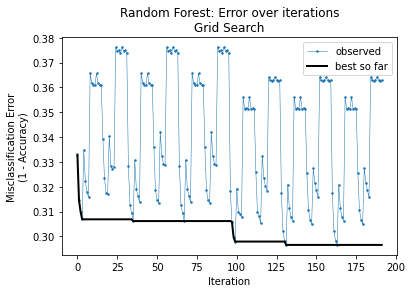

In [35]:
# convergence plot
accs = np.array([x['mean_metric'] for x in gs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

plt.close('all')
plt.figure()
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("Random Forest: Error over iterations\nGrid Search")
plt.legend()

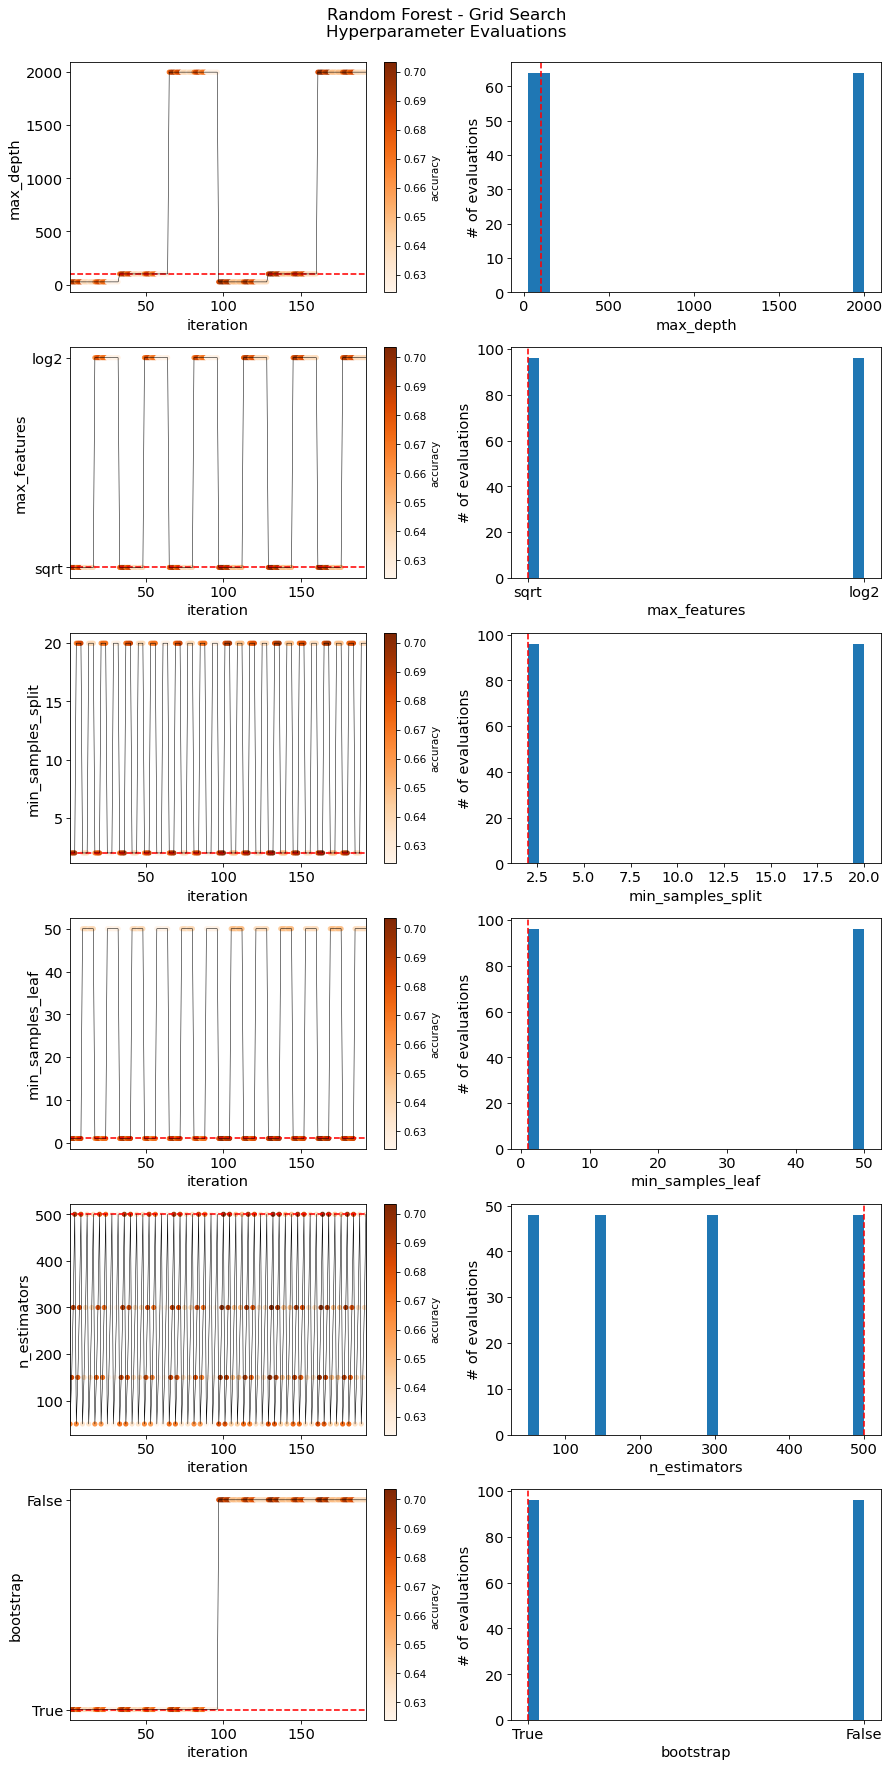

In [9]:
accs = np.array([x['mean_metric'] for x in gs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

params = gs_hyperparameters.keys()
plt.figure(figsize=(12, 4*len(params)), dpi=75)

for i, param in enumerate(params):
    plt.subplot(len(params), 2, 2*i+1)
    param_vals = [x['params'][param] for x in gs_results]
    if type(param_vals[0]) == bool:
        param_vals = [str(x) for x in param_vals]
    best_val = gs.best_params_[param]

    plt.scatter(np.arange(1,len(param_vals)+1), param_vals, s=15, c=accs, cmap="Oranges", label="Accuracy")
    plt.plot(np.arange(1,len(param_vals)+1), param_vals, 'k', linewidth=0.5)
    plt.xlim(1, len(param_vals))
    plt.hlines(best_val, 0, len(param_vals), 'r', 'dashed')

    plt.ylabel(param, fontsize=14)
    plt.xlabel("iteration", fontsize=14)
    cb = plt.colorbar()
    cb.set_label("accuracy")
    plt.tick_params(labelsize=14)

    
    plt.subplot(len(params), 2, 2*i+2)
    plt.hist(param_vals, bins=30)
    plt.axvline(x=best_val, color='red', linestyle='--')
    plt.xlabel(param, fontsize=14)
    plt.ylabel('# of evaluations', fontsize=14)
    plt.tick_params(labelsize=14)
    
plt.suptitle("Random Forest - Grid Search\nHyperparameter Evaluations", size=16)
plt.tight_layout(rect=[0, 0.0, 1, 0.98])

# Random Search

In [10]:
rs_hyperparameters = {
    'max_depth': range(1, 2001),
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': range(2, 45),
    'min_samples_leaf': range(1, 100),
    'n_estimators': range(25, 500),
    'bootstrap': [True, False]
}

N_EVALS = 192  # same as grid search above

In [11]:
clf = RandomForestClassifier(random_state=682, verbose=1, n_jobs=4)

rs = RandomizedSearchCV(clf,
                        param_distributions=rs_hyperparameters,
                        n_iter=N_EVALS,
                        scoring='accuracy',
                        cv=cv_folds,
                        refit=False,
                        verbose=5, 
                        n_jobs=1,
                        random_state=682)


print('\n--------------------------------------\nBeginning random search at {}...'.format(datetime.now().strftime('%H:%M:%S')))
rs.fit(x_train_4class, y_train_4class)

rs_results = []
for i in range(len(rs.cv_results_['params'])):
    result = {'params' : rs.cv_results_['params'][i], 
              'mean_metric' : rs.cv_results_['mean_test_score'][i], 
              'mean_fit_time': rs.cv_results_['mean_fit_time'][i],
              'mean_score_time': rs.cv_results_['mean_score_time'][i]}
    rs_results += [result]
    print('accuracy = {} ({} seconds): {} '.format(round(result['mean_metric'], 4),
                                                   round(result['mean_fit_time'], 2),
                                                   result['params']), flush=True)


print('\nBest model:')
print(max(rs_results, key=lambda item: item['mean_metric']))

with open('randomforest_rs_results_{}.pkl'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), 'wb') as f:
    pickle.dump({'rs_results': rs_results, 'rs': rs}, f)
    
print('Finished with random search at {}\n\n\n'.format(datetime.now().strftime('%H:%M:%S')))


--------------------------------------
Beginning random search at 02:49:19...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] n_estimators=217, min_samples_split=37, min_samples_leaf=68, max_features=log2, max_depth=1805, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 217 out of 217 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 217 out of 217 | elapsed:    0.1s finished


[CV]  n_estimators=217, min_samples_split=37, min_samples_leaf=68, max_features=log2, max_depth=1805, bootstrap=True, score=0.617, total=   3.7s
[CV] n_estimators=217, min_samples_split=37, min_samples_leaf=68, max_features=log2, max_depth=1805, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 217 out of 217 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 217 out of 217 | elapsed:    0.1s finished


[CV]  n_estimators=217, min_samples_split=37, min_samples_leaf=68, max_features=log2, max_depth=1805, bootstrap=True, score=0.629, total=   3.7s
[CV] n_estimators=217, min_samples_split=37, min_samples_leaf=68, max_features=log2, max_depth=1805, bootstrap=True 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 217 out of 217 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 217 out of 217 | elapsed:    0.1s finished


[CV]  n_estimators=217, min_samples_split=37, min_samples_leaf=68, max_features=log2, max_depth=1805, bootstrap=True, score=0.613, total=   3.7s
[CV] n_estimators=217, min_samples_split=37, min_samples_leaf=68, max_features=log2, max_depth=1805, bootstrap=True 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 217 out of 217 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 217 out of 217 | elapsed:    0.1s finished


[CV]  n_estimators=217, min_samples_split=37, min_samples_leaf=68, max_features=log2, max_depth=1805, bootstrap=True, score=0.614, total=   3.7s
[CV] n_estimators=217, min_samples_split=37, min_samples_leaf=68, max_features=log2, max_depth=1805, bootstrap=True 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 217 out of 217 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 217 out of 217 | elapsed:    0.1s finished


[CV]  n_estimators=217, min_samples_split=37, min_samples_leaf=68, max_features=log2, max_depth=1805, bootstrap=True, score=0.615, total=   3.7s
[CV] n_estimators=450, min_samples_split=10, min_samples_leaf=99, max_features=sqrt, max_depth=1202, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   25.0s
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:   25.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:    0.1s finished


[CV]  n_estimators=450, min_samples_split=10, min_samples_leaf=99, max_features=sqrt, max_depth=1202, bootstrap=True, score=0.618, total=  26.2s
[CV] n_estimators=450, min_samples_split=10, min_samples_leaf=99, max_features=sqrt, max_depth=1202, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   25.1s
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:   25.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:    0.1s finished


[CV]  n_estimators=450, min_samples_split=10, min_samples_leaf=99, max_features=sqrt, max_depth=1202, bootstrap=True, score=0.630, total=  26.2s
[CV] n_estimators=450, min_samples_split=10, min_samples_leaf=99, max_features=sqrt, max_depth=1202, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   25.3s
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:   25.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:    0.1s finished


[CV]  n_estimators=450, min_samples_split=10, min_samples_leaf=99, max_features=sqrt, max_depth=1202, bootstrap=True, score=0.618, total=  26.5s
[CV] n_estimators=450, min_samples_split=10, min_samples_leaf=99, max_features=sqrt, max_depth=1202, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   25.1s
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:   25.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:    0.1s finished


[CV]  n_estimators=450, min_samples_split=10, min_samples_leaf=99, max_features=sqrt, max_depth=1202, bootstrap=True, score=0.619, total=  26.2s
[CV] n_estimators=450, min_samples_split=10, min_samples_leaf=99, max_features=sqrt, max_depth=1202, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   25.1s
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:   25.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:    0.1s finished


[CV]  n_estimators=450, min_samples_split=10, min_samples_leaf=99, max_features=sqrt, max_depth=1202, bootstrap=True, score=0.616, total=  26.2s
[CV] n_estimators=115, min_samples_split=15, min_samples_leaf=65, max_features=log2, max_depth=724, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 108 out of 115 | elapsed:    2.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 115 out of 115 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 115 out of 115 | elapsed:    0.0s finished


[CV]  n_estimators=115, min_samples_split=15, min_samples_leaf=65, max_features=log2, max_depth=724, bootstrap=False, score=0.628, total=   3.3s
[CV] n_estimators=115, min_samples_split=15, min_samples_leaf=65, max_features=log2, max_depth=724, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 108 out of 115 | elapsed:    2.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 115 out of 115 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 115 out of 115 | elapsed:    0.0s finished


[CV]  n_estimators=115, min_samples_split=15, min_samples_leaf=65, max_features=log2, max_depth=724, bootstrap=False, score=0.635, total=   3.3s
[CV] n_estimators=115, min_samples_split=15, min_samples_leaf=65, max_features=log2, max_depth=724, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 108 out of 115 | elapsed:    2.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 115 out of 115 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 115 out of 115 | elapsed:    0.0s finished


[CV]  n_estimators=115, min_samples_split=15, min_samples_leaf=65, max_features=log2, max_depth=724, bootstrap=False, score=0.628, total=   3.3s
[CV] n_estimators=115, min_samples_split=15, min_samples_leaf=65, max_features=log2, max_depth=724, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 108 out of 115 | elapsed:    2.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 115 out of 115 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 115 out of 115 | elapsed:    0.0s finished


[CV]  n_estimators=115, min_samples_split=15, min_samples_leaf=65, max_features=log2, max_depth=724, bootstrap=False, score=0.628, total=   3.3s
[CV] n_estimators=115, min_samples_split=15, min_samples_leaf=65, max_features=log2, max_depth=724, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 108 out of 115 | elapsed:    2.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 115 out of 115 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 115 out of 115 | elapsed:    0.0s finished


[CV]  n_estimators=115, min_samples_split=15, min_samples_leaf=65, max_features=log2, max_depth=724, bootstrap=False, score=0.621, total=   3.3s
[CV] n_estimators=452, min_samples_split=20, min_samples_leaf=80, max_features=sqrt, max_depth=582, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done 452 out of 452 | elapsed:   27.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 452 out of 452 | elapsed:    0.1s finished


[CV]  n_estimators=452, min_samples_split=20, min_samples_leaf=80, max_features=sqrt, max_depth=582, bootstrap=True, score=0.626, total=  27.6s
[CV] n_estimators=452, min_samples_split=20, min_samples_leaf=80, max_features=sqrt, max_depth=582, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done 452 out of 452 | elapsed:   27.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 452 out of 452 | elapsed:    0.1s finished


[CV]  n_estimators=452, min_samples_split=20, min_samples_leaf=80, max_features=sqrt, max_depth=582, bootstrap=True, score=0.638, total=  27.9s
[CV] n_estimators=452, min_samples_split=20, min_samples_leaf=80, max_features=sqrt, max_depth=582, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   26.7s
[Parallel(n_jobs=4)]: Done 452 out of 452 | elapsed:   27.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 452 out of 452 | elapsed:    0.1s finished


[CV]  n_estimators=452, min_samples_split=20, min_samples_leaf=80, max_features=sqrt, max_depth=582, bootstrap=True, score=0.625, total=  27.9s
[CV] n_estimators=452, min_samples_split=20, min_samples_leaf=80, max_features=sqrt, max_depth=582, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done 452 out of 452 | elapsed:   27.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 452 out of 452 | elapsed:    0.1s finished


[CV]  n_estimators=452, min_samples_split=20, min_samples_leaf=80, max_features=sqrt, max_depth=582, bootstrap=True, score=0.626, total=  27.7s
[CV] n_estimators=452, min_samples_split=20, min_samples_leaf=80, max_features=sqrt, max_depth=582, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done 452 out of 452 | elapsed:   27.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 452 out of 452 | elapsed:    0.1s finished


[CV]  n_estimators=452, min_samples_split=20, min_samples_leaf=80, max_features=sqrt, max_depth=582, bootstrap=True, score=0.622, total=  27.7s
[CV] n_estimators=275, min_samples_split=3, min_samples_leaf=25, max_features=log2, max_depth=1635, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 275 out of 275 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 275 out of 275 | elapsed:    0.1s finished


[CV]  n_estimators=275, min_samples_split=3, min_samples_leaf=25, max_features=log2, max_depth=1635, bootstrap=False, score=0.652, total=   8.9s
[CV] n_estimators=275, min_samples_split=3, min_samples_leaf=25, max_features=log2, max_depth=1635, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 275 out of 275 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 275 out of 275 | elapsed:    0.1s finished


[CV]  n_estimators=275, min_samples_split=3, min_samples_leaf=25, max_features=log2, max_depth=1635, bootstrap=False, score=0.663, total=   9.0s
[CV] n_estimators=275, min_samples_split=3, min_samples_leaf=25, max_features=log2, max_depth=1635, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 275 out of 275 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 275 out of 275 | elapsed:    0.1s finished


[CV]  n_estimators=275, min_samples_split=3, min_samples_leaf=25, max_features=log2, max_depth=1635, bootstrap=False, score=0.652, total=   8.9s
[CV] n_estimators=275, min_samples_split=3, min_samples_leaf=25, max_features=log2, max_depth=1635, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 275 out of 275 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 275 out of 275 | elapsed:    0.1s finished


[CV]  n_estimators=275, min_samples_split=3, min_samples_leaf=25, max_features=log2, max_depth=1635, bootstrap=False, score=0.656, total=   8.9s
[CV] n_estimators=275, min_samples_split=3, min_samples_leaf=25, max_features=log2, max_depth=1635, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 275 out of 275 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 275 out of 275 | elapsed:    0.1s finished


[CV]  n_estimators=275, min_samples_split=3, min_samples_leaf=25, max_features=log2, max_depth=1635, bootstrap=False, score=0.651, total=   8.8s
[CV] n_estimators=333, min_samples_split=29, min_samples_leaf=87, max_features=sqrt, max_depth=571, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.9s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   33.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:    0.1s finished


[CV]  n_estimators=333, min_samples_split=29, min_samples_leaf=87, max_features=sqrt, max_depth=571, bootstrap=False, score=0.628, total=  33.7s
[CV] n_estimators=333, min_samples_split=29, min_samples_leaf=87, max_features=sqrt, max_depth=571, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.9s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   33.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:    0.1s finished


[CV]  n_estimators=333, min_samples_split=29, min_samples_leaf=87, max_features=sqrt, max_depth=571, bootstrap=False, score=0.644, total=  33.6s
[CV] n_estimators=333, min_samples_split=29, min_samples_leaf=87, max_features=sqrt, max_depth=571, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   33.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:    0.1s finished


[CV]  n_estimators=333, min_samples_split=29, min_samples_leaf=87, max_features=sqrt, max_depth=571, bootstrap=False, score=0.633, total=  33.8s
[CV] n_estimators=333, min_samples_split=29, min_samples_leaf=87, max_features=sqrt, max_depth=571, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.0s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   33.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:    0.1s finished


[CV]  n_estimators=333, min_samples_split=29, min_samples_leaf=87, max_features=sqrt, max_depth=571, bootstrap=False, score=0.633, total=  33.6s
[CV] n_estimators=333, min_samples_split=29, min_samples_leaf=87, max_features=sqrt, max_depth=571, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.9s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:   33.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 333 out of 333 | elapsed:    0.1s finished


[CV]  n_estimators=333, min_samples_split=29, min_samples_leaf=87, max_features=sqrt, max_depth=571, bootstrap=False, score=0.628, total=  33.5s
[CV] n_estimators=117, min_samples_split=8, min_samples_leaf=21, max_features=sqrt, max_depth=1953, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:   16.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:    0.0s finished


[CV]  n_estimators=117, min_samples_split=8, min_samples_leaf=21, max_features=sqrt, max_depth=1953, bootstrap=False, score=0.668, total=  16.5s
[CV] n_estimators=117, min_samples_split=8, min_samples_leaf=21, max_features=sqrt, max_depth=1953, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:   16.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:    0.0s finished


[CV]  n_estimators=117, min_samples_split=8, min_samples_leaf=21, max_features=sqrt, max_depth=1953, bootstrap=False, score=0.682, total=  16.6s
[CV] n_estimators=117, min_samples_split=8, min_samples_leaf=21, max_features=sqrt, max_depth=1953, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:   16.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:    0.0s finished


[CV]  n_estimators=117, min_samples_split=8, min_samples_leaf=21, max_features=sqrt, max_depth=1953, bootstrap=False, score=0.669, total=  16.8s
[CV] n_estimators=117, min_samples_split=8, min_samples_leaf=21, max_features=sqrt, max_depth=1953, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:   16.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:    0.0s finished


[CV]  n_estimators=117, min_samples_split=8, min_samples_leaf=21, max_features=sqrt, max_depth=1953, bootstrap=False, score=0.670, total=  16.5s
[CV] n_estimators=117, min_samples_split=8, min_samples_leaf=21, max_features=sqrt, max_depth=1953, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:   16.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:    0.0s finished


[CV]  n_estimators=117, min_samples_split=8, min_samples_leaf=21, max_features=sqrt, max_depth=1953, bootstrap=False, score=0.656, total=  16.6s
[CV] n_estimators=355, min_samples_split=35, min_samples_leaf=72, max_features=sqrt, max_depth=1721, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 355 out of 355 | elapsed:   21.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 355 out of 355 | elapsed:    0.1s finished


[CV]  n_estimators=355, min_samples_split=35, min_samples_leaf=72, max_features=sqrt, max_depth=1721, bootstrap=True, score=0.627, total=  22.5s
[CV] n_estimators=355, min_samples_split=35, min_samples_leaf=72, max_features=sqrt, max_depth=1721, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 355 out of 355 | elapsed:   21.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 355 out of 355 | elapsed:    0.1s finished


[CV]  n_estimators=355, min_samples_split=35, min_samples_leaf=72, max_features=sqrt, max_depth=1721, bootstrap=True, score=0.643, total=  22.5s
[CV] n_estimators=355, min_samples_split=35, min_samples_leaf=72, max_features=sqrt, max_depth=1721, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 355 out of 355 | elapsed:   21.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 355 out of 355 | elapsed:    0.1s finished


[CV]  n_estimators=355, min_samples_split=35, min_samples_leaf=72, max_features=sqrt, max_depth=1721, bootstrap=True, score=0.625, total=  22.6s
[CV] n_estimators=355, min_samples_split=35, min_samples_leaf=72, max_features=sqrt, max_depth=1721, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 355 out of 355 | elapsed:   22.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 355 out of 355 | elapsed:    0.1s finished


[CV]  n_estimators=355, min_samples_split=35, min_samples_leaf=72, max_features=sqrt, max_depth=1721, bootstrap=True, score=0.630, total=  22.6s
[CV] n_estimators=355, min_samples_split=35, min_samples_leaf=72, max_features=sqrt, max_depth=1721, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 355 out of 355 | elapsed:   21.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 355 out of 355 | elapsed:    0.1s finished


[CV]  n_estimators=355, min_samples_split=35, min_samples_leaf=72, max_features=sqrt, max_depth=1721, bootstrap=True, score=0.624, total=  22.5s
[CV] n_estimators=478, min_samples_split=28, min_samples_leaf=14, max_features=sqrt, max_depth=1518, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:    0.2s finished


[CV]  n_estimators=478, min_samples_split=28, min_samples_leaf=14, max_features=sqrt, max_depth=1518, bootstrap=False, score=0.672, total= 1.2min
[CV] n_estimators=478, min_samples_split=28, min_samples_leaf=14, max_features=sqrt, max_depth=1518, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:    0.2s finished


[CV]  n_estimators=478, min_samples_split=28, min_samples_leaf=14, max_features=sqrt, max_depth=1518, bootstrap=False, score=0.689, total= 1.2min
[CV] n_estimators=478, min_samples_split=28, min_samples_leaf=14, max_features=sqrt, max_depth=1518, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:    0.2s finished


[CV]  n_estimators=478, min_samples_split=28, min_samples_leaf=14, max_features=sqrt, max_depth=1518, bootstrap=False, score=0.674, total= 1.2min
[CV] n_estimators=478, min_samples_split=28, min_samples_leaf=14, max_features=sqrt, max_depth=1518, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:    0.2s finished


[CV]  n_estimators=478, min_samples_split=28, min_samples_leaf=14, max_features=sqrt, max_depth=1518, bootstrap=False, score=0.681, total= 1.2min
[CV] n_estimators=478, min_samples_split=28, min_samples_leaf=14, max_features=sqrt, max_depth=1518, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:    0.2s finished


[CV]  n_estimators=478, min_samples_split=28, min_samples_leaf=14, max_features=sqrt, max_depth=1518, bootstrap=False, score=0.670, total= 1.2min
[CV] n_estimators=134, min_samples_split=21, min_samples_leaf=15, max_features=sqrt, max_depth=318, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 134 out of 134 | elapsed:   19.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 134 out of 134 | elapsed:    0.0s finished


[CV]  n_estimators=134, min_samples_split=21, min_samples_leaf=15, max_features=sqrt, max_depth=318, bootstrap=False, score=0.673, total=  19.8s
[CV] n_estimators=134, min_samples_split=21, min_samples_leaf=15, max_features=sqrt, max_depth=318, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 134 out of 134 | elapsed:   19.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 134 out of 134 | elapsed:    0.0s finished


[CV]  n_estimators=134, min_samples_split=21, min_samples_leaf=15, max_features=sqrt, max_depth=318, bootstrap=False, score=0.685, total=  19.9s
[CV] n_estimators=134, min_samples_split=21, min_samples_leaf=15, max_features=sqrt, max_depth=318, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 134 out of 134 | elapsed:   19.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 134 out of 134 | elapsed:    0.0s finished


[CV]  n_estimators=134, min_samples_split=21, min_samples_leaf=15, max_features=sqrt, max_depth=318, bootstrap=False, score=0.673, total=  20.0s
[CV] n_estimators=134, min_samples_split=21, min_samples_leaf=15, max_features=sqrt, max_depth=318, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 134 out of 134 | elapsed:   19.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 134 out of 134 | elapsed:    0.0s finished


[CV]  n_estimators=134, min_samples_split=21, min_samples_leaf=15, max_features=sqrt, max_depth=318, bootstrap=False, score=0.679, total=  19.8s
[CV] n_estimators=134, min_samples_split=21, min_samples_leaf=15, max_features=sqrt, max_depth=318, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 134 out of 134 | elapsed:   19.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 134 out of 134 | elapsed:    0.0s finished


[CV]  n_estimators=134, min_samples_split=21, min_samples_leaf=15, max_features=sqrt, max_depth=318, bootstrap=False, score=0.669, total=  19.8s
[CV] n_estimators=396, min_samples_split=25, min_samples_leaf=48, max_features=sqrt, max_depth=411, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.1s
[Parallel(n_jobs=4)]: Done 396 out of 396 | elapsed:   44.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 396 out of 396 | elapsed:    0.1s finished


[CV]  n_estimators=396, min_samples_split=25, min_samples_leaf=48, max_features=sqrt, max_depth=411, bootstrap=False, score=0.648, total=  45.6s
[CV] n_estimators=396, min_samples_split=25, min_samples_leaf=48, max_features=sqrt, max_depth=411, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=4)]: Done 396 out of 396 | elapsed:   44.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 396 out of 396 | elapsed:    0.1s finished


[CV]  n_estimators=396, min_samples_split=25, min_samples_leaf=48, max_features=sqrt, max_depth=411, bootstrap=False, score=0.660, total=  45.4s
[CV] n_estimators=396, min_samples_split=25, min_samples_leaf=48, max_features=sqrt, max_depth=411, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done 396 out of 396 | elapsed:   45.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 396 out of 396 | elapsed:    0.1s finished


[CV]  n_estimators=396, min_samples_split=25, min_samples_leaf=48, max_features=sqrt, max_depth=411, bootstrap=False, score=0.646, total=  45.8s
[CV] n_estimators=396, min_samples_split=25, min_samples_leaf=48, max_features=sqrt, max_depth=411, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.7s
[Parallel(n_jobs=4)]: Done 396 out of 396 | elapsed:   44.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 396 out of 396 | elapsed:    0.1s finished


[CV]  n_estimators=396, min_samples_split=25, min_samples_leaf=48, max_features=sqrt, max_depth=411, bootstrap=False, score=0.651, total=  45.2s
[CV] n_estimators=396, min_samples_split=25, min_samples_leaf=48, max_features=sqrt, max_depth=411, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 396 out of 396 | elapsed:   44.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 396 out of 396 | elapsed:    0.1s finished


[CV]  n_estimators=396, min_samples_split=25, min_samples_leaf=48, max_features=sqrt, max_depth=411, bootstrap=False, score=0.646, total=  45.4s
[CV] n_estimators=257, min_samples_split=16, min_samples_leaf=79, max_features=sqrt, max_depth=727, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.3s
[Parallel(n_jobs=4)]: Done 257 out of 257 | elapsed:   26.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 out of 257 | elapsed:    0.1s finished


[CV]  n_estimators=257, min_samples_split=16, min_samples_leaf=79, max_features=sqrt, max_depth=727, bootstrap=False, score=0.631, total=  26.6s
[CV] n_estimators=257, min_samples_split=16, min_samples_leaf=79, max_features=sqrt, max_depth=727, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 257 out of 257 | elapsed:   26.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 out of 257 | elapsed:    0.1s finished


[CV]  n_estimators=257, min_samples_split=16, min_samples_leaf=79, max_features=sqrt, max_depth=727, bootstrap=False, score=0.645, total=  26.7s
[CV] n_estimators=257, min_samples_split=16, min_samples_leaf=79, max_features=sqrt, max_depth=727, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done 257 out of 257 | elapsed:   26.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 out of 257 | elapsed:    0.1s finished


[CV]  n_estimators=257, min_samples_split=16, min_samples_leaf=79, max_features=sqrt, max_depth=727, bootstrap=False, score=0.637, total=  26.9s
[CV] n_estimators=257, min_samples_split=16, min_samples_leaf=79, max_features=sqrt, max_depth=727, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.4s
[Parallel(n_jobs=4)]: Done 257 out of 257 | elapsed:   26.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 out of 257 | elapsed:    0.1s finished


[CV]  n_estimators=257, min_samples_split=16, min_samples_leaf=79, max_features=sqrt, max_depth=727, bootstrap=False, score=0.635, total=  26.8s
[CV] n_estimators=257, min_samples_split=16, min_samples_leaf=79, max_features=sqrt, max_depth=727, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done 257 out of 257 | elapsed:   26.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 out of 257 | elapsed:    0.1s finished


[CV]  n_estimators=257, min_samples_split=16, min_samples_leaf=79, max_features=sqrt, max_depth=727, bootstrap=False, score=0.632, total=  26.7s
[CV] n_estimators=444, min_samples_split=41, min_samples_leaf=28, max_features=log2, max_depth=1779, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 444 out of 444 | elapsed:   13.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 444 out of 444 | elapsed:    0.1s finished


[CV]  n_estimators=444, min_samples_split=41, min_samples_leaf=28, max_features=log2, max_depth=1779, bootstrap=False, score=0.651, total=  13.7s
[CV] n_estimators=444, min_samples_split=41, min_samples_leaf=28, max_features=log2, max_depth=1779, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 444 out of 444 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 444 out of 444 | elapsed:    0.1s finished


[CV]  n_estimators=444, min_samples_split=41, min_samples_leaf=28, max_features=log2, max_depth=1779, bootstrap=False, score=0.660, total=  13.8s
[CV] n_estimators=444, min_samples_split=41, min_samples_leaf=28, max_features=log2, max_depth=1779, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 444 out of 444 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 444 out of 444 | elapsed:    0.1s finished


[CV]  n_estimators=444, min_samples_split=41, min_samples_leaf=28, max_features=log2, max_depth=1779, bootstrap=False, score=0.648, total=  13.8s
[CV] n_estimators=444, min_samples_split=41, min_samples_leaf=28, max_features=log2, max_depth=1779, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 444 out of 444 | elapsed:   13.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 444 out of 444 | elapsed:    0.1s finished


[CV]  n_estimators=444, min_samples_split=41, min_samples_leaf=28, max_features=log2, max_depth=1779, bootstrap=False, score=0.650, total=  13.7s
[CV] n_estimators=444, min_samples_split=41, min_samples_leaf=28, max_features=log2, max_depth=1779, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 444 out of 444 | elapsed:   13.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 444 out of 444 | elapsed:    0.1s finished


[CV]  n_estimators=444, min_samples_split=41, min_samples_leaf=28, max_features=log2, max_depth=1779, bootstrap=False, score=0.647, total=  13.7s
[CV] n_estimators=210, min_samples_split=32, min_samples_leaf=19, max_features=log2, max_depth=1282, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    0.1s finished


[CV]  n_estimators=210, min_samples_split=32, min_samples_leaf=19, max_features=log2, max_depth=1282, bootstrap=False, score=0.657, total=   7.3s
[CV] n_estimators=210, min_samples_split=32, min_samples_leaf=19, max_features=log2, max_depth=1282, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    0.1s finished


[CV]  n_estimators=210, min_samples_split=32, min_samples_leaf=19, max_features=log2, max_depth=1282, bootstrap=False, score=0.668, total=   7.3s
[CV] n_estimators=210, min_samples_split=32, min_samples_leaf=19, max_features=log2, max_depth=1282, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    0.1s finished


[CV]  n_estimators=210, min_samples_split=32, min_samples_leaf=19, max_features=log2, max_depth=1282, bootstrap=False, score=0.656, total=   7.3s
[CV] n_estimators=210, min_samples_split=32, min_samples_leaf=19, max_features=log2, max_depth=1282, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    0.1s finished


[CV]  n_estimators=210, min_samples_split=32, min_samples_leaf=19, max_features=log2, max_depth=1282, bootstrap=False, score=0.661, total=   7.3s
[CV] n_estimators=210, min_samples_split=32, min_samples_leaf=19, max_features=log2, max_depth=1282, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    0.1s finished


[CV]  n_estimators=210, min_samples_split=32, min_samples_leaf=19, max_features=log2, max_depth=1282, bootstrap=False, score=0.651, total=   7.2s
[CV] n_estimators=201, min_samples_split=2, min_samples_leaf=73, max_features=log2, max_depth=1484, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 194 out of 201 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 201 out of 201 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 201 out of 201 | elapsed:    0.1s finished


[CV]  n_estimators=201, min_samples_split=2, min_samples_leaf=73, max_features=log2, max_depth=1484, bootstrap=False, score=0.626, total=   5.3s
[CV] n_estimators=201, min_samples_split=2, min_samples_leaf=73, max_features=log2, max_depth=1484, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 194 out of 201 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 201 out of 201 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 201 out of 201 | elapsed:    0.1s finished


[CV]  n_estimators=201, min_samples_split=2, min_samples_leaf=73, max_features=log2, max_depth=1484, bootstrap=False, score=0.635, total=   5.3s
[CV] n_estimators=201, min_samples_split=2, min_samples_leaf=73, max_features=log2, max_depth=1484, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 194 out of 201 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 201 out of 201 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 201 out of 201 | elapsed:    0.1s finished


[CV]  n_estimators=201, min_samples_split=2, min_samples_leaf=73, max_features=log2, max_depth=1484, bootstrap=False, score=0.625, total=   5.3s
[CV] n_estimators=201, min_samples_split=2, min_samples_leaf=73, max_features=log2, max_depth=1484, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 194 out of 201 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 201 out of 201 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 201 out of 201 | elapsed:    0.1s finished


[CV]  n_estimators=201, min_samples_split=2, min_samples_leaf=73, max_features=log2, max_depth=1484, bootstrap=False, score=0.626, total=   5.3s
[CV] n_estimators=201, min_samples_split=2, min_samples_leaf=73, max_features=log2, max_depth=1484, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 194 out of 201 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 201 out of 201 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 201 out of 201 | elapsed:    0.1s finished


[CV]  n_estimators=201, min_samples_split=2, min_samples_leaf=73, max_features=log2, max_depth=1484, bootstrap=False, score=0.619, total=   5.3s
[CV] n_estimators=446, min_samples_split=9, min_samples_leaf=91, max_features=sqrt, max_depth=750, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done 446 out of 446 | elapsed:   43.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 446 out of 446 | elapsed:    0.1s finished


[CV]  n_estimators=446, min_samples_split=9, min_samples_leaf=91, max_features=sqrt, max_depth=750, bootstrap=False, score=0.625, total=  44.1s
[CV] n_estimators=446, min_samples_split=9, min_samples_leaf=91, max_features=sqrt, max_depth=750, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.8s
[Parallel(n_jobs=4)]: Done 446 out of 446 | elapsed:   43.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 446 out of 446 | elapsed:    0.1s finished


[CV]  n_estimators=446, min_samples_split=9, min_samples_leaf=91, max_features=sqrt, max_depth=750, bootstrap=False, score=0.639, total=  44.2s
[CV] n_estimators=446, min_samples_split=9, min_samples_leaf=91, max_features=sqrt, max_depth=750, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.9s
[Parallel(n_jobs=4)]: Done 446 out of 446 | elapsed:   43.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 446 out of 446 | elapsed:    0.1s finished


[CV]  n_estimators=446, min_samples_split=9, min_samples_leaf=91, max_features=sqrt, max_depth=750, bootstrap=False, score=0.630, total=  44.5s
[CV] n_estimators=446, min_samples_split=9, min_samples_leaf=91, max_features=sqrt, max_depth=750, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.8s
[Parallel(n_jobs=4)]: Done 446 out of 446 | elapsed:   43.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 446 out of 446 | elapsed:    0.1s finished


[CV]  n_estimators=446, min_samples_split=9, min_samples_leaf=91, max_features=sqrt, max_depth=750, bootstrap=False, score=0.630, total=  44.3s
[CV] n_estimators=446, min_samples_split=9, min_samples_leaf=91, max_features=sqrt, max_depth=750, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.7s
[Parallel(n_jobs=4)]: Done 446 out of 446 | elapsed:   43.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 446 out of 446 | elapsed:    0.1s finished


[CV]  n_estimators=446, min_samples_split=9, min_samples_leaf=91, max_features=sqrt, max_depth=750, bootstrap=False, score=0.629, total=  44.1s
[CV] n_estimators=404, min_samples_split=38, min_samples_leaf=75, max_features=log2, max_depth=1870, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    9.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    0.1s finished


[CV]  n_estimators=404, min_samples_split=38, min_samples_leaf=75, max_features=log2, max_depth=1870, bootstrap=False, score=0.624, total=   9.9s
[CV] n_estimators=404, min_samples_split=38, min_samples_leaf=75, max_features=log2, max_depth=1870, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    9.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    0.1s finished


[CV]  n_estimators=404, min_samples_split=38, min_samples_leaf=75, max_features=log2, max_depth=1870, bootstrap=False, score=0.633, total=   9.9s
[CV] n_estimators=404, min_samples_split=38, min_samples_leaf=75, max_features=log2, max_depth=1870, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    9.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    0.1s finished


[CV]  n_estimators=404, min_samples_split=38, min_samples_leaf=75, max_features=log2, max_depth=1870, bootstrap=False, score=0.623, total=   9.9s
[CV] n_estimators=404, min_samples_split=38, min_samples_leaf=75, max_features=log2, max_depth=1870, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 397 out of 404 | elapsed:    9.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    9.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    0.1s finished


[CV]  n_estimators=404, min_samples_split=38, min_samples_leaf=75, max_features=log2, max_depth=1870, bootstrap=False, score=0.625, total=  10.0s
[CV] n_estimators=404, min_samples_split=38, min_samples_leaf=75, max_features=log2, max_depth=1870, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    9.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    0.1s finished


[CV]  n_estimators=404, min_samples_split=38, min_samples_leaf=75, max_features=log2, max_depth=1870, bootstrap=False, score=0.622, total=   9.9s
[CV] n_estimators=367, min_samples_split=30, min_samples_leaf=36, max_features=sqrt, max_depth=28, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done 367 out of 367 | elapsed:   26.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 367 out of 367 | elapsed:    0.1s finished


[CV]  n_estimators=367, min_samples_split=30, min_samples_leaf=36, max_features=sqrt, max_depth=28, bootstrap=True, score=0.646, total=  27.2s
[CV] n_estimators=367, min_samples_split=30, min_samples_leaf=36, max_features=sqrt, max_depth=28, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.9s
[Parallel(n_jobs=4)]: Done 367 out of 367 | elapsed:   26.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 367 out of 367 | elapsed:    0.1s finished


[CV]  n_estimators=367, min_samples_split=30, min_samples_leaf=36, max_features=sqrt, max_depth=28, bootstrap=True, score=0.658, total=  27.3s
[CV] n_estimators=367, min_samples_split=30, min_samples_leaf=36, max_features=sqrt, max_depth=28, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done 367 out of 367 | elapsed:   26.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 367 out of 367 | elapsed:    0.1s finished


[CV]  n_estimators=367, min_samples_split=30, min_samples_leaf=36, max_features=sqrt, max_depth=28, bootstrap=True, score=0.649, total=  27.4s
[CV] n_estimators=367, min_samples_split=30, min_samples_leaf=36, max_features=sqrt, max_depth=28, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.9s
[Parallel(n_jobs=4)]: Done 367 out of 367 | elapsed:   26.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 367 out of 367 | elapsed:    0.1s finished


[CV]  n_estimators=367, min_samples_split=30, min_samples_leaf=36, max_features=sqrt, max_depth=28, bootstrap=True, score=0.650, total=  27.4s
[CV] n_estimators=367, min_samples_split=30, min_samples_leaf=36, max_features=sqrt, max_depth=28, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.9s
[Parallel(n_jobs=4)]: Done 367 out of 367 | elapsed:   26.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 367 out of 367 | elapsed:    0.1s finished


[CV]  n_estimators=367, min_samples_split=30, min_samples_leaf=36, max_features=sqrt, max_depth=28, bootstrap=True, score=0.641, total=  27.3s
[CV] n_estimators=262, min_samples_split=9, min_samples_leaf=82, max_features=log2, max_depth=900, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 262 out of 262 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 262 out of 262 | elapsed:    0.1s finished


[CV]  n_estimators=262, min_samples_split=9, min_samples_leaf=82, max_features=log2, max_depth=900, bootstrap=False, score=0.621, total=   6.5s
[CV] n_estimators=262, min_samples_split=9, min_samples_leaf=82, max_features=log2, max_depth=900, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 262 out of 262 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 262 out of 262 | elapsed:    0.1s finished


[CV]  n_estimators=262, min_samples_split=9, min_samples_leaf=82, max_features=log2, max_depth=900, bootstrap=False, score=0.635, total=   6.4s
[CV] n_estimators=262, min_samples_split=9, min_samples_leaf=82, max_features=log2, max_depth=900, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 262 out of 262 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 262 out of 262 | elapsed:    0.1s finished


[CV]  n_estimators=262, min_samples_split=9, min_samples_leaf=82, max_features=log2, max_depth=900, bootstrap=False, score=0.620, total=   6.5s
[CV] n_estimators=262, min_samples_split=9, min_samples_leaf=82, max_features=log2, max_depth=900, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 262 out of 262 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 262 out of 262 | elapsed:    0.1s finished


[CV]  n_estimators=262, min_samples_split=9, min_samples_leaf=82, max_features=log2, max_depth=900, bootstrap=False, score=0.619, total=   6.5s
[CV] n_estimators=262, min_samples_split=9, min_samples_leaf=82, max_features=log2, max_depth=900, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 262 out of 262 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 262 out of 262 | elapsed:    0.1s finished


[CV]  n_estimators=262, min_samples_split=9, min_samples_leaf=82, max_features=log2, max_depth=900, bootstrap=False, score=0.619, total=   6.5s
[CV] n_estimators=154, min_samples_split=14, min_samples_leaf=83, max_features=log2, max_depth=712, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:    0.0s finished


[CV]  n_estimators=154, min_samples_split=14, min_samples_leaf=83, max_features=log2, max_depth=712, bootstrap=False, score=0.623, total=   4.1s
[CV] n_estimators=154, min_samples_split=14, min_samples_leaf=83, max_features=log2, max_depth=712, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:    0.0s finished


[CV]  n_estimators=154, min_samples_split=14, min_samples_leaf=83, max_features=log2, max_depth=712, bootstrap=False, score=0.633, total=   4.0s
[CV] n_estimators=154, min_samples_split=14, min_samples_leaf=83, max_features=log2, max_depth=712, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:    0.0s finished


[CV]  n_estimators=154, min_samples_split=14, min_samples_leaf=83, max_features=log2, max_depth=712, bootstrap=False, score=0.618, total=   4.1s
[CV] n_estimators=154, min_samples_split=14, min_samples_leaf=83, max_features=log2, max_depth=712, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:    0.0s finished


[CV]  n_estimators=154, min_samples_split=14, min_samples_leaf=83, max_features=log2, max_depth=712, bootstrap=False, score=0.620, total=   4.1s
[CV] n_estimators=154, min_samples_split=14, min_samples_leaf=83, max_features=log2, max_depth=712, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:    0.0s finished


[CV]  n_estimators=154, min_samples_split=14, min_samples_leaf=83, max_features=log2, max_depth=712, bootstrap=False, score=0.617, total=   4.1s
[CV] n_estimators=426, min_samples_split=18, min_samples_leaf=7, max_features=sqrt, max_depth=1474, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   30.5s
[Parallel(n_jobs=4)]: Done 426 out of 426 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 426 out of 426 | elapsed:    0.2s finished


[CV]  n_estimators=426, min_samples_split=18, min_samples_leaf=7, max_features=sqrt, max_depth=1474, bootstrap=False, score=0.686, total= 1.1min
[CV] n_estimators=426, min_samples_split=18, min_samples_leaf=7, max_features=sqrt, max_depth=1474, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   30.4s
[Parallel(n_jobs=4)]: Done 426 out of 426 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 426 out of 426 | elapsed:    0.2s finished


[CV]  n_estimators=426, min_samples_split=18, min_samples_leaf=7, max_features=sqrt, max_depth=1474, bootstrap=False, score=0.703, total= 1.1min
[CV] n_estimators=426, min_samples_split=18, min_samples_leaf=7, max_features=sqrt, max_depth=1474, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.1s
[Parallel(n_jobs=4)]: Done 426 out of 426 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 426 out of 426 | elapsed:    0.2s finished


[CV]  n_estimators=426, min_samples_split=18, min_samples_leaf=7, max_features=sqrt, max_depth=1474, bootstrap=False, score=0.688, total= 1.1min
[CV] n_estimators=426, min_samples_split=18, min_samples_leaf=7, max_features=sqrt, max_depth=1474, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   30.7s
[Parallel(n_jobs=4)]: Done 426 out of 426 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 426 out of 426 | elapsed:    0.2s finished


[CV]  n_estimators=426, min_samples_split=18, min_samples_leaf=7, max_features=sqrt, max_depth=1474, bootstrap=False, score=0.692, total= 1.1min
[CV] n_estimators=426, min_samples_split=18, min_samples_leaf=7, max_features=sqrt, max_depth=1474, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.1s
[Parallel(n_jobs=4)]: Done 426 out of 426 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 426 out of 426 | elapsed:    0.2s finished


[CV]  n_estimators=426, min_samples_split=18, min_samples_leaf=7, max_features=sqrt, max_depth=1474, bootstrap=False, score=0.677, total= 1.1min
[CV] n_estimators=295, min_samples_split=39, min_samples_leaf=30, max_features=log2, max_depth=1445, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:    0.1s finished


[CV]  n_estimators=295, min_samples_split=39, min_samples_leaf=30, max_features=log2, max_depth=1445, bootstrap=False, score=0.651, total=   9.1s
[CV] n_estimators=295, min_samples_split=39, min_samples_leaf=30, max_features=log2, max_depth=1445, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:    0.1s finished


[CV]  n_estimators=295, min_samples_split=39, min_samples_leaf=30, max_features=log2, max_depth=1445, bootstrap=False, score=0.661, total=   9.2s
[CV] n_estimators=295, min_samples_split=39, min_samples_leaf=30, max_features=log2, max_depth=1445, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:    0.1s finished


[CV]  n_estimators=295, min_samples_split=39, min_samples_leaf=30, max_features=log2, max_depth=1445, bootstrap=False, score=0.648, total=   9.2s
[CV] n_estimators=295, min_samples_split=39, min_samples_leaf=30, max_features=log2, max_depth=1445, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:    0.1s finished


[CV]  n_estimators=295, min_samples_split=39, min_samples_leaf=30, max_features=log2, max_depth=1445, bootstrap=False, score=0.647, total=   9.2s
[CV] n_estimators=295, min_samples_split=39, min_samples_leaf=30, max_features=log2, max_depth=1445, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:    0.1s finished


[CV]  n_estimators=295, min_samples_split=39, min_samples_leaf=30, max_features=log2, max_depth=1445, bootstrap=False, score=0.644, total=   9.0s
[CV] n_estimators=154, min_samples_split=5, min_samples_leaf=75, max_features=sqrt, max_depth=753, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:   16.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:    0.0s finished


[CV]  n_estimators=154, min_samples_split=5, min_samples_leaf=75, max_features=sqrt, max_depth=753, bootstrap=False, score=0.634, total=  16.5s
[CV] n_estimators=154, min_samples_split=5, min_samples_leaf=75, max_features=sqrt, max_depth=753, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:   15.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:    0.0s finished


[CV]  n_estimators=154, min_samples_split=5, min_samples_leaf=75, max_features=sqrt, max_depth=753, bootstrap=False, score=0.647, total=  16.5s
[CV] n_estimators=154, min_samples_split=5, min_samples_leaf=75, max_features=sqrt, max_depth=753, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:   16.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:    0.0s finished


[CV]  n_estimators=154, min_samples_split=5, min_samples_leaf=75, max_features=sqrt, max_depth=753, bootstrap=False, score=0.634, total=  16.6s
[CV] n_estimators=154, min_samples_split=5, min_samples_leaf=75, max_features=sqrt, max_depth=753, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:   16.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:    0.0s finished


[CV]  n_estimators=154, min_samples_split=5, min_samples_leaf=75, max_features=sqrt, max_depth=753, bootstrap=False, score=0.639, total=  16.5s
[CV] n_estimators=154, min_samples_split=5, min_samples_leaf=75, max_features=sqrt, max_depth=753, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:   15.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:    0.0s finished


[CV]  n_estimators=154, min_samples_split=5, min_samples_leaf=75, max_features=sqrt, max_depth=753, bootstrap=False, score=0.632, total=  16.4s
[CV] n_estimators=218, min_samples_split=22, min_samples_leaf=97, max_features=sqrt, max_depth=225, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done 218 out of 218 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 218 out of 218 | elapsed:    0.1s finished


[CV]  n_estimators=218, min_samples_split=22, min_samples_leaf=97, max_features=sqrt, max_depth=225, bootstrap=True, score=0.617, total=  13.1s
[CV] n_estimators=218, min_samples_split=22, min_samples_leaf=97, max_features=sqrt, max_depth=225, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 218 out of 218 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 218 out of 218 | elapsed:    0.1s finished


[CV]  n_estimators=218, min_samples_split=22, min_samples_leaf=97, max_features=sqrt, max_depth=225, bootstrap=True, score=0.628, total=  13.1s
[CV] n_estimators=218, min_samples_split=22, min_samples_leaf=97, max_features=sqrt, max_depth=225, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done 218 out of 218 | elapsed:   12.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 218 out of 218 | elapsed:    0.1s finished


[CV]  n_estimators=218, min_samples_split=22, min_samples_leaf=97, max_features=sqrt, max_depth=225, bootstrap=True, score=0.618, total=  13.1s
[CV] n_estimators=218, min_samples_split=22, min_samples_leaf=97, max_features=sqrt, max_depth=225, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 218 out of 218 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 218 out of 218 | elapsed:    0.1s finished


[CV]  n_estimators=218, min_samples_split=22, min_samples_leaf=97, max_features=sqrt, max_depth=225, bootstrap=True, score=0.619, total=  13.1s
[CV] n_estimators=218, min_samples_split=22, min_samples_leaf=97, max_features=sqrt, max_depth=225, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done 218 out of 218 | elapsed:   12.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 218 out of 218 | elapsed:    0.1s finished


[CV]  n_estimators=218, min_samples_split=22, min_samples_leaf=97, max_features=sqrt, max_depth=225, bootstrap=True, score=0.613, total=  13.3s
[CV] n_estimators=53, min_samples_split=23, min_samples_leaf=37, max_features=sqrt, max_depth=1952, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  53 out of  53 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 out of  53 | elapsed:    0.0s finished


[CV]  n_estimators=53, min_samples_split=23, min_samples_leaf=37, max_features=sqrt, max_depth=1952, bootstrap=False, score=0.651, total=   7.2s
[CV] n_estimators=53, min_samples_split=23, min_samples_leaf=37, max_features=sqrt, max_depth=1952, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  53 out of  53 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 out of  53 | elapsed:    0.0s finished


[CV]  n_estimators=53, min_samples_split=23, min_samples_leaf=37, max_features=sqrt, max_depth=1952, bootstrap=False, score=0.667, total=   7.2s
[CV] n_estimators=53, min_samples_split=23, min_samples_leaf=37, max_features=sqrt, max_depth=1952, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  53 out of  53 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 out of  53 | elapsed:    0.0s finished


[CV]  n_estimators=53, min_samples_split=23, min_samples_leaf=37, max_features=sqrt, max_depth=1952, bootstrap=False, score=0.651, total=   7.3s
[CV] n_estimators=53, min_samples_split=23, min_samples_leaf=37, max_features=sqrt, max_depth=1952, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  53 out of  53 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 out of  53 | elapsed:    0.0s finished


[CV]  n_estimators=53, min_samples_split=23, min_samples_leaf=37, max_features=sqrt, max_depth=1952, bootstrap=False, score=0.653, total=   7.2s
[CV] n_estimators=53, min_samples_split=23, min_samples_leaf=37, max_features=sqrt, max_depth=1952, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  53 out of  53 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 out of  53 | elapsed:    0.0s finished


[CV]  n_estimators=53, min_samples_split=23, min_samples_leaf=37, max_features=sqrt, max_depth=1952, bootstrap=False, score=0.647, total=   7.2s
[CV] n_estimators=383, min_samples_split=29, min_samples_leaf=50, max_features=log2, max_depth=1567, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 383 out of 383 | elapsed:   10.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 383 out of 383 | elapsed:    0.1s finished


[CV]  n_estimators=383, min_samples_split=29, min_samples_leaf=50, max_features=log2, max_depth=1567, bootstrap=False, score=0.640, total=  10.7s
[CV] n_estimators=383, min_samples_split=29, min_samples_leaf=50, max_features=log2, max_depth=1567, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 383 out of 383 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 383 out of 383 | elapsed:    0.1s finished


[CV]  n_estimators=383, min_samples_split=29, min_samples_leaf=50, max_features=log2, max_depth=1567, bootstrap=False, score=0.647, total=  10.7s
[CV] n_estimators=383, min_samples_split=29, min_samples_leaf=50, max_features=log2, max_depth=1567, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 383 out of 383 | elapsed:   10.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 383 out of 383 | elapsed:    0.1s finished


[CV]  n_estimators=383, min_samples_split=29, min_samples_leaf=50, max_features=log2, max_depth=1567, bootstrap=False, score=0.632, total=  10.8s
[CV] n_estimators=383, min_samples_split=29, min_samples_leaf=50, max_features=log2, max_depth=1567, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 383 out of 383 | elapsed:   10.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 383 out of 383 | elapsed:    0.1s finished


[CV]  n_estimators=383, min_samples_split=29, min_samples_leaf=50, max_features=log2, max_depth=1567, bootstrap=False, score=0.637, total=  10.7s
[CV] n_estimators=383, min_samples_split=29, min_samples_leaf=50, max_features=log2, max_depth=1567, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 383 out of 383 | elapsed:   10.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 383 out of 383 | elapsed:    0.1s finished


[CV]  n_estimators=383, min_samples_split=29, min_samples_leaf=50, max_features=log2, max_depth=1567, bootstrap=False, score=0.630, total=  10.7s
[CV] n_estimators=255, min_samples_split=21, min_samples_leaf=1, max_features=sqrt, max_depth=109, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.1s
[Parallel(n_jobs=4)]: Done 255 out of 255 | elapsed:   30.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 255 out of 255 | elapsed:    0.1s finished


[CV]  n_estimators=255, min_samples_split=21, min_samples_leaf=1, max_features=sqrt, max_depth=109, bootstrap=True, score=0.678, total=  30.9s
[CV] n_estimators=255, min_samples_split=21, min_samples_leaf=1, max_features=sqrt, max_depth=109, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.8s
[Parallel(n_jobs=4)]: Done 255 out of 255 | elapsed:   30.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 255 out of 255 | elapsed:    0.1s finished


[CV]  n_estimators=255, min_samples_split=21, min_samples_leaf=1, max_features=sqrt, max_depth=109, bootstrap=True, score=0.694, total=  30.9s
[CV] n_estimators=255, min_samples_split=21, min_samples_leaf=1, max_features=sqrt, max_depth=109, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.8s
[Parallel(n_jobs=4)]: Done 255 out of 255 | elapsed:   30.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 255 out of 255 | elapsed:    0.1s finished


[CV]  n_estimators=255, min_samples_split=21, min_samples_leaf=1, max_features=sqrt, max_depth=109, bootstrap=True, score=0.678, total=  30.9s
[CV] n_estimators=255, min_samples_split=21, min_samples_leaf=1, max_features=sqrt, max_depth=109, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.8s
[Parallel(n_jobs=4)]: Done 255 out of 255 | elapsed:   30.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 255 out of 255 | elapsed:    0.1s finished


[CV]  n_estimators=255, min_samples_split=21, min_samples_leaf=1, max_features=sqrt, max_depth=109, bootstrap=True, score=0.683, total=  30.8s
[CV] n_estimators=255, min_samples_split=21, min_samples_leaf=1, max_features=sqrt, max_depth=109, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.1s
[Parallel(n_jobs=4)]: Done 255 out of 255 | elapsed:   30.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 255 out of 255 | elapsed:    0.1s finished


[CV]  n_estimators=255, min_samples_split=21, min_samples_leaf=1, max_features=sqrt, max_depth=109, bootstrap=True, score=0.681, total=  30.8s
[CV] n_estimators=400, min_samples_split=15, min_samples_leaf=55, max_features=log2, max_depth=900, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV]  n_estimators=400, min_samples_split=15, min_samples_leaf=55, max_features=log2, max_depth=900, bootstrap=True, score=0.622, total=   6.6s
[CV] n_estimators=400, min_samples_split=15, min_samples_leaf=55, max_features=log2, max_depth=900, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV]  n_estimators=400, min_samples_split=15, min_samples_leaf=55, max_features=log2, max_depth=900, bootstrap=True, score=0.629, total=   6.6s
[CV] n_estimators=400, min_samples_split=15, min_samples_leaf=55, max_features=log2, max_depth=900, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV]  n_estimators=400, min_samples_split=15, min_samples_leaf=55, max_features=log2, max_depth=900, bootstrap=True, score=0.619, total=   6.7s
[CV] n_estimators=400, min_samples_split=15, min_samples_leaf=55, max_features=log2, max_depth=900, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV]  n_estimators=400, min_samples_split=15, min_samples_leaf=55, max_features=log2, max_depth=900, bootstrap=True, score=0.620, total=   6.6s
[CV] n_estimators=400, min_samples_split=15, min_samples_leaf=55, max_features=log2, max_depth=900, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV]  n_estimators=400, min_samples_split=15, min_samples_leaf=55, max_features=log2, max_depth=900, bootstrap=True, score=0.620, total=   6.6s
[CV] n_estimators=465, min_samples_split=44, min_samples_leaf=88, max_features=sqrt, max_depth=1201, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   25.8s
[Parallel(n_jobs=4)]: Done 465 out of 465 | elapsed:   27.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 465 out of 465 | elapsed:    0.1s finished


[CV]  n_estimators=465, min_samples_split=44, min_samples_leaf=88, max_features=sqrt, max_depth=1201, bootstrap=True, score=0.620, total=  27.9s
[CV] n_estimators=465, min_samples_split=44, min_samples_leaf=88, max_features=sqrt, max_depth=1201, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   25.9s
[Parallel(n_jobs=4)]: Done 465 out of 465 | elapsed:   27.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 465 out of 465 | elapsed:    0.1s finished


[CV]  n_estimators=465, min_samples_split=44, min_samples_leaf=88, max_features=sqrt, max_depth=1201, bootstrap=True, score=0.637, total=  28.0s
[CV] n_estimators=465, min_samples_split=44, min_samples_leaf=88, max_features=sqrt, max_depth=1201, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done 465 out of 465 | elapsed:   27.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 465 out of 465 | elapsed:    0.1s finished


[CV]  n_estimators=465, min_samples_split=44, min_samples_leaf=88, max_features=sqrt, max_depth=1201, bootstrap=True, score=0.620, total=  28.3s
[CV] n_estimators=465, min_samples_split=44, min_samples_leaf=88, max_features=sqrt, max_depth=1201, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   25.9s
[Parallel(n_jobs=4)]: Done 465 out of 465 | elapsed:   27.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 465 out of 465 | elapsed:    0.1s finished


[CV]  n_estimators=465, min_samples_split=44, min_samples_leaf=88, max_features=sqrt, max_depth=1201, bootstrap=True, score=0.623, total=  28.0s
[CV] n_estimators=465, min_samples_split=44, min_samples_leaf=88, max_features=sqrt, max_depth=1201, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   25.9s
[Parallel(n_jobs=4)]: Done 465 out of 465 | elapsed:   27.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 465 out of 465 | elapsed:    0.1s finished


[CV]  n_estimators=465, min_samples_split=44, min_samples_leaf=88, max_features=sqrt, max_depth=1201, bootstrap=True, score=0.619, total=  28.0s
[CV] n_estimators=358, min_samples_split=15, min_samples_leaf=46, max_features=log2, max_depth=763, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 358 out of 358 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 358 out of 358 | elapsed:    0.1s finished


[CV]  n_estimators=358, min_samples_split=15, min_samples_leaf=46, max_features=log2, max_depth=763, bootstrap=True, score=0.629, total=   6.2s
[CV] n_estimators=358, min_samples_split=15, min_samples_leaf=46, max_features=log2, max_depth=763, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 358 out of 358 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 358 out of 358 | elapsed:    0.1s finished


[CV]  n_estimators=358, min_samples_split=15, min_samples_leaf=46, max_features=log2, max_depth=763, bootstrap=True, score=0.635, total=   6.2s
[CV] n_estimators=358, min_samples_split=15, min_samples_leaf=46, max_features=log2, max_depth=763, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 358 out of 358 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 358 out of 358 | elapsed:    0.1s finished


[CV]  n_estimators=358, min_samples_split=15, min_samples_leaf=46, max_features=log2, max_depth=763, bootstrap=True, score=0.629, total=   6.3s
[CV] n_estimators=358, min_samples_split=15, min_samples_leaf=46, max_features=log2, max_depth=763, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 358 out of 358 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 358 out of 358 | elapsed:    0.1s finished


[CV]  n_estimators=358, min_samples_split=15, min_samples_leaf=46, max_features=log2, max_depth=763, bootstrap=True, score=0.626, total=   6.2s
[CV] n_estimators=358, min_samples_split=15, min_samples_leaf=46, max_features=log2, max_depth=763, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 358 out of 358 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 358 out of 358 | elapsed:    0.1s finished


[CV]  n_estimators=358, min_samples_split=15, min_samples_leaf=46, max_features=log2, max_depth=763, bootstrap=True, score=0.622, total=   6.2s
[CV] n_estimators=295, min_samples_split=39, min_samples_leaf=39, max_features=sqrt, max_depth=1271, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.6s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:   34.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:    0.1s finished


[CV]  n_estimators=295, min_samples_split=39, min_samples_leaf=39, max_features=sqrt, max_depth=1271, bootstrap=False, score=0.650, total=  35.4s
[CV] n_estimators=295, min_samples_split=39, min_samples_leaf=39, max_features=sqrt, max_depth=1271, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.6s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:   34.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:    0.1s finished


[CV]  n_estimators=295, min_samples_split=39, min_samples_leaf=39, max_features=sqrt, max_depth=1271, bootstrap=False, score=0.665, total=  35.4s
[CV] n_estimators=295, min_samples_split=39, min_samples_leaf=39, max_features=sqrt, max_depth=1271, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.8s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:   35.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:    0.1s finished


[CV]  n_estimators=295, min_samples_split=39, min_samples_leaf=39, max_features=sqrt, max_depth=1271, bootstrap=False, score=0.656, total=  35.6s
[CV] n_estimators=295, min_samples_split=39, min_samples_leaf=39, max_features=sqrt, max_depth=1271, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.6s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:   34.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:    0.1s finished


[CV]  n_estimators=295, min_samples_split=39, min_samples_leaf=39, max_features=sqrt, max_depth=1271, bootstrap=False, score=0.655, total=  35.3s
[CV] n_estimators=295, min_samples_split=39, min_samples_leaf=39, max_features=sqrt, max_depth=1271, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.1s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:   35.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 295 out of 295 | elapsed:    0.1s finished


[CV]  n_estimators=295, min_samples_split=39, min_samples_leaf=39, max_features=sqrt, max_depth=1271, bootstrap=False, score=0.647, total=  35.8s
[CV] n_estimators=104, min_samples_split=4, min_samples_leaf=27, max_features=sqrt, max_depth=1132, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    0.0s finished


[CV]  n_estimators=104, min_samples_split=4, min_samples_leaf=27, max_features=sqrt, max_depth=1132, bootstrap=True, score=0.648, total=   8.6s
[CV] n_estimators=104, min_samples_split=4, min_samples_leaf=27, max_features=sqrt, max_depth=1132, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    8.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    0.0s finished


[CV]  n_estimators=104, min_samples_split=4, min_samples_leaf=27, max_features=sqrt, max_depth=1132, bootstrap=True, score=0.660, total=   8.7s
[CV] n_estimators=104, min_samples_split=4, min_samples_leaf=27, max_features=sqrt, max_depth=1132, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    8.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    0.0s finished


[CV]  n_estimators=104, min_samples_split=4, min_samples_leaf=27, max_features=sqrt, max_depth=1132, bootstrap=True, score=0.654, total=   8.7s
[CV] n_estimators=104, min_samples_split=4, min_samples_leaf=27, max_features=sqrt, max_depth=1132, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    0.0s finished


[CV]  n_estimators=104, min_samples_split=4, min_samples_leaf=27, max_features=sqrt, max_depth=1132, bootstrap=True, score=0.653, total=   8.6s
[CV] n_estimators=104, min_samples_split=4, min_samples_leaf=27, max_features=sqrt, max_depth=1132, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    0.0s finished


[CV]  n_estimators=104, min_samples_split=4, min_samples_leaf=27, max_features=sqrt, max_depth=1132, bootstrap=True, score=0.650, total=   8.6s
[CV] n_estimators=190, min_samples_split=36, min_samples_leaf=97, max_features=log2, max_depth=214, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 190 out of 190 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 190 out of 190 | elapsed:    0.1s finished


[CV]  n_estimators=190, min_samples_split=36, min_samples_leaf=97, max_features=log2, max_depth=214, bootstrap=True, score=0.599, total=   3.1s
[CV] n_estimators=190, min_samples_split=36, min_samples_leaf=97, max_features=log2, max_depth=214, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 190 out of 190 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 190 out of 190 | elapsed:    0.1s finished


[CV]  n_estimators=190, min_samples_split=36, min_samples_leaf=97, max_features=log2, max_depth=214, bootstrap=True, score=0.616, total=   3.1s
[CV] n_estimators=190, min_samples_split=36, min_samples_leaf=97, max_features=log2, max_depth=214, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 190 out of 190 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 190 out of 190 | elapsed:    0.1s finished


[CV]  n_estimators=190, min_samples_split=36, min_samples_leaf=97, max_features=log2, max_depth=214, bootstrap=True, score=0.603, total=   3.1s
[CV] n_estimators=190, min_samples_split=36, min_samples_leaf=97, max_features=log2, max_depth=214, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 190 out of 190 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 190 out of 190 | elapsed:    0.1s finished


[CV]  n_estimators=190, min_samples_split=36, min_samples_leaf=97, max_features=log2, max_depth=214, bootstrap=True, score=0.603, total=   3.1s
[CV] n_estimators=190, min_samples_split=36, min_samples_leaf=97, max_features=log2, max_depth=214, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 190 out of 190 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 190 out of 190 | elapsed:    0.1s finished


[CV]  n_estimators=190, min_samples_split=36, min_samples_leaf=97, max_features=log2, max_depth=214, bootstrap=True, score=0.600, total=   3.1s
[CV] n_estimators=335, min_samples_split=40, min_samples_leaf=59, max_features=sqrt, max_depth=780, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.7s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:   36.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:    0.1s finished


[CV]  n_estimators=335, min_samples_split=40, min_samples_leaf=59, max_features=sqrt, max_depth=780, bootstrap=False, score=0.638, total=  36.7s
[CV] n_estimators=335, min_samples_split=40, min_samples_leaf=59, max_features=sqrt, max_depth=780, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.9s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:   36.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:    0.1s finished


[CV]  n_estimators=335, min_samples_split=40, min_samples_leaf=59, max_features=sqrt, max_depth=780, bootstrap=False, score=0.652, total=  37.1s
[CV] n_estimators=335, min_samples_split=40, min_samples_leaf=59, max_features=sqrt, max_depth=780, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.9s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:   36.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:    0.1s finished


[CV]  n_estimators=335, min_samples_split=40, min_samples_leaf=59, max_features=sqrt, max_depth=780, bootstrap=False, score=0.641, total=  37.0s
[CV] n_estimators=335, min_samples_split=40, min_samples_leaf=59, max_features=sqrt, max_depth=780, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:   36.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:    0.1s finished


[CV]  n_estimators=335, min_samples_split=40, min_samples_leaf=59, max_features=sqrt, max_depth=780, bootstrap=False, score=0.647, total=  36.8s
[CV] n_estimators=335, min_samples_split=40, min_samples_leaf=59, max_features=sqrt, max_depth=780, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.2s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:   36.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 335 out of 335 | elapsed:    0.1s finished


[CV]  n_estimators=335, min_samples_split=40, min_samples_leaf=59, max_features=sqrt, max_depth=780, bootstrap=False, score=0.639, total=  37.2s
[CV] n_estimators=284, min_samples_split=15, min_samples_leaf=71, max_features=sqrt, max_depth=222, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 284 out of 284 | elapsed:   29.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 284 out of 284 | elapsed:    0.1s finished


[CV]  n_estimators=284, min_samples_split=15, min_samples_leaf=71, max_features=sqrt, max_depth=222, bootstrap=False, score=0.635, total=  30.2s
[CV] n_estimators=284, min_samples_split=15, min_samples_leaf=71, max_features=sqrt, max_depth=222, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done 284 out of 284 | elapsed:   29.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 284 out of 284 | elapsed:    0.1s finished


[CV]  n_estimators=284, min_samples_split=15, min_samples_leaf=71, max_features=sqrt, max_depth=222, bootstrap=False, score=0.651, total=  30.3s
[CV] n_estimators=284, min_samples_split=15, min_samples_leaf=71, max_features=sqrt, max_depth=222, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 284 out of 284 | elapsed:   29.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 284 out of 284 | elapsed:    0.1s finished


[CV]  n_estimators=284, min_samples_split=15, min_samples_leaf=71, max_features=sqrt, max_depth=222, bootstrap=False, score=0.641, total=  30.1s
[CV] n_estimators=284, min_samples_split=15, min_samples_leaf=71, max_features=sqrt, max_depth=222, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done 284 out of 284 | elapsed:   29.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 284 out of 284 | elapsed:    0.1s finished


[CV]  n_estimators=284, min_samples_split=15, min_samples_leaf=71, max_features=sqrt, max_depth=222, bootstrap=False, score=0.637, total=  30.3s
[CV] n_estimators=284, min_samples_split=15, min_samples_leaf=71, max_features=sqrt, max_depth=222, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done 284 out of 284 | elapsed:   29.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 284 out of 284 | elapsed:    0.1s finished


[CV]  n_estimators=284, min_samples_split=15, min_samples_leaf=71, max_features=sqrt, max_depth=222, bootstrap=False, score=0.633, total=  30.2s
[CV] n_estimators=395, min_samples_split=29, min_samples_leaf=81, max_features=log2, max_depth=842, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 388 out of 395 | elapsed:    5.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    0.1s finished


[CV]  n_estimators=395, min_samples_split=29, min_samples_leaf=81, max_features=log2, max_depth=842, bootstrap=True, score=0.607, total=   6.0s
[CV] n_estimators=395, min_samples_split=29, min_samples_leaf=81, max_features=log2, max_depth=842, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 388 out of 395 | elapsed:    5.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    0.1s finished


[CV]  n_estimators=395, min_samples_split=29, min_samples_leaf=81, max_features=log2, max_depth=842, bootstrap=True, score=0.624, total=   6.0s
[CV] n_estimators=395, min_samples_split=29, min_samples_leaf=81, max_features=log2, max_depth=842, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 388 out of 395 | elapsed:    5.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    5.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    0.1s finished


[CV]  n_estimators=395, min_samples_split=29, min_samples_leaf=81, max_features=log2, max_depth=842, bootstrap=True, score=0.611, total=   6.0s
[CV] n_estimators=395, min_samples_split=29, min_samples_leaf=81, max_features=log2, max_depth=842, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 388 out of 395 | elapsed:    5.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    0.1s finished


[CV]  n_estimators=395, min_samples_split=29, min_samples_leaf=81, max_features=log2, max_depth=842, bootstrap=True, score=0.609, total=   6.0s
[CV] n_estimators=395, min_samples_split=29, min_samples_leaf=81, max_features=log2, max_depth=842, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 388 out of 395 | elapsed:    5.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    0.1s finished


[CV]  n_estimators=395, min_samples_split=29, min_samples_leaf=81, max_features=log2, max_depth=842, bootstrap=True, score=0.603, total=   6.0s
[CV] n_estimators=466, min_samples_split=26, min_samples_leaf=27, max_features=sqrt, max_depth=772, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   56.6s
[Parallel(n_jobs=4)]: Done 466 out of 466 | elapsed:   59.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 466 out of 466 | elapsed:    0.1s finished


[CV]  n_estimators=466, min_samples_split=26, min_samples_leaf=27, max_features=sqrt, max_depth=772, bootstrap=False, score=0.659, total= 1.0min
[CV] n_estimators=466, min_samples_split=26, min_samples_leaf=27, max_features=sqrt, max_depth=772, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   56.4s
[Parallel(n_jobs=4)]: Done 466 out of 466 | elapsed:   59.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 466 out of 466 | elapsed:    0.1s finished


[CV]  n_estimators=466, min_samples_split=26, min_samples_leaf=27, max_features=sqrt, max_depth=772, bootstrap=False, score=0.673, total= 1.0min
[CV] n_estimators=466, min_samples_split=26, min_samples_leaf=27, max_features=sqrt, max_depth=772, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   56.9s
[Parallel(n_jobs=4)]: Done 466 out of 466 | elapsed:   59.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 466 out of 466 | elapsed:    0.1s finished


[CV]  n_estimators=466, min_samples_split=26, min_samples_leaf=27, max_features=sqrt, max_depth=772, bootstrap=False, score=0.665, total= 1.0min
[CV] n_estimators=466, min_samples_split=26, min_samples_leaf=27, max_features=sqrt, max_depth=772, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   56.4s
[Parallel(n_jobs=4)]: Done 466 out of 466 | elapsed:   59.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 466 out of 466 | elapsed:    0.1s finished


[CV]  n_estimators=466, min_samples_split=26, min_samples_leaf=27, max_features=sqrt, max_depth=772, bootstrap=False, score=0.664, total= 1.0min
[CV] n_estimators=466, min_samples_split=26, min_samples_leaf=27, max_features=sqrt, max_depth=772, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   56.5s
[Parallel(n_jobs=4)]: Done 466 out of 466 | elapsed:   59.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 466 out of 466 | elapsed:    0.1s finished


[CV]  n_estimators=466, min_samples_split=26, min_samples_leaf=27, max_features=sqrt, max_depth=772, bootstrap=False, score=0.660, total= 1.0min
[CV] n_estimators=187, min_samples_split=24, min_samples_leaf=88, max_features=log2, max_depth=1599, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 180 out of 187 | elapsed:    4.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    0.1s finished


[CV]  n_estimators=187, min_samples_split=24, min_samples_leaf=88, max_features=log2, max_depth=1599, bootstrap=False, score=0.619, total=   4.7s
[CV] n_estimators=187, min_samples_split=24, min_samples_leaf=88, max_features=log2, max_depth=1599, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 180 out of 187 | elapsed:    4.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    0.1s finished


[CV]  n_estimators=187, min_samples_split=24, min_samples_leaf=88, max_features=log2, max_depth=1599, bootstrap=False, score=0.633, total=   4.8s
[CV] n_estimators=187, min_samples_split=24, min_samples_leaf=88, max_features=log2, max_depth=1599, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 180 out of 187 | elapsed:    4.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    0.1s finished


[CV]  n_estimators=187, min_samples_split=24, min_samples_leaf=88, max_features=log2, max_depth=1599, bootstrap=False, score=0.622, total=   4.8s
[CV] n_estimators=187, min_samples_split=24, min_samples_leaf=88, max_features=log2, max_depth=1599, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 180 out of 187 | elapsed:    4.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    0.1s finished


[CV]  n_estimators=187, min_samples_split=24, min_samples_leaf=88, max_features=log2, max_depth=1599, bootstrap=False, score=0.617, total=   4.7s
[CV] n_estimators=187, min_samples_split=24, min_samples_leaf=88, max_features=log2, max_depth=1599, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 180 out of 187 | elapsed:    4.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    0.1s finished


[CV]  n_estimators=187, min_samples_split=24, min_samples_leaf=88, max_features=log2, max_depth=1599, bootstrap=False, score=0.613, total=   4.7s
[CV] n_estimators=455, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=1757, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   46.6s
[Parallel(n_jobs=4)]: Done 455 out of 455 | elapsed:   47.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 455 out of 455 | elapsed:    0.2s finished


[CV]  n_estimators=455, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=1757, bootstrap=True, score=0.681, total=  48.5s
[CV] n_estimators=455, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=1757, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   46.9s
[Parallel(n_jobs=4)]: Done 455 out of 455 | elapsed:   48.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 455 out of 455 | elapsed:    0.2s finished


[CV]  n_estimators=455, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=1757, bootstrap=True, score=0.699, total=  49.0s
[CV] n_estimators=455, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=1757, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   46.9s
[Parallel(n_jobs=4)]: Done 455 out of 455 | elapsed:   48.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 455 out of 455 | elapsed:    0.2s finished


[CV]  n_estimators=455, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=1757, bootstrap=True, score=0.680, total=  48.9s
[CV] n_estimators=455, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=1757, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   46.8s
[Parallel(n_jobs=4)]: Done 455 out of 455 | elapsed:   48.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 455 out of 455 | elapsed:    0.2s finished


[CV]  n_estimators=455, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=1757, bootstrap=True, score=0.686, total=  48.8s
[CV] n_estimators=455, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=1757, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   46.6s
[Parallel(n_jobs=4)]: Done 455 out of 455 | elapsed:   48.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 455 out of 455 | elapsed:    0.2s finished


[CV]  n_estimators=455, min_samples_split=10, min_samples_leaf=5, max_features=sqrt, max_depth=1757, bootstrap=True, score=0.673, total=  48.9s
[CV] n_estimators=250, min_samples_split=34, min_samples_leaf=93, max_features=log2, max_depth=511, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished


[CV]  n_estimators=250, min_samples_split=34, min_samples_leaf=93, max_features=log2, max_depth=511, bootstrap=False, score=0.613, total=   6.1s
[CV] n_estimators=250, min_samples_split=34, min_samples_leaf=93, max_features=log2, max_depth=511, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished


[CV]  n_estimators=250, min_samples_split=34, min_samples_leaf=93, max_features=log2, max_depth=511, bootstrap=False, score=0.629, total=   6.1s
[CV] n_estimators=250, min_samples_split=34, min_samples_leaf=93, max_features=log2, max_depth=511, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished


[CV]  n_estimators=250, min_samples_split=34, min_samples_leaf=93, max_features=log2, max_depth=511, bootstrap=False, score=0.617, total=   6.1s
[CV] n_estimators=250, min_samples_split=34, min_samples_leaf=93, max_features=log2, max_depth=511, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished


[CV]  n_estimators=250, min_samples_split=34, min_samples_leaf=93, max_features=log2, max_depth=511, bootstrap=False, score=0.619, total=   6.1s
[CV] n_estimators=250, min_samples_split=34, min_samples_leaf=93, max_features=log2, max_depth=511, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished


[CV]  n_estimators=250, min_samples_split=34, min_samples_leaf=93, max_features=log2, max_depth=511, bootstrap=False, score=0.618, total=   6.1s
[CV] n_estimators=448, min_samples_split=8, min_samples_leaf=61, max_features=sqrt, max_depth=662, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.5s
[Parallel(n_jobs=4)]: Done 448 out of 448 | elapsed:   47.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 448 out of 448 | elapsed:    0.1s finished


[CV]  n_estimators=448, min_samples_split=8, min_samples_leaf=61, max_features=sqrt, max_depth=662, bootstrap=False, score=0.637, total=  48.5s
[CV] n_estimators=448, min_samples_split=8, min_samples_leaf=61, max_features=sqrt, max_depth=662, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.0s
[Parallel(n_jobs=4)]: Done 448 out of 448 | elapsed:   48.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 448 out of 448 | elapsed:    0.1s finished


[CV]  n_estimators=448, min_samples_split=8, min_samples_leaf=61, max_features=sqrt, max_depth=662, bootstrap=False, score=0.654, total=  48.9s
[CV] n_estimators=448, min_samples_split=8, min_samples_leaf=61, max_features=sqrt, max_depth=662, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.9s
[Parallel(n_jobs=4)]: Done 448 out of 448 | elapsed:   48.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 448 out of 448 | elapsed:    0.1s finished


[CV]  n_estimators=448, min_samples_split=8, min_samples_leaf=61, max_features=sqrt, max_depth=662, bootstrap=False, score=0.644, total=  49.3s
[CV] n_estimators=448, min_samples_split=8, min_samples_leaf=61, max_features=sqrt, max_depth=662, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 448 out of 448 | elapsed:   48.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 448 out of 448 | elapsed:    0.1s finished


[CV]  n_estimators=448, min_samples_split=8, min_samples_leaf=61, max_features=sqrt, max_depth=662, bootstrap=False, score=0.644, total=  49.1s
[CV] n_estimators=448, min_samples_split=8, min_samples_leaf=61, max_features=sqrt, max_depth=662, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.6s
[Parallel(n_jobs=4)]: Done 448 out of 448 | elapsed:   47.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 448 out of 448 | elapsed:    0.1s finished


[CV]  n_estimators=448, min_samples_split=8, min_samples_leaf=61, max_features=sqrt, max_depth=662, bootstrap=False, score=0.636, total=  48.4s
[CV] n_estimators=61, min_samples_split=43, min_samples_leaf=14, max_features=log2, max_depth=1257, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  54 out of  61 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  61 out of  61 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  61 out of  61 | elapsed:    0.0s finished


[CV]  n_estimators=61, min_samples_split=43, min_samples_leaf=14, max_features=log2, max_depth=1257, bootstrap=True, score=0.647, total=   1.9s
[CV] n_estimators=61, min_samples_split=43, min_samples_leaf=14, max_features=log2, max_depth=1257, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  54 out of  61 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  61 out of  61 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  61 out of  61 | elapsed:    0.0s finished


[CV]  n_estimators=61, min_samples_split=43, min_samples_leaf=14, max_features=log2, max_depth=1257, bootstrap=True, score=0.652, total=   1.8s
[CV] n_estimators=61, min_samples_split=43, min_samples_leaf=14, max_features=log2, max_depth=1257, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  54 out of  61 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  61 out of  61 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  61 out of  61 | elapsed:    0.0s finished


[CV]  n_estimators=61, min_samples_split=43, min_samples_leaf=14, max_features=log2, max_depth=1257, bootstrap=True, score=0.640, total=   1.9s
[CV] n_estimators=61, min_samples_split=43, min_samples_leaf=14, max_features=log2, max_depth=1257, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  54 out of  61 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  61 out of  61 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  61 out of  61 | elapsed:    0.0s finished


[CV]  n_estimators=61, min_samples_split=43, min_samples_leaf=14, max_features=log2, max_depth=1257, bootstrap=True, score=0.648, total=   1.9s
[CV] n_estimators=61, min_samples_split=43, min_samples_leaf=14, max_features=log2, max_depth=1257, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  54 out of  61 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  61 out of  61 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  61 out of  61 | elapsed:    0.0s finished


[CV]  n_estimators=61, min_samples_split=43, min_samples_leaf=14, max_features=log2, max_depth=1257, bootstrap=True, score=0.642, total=   1.8s
[CV] n_estimators=462, min_samples_split=35, min_samples_leaf=97, max_features=sqrt, max_depth=1438, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   25.2s
[Parallel(n_jobs=4)]: Done 462 out of 462 | elapsed:   26.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 462 out of 462 | elapsed:    0.1s finished


[CV]  n_estimators=462, min_samples_split=35, min_samples_leaf=97, max_features=sqrt, max_depth=1438, bootstrap=True, score=0.617, total=  27.0s
[CV] n_estimators=462, min_samples_split=35, min_samples_leaf=97, max_features=sqrt, max_depth=1438, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   25.2s
[Parallel(n_jobs=4)]: Done 462 out of 462 | elapsed:   26.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 462 out of 462 | elapsed:    0.1s finished


[CV]  n_estimators=462, min_samples_split=35, min_samples_leaf=97, max_features=sqrt, max_depth=1438, bootstrap=True, score=0.630, total=  27.1s
[CV] n_estimators=462, min_samples_split=35, min_samples_leaf=97, max_features=sqrt, max_depth=1438, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   25.3s
[Parallel(n_jobs=4)]: Done 462 out of 462 | elapsed:   26.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 462 out of 462 | elapsed:    0.1s finished


[CV]  n_estimators=462, min_samples_split=35, min_samples_leaf=97, max_features=sqrt, max_depth=1438, bootstrap=True, score=0.618, total=  27.2s
[CV] n_estimators=462, min_samples_split=35, min_samples_leaf=97, max_features=sqrt, max_depth=1438, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   25.2s
[Parallel(n_jobs=4)]: Done 462 out of 462 | elapsed:   26.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 462 out of 462 | elapsed:    0.1s finished


[CV]  n_estimators=462, min_samples_split=35, min_samples_leaf=97, max_features=sqrt, max_depth=1438, bootstrap=True, score=0.622, total=  27.0s
[CV] n_estimators=462, min_samples_split=35, min_samples_leaf=97, max_features=sqrt, max_depth=1438, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   25.2s
[Parallel(n_jobs=4)]: Done 462 out of 462 | elapsed:   26.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 462 out of 462 | elapsed:    0.1s finished


[CV]  n_estimators=462, min_samples_split=35, min_samples_leaf=97, max_features=sqrt, max_depth=1438, bootstrap=True, score=0.614, total=  27.0s
[CV] n_estimators=156, min_samples_split=7, min_samples_leaf=88, max_features=sqrt, max_depth=1716, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:   15.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:    0.0s finished


[CV]  n_estimators=156, min_samples_split=7, min_samples_leaf=88, max_features=sqrt, max_depth=1716, bootstrap=False, score=0.627, total=  15.8s
[CV] n_estimators=156, min_samples_split=7, min_samples_leaf=88, max_features=sqrt, max_depth=1716, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:   15.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:    0.0s finished


[CV]  n_estimators=156, min_samples_split=7, min_samples_leaf=88, max_features=sqrt, max_depth=1716, bootstrap=False, score=0.645, total=  15.9s
[CV] n_estimators=156, min_samples_split=7, min_samples_leaf=88, max_features=sqrt, max_depth=1716, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:   15.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:    0.0s finished


[CV]  n_estimators=156, min_samples_split=7, min_samples_leaf=88, max_features=sqrt, max_depth=1716, bootstrap=False, score=0.634, total=  16.3s
[CV] n_estimators=156, min_samples_split=7, min_samples_leaf=88, max_features=sqrt, max_depth=1716, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:   15.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:    0.0s finished


[CV]  n_estimators=156, min_samples_split=7, min_samples_leaf=88, max_features=sqrt, max_depth=1716, bootstrap=False, score=0.634, total=  15.9s
[CV] n_estimators=156, min_samples_split=7, min_samples_leaf=88, max_features=sqrt, max_depth=1716, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:   15.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:    0.0s finished


[CV]  n_estimators=156, min_samples_split=7, min_samples_leaf=88, max_features=sqrt, max_depth=1716, bootstrap=False, score=0.627, total=  15.9s
[CV] n_estimators=408, min_samples_split=2, min_samples_leaf=64, max_features=sqrt, max_depth=1272, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 408 out of 408 | elapsed:   25.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 408 out of 408 | elapsed:    0.1s finished


[CV]  n_estimators=408, min_samples_split=2, min_samples_leaf=64, max_features=sqrt, max_depth=1272, bootstrap=True, score=0.626, total=  26.5s
[CV] n_estimators=408, min_samples_split=2, min_samples_leaf=64, max_features=sqrt, max_depth=1272, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 408 out of 408 | elapsed:   25.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 408 out of 408 | elapsed:    0.1s finished


[CV]  n_estimators=408, min_samples_split=2, min_samples_leaf=64, max_features=sqrt, max_depth=1272, bootstrap=True, score=0.640, total=  26.5s
[CV] n_estimators=408, min_samples_split=2, min_samples_leaf=64, max_features=sqrt, max_depth=1272, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 408 out of 408 | elapsed:   26.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 408 out of 408 | elapsed:    0.1s finished


[CV]  n_estimators=408, min_samples_split=2, min_samples_leaf=64, max_features=sqrt, max_depth=1272, bootstrap=True, score=0.626, total=  26.7s
[CV] n_estimators=408, min_samples_split=2, min_samples_leaf=64, max_features=sqrt, max_depth=1272, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 408 out of 408 | elapsed:   25.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 408 out of 408 | elapsed:    0.1s finished


[CV]  n_estimators=408, min_samples_split=2, min_samples_leaf=64, max_features=sqrt, max_depth=1272, bootstrap=True, score=0.631, total=  26.4s
[CV] n_estimators=408, min_samples_split=2, min_samples_leaf=64, max_features=sqrt, max_depth=1272, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 408 out of 408 | elapsed:   26.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 408 out of 408 | elapsed:    0.1s finished


[CV]  n_estimators=408, min_samples_split=2, min_samples_leaf=64, max_features=sqrt, max_depth=1272, bootstrap=True, score=0.626, total=  26.7s
[CV] n_estimators=266, min_samples_split=30, min_samples_leaf=70, max_features=log2, max_depth=402, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    0.1s finished


[CV]  n_estimators=266, min_samples_split=30, min_samples_leaf=70, max_features=log2, max_depth=402, bootstrap=True, score=0.614, total=   4.3s
[CV] n_estimators=266, min_samples_split=30, min_samples_leaf=70, max_features=log2, max_depth=402, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    0.1s finished


[CV]  n_estimators=266, min_samples_split=30, min_samples_leaf=70, max_features=log2, max_depth=402, bootstrap=True, score=0.627, total=   4.3s
[CV] n_estimators=266, min_samples_split=30, min_samples_leaf=70, max_features=log2, max_depth=402, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    0.1s finished


[CV]  n_estimators=266, min_samples_split=30, min_samples_leaf=70, max_features=log2, max_depth=402, bootstrap=True, score=0.609, total=   4.3s
[CV] n_estimators=266, min_samples_split=30, min_samples_leaf=70, max_features=log2, max_depth=402, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    0.1s finished


[CV]  n_estimators=266, min_samples_split=30, min_samples_leaf=70, max_features=log2, max_depth=402, bootstrap=True, score=0.612, total=   4.3s
[CV] n_estimators=266, min_samples_split=30, min_samples_leaf=70, max_features=log2, max_depth=402, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    0.1s finished


[CV]  n_estimators=266, min_samples_split=30, min_samples_leaf=70, max_features=log2, max_depth=402, bootstrap=True, score=0.612, total=   4.3s
[CV] n_estimators=285, min_samples_split=16, min_samples_leaf=33, max_features=sqrt, max_depth=279, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 285 out of 285 | elapsed:   21.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 285 out of 285 | elapsed:    0.1s finished


[CV]  n_estimators=285, min_samples_split=16, min_samples_leaf=33, max_features=sqrt, max_depth=279, bootstrap=True, score=0.647, total=  21.8s
[CV] n_estimators=285, min_samples_split=16, min_samples_leaf=33, max_features=sqrt, max_depth=279, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 285 out of 285 | elapsed:   21.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 285 out of 285 | elapsed:    0.1s finished


[CV]  n_estimators=285, min_samples_split=16, min_samples_leaf=33, max_features=sqrt, max_depth=279, bootstrap=True, score=0.661, total=  21.8s
[CV] n_estimators=285, min_samples_split=16, min_samples_leaf=33, max_features=sqrt, max_depth=279, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.6s
[Parallel(n_jobs=4)]: Done 285 out of 285 | elapsed:   21.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 285 out of 285 | elapsed:    0.1s finished


[CV]  n_estimators=285, min_samples_split=16, min_samples_leaf=33, max_features=sqrt, max_depth=279, bootstrap=True, score=0.648, total=  22.0s
[CV] n_estimators=285, min_samples_split=16, min_samples_leaf=33, max_features=sqrt, max_depth=279, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 285 out of 285 | elapsed:   21.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 285 out of 285 | elapsed:    0.1s finished


[CV]  n_estimators=285, min_samples_split=16, min_samples_leaf=33, max_features=sqrt, max_depth=279, bootstrap=True, score=0.651, total=  21.8s
[CV] n_estimators=285, min_samples_split=16, min_samples_leaf=33, max_features=sqrt, max_depth=279, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 285 out of 285 | elapsed:   21.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 285 out of 285 | elapsed:    0.1s finished


[CV]  n_estimators=285, min_samples_split=16, min_samples_leaf=33, max_features=sqrt, max_depth=279, bootstrap=True, score=0.646, total=  21.8s
[CV] n_estimators=378, min_samples_split=7, min_samples_leaf=77, max_features=log2, max_depth=1486, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 378 out of 378 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 378 out of 378 | elapsed:    0.1s finished


[CV]  n_estimators=378, min_samples_split=7, min_samples_leaf=77, max_features=log2, max_depth=1486, bootstrap=False, score=0.622, total=   9.3s
[CV] n_estimators=378, min_samples_split=7, min_samples_leaf=77, max_features=log2, max_depth=1486, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 378 out of 378 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 378 out of 378 | elapsed:    0.1s finished


[CV]  n_estimators=378, min_samples_split=7, min_samples_leaf=77, max_features=log2, max_depth=1486, bootstrap=False, score=0.638, total=   9.3s
[CV] n_estimators=378, min_samples_split=7, min_samples_leaf=77, max_features=log2, max_depth=1486, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 378 out of 378 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 378 out of 378 | elapsed:    0.1s finished


[CV]  n_estimators=378, min_samples_split=7, min_samples_leaf=77, max_features=log2, max_depth=1486, bootstrap=False, score=0.625, total=   9.4s
[CV] n_estimators=378, min_samples_split=7, min_samples_leaf=77, max_features=log2, max_depth=1486, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 378 out of 378 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 378 out of 378 | elapsed:    0.1s finished


[CV]  n_estimators=378, min_samples_split=7, min_samples_leaf=77, max_features=log2, max_depth=1486, bootstrap=False, score=0.622, total=   9.3s
[CV] n_estimators=378, min_samples_split=7, min_samples_leaf=77, max_features=log2, max_depth=1486, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 378 out of 378 | elapsed:    8.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 378 out of 378 | elapsed:    0.1s finished


[CV]  n_estimators=378, min_samples_split=7, min_samples_leaf=77, max_features=log2, max_depth=1486, bootstrap=False, score=0.619, total=   9.3s
[CV] n_estimators=31, min_samples_split=42, min_samples_leaf=5, max_features=sqrt, max_depth=1964, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    0.0s finished


[CV]  n_estimators=31, min_samples_split=42, min_samples_leaf=5, max_features=sqrt, max_depth=1964, bootstrap=False, score=0.663, total=   5.5s
[CV] n_estimators=31, min_samples_split=42, min_samples_leaf=5, max_features=sqrt, max_depth=1964, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    0.0s finished


[CV]  n_estimators=31, min_samples_split=42, min_samples_leaf=5, max_features=sqrt, max_depth=1964, bootstrap=False, score=0.680, total=   5.5s
[CV] n_estimators=31, min_samples_split=42, min_samples_leaf=5, max_features=sqrt, max_depth=1964, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    0.0s finished


[CV]  n_estimators=31, min_samples_split=42, min_samples_leaf=5, max_features=sqrt, max_depth=1964, bootstrap=False, score=0.668, total=   5.6s
[CV] n_estimators=31, min_samples_split=42, min_samples_leaf=5, max_features=sqrt, max_depth=1964, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    0.0s finished


[CV]  n_estimators=31, min_samples_split=42, min_samples_leaf=5, max_features=sqrt, max_depth=1964, bootstrap=False, score=0.671, total=   5.5s
[CV] n_estimators=31, min_samples_split=42, min_samples_leaf=5, max_features=sqrt, max_depth=1964, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    0.0s finished


[CV]  n_estimators=31, min_samples_split=42, min_samples_leaf=5, max_features=sqrt, max_depth=1964, bootstrap=False, score=0.661, total=   5.5s
[CV] n_estimators=440, min_samples_split=30, min_samples_leaf=95, max_features=sqrt, max_depth=1553, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done 440 out of 440 | elapsed:   25.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 440 out of 440 | elapsed:    0.1s finished


[CV]  n_estimators=440, min_samples_split=30, min_samples_leaf=95, max_features=sqrt, max_depth=1553, bootstrap=True, score=0.616, total=  25.9s
[CV] n_estimators=440, min_samples_split=30, min_samples_leaf=95, max_features=sqrt, max_depth=1553, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 440 out of 440 | elapsed:   25.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 440 out of 440 | elapsed:    0.1s finished


[CV]  n_estimators=440, min_samples_split=30, min_samples_leaf=95, max_features=sqrt, max_depth=1553, bootstrap=True, score=0.634, total=  25.8s
[CV] n_estimators=440, min_samples_split=30, min_samples_leaf=95, max_features=sqrt, max_depth=1553, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done 440 out of 440 | elapsed:   25.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 440 out of 440 | elapsed:    0.1s finished


[CV]  n_estimators=440, min_samples_split=30, min_samples_leaf=95, max_features=sqrt, max_depth=1553, bootstrap=True, score=0.620, total=  26.2s
[CV] n_estimators=440, min_samples_split=30, min_samples_leaf=95, max_features=sqrt, max_depth=1553, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 440 out of 440 | elapsed:   25.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 440 out of 440 | elapsed:    0.1s finished


[CV]  n_estimators=440, min_samples_split=30, min_samples_leaf=95, max_features=sqrt, max_depth=1553, bootstrap=True, score=0.621, total=  25.9s
[CV] n_estimators=440, min_samples_split=30, min_samples_leaf=95, max_features=sqrt, max_depth=1553, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 440 out of 440 | elapsed:   25.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 440 out of 440 | elapsed:    0.1s finished


[CV]  n_estimators=440, min_samples_split=30, min_samples_leaf=95, max_features=sqrt, max_depth=1553, bootstrap=True, score=0.617, total=  26.1s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=35, max_features=log2, max_depth=560, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=35, max_features=log2, max_depth=560, bootstrap=True, score=0.628, total=   4.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=35, max_features=log2, max_depth=560, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=35, max_features=log2, max_depth=560, bootstrap=True, score=0.640, total=   4.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=35, max_features=log2, max_depth=560, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=35, max_features=log2, max_depth=560, bootstrap=True, score=0.633, total=   3.9s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=35, max_features=log2, max_depth=560, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=35, max_features=log2, max_depth=560, bootstrap=True, score=0.633, total=   4.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=35, max_features=log2, max_depth=560, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=35, max_features=log2, max_depth=560, bootstrap=True, score=0.634, total=   4.0s
[CV] n_estimators=239, min_samples_split=33, min_samples_leaf=4, max_features=log2, max_depth=1255, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 239 out of 239 | elapsed:    5.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 239 out of 239 | elapsed:    0.1s finished


[CV]  n_estimators=239, min_samples_split=33, min_samples_leaf=4, max_features=log2, max_depth=1255, bootstrap=True, score=0.656, total=   5.9s
[CV] n_estimators=239, min_samples_split=33, min_samples_leaf=4, max_features=log2, max_depth=1255, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 239 out of 239 | elapsed:    5.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 239 out of 239 | elapsed:    0.1s finished


[CV]  n_estimators=239, min_samples_split=33, min_samples_leaf=4, max_features=log2, max_depth=1255, bootstrap=True, score=0.669, total=   6.0s
[CV] n_estimators=239, min_samples_split=33, min_samples_leaf=4, max_features=log2, max_depth=1255, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 239 out of 239 | elapsed:    5.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 239 out of 239 | elapsed:    0.1s finished


[CV]  n_estimators=239, min_samples_split=33, min_samples_leaf=4, max_features=log2, max_depth=1255, bootstrap=True, score=0.656, total=   6.0s
[CV] n_estimators=239, min_samples_split=33, min_samples_leaf=4, max_features=log2, max_depth=1255, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 239 out of 239 | elapsed:    5.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 239 out of 239 | elapsed:    0.1s finished


[CV]  n_estimators=239, min_samples_split=33, min_samples_leaf=4, max_features=log2, max_depth=1255, bootstrap=True, score=0.662, total=   6.0s
[CV] n_estimators=239, min_samples_split=33, min_samples_leaf=4, max_features=log2, max_depth=1255, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 239 out of 239 | elapsed:    5.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 239 out of 239 | elapsed:    0.1s finished


[CV]  n_estimators=239, min_samples_split=33, min_samples_leaf=4, max_features=log2, max_depth=1255, bootstrap=True, score=0.652, total=   5.9s
[CV] n_estimators=474, min_samples_split=39, min_samples_leaf=97, max_features=log2, max_depth=1790, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 474 out of 474 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 474 out of 474 | elapsed:    0.1s finished


[CV]  n_estimators=474, min_samples_split=39, min_samples_leaf=97, max_features=log2, max_depth=1790, bootstrap=False, score=0.618, total=  10.9s
[CV] n_estimators=474, min_samples_split=39, min_samples_leaf=97, max_features=log2, max_depth=1790, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 474 out of 474 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 474 out of 474 | elapsed:    0.1s finished


[CV]  n_estimators=474, min_samples_split=39, min_samples_leaf=97, max_features=log2, max_depth=1790, bootstrap=False, score=0.630, total=  10.9s
[CV] n_estimators=474, min_samples_split=39, min_samples_leaf=97, max_features=log2, max_depth=1790, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 474 out of 474 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 474 out of 474 | elapsed:    0.1s finished


[CV]  n_estimators=474, min_samples_split=39, min_samples_leaf=97, max_features=log2, max_depth=1790, bootstrap=False, score=0.615, total=  11.0s
[CV] n_estimators=474, min_samples_split=39, min_samples_leaf=97, max_features=log2, max_depth=1790, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 474 out of 474 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 474 out of 474 | elapsed:    0.1s finished


[CV]  n_estimators=474, min_samples_split=39, min_samples_leaf=97, max_features=log2, max_depth=1790, bootstrap=False, score=0.616, total=  10.9s
[CV] n_estimators=474, min_samples_split=39, min_samples_leaf=97, max_features=log2, max_depth=1790, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 474 out of 474 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 474 out of 474 | elapsed:    0.1s finished


[CV]  n_estimators=474, min_samples_split=39, min_samples_leaf=97, max_features=log2, max_depth=1790, bootstrap=False, score=0.617, total=  11.0s
[CV] n_estimators=165, min_samples_split=39, min_samples_leaf=21, max_features=sqrt, max_depth=238, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 165 out of 165 | elapsed:   13.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 165 out of 165 | elapsed:    0.1s finished


[CV]  n_estimators=165, min_samples_split=39, min_samples_leaf=21, max_features=sqrt, max_depth=238, bootstrap=True, score=0.653, total=  14.1s
[CV] n_estimators=165, min_samples_split=39, min_samples_leaf=21, max_features=sqrt, max_depth=238, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 165 out of 165 | elapsed:   13.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 165 out of 165 | elapsed:    0.1s finished


[CV]  n_estimators=165, min_samples_split=39, min_samples_leaf=21, max_features=sqrt, max_depth=238, bootstrap=True, score=0.666, total=  14.2s
[CV] n_estimators=165, min_samples_split=39, min_samples_leaf=21, max_features=sqrt, max_depth=238, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 165 out of 165 | elapsed:   13.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 165 out of 165 | elapsed:    0.1s finished


[CV]  n_estimators=165, min_samples_split=39, min_samples_leaf=21, max_features=sqrt, max_depth=238, bootstrap=True, score=0.659, total=  14.2s
[CV] n_estimators=165, min_samples_split=39, min_samples_leaf=21, max_features=sqrt, max_depth=238, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 165 out of 165 | elapsed:   13.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 165 out of 165 | elapsed:    0.1s finished


[CV]  n_estimators=165, min_samples_split=39, min_samples_leaf=21, max_features=sqrt, max_depth=238, bootstrap=True, score=0.660, total=  14.2s
[CV] n_estimators=165, min_samples_split=39, min_samples_leaf=21, max_features=sqrt, max_depth=238, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 165 out of 165 | elapsed:   13.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 165 out of 165 | elapsed:    0.1s finished


[CV]  n_estimators=165, min_samples_split=39, min_samples_leaf=21, max_features=sqrt, max_depth=238, bootstrap=True, score=0.658, total=  14.2s
[CV] n_estimators=49, min_samples_split=33, min_samples_leaf=61, max_features=log2, max_depth=309, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 out of  49 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    0.0s finished


[CV]  n_estimators=49, min_samples_split=33, min_samples_leaf=61, max_features=log2, max_depth=309, bootstrap=False, score=0.624, total=   1.8s
[CV] n_estimators=49, min_samples_split=33, min_samples_leaf=61, max_features=log2, max_depth=309, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 out of  49 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    0.0s finished


[CV]  n_estimators=49, min_samples_split=33, min_samples_leaf=61, max_features=log2, max_depth=309, bootstrap=False, score=0.637, total=   1.8s
[CV] n_estimators=49, min_samples_split=33, min_samples_leaf=61, max_features=log2, max_depth=309, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    0.0s finished


[CV]  n_estimators=49, min_samples_split=33, min_samples_leaf=61, max_features=log2, max_depth=309, bootstrap=False, score=0.625, total=   1.9s
[CV] n_estimators=49, min_samples_split=33, min_samples_leaf=61, max_features=log2, max_depth=309, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    0.0s finished


[CV]  n_estimators=49, min_samples_split=33, min_samples_leaf=61, max_features=log2, max_depth=309, bootstrap=False, score=0.625, total=   1.9s
[CV] n_estimators=49, min_samples_split=33, min_samples_leaf=61, max_features=log2, max_depth=309, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 out of  49 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    0.0s finished


[CV]  n_estimators=49, min_samples_split=33, min_samples_leaf=61, max_features=log2, max_depth=309, bootstrap=False, score=0.620, total=   1.8s
[CV] n_estimators=330, min_samples_split=8, min_samples_leaf=90, max_features=log2, max_depth=470, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 330 out of 330 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 out of 330 | elapsed:    0.1s finished


[CV]  n_estimators=330, min_samples_split=8, min_samples_leaf=90, max_features=log2, max_depth=470, bootstrap=True, score=0.604, total=   4.9s
[CV] n_estimators=330, min_samples_split=8, min_samples_leaf=90, max_features=log2, max_depth=470, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 330 out of 330 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 out of 330 | elapsed:    0.1s finished


[CV]  n_estimators=330, min_samples_split=8, min_samples_leaf=90, max_features=log2, max_depth=470, bootstrap=True, score=0.621, total=   4.9s
[CV] n_estimators=330, min_samples_split=8, min_samples_leaf=90, max_features=log2, max_depth=470, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 330 out of 330 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 out of 330 | elapsed:    0.1s finished


[CV]  n_estimators=330, min_samples_split=8, min_samples_leaf=90, max_features=log2, max_depth=470, bootstrap=True, score=0.606, total=   4.9s
[CV] n_estimators=330, min_samples_split=8, min_samples_leaf=90, max_features=log2, max_depth=470, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 330 out of 330 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 out of 330 | elapsed:    0.1s finished


[CV]  n_estimators=330, min_samples_split=8, min_samples_leaf=90, max_features=log2, max_depth=470, bootstrap=True, score=0.606, total=   4.9s
[CV] n_estimators=330, min_samples_split=8, min_samples_leaf=90, max_features=log2, max_depth=470, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 330 out of 330 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 out of 330 | elapsed:    0.1s finished


[CV]  n_estimators=330, min_samples_split=8, min_samples_leaf=90, max_features=log2, max_depth=470, bootstrap=True, score=0.601, total=   4.9s
[CV] n_estimators=124, min_samples_split=44, min_samples_leaf=97, max_features=sqrt, max_depth=626, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:    0.0s finished


[CV]  n_estimators=124, min_samples_split=44, min_samples_leaf=97, max_features=sqrt, max_depth=626, bootstrap=False, score=0.625, total=  12.5s
[CV] n_estimators=124, min_samples_split=44, min_samples_leaf=97, max_features=sqrt, max_depth=626, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:   12.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:    0.0s finished


[CV]  n_estimators=124, min_samples_split=44, min_samples_leaf=97, max_features=sqrt, max_depth=626, bootstrap=False, score=0.639, total=  12.9s
[CV] n_estimators=124, min_samples_split=44, min_samples_leaf=97, max_features=sqrt, max_depth=626, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:    0.0s finished


[CV]  n_estimators=124, min_samples_split=44, min_samples_leaf=97, max_features=sqrt, max_depth=626, bootstrap=False, score=0.630, total=  12.7s
[CV] n_estimators=124, min_samples_split=44, min_samples_leaf=97, max_features=sqrt, max_depth=626, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:    0.0s finished


[CV]  n_estimators=124, min_samples_split=44, min_samples_leaf=97, max_features=sqrt, max_depth=626, bootstrap=False, score=0.630, total=  12.5s
[CV] n_estimators=124, min_samples_split=44, min_samples_leaf=97, max_features=sqrt, max_depth=626, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:    0.0s finished


[CV]  n_estimators=124, min_samples_split=44, min_samples_leaf=97, max_features=sqrt, max_depth=626, bootstrap=False, score=0.628, total=  12.5s
[CV] n_estimators=120, min_samples_split=37, min_samples_leaf=41, max_features=sqrt, max_depth=1550, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.0s finished


[CV]  n_estimators=120, min_samples_split=37, min_samples_leaf=41, max_features=sqrt, max_depth=1550, bootstrap=True, score=0.642, total=   9.0s
[CV] n_estimators=120, min_samples_split=37, min_samples_leaf=41, max_features=sqrt, max_depth=1550, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.0s finished


[CV]  n_estimators=120, min_samples_split=37, min_samples_leaf=41, max_features=sqrt, max_depth=1550, bootstrap=True, score=0.648, total=   9.0s
[CV] n_estimators=120, min_samples_split=37, min_samples_leaf=41, max_features=sqrt, max_depth=1550, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.0s finished


[CV]  n_estimators=120, min_samples_split=37, min_samples_leaf=41, max_features=sqrt, max_depth=1550, bootstrap=True, score=0.642, total=   9.0s
[CV] n_estimators=120, min_samples_split=37, min_samples_leaf=41, max_features=sqrt, max_depth=1550, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.0s finished


[CV]  n_estimators=120, min_samples_split=37, min_samples_leaf=41, max_features=sqrt, max_depth=1550, bootstrap=True, score=0.639, total=   9.0s
[CV] n_estimators=120, min_samples_split=37, min_samples_leaf=41, max_features=sqrt, max_depth=1550, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    0.0s finished


[CV]  n_estimators=120, min_samples_split=37, min_samples_leaf=41, max_features=sqrt, max_depth=1550, bootstrap=True, score=0.634, total=   9.0s
[CV] n_estimators=314, min_samples_split=12, min_samples_leaf=18, max_features=log2, max_depth=985, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 314 out of 314 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 314 out of 314 | elapsed:    0.1s finished


[CV]  n_estimators=314, min_samples_split=12, min_samples_leaf=18, max_features=log2, max_depth=985, bootstrap=True, score=0.650, total=   6.7s
[CV] n_estimators=314, min_samples_split=12, min_samples_leaf=18, max_features=log2, max_depth=985, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 314 out of 314 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 314 out of 314 | elapsed:    0.1s finished


[CV]  n_estimators=314, min_samples_split=12, min_samples_leaf=18, max_features=log2, max_depth=985, bootstrap=True, score=0.663, total=   6.6s
[CV] n_estimators=314, min_samples_split=12, min_samples_leaf=18, max_features=log2, max_depth=985, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 314 out of 314 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 314 out of 314 | elapsed:    0.1s finished


[CV]  n_estimators=314, min_samples_split=12, min_samples_leaf=18, max_features=log2, max_depth=985, bootstrap=True, score=0.652, total=   6.7s
[CV] n_estimators=314, min_samples_split=12, min_samples_leaf=18, max_features=log2, max_depth=985, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 314 out of 314 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 314 out of 314 | elapsed:    0.1s finished


[CV]  n_estimators=314, min_samples_split=12, min_samples_leaf=18, max_features=log2, max_depth=985, bootstrap=True, score=0.652, total=   6.7s
[CV] n_estimators=314, min_samples_split=12, min_samples_leaf=18, max_features=log2, max_depth=985, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 307 out of 314 | elapsed:    6.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 314 out of 314 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 314 out of 314 | elapsed:    0.1s finished


[CV]  n_estimators=314, min_samples_split=12, min_samples_leaf=18, max_features=log2, max_depth=985, bootstrap=True, score=0.643, total=   6.9s
[CV] n_estimators=496, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=66, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   36.7s
[Parallel(n_jobs=4)]: Done 496 out of 496 | elapsed:   41.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 496 out of 496 | elapsed:    0.2s finished


[CV]  n_estimators=496, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=66, bootstrap=True, score=0.659, total=  41.9s
[CV] n_estimators=496, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=66, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   36.8s
[Parallel(n_jobs=4)]: Done 496 out of 496 | elapsed:   41.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 496 out of 496 | elapsed:    0.2s finished


[CV]  n_estimators=496, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=66, bootstrap=True, score=0.672, total=  42.1s
[CV] n_estimators=496, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=66, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   37.0s
[Parallel(n_jobs=4)]: Done 496 out of 496 | elapsed:   41.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 496 out of 496 | elapsed:    0.2s finished


[CV]  n_estimators=496, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=66, bootstrap=True, score=0.662, total=  42.4s
[CV] n_estimators=496, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=66, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   36.7s
[Parallel(n_jobs=4)]: Done 496 out of 496 | elapsed:   41.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 496 out of 496 | elapsed:    0.2s finished


[CV]  n_estimators=496, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=66, bootstrap=True, score=0.665, total=  42.0s
[CV] n_estimators=496, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=66, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   36.7s
[Parallel(n_jobs=4)]: Done 496 out of 496 | elapsed:   41.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 496 out of 496 | elapsed:    0.2s finished


[CV]  n_estimators=496, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=66, bootstrap=True, score=0.656, total=  41.7s
[CV] n_estimators=260, min_samples_split=34, min_samples_leaf=30, max_features=log2, max_depth=775, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 260 out of 260 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 260 out of 260 | elapsed:    0.1s finished


[CV]  n_estimators=260, min_samples_split=34, min_samples_leaf=30, max_features=log2, max_depth=775, bootstrap=False, score=0.649, total=   8.2s
[CV] n_estimators=260, min_samples_split=34, min_samples_leaf=30, max_features=log2, max_depth=775, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 260 out of 260 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 260 out of 260 | elapsed:    0.1s finished


[CV]  n_estimators=260, min_samples_split=34, min_samples_leaf=30, max_features=log2, max_depth=775, bootstrap=False, score=0.660, total=   8.0s
[CV] n_estimators=260, min_samples_split=34, min_samples_leaf=30, max_features=log2, max_depth=775, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 260 out of 260 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 260 out of 260 | elapsed:    0.1s finished


[CV]  n_estimators=260, min_samples_split=34, min_samples_leaf=30, max_features=log2, max_depth=775, bootstrap=False, score=0.647, total=   8.2s
[CV] n_estimators=260, min_samples_split=34, min_samples_leaf=30, max_features=log2, max_depth=775, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 260 out of 260 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 260 out of 260 | elapsed:    0.1s finished


[CV]  n_estimators=260, min_samples_split=34, min_samples_leaf=30, max_features=log2, max_depth=775, bootstrap=False, score=0.647, total=   8.1s
[CV] n_estimators=260, min_samples_split=34, min_samples_leaf=30, max_features=log2, max_depth=775, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 260 out of 260 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 260 out of 260 | elapsed:    0.1s finished


[CV]  n_estimators=260, min_samples_split=34, min_samples_leaf=30, max_features=log2, max_depth=775, bootstrap=False, score=0.644, total=   8.2s
[CV] n_estimators=445, min_samples_split=44, min_samples_leaf=95, max_features=sqrt, max_depth=359, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done 445 out of 445 | elapsed:   43.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 445 out of 445 | elapsed:    0.1s finished


[CV]  n_estimators=445, min_samples_split=44, min_samples_leaf=95, max_features=sqrt, max_depth=359, bootstrap=False, score=0.628, total=  43.6s
[CV] n_estimators=445, min_samples_split=44, min_samples_leaf=95, max_features=sqrt, max_depth=359, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.6s
[Parallel(n_jobs=4)]: Done 445 out of 445 | elapsed:   43.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 445 out of 445 | elapsed:    0.1s finished


[CV]  n_estimators=445, min_samples_split=44, min_samples_leaf=95, max_features=sqrt, max_depth=359, bootstrap=False, score=0.641, total=  43.8s
[CV] n_estimators=445, min_samples_split=44, min_samples_leaf=95, max_features=sqrt, max_depth=359, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.7s
[Parallel(n_jobs=4)]: Done 445 out of 445 | elapsed:   43.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 445 out of 445 | elapsed:    0.1s finished


[CV]  n_estimators=445, min_samples_split=44, min_samples_leaf=95, max_features=sqrt, max_depth=359, bootstrap=False, score=0.627, total=  44.1s
[CV] n_estimators=445, min_samples_split=44, min_samples_leaf=95, max_features=sqrt, max_depth=359, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.6s
[Parallel(n_jobs=4)]: Done 445 out of 445 | elapsed:   43.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 445 out of 445 | elapsed:    0.1s finished


[CV]  n_estimators=445, min_samples_split=44, min_samples_leaf=95, max_features=sqrt, max_depth=359, bootstrap=False, score=0.632, total=  43.8s
[CV] n_estimators=445, min_samples_split=44, min_samples_leaf=95, max_features=sqrt, max_depth=359, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.7s
[Parallel(n_jobs=4)]: Done 445 out of 445 | elapsed:   43.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 445 out of 445 | elapsed:    0.1s finished


[CV]  n_estimators=445, min_samples_split=44, min_samples_leaf=95, max_features=sqrt, max_depth=359, bootstrap=False, score=0.629, total=  43.8s
[CV] n_estimators=341, min_samples_split=4, min_samples_leaf=59, max_features=log2, max_depth=580, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:    0.1s finished


[CV]  n_estimators=341, min_samples_split=4, min_samples_leaf=59, max_features=log2, max_depth=580, bootstrap=True, score=0.621, total=   5.7s
[CV] n_estimators=341, min_samples_split=4, min_samples_leaf=59, max_features=log2, max_depth=580, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:    0.1s finished


[CV]  n_estimators=341, min_samples_split=4, min_samples_leaf=59, max_features=log2, max_depth=580, bootstrap=True, score=0.632, total=   5.7s
[CV] n_estimators=341, min_samples_split=4, min_samples_leaf=59, max_features=log2, max_depth=580, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:    0.1s finished


[CV]  n_estimators=341, min_samples_split=4, min_samples_leaf=59, max_features=log2, max_depth=580, bootstrap=True, score=0.618, total=   5.7s
[CV] n_estimators=341, min_samples_split=4, min_samples_leaf=59, max_features=log2, max_depth=580, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:    0.1s finished


[CV]  n_estimators=341, min_samples_split=4, min_samples_leaf=59, max_features=log2, max_depth=580, bootstrap=True, score=0.619, total=   5.7s
[CV] n_estimators=341, min_samples_split=4, min_samples_leaf=59, max_features=log2, max_depth=580, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:    0.1s finished


[CV]  n_estimators=341, min_samples_split=4, min_samples_leaf=59, max_features=log2, max_depth=580, bootstrap=True, score=0.617, total=   5.6s
[CV] n_estimators=185, min_samples_split=28, min_samples_leaf=83, max_features=sqrt, max_depth=1686, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 185 out of 185 | elapsed:   18.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 185 out of 185 | elapsed:    0.1s finished


[CV]  n_estimators=185, min_samples_split=28, min_samples_leaf=83, max_features=sqrt, max_depth=1686, bootstrap=False, score=0.631, total=  19.2s
[CV] n_estimators=185, min_samples_split=28, min_samples_leaf=83, max_features=sqrt, max_depth=1686, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 185 out of 185 | elapsed:   18.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 185 out of 185 | elapsed:    0.1s finished


[CV]  n_estimators=185, min_samples_split=28, min_samples_leaf=83, max_features=sqrt, max_depth=1686, bootstrap=False, score=0.646, total=  19.3s
[CV] n_estimators=185, min_samples_split=28, min_samples_leaf=83, max_features=sqrt, max_depth=1686, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 185 out of 185 | elapsed:   18.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 185 out of 185 | elapsed:    0.1s finished


[CV]  n_estimators=185, min_samples_split=28, min_samples_leaf=83, max_features=sqrt, max_depth=1686, bootstrap=False, score=0.633, total=  19.4s
[CV] n_estimators=185, min_samples_split=28, min_samples_leaf=83, max_features=sqrt, max_depth=1686, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 185 out of 185 | elapsed:   18.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 185 out of 185 | elapsed:    0.1s finished


[CV]  n_estimators=185, min_samples_split=28, min_samples_leaf=83, max_features=sqrt, max_depth=1686, bootstrap=False, score=0.636, total=  19.2s
[CV] n_estimators=185, min_samples_split=28, min_samples_leaf=83, max_features=sqrt, max_depth=1686, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 185 out of 185 | elapsed:   18.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 185 out of 185 | elapsed:    0.1s finished


[CV]  n_estimators=185, min_samples_split=28, min_samples_leaf=83, max_features=sqrt, max_depth=1686, bootstrap=False, score=0.627, total=  19.2s
[CV] n_estimators=481, min_samples_split=44, min_samples_leaf=16, max_features=sqrt, max_depth=379, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 481 out of 481 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 481 out of 481 | elapsed:    0.2s finished


[CV]  n_estimators=481, min_samples_split=44, min_samples_leaf=16, max_features=sqrt, max_depth=379, bootstrap=False, score=0.668, total= 1.1min
[CV] n_estimators=481, min_samples_split=44, min_samples_leaf=16, max_features=sqrt, max_depth=379, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 481 out of 481 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 481 out of 481 | elapsed:    0.2s finished


[CV]  n_estimators=481, min_samples_split=44, min_samples_leaf=16, max_features=sqrt, max_depth=379, bootstrap=False, score=0.681, total= 1.1min
[CV] n_estimators=481, min_samples_split=44, min_samples_leaf=16, max_features=sqrt, max_depth=379, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 481 out of 481 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 481 out of 481 | elapsed:    0.2s finished


[CV]  n_estimators=481, min_samples_split=44, min_samples_leaf=16, max_features=sqrt, max_depth=379, bootstrap=False, score=0.672, total= 1.1min
[CV] n_estimators=481, min_samples_split=44, min_samples_leaf=16, max_features=sqrt, max_depth=379, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 481 out of 481 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 481 out of 481 | elapsed:    0.2s finished


[CV]  n_estimators=481, min_samples_split=44, min_samples_leaf=16, max_features=sqrt, max_depth=379, bootstrap=False, score=0.673, total= 1.1min
[CV] n_estimators=481, min_samples_split=44, min_samples_leaf=16, max_features=sqrt, max_depth=379, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 481 out of 481 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 481 out of 481 | elapsed:    0.2s finished


[CV]  n_estimators=481, min_samples_split=44, min_samples_leaf=16, max_features=sqrt, max_depth=379, bootstrap=False, score=0.663, total= 1.1min
[CV] n_estimators=336, min_samples_split=37, min_samples_leaf=78, max_features=sqrt, max_depth=209, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 336 out of 336 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 336 out of 336 | elapsed:    0.1s finished


[CV]  n_estimators=336, min_samples_split=37, min_samples_leaf=78, max_features=sqrt, max_depth=209, bootstrap=True, score=0.625, total=  20.7s
[CV] n_estimators=336, min_samples_split=37, min_samples_leaf=78, max_features=sqrt, max_depth=209, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 336 out of 336 | elapsed:   20.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 336 out of 336 | elapsed:    0.1s finished


[CV]  n_estimators=336, min_samples_split=37, min_samples_leaf=78, max_features=sqrt, max_depth=209, bootstrap=True, score=0.639, total=  21.0s
[CV] n_estimators=336, min_samples_split=37, min_samples_leaf=78, max_features=sqrt, max_depth=209, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 336 out of 336 | elapsed:   20.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 336 out of 336 | elapsed:    0.1s finished


[CV]  n_estimators=336, min_samples_split=37, min_samples_leaf=78, max_features=sqrt, max_depth=209, bootstrap=True, score=0.623, total=  21.1s
[CV] n_estimators=336, min_samples_split=37, min_samples_leaf=78, max_features=sqrt, max_depth=209, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 336 out of 336 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 336 out of 336 | elapsed:    0.1s finished


[CV]  n_estimators=336, min_samples_split=37, min_samples_leaf=78, max_features=sqrt, max_depth=209, bootstrap=True, score=0.628, total=  20.8s
[CV] n_estimators=336, min_samples_split=37, min_samples_leaf=78, max_features=sqrt, max_depth=209, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 336 out of 336 | elapsed:   20.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 336 out of 336 | elapsed:    0.1s finished


[CV]  n_estimators=336, min_samples_split=37, min_samples_leaf=78, max_features=sqrt, max_depth=209, bootstrap=True, score=0.621, total=  20.7s
[CV] n_estimators=116, min_samples_split=22, min_samples_leaf=98, max_features=sqrt, max_depth=947, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 116 out of 116 | elapsed:   11.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 116 out of 116 | elapsed:    0.0s finished


[CV]  n_estimators=116, min_samples_split=22, min_samples_leaf=98, max_features=sqrt, max_depth=947, bootstrap=False, score=0.624, total=  11.7s
[CV] n_estimators=116, min_samples_split=22, min_samples_leaf=98, max_features=sqrt, max_depth=947, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 116 out of 116 | elapsed:   11.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 116 out of 116 | elapsed:    0.0s finished


[CV]  n_estimators=116, min_samples_split=22, min_samples_leaf=98, max_features=sqrt, max_depth=947, bootstrap=False, score=0.640, total=  11.7s
[CV] n_estimators=116, min_samples_split=22, min_samples_leaf=98, max_features=sqrt, max_depth=947, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 116 out of 116 | elapsed:   11.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 116 out of 116 | elapsed:    0.0s finished


[CV]  n_estimators=116, min_samples_split=22, min_samples_leaf=98, max_features=sqrt, max_depth=947, bootstrap=False, score=0.628, total=  11.8s
[CV] n_estimators=116, min_samples_split=22, min_samples_leaf=98, max_features=sqrt, max_depth=947, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 116 out of 116 | elapsed:   11.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 116 out of 116 | elapsed:    0.0s finished


[CV]  n_estimators=116, min_samples_split=22, min_samples_leaf=98, max_features=sqrt, max_depth=947, bootstrap=False, score=0.629, total=  11.7s
[CV] n_estimators=116, min_samples_split=22, min_samples_leaf=98, max_features=sqrt, max_depth=947, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 116 out of 116 | elapsed:   11.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 116 out of 116 | elapsed:    0.0s finished


[CV]  n_estimators=116, min_samples_split=22, min_samples_leaf=98, max_features=sqrt, max_depth=947, bootstrap=False, score=0.627, total=  11.7s
[CV] n_estimators=152, min_samples_split=18, min_samples_leaf=19, max_features=log2, max_depth=137, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 152 out of 152 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 152 out of 152 | elapsed:    0.0s finished


[CV]  n_estimators=152, min_samples_split=18, min_samples_leaf=19, max_features=log2, max_depth=137, bootstrap=False, score=0.660, total=   5.4s
[CV] n_estimators=152, min_samples_split=18, min_samples_leaf=19, max_features=log2, max_depth=137, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 152 out of 152 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 152 out of 152 | elapsed:    0.1s finished


[CV]  n_estimators=152, min_samples_split=18, min_samples_leaf=19, max_features=log2, max_depth=137, bootstrap=False, score=0.666, total=   5.4s
[CV] n_estimators=152, min_samples_split=18, min_samples_leaf=19, max_features=log2, max_depth=137, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 152 out of 152 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 152 out of 152 | elapsed:    0.1s finished


[CV]  n_estimators=152, min_samples_split=18, min_samples_leaf=19, max_features=log2, max_depth=137, bootstrap=False, score=0.657, total=   5.5s
[CV] n_estimators=152, min_samples_split=18, min_samples_leaf=19, max_features=log2, max_depth=137, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 152 out of 152 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 152 out of 152 | elapsed:    0.1s finished


[CV]  n_estimators=152, min_samples_split=18, min_samples_leaf=19, max_features=log2, max_depth=137, bootstrap=False, score=0.657, total=   5.3s
[CV] n_estimators=152, min_samples_split=18, min_samples_leaf=19, max_features=log2, max_depth=137, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 152 out of 152 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 152 out of 152 | elapsed:    0.1s finished


[CV]  n_estimators=152, min_samples_split=18, min_samples_leaf=19, max_features=log2, max_depth=137, bootstrap=False, score=0.648, total=   5.4s
[CV] n_estimators=356, min_samples_split=35, min_samples_leaf=76, max_features=log2, max_depth=415, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 356 out of 356 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 356 out of 356 | elapsed:    0.1s finished


[CV]  n_estimators=356, min_samples_split=35, min_samples_leaf=76, max_features=log2, max_depth=415, bootstrap=False, score=0.626, total=   8.8s
[CV] n_estimators=356, min_samples_split=35, min_samples_leaf=76, max_features=log2, max_depth=415, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 356 out of 356 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 356 out of 356 | elapsed:    0.1s finished


[CV]  n_estimators=356, min_samples_split=35, min_samples_leaf=76, max_features=log2, max_depth=415, bootstrap=False, score=0.637, total=   8.8s
[CV] n_estimators=356, min_samples_split=35, min_samples_leaf=76, max_features=log2, max_depth=415, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 356 out of 356 | elapsed:    8.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 356 out of 356 | elapsed:    0.1s finished


[CV]  n_estimators=356, min_samples_split=35, min_samples_leaf=76, max_features=log2, max_depth=415, bootstrap=False, score=0.623, total=   8.8s
[CV] n_estimators=356, min_samples_split=35, min_samples_leaf=76, max_features=log2, max_depth=415, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 356 out of 356 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 356 out of 356 | elapsed:    0.1s finished


[CV]  n_estimators=356, min_samples_split=35, min_samples_leaf=76, max_features=log2, max_depth=415, bootstrap=False, score=0.622, total=   8.7s
[CV] n_estimators=356, min_samples_split=35, min_samples_leaf=76, max_features=log2, max_depth=415, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 356 out of 356 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 356 out of 356 | elapsed:    0.1s finished


[CV]  n_estimators=356, min_samples_split=35, min_samples_leaf=76, max_features=log2, max_depth=415, bootstrap=False, score=0.621, total=   8.8s
[CV] n_estimators=463, min_samples_split=17, min_samples_leaf=29, max_features=log2, max_depth=1030, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 463 out of 463 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 463 out of 463 | elapsed:    0.1s finished


[CV]  n_estimators=463, min_samples_split=17, min_samples_leaf=29, max_features=log2, max_depth=1030, bootstrap=False, score=0.648, total=  14.2s
[CV] n_estimators=463, min_samples_split=17, min_samples_leaf=29, max_features=log2, max_depth=1030, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 463 out of 463 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 463 out of 463 | elapsed:    0.2s finished


[CV]  n_estimators=463, min_samples_split=17, min_samples_leaf=29, max_features=log2, max_depth=1030, bootstrap=False, score=0.658, total=  14.2s
[CV] n_estimators=463, min_samples_split=17, min_samples_leaf=29, max_features=log2, max_depth=1030, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 463 out of 463 | elapsed:   13.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 463 out of 463 | elapsed:    0.1s finished


[CV]  n_estimators=463, min_samples_split=17, min_samples_leaf=29, max_features=log2, max_depth=1030, bootstrap=False, score=0.648, total=  14.3s
[CV] n_estimators=463, min_samples_split=17, min_samples_leaf=29, max_features=log2, max_depth=1030, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 463 out of 463 | elapsed:   13.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 463 out of 463 | elapsed:    0.1s finished


[CV]  n_estimators=463, min_samples_split=17, min_samples_leaf=29, max_features=log2, max_depth=1030, bootstrap=False, score=0.652, total=  14.2s
[CV] n_estimators=463, min_samples_split=17, min_samples_leaf=29, max_features=log2, max_depth=1030, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 463 out of 463 | elapsed:   13.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 463 out of 463 | elapsed:    0.1s finished


[CV]  n_estimators=463, min_samples_split=17, min_samples_leaf=29, max_features=log2, max_depth=1030, bootstrap=False, score=0.645, total=  14.3s
[CV] n_estimators=457, min_samples_split=36, min_samples_leaf=49, max_features=log2, max_depth=956, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 457 out of 457 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 457 out of 457 | elapsed:    0.1s finished


[CV]  n_estimators=457, min_samples_split=36, min_samples_leaf=49, max_features=log2, max_depth=956, bootstrap=True, score=0.629, total=   7.6s
[CV] n_estimators=457, min_samples_split=36, min_samples_leaf=49, max_features=log2, max_depth=956, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 457 out of 457 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 457 out of 457 | elapsed:    0.1s finished


[CV]  n_estimators=457, min_samples_split=36, min_samples_leaf=49, max_features=log2, max_depth=956, bootstrap=True, score=0.636, total=   7.6s
[CV] n_estimators=457, min_samples_split=36, min_samples_leaf=49, max_features=log2, max_depth=956, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 457 out of 457 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 457 out of 457 | elapsed:    0.1s finished


[CV]  n_estimators=457, min_samples_split=36, min_samples_leaf=49, max_features=log2, max_depth=956, bootstrap=True, score=0.628, total=   7.6s
[CV] n_estimators=457, min_samples_split=36, min_samples_leaf=49, max_features=log2, max_depth=956, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 457 out of 457 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 457 out of 457 | elapsed:    0.1s finished


[CV]  n_estimators=457, min_samples_split=36, min_samples_leaf=49, max_features=log2, max_depth=956, bootstrap=True, score=0.626, total=   7.6s
[CV] n_estimators=457, min_samples_split=36, min_samples_leaf=49, max_features=log2, max_depth=956, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 457 out of 457 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 457 out of 457 | elapsed:    0.1s finished


[CV]  n_estimators=457, min_samples_split=36, min_samples_leaf=49, max_features=log2, max_depth=956, bootstrap=True, score=0.625, total=   7.7s
[CV] n_estimators=111, min_samples_split=20, min_samples_leaf=66, max_features=log2, max_depth=1121, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 111 out of 111 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 111 out of 111 | elapsed:    0.0s finished


[CV]  n_estimators=111, min_samples_split=20, min_samples_leaf=66, max_features=log2, max_depth=1121, bootstrap=True, score=0.619, total=   2.2s
[CV] n_estimators=111, min_samples_split=20, min_samples_leaf=66, max_features=log2, max_depth=1121, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 111 out of 111 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 111 out of 111 | elapsed:    0.0s finished


[CV]  n_estimators=111, min_samples_split=20, min_samples_leaf=66, max_features=log2, max_depth=1121, bootstrap=True, score=0.623, total=   2.2s
[CV] n_estimators=111, min_samples_split=20, min_samples_leaf=66, max_features=log2, max_depth=1121, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 111 out of 111 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 111 out of 111 | elapsed:    0.0s finished


[CV]  n_estimators=111, min_samples_split=20, min_samples_leaf=66, max_features=log2, max_depth=1121, bootstrap=True, score=0.615, total=   2.2s
[CV] n_estimators=111, min_samples_split=20, min_samples_leaf=66, max_features=log2, max_depth=1121, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 111 out of 111 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 111 out of 111 | elapsed:    0.0s finished


[CV]  n_estimators=111, min_samples_split=20, min_samples_leaf=66, max_features=log2, max_depth=1121, bootstrap=True, score=0.610, total=   2.2s
[CV] n_estimators=111, min_samples_split=20, min_samples_leaf=66, max_features=log2, max_depth=1121, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 111 out of 111 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 111 out of 111 | elapsed:    0.0s finished


[CV]  n_estimators=111, min_samples_split=20, min_samples_leaf=66, max_features=log2, max_depth=1121, bootstrap=True, score=0.617, total=   2.2s
[CV] n_estimators=411, min_samples_split=26, min_samples_leaf=27, max_features=log2, max_depth=1927, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 404 out of 411 | elapsed:    7.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    0.1s finished


[CV]  n_estimators=411, min_samples_split=26, min_samples_leaf=27, max_features=log2, max_depth=1927, bootstrap=True, score=0.640, total=   8.0s
[CV] n_estimators=411, min_samples_split=26, min_samples_leaf=27, max_features=log2, max_depth=1927, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 404 out of 411 | elapsed:    7.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    0.1s finished


[CV]  n_estimators=411, min_samples_split=26, min_samples_leaf=27, max_features=log2, max_depth=1927, bootstrap=True, score=0.651, total=   8.0s
[CV] n_estimators=411, min_samples_split=26, min_samples_leaf=27, max_features=log2, max_depth=1927, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 404 out of 411 | elapsed:    7.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    0.1s finished


[CV]  n_estimators=411, min_samples_split=26, min_samples_leaf=27, max_features=log2, max_depth=1927, bootstrap=True, score=0.641, total=   8.1s
[CV] n_estimators=411, min_samples_split=26, min_samples_leaf=27, max_features=log2, max_depth=1927, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 404 out of 411 | elapsed:    7.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    0.1s finished


[CV]  n_estimators=411, min_samples_split=26, min_samples_leaf=27, max_features=log2, max_depth=1927, bootstrap=True, score=0.645, total=   8.0s
[CV] n_estimators=411, min_samples_split=26, min_samples_leaf=27, max_features=log2, max_depth=1927, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 404 out of 411 | elapsed:    7.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    0.1s finished


[CV]  n_estimators=411, min_samples_split=26, min_samples_leaf=27, max_features=log2, max_depth=1927, bootstrap=True, score=0.639, total=   8.0s
[CV] n_estimators=385, min_samples_split=34, min_samples_leaf=92, max_features=log2, max_depth=1759, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 378 out of 385 | elapsed:    8.4s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:    0.1s finished


[CV]  n_estimators=385, min_samples_split=34, min_samples_leaf=92, max_features=log2, max_depth=1759, bootstrap=False, score=0.619, total=   9.1s
[CV] n_estimators=385, min_samples_split=34, min_samples_leaf=92, max_features=log2, max_depth=1759, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 378 out of 385 | elapsed:    8.4s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:    0.1s finished


[CV]  n_estimators=385, min_samples_split=34, min_samples_leaf=92, max_features=log2, max_depth=1759, bootstrap=False, score=0.633, total=   9.2s
[CV] n_estimators=385, min_samples_split=34, min_samples_leaf=92, max_features=log2, max_depth=1759, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 378 out of 385 | elapsed:    8.4s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:    0.1s finished


[CV]  n_estimators=385, min_samples_split=34, min_samples_leaf=92, max_features=log2, max_depth=1759, bootstrap=False, score=0.618, total=   9.2s
[CV] n_estimators=385, min_samples_split=34, min_samples_leaf=92, max_features=log2, max_depth=1759, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 378 out of 385 | elapsed:    8.4s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:    0.1s finished


[CV]  n_estimators=385, min_samples_split=34, min_samples_leaf=92, max_features=log2, max_depth=1759, bootstrap=False, score=0.620, total=   9.2s
[CV] n_estimators=385, min_samples_split=34, min_samples_leaf=92, max_features=log2, max_depth=1759, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 378 out of 385 | elapsed:    8.4s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:    0.1s finished


[CV]  n_estimators=385, min_samples_split=34, min_samples_leaf=92, max_features=log2, max_depth=1759, bootstrap=False, score=0.617, total=   9.1s
[CV] n_estimators=141, min_samples_split=24, min_samples_leaf=84, max_features=sqrt, max_depth=1371, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 141 out of 141 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 141 out of 141 | elapsed:    0.0s finished


[CV]  n_estimators=141, min_samples_split=24, min_samples_leaf=84, max_features=sqrt, max_depth=1371, bootstrap=True, score=0.621, total=   9.0s
[CV] n_estimators=141, min_samples_split=24, min_samples_leaf=84, max_features=sqrt, max_depth=1371, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 141 out of 141 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 141 out of 141 | elapsed:    0.0s finished


[CV]  n_estimators=141, min_samples_split=24, min_samples_leaf=84, max_features=sqrt, max_depth=1371, bootstrap=True, score=0.635, total=   9.0s
[CV] n_estimators=141, min_samples_split=24, min_samples_leaf=84, max_features=sqrt, max_depth=1371, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 141 out of 141 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 141 out of 141 | elapsed:    0.0s finished


[CV]  n_estimators=141, min_samples_split=24, min_samples_leaf=84, max_features=sqrt, max_depth=1371, bootstrap=True, score=0.620, total=   9.1s
[CV] n_estimators=141, min_samples_split=24, min_samples_leaf=84, max_features=sqrt, max_depth=1371, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 141 out of 141 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 141 out of 141 | elapsed:    0.0s finished


[CV]  n_estimators=141, min_samples_split=24, min_samples_leaf=84, max_features=sqrt, max_depth=1371, bootstrap=True, score=0.623, total=   9.1s
[CV] n_estimators=141, min_samples_split=24, min_samples_leaf=84, max_features=sqrt, max_depth=1371, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 141 out of 141 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 141 out of 141 | elapsed:    0.0s finished


[CV]  n_estimators=141, min_samples_split=24, min_samples_leaf=84, max_features=sqrt, max_depth=1371, bootstrap=True, score=0.617, total=   9.0s
[CV] n_estimators=188, min_samples_split=25, min_samples_leaf=29, max_features=log2, max_depth=525, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 188 out of 188 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 188 out of 188 | elapsed:    0.1s finished


[CV]  n_estimators=188, min_samples_split=25, min_samples_leaf=29, max_features=log2, max_depth=525, bootstrap=True, score=0.636, total=   3.9s
[CV] n_estimators=188, min_samples_split=25, min_samples_leaf=29, max_features=log2, max_depth=525, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 188 out of 188 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 188 out of 188 | elapsed:    0.1s finished


[CV]  n_estimators=188, min_samples_split=25, min_samples_leaf=29, max_features=log2, max_depth=525, bootstrap=True, score=0.647, total=   3.9s
[CV] n_estimators=188, min_samples_split=25, min_samples_leaf=29, max_features=log2, max_depth=525, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 188 out of 188 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 188 out of 188 | elapsed:    0.1s finished


[CV]  n_estimators=188, min_samples_split=25, min_samples_leaf=29, max_features=log2, max_depth=525, bootstrap=True, score=0.636, total=   3.9s
[CV] n_estimators=188, min_samples_split=25, min_samples_leaf=29, max_features=log2, max_depth=525, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 188 out of 188 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 188 out of 188 | elapsed:    0.1s finished


[CV]  n_estimators=188, min_samples_split=25, min_samples_leaf=29, max_features=log2, max_depth=525, bootstrap=True, score=0.640, total=   3.9s
[CV] n_estimators=188, min_samples_split=25, min_samples_leaf=29, max_features=log2, max_depth=525, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 188 out of 188 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 188 out of 188 | elapsed:    0.1s finished


[CV]  n_estimators=188, min_samples_split=25, min_samples_leaf=29, max_features=log2, max_depth=525, bootstrap=True, score=0.634, total=   3.9s
[CV] n_estimators=424, min_samples_split=37, min_samples_leaf=34, max_features=log2, max_depth=164, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 424 out of 424 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 424 out of 424 | elapsed:    0.1s finished


[CV]  n_estimators=424, min_samples_split=37, min_samples_leaf=34, max_features=log2, max_depth=164, bootstrap=False, score=0.647, total=  12.6s
[CV] n_estimators=424, min_samples_split=37, min_samples_leaf=34, max_features=log2, max_depth=164, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 424 out of 424 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 424 out of 424 | elapsed:    0.1s finished


[CV]  n_estimators=424, min_samples_split=37, min_samples_leaf=34, max_features=log2, max_depth=164, bootstrap=False, score=0.653, total=  12.7s
[CV] n_estimators=424, min_samples_split=37, min_samples_leaf=34, max_features=log2, max_depth=164, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 424 out of 424 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 424 out of 424 | elapsed:    0.1s finished


[CV]  n_estimators=424, min_samples_split=37, min_samples_leaf=34, max_features=log2, max_depth=164, bootstrap=False, score=0.642, total=  12.7s
[CV] n_estimators=424, min_samples_split=37, min_samples_leaf=34, max_features=log2, max_depth=164, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 424 out of 424 | elapsed:   12.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 424 out of 424 | elapsed:    0.1s finished


[CV]  n_estimators=424, min_samples_split=37, min_samples_leaf=34, max_features=log2, max_depth=164, bootstrap=False, score=0.646, total=  12.8s
[CV] n_estimators=424, min_samples_split=37, min_samples_leaf=34, max_features=log2, max_depth=164, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 424 out of 424 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 424 out of 424 | elapsed:    0.1s finished


[CV]  n_estimators=424, min_samples_split=37, min_samples_leaf=34, max_features=log2, max_depth=164, bootstrap=False, score=0.640, total=  12.6s
[CV] n_estimators=220, min_samples_split=25, min_samples_leaf=78, max_features=sqrt, max_depth=1187, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 220 out of 220 | elapsed:   13.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 220 out of 220 | elapsed:    0.1s finished


[CV]  n_estimators=220, min_samples_split=25, min_samples_leaf=78, max_features=sqrt, max_depth=1187, bootstrap=True, score=0.622, total=  13.7s
[CV] n_estimators=220, min_samples_split=25, min_samples_leaf=78, max_features=sqrt, max_depth=1187, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 220 out of 220 | elapsed:   13.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 220 out of 220 | elapsed:    0.1s finished


[CV]  n_estimators=220, min_samples_split=25, min_samples_leaf=78, max_features=sqrt, max_depth=1187, bootstrap=True, score=0.641, total=  13.8s
[CV] n_estimators=220, min_samples_split=25, min_samples_leaf=78, max_features=sqrt, max_depth=1187, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 220 out of 220 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 220 out of 220 | elapsed:    0.1s finished


[CV]  n_estimators=220, min_samples_split=25, min_samples_leaf=78, max_features=sqrt, max_depth=1187, bootstrap=True, score=0.625, total=  13.9s
[CV] n_estimators=220, min_samples_split=25, min_samples_leaf=78, max_features=sqrt, max_depth=1187, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 220 out of 220 | elapsed:   13.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 220 out of 220 | elapsed:    0.1s finished


[CV]  n_estimators=220, min_samples_split=25, min_samples_leaf=78, max_features=sqrt, max_depth=1187, bootstrap=True, score=0.627, total=  13.8s
[CV] n_estimators=220, min_samples_split=25, min_samples_leaf=78, max_features=sqrt, max_depth=1187, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 220 out of 220 | elapsed:   13.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 220 out of 220 | elapsed:    0.1s finished


[CV]  n_estimators=220, min_samples_split=25, min_samples_leaf=78, max_features=sqrt, max_depth=1187, bootstrap=True, score=0.621, total=  13.8s
[CV] n_estimators=117, min_samples_split=4, min_samples_leaf=31, max_features=sqrt, max_depth=1332, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:   14.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:    0.0s finished


[CV]  n_estimators=117, min_samples_split=4, min_samples_leaf=31, max_features=sqrt, max_depth=1332, bootstrap=False, score=0.652, total=  15.4s
[CV] n_estimators=117, min_samples_split=4, min_samples_leaf=31, max_features=sqrt, max_depth=1332, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:   14.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:    0.0s finished


[CV]  n_estimators=117, min_samples_split=4, min_samples_leaf=31, max_features=sqrt, max_depth=1332, bootstrap=False, score=0.671, total=  15.4s
[CV] n_estimators=117, min_samples_split=4, min_samples_leaf=31, max_features=sqrt, max_depth=1332, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:   15.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:    0.0s finished


[CV]  n_estimators=117, min_samples_split=4, min_samples_leaf=31, max_features=sqrt, max_depth=1332, bootstrap=False, score=0.655, total=  15.6s
[CV] n_estimators=117, min_samples_split=4, min_samples_leaf=31, max_features=sqrt, max_depth=1332, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:   14.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:    0.0s finished


[CV]  n_estimators=117, min_samples_split=4, min_samples_leaf=31, max_features=sqrt, max_depth=1332, bootstrap=False, score=0.657, total=  15.4s
[CV] n_estimators=117, min_samples_split=4, min_samples_leaf=31, max_features=sqrt, max_depth=1332, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:   14.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 117 out of 117 | elapsed:    0.0s finished


[CV]  n_estimators=117, min_samples_split=4, min_samples_leaf=31, max_features=sqrt, max_depth=1332, bootstrap=False, score=0.651, total=  15.4s
[CV] n_estimators=95, min_samples_split=35, min_samples_leaf=91, max_features=log2, max_depth=533, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    0.0s finished


[CV]  n_estimators=95, min_samples_split=35, min_samples_leaf=91, max_features=log2, max_depth=533, bootstrap=False, score=0.618, total=   2.7s
[CV] n_estimators=95, min_samples_split=35, min_samples_leaf=91, max_features=log2, max_depth=533, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    0.0s finished


[CV]  n_estimators=95, min_samples_split=35, min_samples_leaf=91, max_features=log2, max_depth=533, bootstrap=False, score=0.629, total=   2.7s
[CV] n_estimators=95, min_samples_split=35, min_samples_leaf=91, max_features=log2, max_depth=533, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    0.0s finished


[CV]  n_estimators=95, min_samples_split=35, min_samples_leaf=91, max_features=log2, max_depth=533, bootstrap=False, score=0.614, total=   2.7s
[CV] n_estimators=95, min_samples_split=35, min_samples_leaf=91, max_features=log2, max_depth=533, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    0.0s finished


[CV]  n_estimators=95, min_samples_split=35, min_samples_leaf=91, max_features=log2, max_depth=533, bootstrap=False, score=0.617, total=   2.7s
[CV] n_estimators=95, min_samples_split=35, min_samples_leaf=91, max_features=log2, max_depth=533, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    0.0s finished


[CV]  n_estimators=95, min_samples_split=35, min_samples_leaf=91, max_features=log2, max_depth=533, bootstrap=False, score=0.616, total=   2.7s
[CV] n_estimators=206, min_samples_split=12, min_samples_leaf=56, max_features=sqrt, max_depth=758, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.9s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:   22.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:    0.1s finished


[CV]  n_estimators=206, min_samples_split=12, min_samples_leaf=56, max_features=sqrt, max_depth=758, bootstrap=False, score=0.643, total=  23.2s
[CV] n_estimators=206, min_samples_split=12, min_samples_leaf=56, max_features=sqrt, max_depth=758, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.0s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:   22.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:    0.1s finished


[CV]  n_estimators=206, min_samples_split=12, min_samples_leaf=56, max_features=sqrt, max_depth=758, bootstrap=False, score=0.659, total=  23.3s
[CV] n_estimators=206, min_samples_split=12, min_samples_leaf=56, max_features=sqrt, max_depth=758, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:   22.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:    0.1s finished


[CV]  n_estimators=206, min_samples_split=12, min_samples_leaf=56, max_features=sqrt, max_depth=758, bootstrap=False, score=0.646, total=  23.4s
[CV] n_estimators=206, min_samples_split=12, min_samples_leaf=56, max_features=sqrt, max_depth=758, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.0s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:   22.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:    0.1s finished


[CV]  n_estimators=206, min_samples_split=12, min_samples_leaf=56, max_features=sqrt, max_depth=758, bootstrap=False, score=0.650, total=  23.2s
[CV] n_estimators=206, min_samples_split=12, min_samples_leaf=56, max_features=sqrt, max_depth=758, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.9s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:   22.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:    0.1s finished


[CV]  n_estimators=206, min_samples_split=12, min_samples_leaf=56, max_features=sqrt, max_depth=758, bootstrap=False, score=0.639, total=  23.1s
[CV] n_estimators=88, min_samples_split=28, min_samples_leaf=2, max_features=log2, max_depth=968, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  88 out of  88 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  88 out of  88 | elapsed:    0.0s finished


[CV]  n_estimators=88, min_samples_split=28, min_samples_leaf=2, max_features=log2, max_depth=968, bootstrap=False, score=0.668, total=   4.0s
[CV] n_estimators=88, min_samples_split=28, min_samples_leaf=2, max_features=log2, max_depth=968, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  88 out of  88 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  88 out of  88 | elapsed:    0.0s finished


[CV]  n_estimators=88, min_samples_split=28, min_samples_leaf=2, max_features=log2, max_depth=968, bootstrap=False, score=0.680, total=   4.0s
[CV] n_estimators=88, min_samples_split=28, min_samples_leaf=2, max_features=log2, max_depth=968, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  88 out of  88 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  88 out of  88 | elapsed:    0.0s finished


[CV]  n_estimators=88, min_samples_split=28, min_samples_leaf=2, max_features=log2, max_depth=968, bootstrap=False, score=0.669, total=   4.0s
[CV] n_estimators=88, min_samples_split=28, min_samples_leaf=2, max_features=log2, max_depth=968, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  88 out of  88 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  88 out of  88 | elapsed:    0.0s finished


[CV]  n_estimators=88, min_samples_split=28, min_samples_leaf=2, max_features=log2, max_depth=968, bootstrap=False, score=0.668, total=   4.0s
[CV] n_estimators=88, min_samples_split=28, min_samples_leaf=2, max_features=log2, max_depth=968, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  88 out of  88 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  88 out of  88 | elapsed:    0.0s finished


[CV]  n_estimators=88, min_samples_split=28, min_samples_leaf=2, max_features=log2, max_depth=968, bootstrap=False, score=0.663, total=   4.0s
[CV] n_estimators=251, min_samples_split=38, min_samples_leaf=84, max_features=sqrt, max_depth=654, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 251 out of 251 | elapsed:   14.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 251 out of 251 | elapsed:    0.1s finished


[CV]  n_estimators=251, min_samples_split=38, min_samples_leaf=84, max_features=sqrt, max_depth=654, bootstrap=True, score=0.622, total=  15.4s
[CV] n_estimators=251, min_samples_split=38, min_samples_leaf=84, max_features=sqrt, max_depth=654, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 251 out of 251 | elapsed:   14.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 251 out of 251 | elapsed:    0.1s finished


[CV]  n_estimators=251, min_samples_split=38, min_samples_leaf=84, max_features=sqrt, max_depth=654, bootstrap=True, score=0.635, total=  15.4s
[CV] n_estimators=251, min_samples_split=38, min_samples_leaf=84, max_features=sqrt, max_depth=654, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 251 out of 251 | elapsed:   15.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 251 out of 251 | elapsed:    0.1s finished


[CV]  n_estimators=251, min_samples_split=38, min_samples_leaf=84, max_features=sqrt, max_depth=654, bootstrap=True, score=0.622, total=  15.5s
[CV] n_estimators=251, min_samples_split=38, min_samples_leaf=84, max_features=sqrt, max_depth=654, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 251 out of 251 | elapsed:   15.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 251 out of 251 | elapsed:    0.1s finished


[CV]  n_estimators=251, min_samples_split=38, min_samples_leaf=84, max_features=sqrt, max_depth=654, bootstrap=True, score=0.626, total=  15.7s
[CV] n_estimators=251, min_samples_split=38, min_samples_leaf=84, max_features=sqrt, max_depth=654, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 251 out of 251 | elapsed:   14.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 251 out of 251 | elapsed:    0.1s finished


[CV]  n_estimators=251, min_samples_split=38, min_samples_leaf=84, max_features=sqrt, max_depth=654, bootstrap=True, score=0.618, total=  15.4s
[CV] n_estimators=266, min_samples_split=20, min_samples_leaf=39, max_features=log2, max_depth=1329, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    0.1s finished


[CV]  n_estimators=266, min_samples_split=20, min_samples_leaf=39, max_features=log2, max_depth=1329, bootstrap=True, score=0.634, total=   4.9s
[CV] n_estimators=266, min_samples_split=20, min_samples_leaf=39, max_features=log2, max_depth=1329, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    0.1s finished


[CV]  n_estimators=266, min_samples_split=20, min_samples_leaf=39, max_features=log2, max_depth=1329, bootstrap=True, score=0.642, total=   5.0s
[CV] n_estimators=266, min_samples_split=20, min_samples_leaf=39, max_features=log2, max_depth=1329, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    0.1s finished


[CV]  n_estimators=266, min_samples_split=20, min_samples_leaf=39, max_features=log2, max_depth=1329, bootstrap=True, score=0.628, total=   5.0s
[CV] n_estimators=266, min_samples_split=20, min_samples_leaf=39, max_features=log2, max_depth=1329, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    0.1s finished


[CV]  n_estimators=266, min_samples_split=20, min_samples_leaf=39, max_features=log2, max_depth=1329, bootstrap=True, score=0.634, total=   5.0s
[CV] n_estimators=266, min_samples_split=20, min_samples_leaf=39, max_features=log2, max_depth=1329, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    0.1s finished


[CV]  n_estimators=266, min_samples_split=20, min_samples_leaf=39, max_features=log2, max_depth=1329, bootstrap=True, score=0.626, total=   5.0s
[CV] n_estimators=317, min_samples_split=9, min_samples_leaf=23, max_features=sqrt, max_depth=720, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done 317 out of 317 | elapsed:   25.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 317 out of 317 | elapsed:    0.1s finished


[CV]  n_estimators=317, min_samples_split=9, min_samples_leaf=23, max_features=sqrt, max_depth=720, bootstrap=True, score=0.652, total=  26.0s
[CV] n_estimators=317, min_samples_split=9, min_samples_leaf=23, max_features=sqrt, max_depth=720, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done 317 out of 317 | elapsed:   25.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 317 out of 317 | elapsed:    0.1s finished


[CV]  n_estimators=317, min_samples_split=9, min_samples_leaf=23, max_features=sqrt, max_depth=720, bootstrap=True, score=0.669, total=  26.2s
[CV] n_estimators=317, min_samples_split=9, min_samples_leaf=23, max_features=sqrt, max_depth=720, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.7s
[Parallel(n_jobs=4)]: Done 317 out of 317 | elapsed:   25.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 317 out of 317 | elapsed:    0.1s finished


[CV]  n_estimators=317, min_samples_split=9, min_samples_leaf=23, max_features=sqrt, max_depth=720, bootstrap=True, score=0.660, total=  26.4s
[CV] n_estimators=317, min_samples_split=9, min_samples_leaf=23, max_features=sqrt, max_depth=720, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.3s
[Parallel(n_jobs=4)]: Done 317 out of 317 | elapsed:   25.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 317 out of 317 | elapsed:    0.1s finished


[CV]  n_estimators=317, min_samples_split=9, min_samples_leaf=23, max_features=sqrt, max_depth=720, bootstrap=True, score=0.658, total=  26.0s
[CV] n_estimators=317, min_samples_split=9, min_samples_leaf=23, max_features=sqrt, max_depth=720, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.3s
[Parallel(n_jobs=4)]: Done 317 out of 317 | elapsed:   25.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 317 out of 317 | elapsed:    0.1s finished


[CV]  n_estimators=317, min_samples_split=9, min_samples_leaf=23, max_features=sqrt, max_depth=720, bootstrap=True, score=0.653, total=  26.2s
[CV] n_estimators=121, min_samples_split=21, min_samples_leaf=82, max_features=sqrt, max_depth=1722, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 121 out of 121 | elapsed:   12.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 121 out of 121 | elapsed:    0.0s finished


[CV]  n_estimators=121, min_samples_split=21, min_samples_leaf=82, max_features=sqrt, max_depth=1722, bootstrap=False, score=0.628, total=  12.9s
[CV] n_estimators=121, min_samples_split=21, min_samples_leaf=82, max_features=sqrt, max_depth=1722, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 121 out of 121 | elapsed:   12.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 121 out of 121 | elapsed:    0.0s finished


[CV]  n_estimators=121, min_samples_split=21, min_samples_leaf=82, max_features=sqrt, max_depth=1722, bootstrap=False, score=0.649, total=  12.9s
[CV] n_estimators=121, min_samples_split=21, min_samples_leaf=82, max_features=sqrt, max_depth=1722, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 121 out of 121 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 121 out of 121 | elapsed:    0.0s finished


[CV]  n_estimators=121, min_samples_split=21, min_samples_leaf=82, max_features=sqrt, max_depth=1722, bootstrap=False, score=0.635, total=  13.0s
[CV] n_estimators=121, min_samples_split=21, min_samples_leaf=82, max_features=sqrt, max_depth=1722, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 121 out of 121 | elapsed:   12.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 121 out of 121 | elapsed:    0.0s finished


[CV]  n_estimators=121, min_samples_split=21, min_samples_leaf=82, max_features=sqrt, max_depth=1722, bootstrap=False, score=0.633, total=  12.9s
[CV] n_estimators=121, min_samples_split=21, min_samples_leaf=82, max_features=sqrt, max_depth=1722, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 121 out of 121 | elapsed:   12.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 121 out of 121 | elapsed:    0.0s finished


[CV]  n_estimators=121, min_samples_split=21, min_samples_leaf=82, max_features=sqrt, max_depth=1722, bootstrap=False, score=0.628, total=  12.9s
[CV] n_estimators=471, min_samples_split=33, min_samples_leaf=87, max_features=log2, max_depth=1071, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 471 out of 471 | elapsed:   10.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 471 out of 471 | elapsed:    0.1s finished


[CV]  n_estimators=471, min_samples_split=33, min_samples_leaf=87, max_features=log2, max_depth=1071, bootstrap=False, score=0.621, total=  11.1s
[CV] n_estimators=471, min_samples_split=33, min_samples_leaf=87, max_features=log2, max_depth=1071, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 471 out of 471 | elapsed:   10.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 471 out of 471 | elapsed:    0.1s finished


[CV]  n_estimators=471, min_samples_split=33, min_samples_leaf=87, max_features=log2, max_depth=1071, bootstrap=False, score=0.638, total=  11.1s
[CV] n_estimators=471, min_samples_split=33, min_samples_leaf=87, max_features=log2, max_depth=1071, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 471 out of 471 | elapsed:   10.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 471 out of 471 | elapsed:    0.1s finished


[CV]  n_estimators=471, min_samples_split=33, min_samples_leaf=87, max_features=log2, max_depth=1071, bootstrap=False, score=0.623, total=  11.1s
[CV] n_estimators=471, min_samples_split=33, min_samples_leaf=87, max_features=log2, max_depth=1071, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 471 out of 471 | elapsed:   10.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 471 out of 471 | elapsed:    0.1s finished


[CV]  n_estimators=471, min_samples_split=33, min_samples_leaf=87, max_features=log2, max_depth=1071, bootstrap=False, score=0.619, total=  11.1s
[CV] n_estimators=471, min_samples_split=33, min_samples_leaf=87, max_features=log2, max_depth=1071, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 471 out of 471 | elapsed:   10.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 471 out of 471 | elapsed:    0.1s finished


[CV]  n_estimators=471, min_samples_split=33, min_samples_leaf=87, max_features=log2, max_depth=1071, bootstrap=False, score=0.617, total=  11.1s
[CV] n_estimators=431, min_samples_split=25, min_samples_leaf=71, max_features=log2, max_depth=1346, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 431 out of 431 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 431 out of 431 | elapsed:    0.1s finished


[CV]  n_estimators=431, min_samples_split=25, min_samples_leaf=71, max_features=log2, max_depth=1346, bootstrap=False, score=0.627, total=  10.7s
[CV] n_estimators=431, min_samples_split=25, min_samples_leaf=71, max_features=log2, max_depth=1346, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 431 out of 431 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 431 out of 431 | elapsed:    0.1s finished


[CV]  n_estimators=431, min_samples_split=25, min_samples_leaf=71, max_features=log2, max_depth=1346, bootstrap=False, score=0.639, total=  10.7s
[CV] n_estimators=431, min_samples_split=25, min_samples_leaf=71, max_features=log2, max_depth=1346, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 431 out of 431 | elapsed:   10.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 431 out of 431 | elapsed:    0.1s finished


[CV]  n_estimators=431, min_samples_split=25, min_samples_leaf=71, max_features=log2, max_depth=1346, bootstrap=False, score=0.623, total=  10.8s
[CV] n_estimators=431, min_samples_split=25, min_samples_leaf=71, max_features=log2, max_depth=1346, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 431 out of 431 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 431 out of 431 | elapsed:    0.1s finished


[CV]  n_estimators=431, min_samples_split=25, min_samples_leaf=71, max_features=log2, max_depth=1346, bootstrap=False, score=0.624, total=  10.7s
[CV] n_estimators=431, min_samples_split=25, min_samples_leaf=71, max_features=log2, max_depth=1346, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 431 out of 431 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 431 out of 431 | elapsed:    0.1s finished


[CV]  n_estimators=431, min_samples_split=25, min_samples_leaf=71, max_features=log2, max_depth=1346, bootstrap=False, score=0.622, total=  10.7s
[CV] n_estimators=281, min_samples_split=41, min_samples_leaf=95, max_features=log2, max_depth=1537, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 281 out of 281 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 281 out of 281 | elapsed:    0.1s finished


[CV]  n_estimators=281, min_samples_split=41, min_samples_leaf=95, max_features=log2, max_depth=1537, bootstrap=True, score=0.600, total=   4.2s
[CV] n_estimators=281, min_samples_split=41, min_samples_leaf=95, max_features=log2, max_depth=1537, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 281 out of 281 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 281 out of 281 | elapsed:    0.1s finished


[CV]  n_estimators=281, min_samples_split=41, min_samples_leaf=95, max_features=log2, max_depth=1537, bootstrap=True, score=0.621, total=   4.3s
[CV] n_estimators=281, min_samples_split=41, min_samples_leaf=95, max_features=log2, max_depth=1537, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 281 out of 281 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 281 out of 281 | elapsed:    0.1s finished


[CV]  n_estimators=281, min_samples_split=41, min_samples_leaf=95, max_features=log2, max_depth=1537, bootstrap=True, score=0.605, total=   4.1s
[CV] n_estimators=281, min_samples_split=41, min_samples_leaf=95, max_features=log2, max_depth=1537, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 281 out of 281 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 281 out of 281 | elapsed:    0.1s finished


[CV]  n_estimators=281, min_samples_split=41, min_samples_leaf=95, max_features=log2, max_depth=1537, bootstrap=True, score=0.606, total=   4.2s
[CV] n_estimators=281, min_samples_split=41, min_samples_leaf=95, max_features=log2, max_depth=1537, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 281 out of 281 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 281 out of 281 | elapsed:    0.1s finished


[CV]  n_estimators=281, min_samples_split=41, min_samples_leaf=95, max_features=log2, max_depth=1537, bootstrap=True, score=0.603, total=   4.2s
[CV] n_estimators=39, min_samples_split=42, min_samples_leaf=90, max_features=sqrt, max_depth=1263, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  39 out of  39 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  39 out of  39 | elapsed:    0.0s finished


[CV]  n_estimators=39, min_samples_split=42, min_samples_leaf=90, max_features=sqrt, max_depth=1263, bootstrap=True, score=0.614, total=   2.9s
[CV] n_estimators=39, min_samples_split=42, min_samples_leaf=90, max_features=sqrt, max_depth=1263, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  39 out of  39 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  39 out of  39 | elapsed:    0.0s finished


[CV]  n_estimators=39, min_samples_split=42, min_samples_leaf=90, max_features=sqrt, max_depth=1263, bootstrap=True, score=0.626, total=   2.9s
[CV] n_estimators=39, min_samples_split=42, min_samples_leaf=90, max_features=sqrt, max_depth=1263, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  39 out of  39 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  39 out of  39 | elapsed:    0.0s finished


[CV]  n_estimators=39, min_samples_split=42, min_samples_leaf=90, max_features=sqrt, max_depth=1263, bootstrap=True, score=0.616, total=   2.9s
[CV] n_estimators=39, min_samples_split=42, min_samples_leaf=90, max_features=sqrt, max_depth=1263, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  39 out of  39 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  39 out of  39 | elapsed:    0.0s finished


[CV]  n_estimators=39, min_samples_split=42, min_samples_leaf=90, max_features=sqrt, max_depth=1263, bootstrap=True, score=0.625, total=   2.9s
[CV] n_estimators=39, min_samples_split=42, min_samples_leaf=90, max_features=sqrt, max_depth=1263, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  39 out of  39 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  39 out of  39 | elapsed:    0.0s finished


[CV]  n_estimators=39, min_samples_split=42, min_samples_leaf=90, max_features=sqrt, max_depth=1263, bootstrap=True, score=0.615, total=   2.9s
[CV] n_estimators=395, min_samples_split=9, min_samples_leaf=36, max_features=log2, max_depth=619, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:   11.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    0.1s finished


[CV]  n_estimators=395, min_samples_split=9, min_samples_leaf=36, max_features=log2, max_depth=619, bootstrap=False, score=0.647, total=  11.7s
[CV] n_estimators=395, min_samples_split=9, min_samples_leaf=36, max_features=log2, max_depth=619, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:   11.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    0.1s finished


[CV]  n_estimators=395, min_samples_split=9, min_samples_leaf=36, max_features=log2, max_depth=619, bootstrap=False, score=0.653, total=  11.7s
[CV] n_estimators=395, min_samples_split=9, min_samples_leaf=36, max_features=log2, max_depth=619, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:   11.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    0.1s finished


[CV]  n_estimators=395, min_samples_split=9, min_samples_leaf=36, max_features=log2, max_depth=619, bootstrap=False, score=0.644, total=  11.8s
[CV] n_estimators=395, min_samples_split=9, min_samples_leaf=36, max_features=log2, max_depth=619, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:   11.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    0.1s finished


[CV]  n_estimators=395, min_samples_split=9, min_samples_leaf=36, max_features=log2, max_depth=619, bootstrap=False, score=0.641, total=  11.8s
[CV] n_estimators=395, min_samples_split=9, min_samples_leaf=36, max_features=log2, max_depth=619, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:   11.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    0.1s finished


[CV]  n_estimators=395, min_samples_split=9, min_samples_leaf=36, max_features=log2, max_depth=619, bootstrap=False, score=0.638, total=  11.8s
[CV] n_estimators=297, min_samples_split=2, min_samples_leaf=69, max_features=sqrt, max_depth=1799, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 297 out of 297 | elapsed:   18.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 297 out of 297 | elapsed:    0.1s finished


[CV]  n_estimators=297, min_samples_split=2, min_samples_leaf=69, max_features=sqrt, max_depth=1799, bootstrap=True, score=0.629, total=  19.1s
[CV] n_estimators=297, min_samples_split=2, min_samples_leaf=69, max_features=sqrt, max_depth=1799, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 297 out of 297 | elapsed:   18.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 297 out of 297 | elapsed:    0.1s finished


[CV]  n_estimators=297, min_samples_split=2, min_samples_leaf=69, max_features=sqrt, max_depth=1799, bootstrap=True, score=0.642, total=  19.2s
[CV] n_estimators=297, min_samples_split=2, min_samples_leaf=69, max_features=sqrt, max_depth=1799, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 297 out of 297 | elapsed:   18.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 297 out of 297 | elapsed:    0.1s finished


[CV]  n_estimators=297, min_samples_split=2, min_samples_leaf=69, max_features=sqrt, max_depth=1799, bootstrap=True, score=0.625, total=  19.2s
[CV] n_estimators=297, min_samples_split=2, min_samples_leaf=69, max_features=sqrt, max_depth=1799, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 297 out of 297 | elapsed:   18.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 297 out of 297 | elapsed:    0.1s finished


[CV]  n_estimators=297, min_samples_split=2, min_samples_leaf=69, max_features=sqrt, max_depth=1799, bootstrap=True, score=0.633, total=  19.1s
[CV] n_estimators=297, min_samples_split=2, min_samples_leaf=69, max_features=sqrt, max_depth=1799, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 297 out of 297 | elapsed:   18.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 297 out of 297 | elapsed:    0.1s finished


[CV]  n_estimators=297, min_samples_split=2, min_samples_leaf=69, max_features=sqrt, max_depth=1799, bootstrap=True, score=0.625, total=  19.1s
[CV] n_estimators=423, min_samples_split=23, min_samples_leaf=25, max_features=sqrt, max_depth=570, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 423 out of 423 | elapsed:   33.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 423 out of 423 | elapsed:    0.1s finished


[CV]  n_estimators=423, min_samples_split=23, min_samples_leaf=25, max_features=sqrt, max_depth=570, bootstrap=True, score=0.651, total=  33.8s
[CV] n_estimators=423, min_samples_split=23, min_samples_leaf=25, max_features=sqrt, max_depth=570, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 423 out of 423 | elapsed:   33.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 423 out of 423 | elapsed:    0.1s finished


[CV]  n_estimators=423, min_samples_split=23, min_samples_leaf=25, max_features=sqrt, max_depth=570, bootstrap=True, score=0.666, total=  34.1s
[CV] n_estimators=423, min_samples_split=23, min_samples_leaf=25, max_features=sqrt, max_depth=570, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.3s
[Parallel(n_jobs=4)]: Done 423 out of 423 | elapsed:   33.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 423 out of 423 | elapsed:    0.1s finished


[CV]  n_estimators=423, min_samples_split=23, min_samples_leaf=25, max_features=sqrt, max_depth=570, bootstrap=True, score=0.657, total=  34.1s
[CV] n_estimators=423, min_samples_split=23, min_samples_leaf=25, max_features=sqrt, max_depth=570, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 423 out of 423 | elapsed:   33.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 423 out of 423 | elapsed:    0.1s finished


[CV]  n_estimators=423, min_samples_split=23, min_samples_leaf=25, max_features=sqrt, max_depth=570, bootstrap=True, score=0.660, total=  33.9s
[CV] n_estimators=423, min_samples_split=23, min_samples_leaf=25, max_features=sqrt, max_depth=570, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 423 out of 423 | elapsed:   33.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 423 out of 423 | elapsed:    0.1s finished


[CV]  n_estimators=423, min_samples_split=23, min_samples_leaf=25, max_features=sqrt, max_depth=570, bootstrap=True, score=0.647, total=  33.8s
[CV] n_estimators=390, min_samples_split=30, min_samples_leaf=85, max_features=sqrt, max_depth=479, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.4s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:   38.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:    0.1s finished


[CV]  n_estimators=390, min_samples_split=30, min_samples_leaf=85, max_features=sqrt, max_depth=479, bootstrap=False, score=0.631, total=  39.4s
[CV] n_estimators=390, min_samples_split=30, min_samples_leaf=85, max_features=sqrt, max_depth=479, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:   38.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:    0.1s finished


[CV]  n_estimators=390, min_samples_split=30, min_samples_leaf=85, max_features=sqrt, max_depth=479, bootstrap=False, score=0.643, total=  39.5s
[CV] n_estimators=390, min_samples_split=30, min_samples_leaf=85, max_features=sqrt, max_depth=479, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.2s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:   39.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:    0.1s finished


[CV]  n_estimators=390, min_samples_split=30, min_samples_leaf=85, max_features=sqrt, max_depth=479, bootstrap=False, score=0.632, total=  39.7s
[CV] n_estimators=390, min_samples_split=30, min_samples_leaf=85, max_features=sqrt, max_depth=479, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:   39.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:    0.1s finished


[CV]  n_estimators=390, min_samples_split=30, min_samples_leaf=85, max_features=sqrt, max_depth=479, bootstrap=False, score=0.635, total=  39.6s
[CV] n_estimators=390, min_samples_split=30, min_samples_leaf=85, max_features=sqrt, max_depth=479, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.0s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:   38.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 390 out of 390 | elapsed:    0.1s finished


[CV]  n_estimators=390, min_samples_split=30, min_samples_leaf=85, max_features=sqrt, max_depth=479, bootstrap=False, score=0.631, total=  39.3s
[CV] n_estimators=411, min_samples_split=36, min_samples_leaf=86, max_features=log2, max_depth=1195, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 404 out of 411 | elapsed:    5.4s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    5.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    0.1s finished


[CV]  n_estimators=411, min_samples_split=36, min_samples_leaf=86, max_features=log2, max_depth=1195, bootstrap=True, score=0.607, total=   6.1s
[CV] n_estimators=411, min_samples_split=36, min_samples_leaf=86, max_features=log2, max_depth=1195, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 404 out of 411 | elapsed:    5.4s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    0.1s finished


[CV]  n_estimators=411, min_samples_split=36, min_samples_leaf=86, max_features=log2, max_depth=1195, bootstrap=True, score=0.625, total=   6.1s
[CV] n_estimators=411, min_samples_split=36, min_samples_leaf=86, max_features=log2, max_depth=1195, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 404 out of 411 | elapsed:    5.4s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    0.1s finished


[CV]  n_estimators=411, min_samples_split=36, min_samples_leaf=86, max_features=log2, max_depth=1195, bootstrap=True, score=0.608, total=   6.2s
[CV] n_estimators=411, min_samples_split=36, min_samples_leaf=86, max_features=log2, max_depth=1195, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 404 out of 411 | elapsed:    5.4s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    0.1s finished


[CV]  n_estimators=411, min_samples_split=36, min_samples_leaf=86, max_features=log2, max_depth=1195, bootstrap=True, score=0.608, total=   6.1s
[CV] n_estimators=411, min_samples_split=36, min_samples_leaf=86, max_features=log2, max_depth=1195, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 404 out of 411 | elapsed:    5.4s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    5.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 411 out of 411 | elapsed:    0.1s finished


[CV]  n_estimators=411, min_samples_split=36, min_samples_leaf=86, max_features=log2, max_depth=1195, bootstrap=True, score=0.603, total=   6.1s
[CV] n_estimators=187, min_samples_split=14, min_samples_leaf=56, max_features=log2, max_depth=147, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    0.1s finished


[CV]  n_estimators=187, min_samples_split=14, min_samples_leaf=56, max_features=log2, max_depth=147, bootstrap=False, score=0.633, total=   5.3s
[CV] n_estimators=187, min_samples_split=14, min_samples_leaf=56, max_features=log2, max_depth=147, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 180 out of 187 | elapsed:    4.5s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    0.1s finished


[CV]  n_estimators=187, min_samples_split=14, min_samples_leaf=56, max_features=log2, max_depth=147, bootstrap=False, score=0.642, total=   5.2s
[CV] n_estimators=187, min_samples_split=14, min_samples_leaf=56, max_features=log2, max_depth=147, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    0.1s finished


[CV]  n_estimators=187, min_samples_split=14, min_samples_leaf=56, max_features=log2, max_depth=147, bootstrap=False, score=0.632, total=   5.3s
[CV] n_estimators=187, min_samples_split=14, min_samples_leaf=56, max_features=log2, max_depth=147, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    0.1s finished


[CV]  n_estimators=187, min_samples_split=14, min_samples_leaf=56, max_features=log2, max_depth=147, bootstrap=False, score=0.634, total=   5.4s
[CV] n_estimators=187, min_samples_split=14, min_samples_leaf=56, max_features=log2, max_depth=147, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 180 out of 187 | elapsed:    4.5s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 187 out of 187 | elapsed:    0.1s finished


[CV]  n_estimators=187, min_samples_split=14, min_samples_leaf=56, max_features=log2, max_depth=147, bootstrap=False, score=0.627, total=   5.2s
[CV] n_estimators=468, min_samples_split=20, min_samples_leaf=26, max_features=log2, max_depth=1484, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 468 out of 468 | elapsed:   14.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 468 out of 468 | elapsed:    0.2s finished


[CV]  n_estimators=468, min_samples_split=20, min_samples_leaf=26, max_features=log2, max_depth=1484, bootstrap=False, score=0.654, total=  14.7s
[CV] n_estimators=468, min_samples_split=20, min_samples_leaf=26, max_features=log2, max_depth=1484, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 468 out of 468 | elapsed:   13.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 468 out of 468 | elapsed:    0.1s finished


[CV]  n_estimators=468, min_samples_split=20, min_samples_leaf=26, max_features=log2, max_depth=1484, bootstrap=False, score=0.662, total=  14.6s
[CV] n_estimators=468, min_samples_split=20, min_samples_leaf=26, max_features=log2, max_depth=1484, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 468 out of 468 | elapsed:   14.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 468 out of 468 | elapsed:    0.1s finished


[CV]  n_estimators=468, min_samples_split=20, min_samples_leaf=26, max_features=log2, max_depth=1484, bootstrap=False, score=0.649, total=  14.7s
[CV] n_estimators=468, min_samples_split=20, min_samples_leaf=26, max_features=log2, max_depth=1484, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 468 out of 468 | elapsed:   13.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 468 out of 468 | elapsed:    0.1s finished


[CV]  n_estimators=468, min_samples_split=20, min_samples_leaf=26, max_features=log2, max_depth=1484, bootstrap=False, score=0.651, total=  14.6s
[CV] n_estimators=468, min_samples_split=20, min_samples_leaf=26, max_features=log2, max_depth=1484, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 468 out of 468 | elapsed:   13.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 468 out of 468 | elapsed:    0.1s finished


[CV]  n_estimators=468, min_samples_split=20, min_samples_leaf=26, max_features=log2, max_depth=1484, bootstrap=False, score=0.646, total=  14.6s
[CV] n_estimators=352, min_samples_split=21, min_samples_leaf=62, max_features=log2, max_depth=302, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 340 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 352 out of 352 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 352 out of 352 | elapsed:    0.1s finished


[CV]  n_estimators=352, min_samples_split=21, min_samples_leaf=62, max_features=log2, max_depth=302, bootstrap=False, score=0.632, total=   9.2s
[CV] n_estimators=352, min_samples_split=21, min_samples_leaf=62, max_features=log2, max_depth=302, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 352 out of 352 | elapsed:    8.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 352 out of 352 | elapsed:    0.1s finished


[CV]  n_estimators=352, min_samples_split=21, min_samples_leaf=62, max_features=log2, max_depth=302, bootstrap=False, score=0.638, total=   9.1s
[CV] n_estimators=352, min_samples_split=21, min_samples_leaf=62, max_features=log2, max_depth=302, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 352 out of 352 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 352 out of 352 | elapsed:    0.1s finished


[CV]  n_estimators=352, min_samples_split=21, min_samples_leaf=62, max_features=log2, max_depth=302, bootstrap=False, score=0.631, total=   9.1s
[CV] n_estimators=352, min_samples_split=21, min_samples_leaf=62, max_features=log2, max_depth=302, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 352 out of 352 | elapsed:    8.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 352 out of 352 | elapsed:    0.1s finished


[CV]  n_estimators=352, min_samples_split=21, min_samples_leaf=62, max_features=log2, max_depth=302, bootstrap=False, score=0.626, total=   9.1s
[CV] n_estimators=352, min_samples_split=21, min_samples_leaf=62, max_features=log2, max_depth=302, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 352 out of 352 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 352 out of 352 | elapsed:    0.1s finished


[CV]  n_estimators=352, min_samples_split=21, min_samples_leaf=62, max_features=log2, max_depth=302, bootstrap=False, score=0.627, total=   9.2s
[CV] n_estimators=404, min_samples_split=40, min_samples_leaf=50, max_features=log2, max_depth=1189, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    0.1s finished


[CV]  n_estimators=404, min_samples_split=40, min_samples_leaf=50, max_features=log2, max_depth=1189, bootstrap=True, score=0.627, total=   6.8s
[CV] n_estimators=404, min_samples_split=40, min_samples_leaf=50, max_features=log2, max_depth=1189, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    0.1s finished


[CV]  n_estimators=404, min_samples_split=40, min_samples_leaf=50, max_features=log2, max_depth=1189, bootstrap=True, score=0.632, total=   6.9s
[CV] n_estimators=404, min_samples_split=40, min_samples_leaf=50, max_features=log2, max_depth=1189, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    0.1s finished


[CV]  n_estimators=404, min_samples_split=40, min_samples_leaf=50, max_features=log2, max_depth=1189, bootstrap=True, score=0.622, total=   6.8s
[CV] n_estimators=404, min_samples_split=40, min_samples_leaf=50, max_features=log2, max_depth=1189, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    0.1s finished


[CV]  n_estimators=404, min_samples_split=40, min_samples_leaf=50, max_features=log2, max_depth=1189, bootstrap=True, score=0.625, total=   6.8s
[CV] n_estimators=404, min_samples_split=40, min_samples_leaf=50, max_features=log2, max_depth=1189, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 404 out of 404 | elapsed:    0.1s finished


[CV]  n_estimators=404, min_samples_split=40, min_samples_leaf=50, max_features=log2, max_depth=1189, bootstrap=True, score=0.621, total=   6.8s
[CV] n_estimators=331, min_samples_split=44, min_samples_leaf=7, max_features=sqrt, max_depth=1128, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.9s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:   49.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:    0.1s finished


[CV]  n_estimators=331, min_samples_split=44, min_samples_leaf=7, max_features=sqrt, max_depth=1128, bootstrap=False, score=0.676, total=  50.0s
[CV] n_estimators=331, min_samples_split=44, min_samples_leaf=7, max_features=sqrt, max_depth=1128, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.5s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:   49.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:    0.1s finished


[CV]  n_estimators=331, min_samples_split=44, min_samples_leaf=7, max_features=sqrt, max_depth=1128, bootstrap=False, score=0.692, total=  50.0s
[CV] n_estimators=331, min_samples_split=44, min_samples_leaf=7, max_features=sqrt, max_depth=1128, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   29.7s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:   50.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:    0.1s finished


[CV]  n_estimators=331, min_samples_split=44, min_samples_leaf=7, max_features=sqrt, max_depth=1128, bootstrap=False, score=0.673, total=  51.0s
[CV] n_estimators=331, min_samples_split=44, min_samples_leaf=7, max_features=sqrt, max_depth=1128, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.7s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:   49.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:    0.1s finished


[CV]  n_estimators=331, min_samples_split=44, min_samples_leaf=7, max_features=sqrt, max_depth=1128, bootstrap=False, score=0.678, total=  50.2s
[CV] n_estimators=331, min_samples_split=44, min_samples_leaf=7, max_features=sqrt, max_depth=1128, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   29.1s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:   49.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:    0.1s finished


[CV]  n_estimators=331, min_samples_split=44, min_samples_leaf=7, max_features=sqrt, max_depth=1128, bootstrap=False, score=0.670, total=  50.0s
[CV] n_estimators=250, min_samples_split=31, min_samples_leaf=69, max_features=log2, max_depth=866, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished


[CV]  n_estimators=250, min_samples_split=31, min_samples_leaf=69, max_features=log2, max_depth=866, bootstrap=True, score=0.617, total=   4.1s
[CV] n_estimators=250, min_samples_split=31, min_samples_leaf=69, max_features=log2, max_depth=866, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished


[CV]  n_estimators=250, min_samples_split=31, min_samples_leaf=69, max_features=log2, max_depth=866, bootstrap=True, score=0.628, total=   4.1s
[CV] n_estimators=250, min_samples_split=31, min_samples_leaf=69, max_features=log2, max_depth=866, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished


[CV]  n_estimators=250, min_samples_split=31, min_samples_leaf=69, max_features=log2, max_depth=866, bootstrap=True, score=0.614, total=   4.1s
[CV] n_estimators=250, min_samples_split=31, min_samples_leaf=69, max_features=log2, max_depth=866, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished


[CV]  n_estimators=250, min_samples_split=31, min_samples_leaf=69, max_features=log2, max_depth=866, bootstrap=True, score=0.615, total=   4.1s
[CV] n_estimators=250, min_samples_split=31, min_samples_leaf=69, max_features=log2, max_depth=866, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished


[CV]  n_estimators=250, min_samples_split=31, min_samples_leaf=69, max_features=log2, max_depth=866, bootstrap=True, score=0.617, total=   4.1s
[CV] n_estimators=248, min_samples_split=8, min_samples_leaf=27, max_features=log2, max_depth=780, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 248 out of 248 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 248 out of 248 | elapsed:    0.1s finished


[CV]  n_estimators=248, min_samples_split=8, min_samples_leaf=27, max_features=log2, max_depth=780, bootstrap=False, score=0.650, total=   7.9s
[CV] n_estimators=248, min_samples_split=8, min_samples_leaf=27, max_features=log2, max_depth=780, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 248 out of 248 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 248 out of 248 | elapsed:    0.1s finished


[CV]  n_estimators=248, min_samples_split=8, min_samples_leaf=27, max_features=log2, max_depth=780, bootstrap=False, score=0.657, total=   7.9s
[CV] n_estimators=248, min_samples_split=8, min_samples_leaf=27, max_features=log2, max_depth=780, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 248 out of 248 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 248 out of 248 | elapsed:    0.1s finished


[CV]  n_estimators=248, min_samples_split=8, min_samples_leaf=27, max_features=log2, max_depth=780, bootstrap=False, score=0.653, total=   7.9s
[CV] n_estimators=248, min_samples_split=8, min_samples_leaf=27, max_features=log2, max_depth=780, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 248 out of 248 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 248 out of 248 | elapsed:    0.1s finished


[CV]  n_estimators=248, min_samples_split=8, min_samples_leaf=27, max_features=log2, max_depth=780, bootstrap=False, score=0.653, total=   7.9s
[CV] n_estimators=248, min_samples_split=8, min_samples_leaf=27, max_features=log2, max_depth=780, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 248 out of 248 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 248 out of 248 | elapsed:    0.1s finished


[CV]  n_estimators=248, min_samples_split=8, min_samples_leaf=27, max_features=log2, max_depth=780, bootstrap=False, score=0.649, total=   7.9s
[CV] n_estimators=351, min_samples_split=32, min_samples_leaf=58, max_features=sqrt, max_depth=273, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 351 out of 351 | elapsed:   38.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 351 out of 351 | elapsed:    0.1s finished


[CV]  n_estimators=351, min_samples_split=32, min_samples_leaf=58, max_features=sqrt, max_depth=273, bootstrap=False, score=0.638, total=  38.7s
[CV] n_estimators=351, min_samples_split=32, min_samples_leaf=58, max_features=sqrt, max_depth=273, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 351 out of 351 | elapsed:   38.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 351 out of 351 | elapsed:    0.1s finished


[CV]  n_estimators=351, min_samples_split=32, min_samples_leaf=58, max_features=sqrt, max_depth=273, bootstrap=False, score=0.656, total=  38.7s
[CV] n_estimators=351, min_samples_split=32, min_samples_leaf=58, max_features=sqrt, max_depth=273, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.0s
[Parallel(n_jobs=4)]: Done 351 out of 351 | elapsed:   38.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 351 out of 351 | elapsed:    0.1s finished


[CV]  n_estimators=351, min_samples_split=32, min_samples_leaf=58, max_features=sqrt, max_depth=273, bootstrap=False, score=0.641, total=  39.0s
[CV] n_estimators=351, min_samples_split=32, min_samples_leaf=58, max_features=sqrt, max_depth=273, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.0s
[Parallel(n_jobs=4)]: Done 351 out of 351 | elapsed:   38.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 351 out of 351 | elapsed:    0.1s finished


[CV]  n_estimators=351, min_samples_split=32, min_samples_leaf=58, max_features=sqrt, max_depth=273, bootstrap=False, score=0.645, total=  38.9s
[CV] n_estimators=351, min_samples_split=32, min_samples_leaf=58, max_features=sqrt, max_depth=273, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.2s
[Parallel(n_jobs=4)]: Done 351 out of 351 | elapsed:   38.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 351 out of 351 | elapsed:    0.1s finished


[CV]  n_estimators=351, min_samples_split=32, min_samples_leaf=58, max_features=sqrt, max_depth=273, bootstrap=False, score=0.643, total=  38.7s
[CV] n_estimators=151, min_samples_split=32, min_samples_leaf=50, max_features=sqrt, max_depth=2, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 151 out of 151 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 151 out of 151 | elapsed:    0.0s finished


[CV]  n_estimators=151, min_samples_split=32, min_samples_leaf=50, max_features=sqrt, max_depth=2, bootstrap=False, score=0.496, total=   4.5s
[CV] n_estimators=151, min_samples_split=32, min_samples_leaf=50, max_features=sqrt, max_depth=2, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 151 out of 151 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 151 out of 151 | elapsed:    0.0s finished


[CV]  n_estimators=151, min_samples_split=32, min_samples_leaf=50, max_features=sqrt, max_depth=2, bootstrap=False, score=0.507, total=   4.3s
[CV] n_estimators=151, min_samples_split=32, min_samples_leaf=50, max_features=sqrt, max_depth=2, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 151 out of 151 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 151 out of 151 | elapsed:    0.0s finished


[CV]  n_estimators=151, min_samples_split=32, min_samples_leaf=50, max_features=sqrt, max_depth=2, bootstrap=False, score=0.501, total=   4.5s
[CV] n_estimators=151, min_samples_split=32, min_samples_leaf=50, max_features=sqrt, max_depth=2, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 151 out of 151 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 151 out of 151 | elapsed:    0.0s finished


[CV]  n_estimators=151, min_samples_split=32, min_samples_leaf=50, max_features=sqrt, max_depth=2, bootstrap=False, score=0.485, total=   4.6s
[CV] n_estimators=151, min_samples_split=32, min_samples_leaf=50, max_features=sqrt, max_depth=2, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 151 out of 151 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 151 out of 151 | elapsed:    0.0s finished


[CV]  n_estimators=151, min_samples_split=32, min_samples_leaf=50, max_features=sqrt, max_depth=2, bootstrap=False, score=0.489, total=   4.5s
[CV] n_estimators=425, min_samples_split=4, min_samples_leaf=52, max_features=sqrt, max_depth=1005, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done 425 out of 425 | elapsed:   28.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 425 out of 425 | elapsed:    0.1s finished


[CV]  n_estimators=425, min_samples_split=4, min_samples_leaf=52, max_features=sqrt, max_depth=1005, bootstrap=True, score=0.633, total=  29.0s
[CV] n_estimators=425, min_samples_split=4, min_samples_leaf=52, max_features=sqrt, max_depth=1005, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done 425 out of 425 | elapsed:   28.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 425 out of 425 | elapsed:    0.1s finished


[CV]  n_estimators=425, min_samples_split=4, min_samples_leaf=52, max_features=sqrt, max_depth=1005, bootstrap=True, score=0.647, total=  29.0s
[CV] n_estimators=425, min_samples_split=4, min_samples_leaf=52, max_features=sqrt, max_depth=1005, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 425 out of 425 | elapsed:   28.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 425 out of 425 | elapsed:    0.1s finished


[CV]  n_estimators=425, min_samples_split=4, min_samples_leaf=52, max_features=sqrt, max_depth=1005, bootstrap=True, score=0.633, total=  29.3s
[CV] n_estimators=425, min_samples_split=4, min_samples_leaf=52, max_features=sqrt, max_depth=1005, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done 425 out of 425 | elapsed:   28.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 425 out of 425 | elapsed:    0.1s finished


[CV]  n_estimators=425, min_samples_split=4, min_samples_leaf=52, max_features=sqrt, max_depth=1005, bootstrap=True, score=0.636, total=  29.1s
[CV] n_estimators=425, min_samples_split=4, min_samples_leaf=52, max_features=sqrt, max_depth=1005, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done 425 out of 425 | elapsed:   28.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 425 out of 425 | elapsed:    0.1s finished


[CV]  n_estimators=425, min_samples_split=4, min_samples_leaf=52, max_features=sqrt, max_depth=1005, bootstrap=True, score=0.636, total=  29.1s
[CV] n_estimators=256, min_samples_split=43, min_samples_leaf=43, max_features=log2, max_depth=211, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    0.1s finished


[CV]  n_estimators=256, min_samples_split=43, min_samples_leaf=43, max_features=log2, max_depth=211, bootstrap=True, score=0.627, total=   4.6s
[CV] n_estimators=256, min_samples_split=43, min_samples_leaf=43, max_features=log2, max_depth=211, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    0.1s finished


[CV]  n_estimators=256, min_samples_split=43, min_samples_leaf=43, max_features=log2, max_depth=211, bootstrap=True, score=0.640, total=   4.7s
[CV] n_estimators=256, min_samples_split=43, min_samples_leaf=43, max_features=log2, max_depth=211, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    0.1s finished


[CV]  n_estimators=256, min_samples_split=43, min_samples_leaf=43, max_features=log2, max_depth=211, bootstrap=True, score=0.627, total=   4.6s
[CV] n_estimators=256, min_samples_split=43, min_samples_leaf=43, max_features=log2, max_depth=211, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    0.1s finished


[CV]  n_estimators=256, min_samples_split=43, min_samples_leaf=43, max_features=log2, max_depth=211, bootstrap=True, score=0.631, total=   4.6s
[CV] n_estimators=256, min_samples_split=43, min_samples_leaf=43, max_features=log2, max_depth=211, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 256 out of 256 | elapsed:    0.1s finished


[CV]  n_estimators=256, min_samples_split=43, min_samples_leaf=43, max_features=log2, max_depth=211, bootstrap=True, score=0.626, total=   4.6s
[CV] n_estimators=49, min_samples_split=17, min_samples_leaf=11, max_features=sqrt, max_depth=820, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    0.0s finished


[CV]  n_estimators=49, min_samples_split=17, min_samples_leaf=11, max_features=sqrt, max_depth=820, bootstrap=True, score=0.662, total=   5.3s
[CV] n_estimators=49, min_samples_split=17, min_samples_leaf=11, max_features=sqrt, max_depth=820, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    0.0s finished


[CV]  n_estimators=49, min_samples_split=17, min_samples_leaf=11, max_features=sqrt, max_depth=820, bootstrap=True, score=0.673, total=   5.4s
[CV] n_estimators=49, min_samples_split=17, min_samples_leaf=11, max_features=sqrt, max_depth=820, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    0.0s finished


[CV]  n_estimators=49, min_samples_split=17, min_samples_leaf=11, max_features=sqrt, max_depth=820, bootstrap=True, score=0.657, total=   5.4s
[CV] n_estimators=49, min_samples_split=17, min_samples_leaf=11, max_features=sqrt, max_depth=820, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    0.0s finished


[CV]  n_estimators=49, min_samples_split=17, min_samples_leaf=11, max_features=sqrt, max_depth=820, bootstrap=True, score=0.663, total=   5.4s
[CV] n_estimators=49, min_samples_split=17, min_samples_leaf=11, max_features=sqrt, max_depth=820, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  49 out of  49 | elapsed:    0.0s finished


[CV]  n_estimators=49, min_samples_split=17, min_samples_leaf=11, max_features=sqrt, max_depth=820, bootstrap=True, score=0.656, total=   5.3s
[CV] n_estimators=277, min_samples_split=30, min_samples_leaf=77, max_features=sqrt, max_depth=597, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done 277 out of 277 | elapsed:   28.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 277 out of 277 | elapsed:    0.1s finished


[CV]  n_estimators=277, min_samples_split=30, min_samples_leaf=77, max_features=sqrt, max_depth=597, bootstrap=False, score=0.636, total=  28.9s
[CV] n_estimators=277, min_samples_split=30, min_samples_leaf=77, max_features=sqrt, max_depth=597, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done 277 out of 277 | elapsed:   28.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 277 out of 277 | elapsed:    0.1s finished


[CV]  n_estimators=277, min_samples_split=30, min_samples_leaf=77, max_features=sqrt, max_depth=597, bootstrap=False, score=0.650, total=  28.9s
[CV] n_estimators=277, min_samples_split=30, min_samples_leaf=77, max_features=sqrt, max_depth=597, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 277 out of 277 | elapsed:   28.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 277 out of 277 | elapsed:    0.1s finished


[CV]  n_estimators=277, min_samples_split=30, min_samples_leaf=77, max_features=sqrt, max_depth=597, bootstrap=False, score=0.632, total=  29.1s
[CV] n_estimators=277, min_samples_split=30, min_samples_leaf=77, max_features=sqrt, max_depth=597, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done 277 out of 277 | elapsed:   28.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 277 out of 277 | elapsed:    0.1s finished


[CV]  n_estimators=277, min_samples_split=30, min_samples_leaf=77, max_features=sqrt, max_depth=597, bootstrap=False, score=0.641, total=  29.0s
[CV] n_estimators=277, min_samples_split=30, min_samples_leaf=77, max_features=sqrt, max_depth=597, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done 277 out of 277 | elapsed:   28.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 277 out of 277 | elapsed:    0.1s finished


[CV]  n_estimators=277, min_samples_split=30, min_samples_leaf=77, max_features=sqrt, max_depth=597, bootstrap=False, score=0.629, total=  28.9s
[CV] n_estimators=376, min_samples_split=40, min_samples_leaf=48, max_features=log2, max_depth=1536, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 376 out of 376 | elapsed:    9.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 376 out of 376 | elapsed:    0.1s finished


[CV]  n_estimators=376, min_samples_split=40, min_samples_leaf=48, max_features=log2, max_depth=1536, bootstrap=False, score=0.636, total=  10.6s
[CV] n_estimators=376, min_samples_split=40, min_samples_leaf=48, max_features=log2, max_depth=1536, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 376 out of 376 | elapsed:    9.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 376 out of 376 | elapsed:    0.1s finished


[CV]  n_estimators=376, min_samples_split=40, min_samples_leaf=48, max_features=log2, max_depth=1536, bootstrap=False, score=0.647, total=  10.6s
[CV] n_estimators=376, min_samples_split=40, min_samples_leaf=48, max_features=log2, max_depth=1536, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 376 out of 376 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 376 out of 376 | elapsed:    0.1s finished


[CV]  n_estimators=376, min_samples_split=40, min_samples_leaf=48, max_features=log2, max_depth=1536, bootstrap=False, score=0.636, total=  10.7s
[CV] n_estimators=376, min_samples_split=40, min_samples_leaf=48, max_features=log2, max_depth=1536, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 376 out of 376 | elapsed:    9.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 376 out of 376 | elapsed:    0.1s finished


[CV]  n_estimators=376, min_samples_split=40, min_samples_leaf=48, max_features=log2, max_depth=1536, bootstrap=False, score=0.637, total=  10.6s
[CV] n_estimators=376, min_samples_split=40, min_samples_leaf=48, max_features=log2, max_depth=1536, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 376 out of 376 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 376 out of 376 | elapsed:    0.1s finished


[CV]  n_estimators=376, min_samples_split=40, min_samples_leaf=48, max_features=log2, max_depth=1536, bootstrap=False, score=0.637, total=  10.6s
[CV] n_estimators=233, min_samples_split=34, min_samples_leaf=58, max_features=log2, max_depth=675, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 226 out of 233 | elapsed:    5.6s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 233 out of 233 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 233 out of 233 | elapsed:    0.1s finished


[CV]  n_estimators=233, min_samples_split=34, min_samples_leaf=58, max_features=log2, max_depth=675, bootstrap=False, score=0.629, total=   6.3s
[CV] n_estimators=233, min_samples_split=34, min_samples_leaf=58, max_features=log2, max_depth=675, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 226 out of 233 | elapsed:    5.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 233 out of 233 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 233 out of 233 | elapsed:    0.1s finished


[CV]  n_estimators=233, min_samples_split=34, min_samples_leaf=58, max_features=log2, max_depth=675, bootstrap=False, score=0.643, total=   6.3s
[CV] n_estimators=233, min_samples_split=34, min_samples_leaf=58, max_features=log2, max_depth=675, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 226 out of 233 | elapsed:    5.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 233 out of 233 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 233 out of 233 | elapsed:    0.1s finished


[CV]  n_estimators=233, min_samples_split=34, min_samples_leaf=58, max_features=log2, max_depth=675, bootstrap=False, score=0.634, total=   6.5s
[CV] n_estimators=233, min_samples_split=34, min_samples_leaf=58, max_features=log2, max_depth=675, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 226 out of 233 | elapsed:    5.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 233 out of 233 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 233 out of 233 | elapsed:    0.1s finished


[CV]  n_estimators=233, min_samples_split=34, min_samples_leaf=58, max_features=log2, max_depth=675, bootstrap=False, score=0.634, total=   6.4s
[CV] n_estimators=233, min_samples_split=34, min_samples_leaf=58, max_features=log2, max_depth=675, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 226 out of 233 | elapsed:    5.6s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 233 out of 233 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 233 out of 233 | elapsed:    0.1s finished


[CV]  n_estimators=233, min_samples_split=34, min_samples_leaf=58, max_features=log2, max_depth=675, bootstrap=False, score=0.630, total=   6.3s
[CV] n_estimators=418, min_samples_split=26, min_samples_leaf=79, max_features=log2, max_depth=1450, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 411 out of 418 | elapsed:    9.5s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 418 out of 418 | elapsed:    9.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 418 out of 418 | elapsed:    0.1s finished


[CV]  n_estimators=418, min_samples_split=26, min_samples_leaf=79, max_features=log2, max_depth=1450, bootstrap=False, score=0.624, total=  10.3s
[CV] n_estimators=418, min_samples_split=26, min_samples_leaf=79, max_features=log2, max_depth=1450, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 418 out of 418 | elapsed:    9.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 418 out of 418 | elapsed:    0.1s finished


[CV]  n_estimators=418, min_samples_split=26, min_samples_leaf=79, max_features=log2, max_depth=1450, bootstrap=False, score=0.635, total=  10.2s
[CV] n_estimators=418, min_samples_split=26, min_samples_leaf=79, max_features=log2, max_depth=1450, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 418 out of 418 | elapsed:    9.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 418 out of 418 | elapsed:    0.1s finished


[CV]  n_estimators=418, min_samples_split=26, min_samples_leaf=79, max_features=log2, max_depth=1450, bootstrap=False, score=0.623, total=  10.2s
[CV] n_estimators=418, min_samples_split=26, min_samples_leaf=79, max_features=log2, max_depth=1450, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 418 out of 418 | elapsed:    9.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 418 out of 418 | elapsed:    0.1s finished


[CV]  n_estimators=418, min_samples_split=26, min_samples_leaf=79, max_features=log2, max_depth=1450, bootstrap=False, score=0.622, total=  10.2s
[CV] n_estimators=418, min_samples_split=26, min_samples_leaf=79, max_features=log2, max_depth=1450, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 418 out of 418 | elapsed:    9.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 418 out of 418 | elapsed:    0.1s finished


[CV]  n_estimators=418, min_samples_split=26, min_samples_leaf=79, max_features=log2, max_depth=1450, bootstrap=False, score=0.623, total=  10.2s
[CV] n_estimators=210, min_samples_split=29, min_samples_leaf=46, max_features=log2, max_depth=1327, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    0.1s finished


[CV]  n_estimators=210, min_samples_split=29, min_samples_leaf=46, max_features=log2, max_depth=1327, bootstrap=False, score=0.641, total=   6.2s
[CV] n_estimators=210, min_samples_split=29, min_samples_leaf=46, max_features=log2, max_depth=1327, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    0.1s finished


[CV]  n_estimators=210, min_samples_split=29, min_samples_leaf=46, max_features=log2, max_depth=1327, bootstrap=False, score=0.645, total=   6.2s
[CV] n_estimators=210, min_samples_split=29, min_samples_leaf=46, max_features=log2, max_depth=1327, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    0.1s finished


[CV]  n_estimators=210, min_samples_split=29, min_samples_leaf=46, max_features=log2, max_depth=1327, bootstrap=False, score=0.634, total=   6.3s
[CV] n_estimators=210, min_samples_split=29, min_samples_leaf=46, max_features=log2, max_depth=1327, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    0.1s finished


[CV]  n_estimators=210, min_samples_split=29, min_samples_leaf=46, max_features=log2, max_depth=1327, bootstrap=False, score=0.636, total=   6.2s
[CV] n_estimators=210, min_samples_split=29, min_samples_leaf=46, max_features=log2, max_depth=1327, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 210 out of 210 | elapsed:    0.1s finished


[CV]  n_estimators=210, min_samples_split=29, min_samples_leaf=46, max_features=log2, max_depth=1327, bootstrap=False, score=0.633, total=   6.2s
[CV] n_estimators=361, min_samples_split=8, min_samples_leaf=34, max_features=log2, max_depth=463, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 354 out of 361 | elapsed:    6.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    0.1s finished


[CV]  n_estimators=361, min_samples_split=8, min_samples_leaf=34, max_features=log2, max_depth=463, bootstrap=True, score=0.635, total=   6.9s
[CV] n_estimators=361, min_samples_split=8, min_samples_leaf=34, max_features=log2, max_depth=463, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 354 out of 361 | elapsed:    6.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    0.1s finished


[CV]  n_estimators=361, min_samples_split=8, min_samples_leaf=34, max_features=log2, max_depth=463, bootstrap=True, score=0.646, total=   6.9s
[CV] n_estimators=361, min_samples_split=8, min_samples_leaf=34, max_features=log2, max_depth=463, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 354 out of 361 | elapsed:    6.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    0.1s finished


[CV]  n_estimators=361, min_samples_split=8, min_samples_leaf=34, max_features=log2, max_depth=463, bootstrap=True, score=0.635, total=   6.9s
[CV] n_estimators=361, min_samples_split=8, min_samples_leaf=34, max_features=log2, max_depth=463, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 354 out of 361 | elapsed:    6.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    0.1s finished


[CV]  n_estimators=361, min_samples_split=8, min_samples_leaf=34, max_features=log2, max_depth=463, bootstrap=True, score=0.633, total=   6.8s
[CV] n_estimators=361, min_samples_split=8, min_samples_leaf=34, max_features=log2, max_depth=463, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 354 out of 361 | elapsed:    6.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    0.1s finished


[CV]  n_estimators=361, min_samples_split=8, min_samples_leaf=34, max_features=log2, max_depth=463, bootstrap=True, score=0.631, total=   6.9s
[CV] n_estimators=294, min_samples_split=14, min_samples_leaf=81, max_features=log2, max_depth=693, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 294 out of 294 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 294 out of 294 | elapsed:    0.1s finished


[CV]  n_estimators=294, min_samples_split=14, min_samples_leaf=81, max_features=log2, max_depth=693, bootstrap=False, score=0.621, total=   7.2s
[CV] n_estimators=294, min_samples_split=14, min_samples_leaf=81, max_features=log2, max_depth=693, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 294 out of 294 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 294 out of 294 | elapsed:    0.1s finished


[CV]  n_estimators=294, min_samples_split=14, min_samples_leaf=81, max_features=log2, max_depth=693, bootstrap=False, score=0.636, total=   7.2s
[CV] n_estimators=294, min_samples_split=14, min_samples_leaf=81, max_features=log2, max_depth=693, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 294 out of 294 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 294 out of 294 | elapsed:    0.1s finished


[CV]  n_estimators=294, min_samples_split=14, min_samples_leaf=81, max_features=log2, max_depth=693, bootstrap=False, score=0.621, total=   7.3s
[CV] n_estimators=294, min_samples_split=14, min_samples_leaf=81, max_features=log2, max_depth=693, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 294 out of 294 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 294 out of 294 | elapsed:    0.1s finished


[CV]  n_estimators=294, min_samples_split=14, min_samples_leaf=81, max_features=log2, max_depth=693, bootstrap=False, score=0.619, total=   7.2s
[CV] n_estimators=294, min_samples_split=14, min_samples_leaf=81, max_features=log2, max_depth=693, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 294 out of 294 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 294 out of 294 | elapsed:    0.1s finished


[CV]  n_estimators=294, min_samples_split=14, min_samples_leaf=81, max_features=log2, max_depth=693, bootstrap=False, score=0.619, total=   7.2s
[CV] n_estimators=416, min_samples_split=11, min_samples_leaf=87, max_features=log2, max_depth=476, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 416 out of 416 | elapsed:    9.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 416 out of 416 | elapsed:    0.1s finished


[CV]  n_estimators=416, min_samples_split=11, min_samples_leaf=87, max_features=log2, max_depth=476, bootstrap=False, score=0.623, total=   9.8s
[CV] n_estimators=416, min_samples_split=11, min_samples_leaf=87, max_features=log2, max_depth=476, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 416 out of 416 | elapsed:    9.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 416 out of 416 | elapsed:    0.1s finished


[CV]  n_estimators=416, min_samples_split=11, min_samples_leaf=87, max_features=log2, max_depth=476, bootstrap=False, score=0.637, total=   9.9s
[CV] n_estimators=416, min_samples_split=11, min_samples_leaf=87, max_features=log2, max_depth=476, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 416 out of 416 | elapsed:    9.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 416 out of 416 | elapsed:    0.1s finished


[CV]  n_estimators=416, min_samples_split=11, min_samples_leaf=87, max_features=log2, max_depth=476, bootstrap=False, score=0.619, total=   9.9s
[CV] n_estimators=416, min_samples_split=11, min_samples_leaf=87, max_features=log2, max_depth=476, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 416 out of 416 | elapsed:    9.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 416 out of 416 | elapsed:    0.1s finished


[CV]  n_estimators=416, min_samples_split=11, min_samples_leaf=87, max_features=log2, max_depth=476, bootstrap=False, score=0.620, total=   9.9s
[CV] n_estimators=416, min_samples_split=11, min_samples_leaf=87, max_features=log2, max_depth=476, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 416 out of 416 | elapsed:    9.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 416 out of 416 | elapsed:    0.1s finished


[CV]  n_estimators=416, min_samples_split=11, min_samples_leaf=87, max_features=log2, max_depth=476, bootstrap=False, score=0.618, total=   9.9s
[CV] n_estimators=46, min_samples_split=44, min_samples_leaf=41, max_features=log2, max_depth=1661, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed:    0.0s finished


[CV]  n_estimators=46, min_samples_split=44, min_samples_leaf=41, max_features=log2, max_depth=1661, bootstrap=True, score=0.628, total=   1.4s
[CV] n_estimators=46, min_samples_split=44, min_samples_leaf=41, max_features=log2, max_depth=1661, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed:    0.0s finished


[CV]  n_estimators=46, min_samples_split=44, min_samples_leaf=41, max_features=log2, max_depth=1661, bootstrap=True, score=0.632, total=   1.4s
[CV] n_estimators=46, min_samples_split=44, min_samples_leaf=41, max_features=log2, max_depth=1661, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed:    0.0s finished


[CV]  n_estimators=46, min_samples_split=44, min_samples_leaf=41, max_features=log2, max_depth=1661, bootstrap=True, score=0.618, total=   1.4s
[CV] n_estimators=46, min_samples_split=44, min_samples_leaf=41, max_features=log2, max_depth=1661, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed:    0.0s finished


[CV]  n_estimators=46, min_samples_split=44, min_samples_leaf=41, max_features=log2, max_depth=1661, bootstrap=True, score=0.621, total=   1.4s
[CV] n_estimators=46, min_samples_split=44, min_samples_leaf=41, max_features=log2, max_depth=1661, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed:    0.0s finished


[CV]  n_estimators=46, min_samples_split=44, min_samples_leaf=41, max_features=log2, max_depth=1661, bootstrap=True, score=0.617, total=   1.4s
[CV] n_estimators=67, min_samples_split=34, min_samples_leaf=75, max_features=sqrt, max_depth=1173, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done  67 out of  67 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  67 out of  67 | elapsed:    0.0s finished


[CV]  n_estimators=67, min_samples_split=34, min_samples_leaf=75, max_features=sqrt, max_depth=1173, bootstrap=True, score=0.626, total=   4.7s
[CV] n_estimators=67, min_samples_split=34, min_samples_leaf=75, max_features=sqrt, max_depth=1173, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  67 out of  67 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  67 out of  67 | elapsed:    0.0s finished


[CV]  n_estimators=67, min_samples_split=34, min_samples_leaf=75, max_features=sqrt, max_depth=1173, bootstrap=True, score=0.638, total=   4.7s
[CV] n_estimators=67, min_samples_split=34, min_samples_leaf=75, max_features=sqrt, max_depth=1173, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  67 out of  67 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  67 out of  67 | elapsed:    0.0s finished


[CV]  n_estimators=67, min_samples_split=34, min_samples_leaf=75, max_features=sqrt, max_depth=1173, bootstrap=True, score=0.624, total=   4.7s
[CV] n_estimators=67, min_samples_split=34, min_samples_leaf=75, max_features=sqrt, max_depth=1173, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done  67 out of  67 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  67 out of  67 | elapsed:    0.0s finished


[CV]  n_estimators=67, min_samples_split=34, min_samples_leaf=75, max_features=sqrt, max_depth=1173, bootstrap=True, score=0.627, total=   4.7s
[CV] n_estimators=67, min_samples_split=34, min_samples_leaf=75, max_features=sqrt, max_depth=1173, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  67 out of  67 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  67 out of  67 | elapsed:    0.0s finished


[CV]  n_estimators=67, min_samples_split=34, min_samples_leaf=75, max_features=sqrt, max_depth=1173, bootstrap=True, score=0.623, total=   4.6s
[CV] n_estimators=75, min_samples_split=21, min_samples_leaf=85, max_features=log2, max_depth=1359, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 out of  75 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    0.0s finished


[CV]  n_estimators=75, min_samples_split=21, min_samples_leaf=85, max_features=log2, max_depth=1359, bootstrap=False, score=0.615, total=   2.3s
[CV] n_estimators=75, min_samples_split=21, min_samples_leaf=85, max_features=log2, max_depth=1359, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 out of  75 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    0.0s finished


[CV]  n_estimators=75, min_samples_split=21, min_samples_leaf=85, max_features=log2, max_depth=1359, bootstrap=False, score=0.631, total=   2.3s
[CV] n_estimators=75, min_samples_split=21, min_samples_leaf=85, max_features=log2, max_depth=1359, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 out of  75 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    0.0s finished


[CV]  n_estimators=75, min_samples_split=21, min_samples_leaf=85, max_features=log2, max_depth=1359, bootstrap=False, score=0.617, total=   2.3s
[CV] n_estimators=75, min_samples_split=21, min_samples_leaf=85, max_features=log2, max_depth=1359, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 out of  75 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    0.0s finished


[CV]  n_estimators=75, min_samples_split=21, min_samples_leaf=85, max_features=log2, max_depth=1359, bootstrap=False, score=0.625, total=   2.3s
[CV] n_estimators=75, min_samples_split=21, min_samples_leaf=85, max_features=log2, max_depth=1359, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 out of  75 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    0.0s finished


[CV]  n_estimators=75, min_samples_split=21, min_samples_leaf=85, max_features=log2, max_depth=1359, bootstrap=False, score=0.613, total=   2.3s
[CV] n_estimators=322, min_samples_split=30, min_samples_leaf=21, max_features=sqrt, max_depth=532, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:   43.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    0.1s finished


[CV]  n_estimators=322, min_samples_split=30, min_samples_leaf=21, max_features=sqrt, max_depth=532, bootstrap=False, score=0.668, total=  43.7s
[CV] n_estimators=322, min_samples_split=30, min_samples_leaf=21, max_features=sqrt, max_depth=532, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   25.6s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:   43.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    0.1s finished


[CV]  n_estimators=322, min_samples_split=30, min_samples_leaf=21, max_features=sqrt, max_depth=532, bootstrap=False, score=0.681, total=  43.8s
[CV] n_estimators=322, min_samples_split=30, min_samples_leaf=21, max_features=sqrt, max_depth=532, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   25.9s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:   43.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    0.1s finished


[CV]  n_estimators=322, min_samples_split=30, min_samples_leaf=21, max_features=sqrt, max_depth=532, bootstrap=False, score=0.666, total=  44.2s
[CV] n_estimators=322, min_samples_split=30, min_samples_leaf=21, max_features=sqrt, max_depth=532, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:   43.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    0.1s finished


[CV]  n_estimators=322, min_samples_split=30, min_samples_leaf=21, max_features=sqrt, max_depth=532, bootstrap=False, score=0.674, total=  44.0s
[CV] n_estimators=322, min_samples_split=30, min_samples_leaf=21, max_features=sqrt, max_depth=532, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   25.6s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:   43.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    0.1s finished


[CV]  n_estimators=322, min_samples_split=30, min_samples_leaf=21, max_features=sqrt, max_depth=532, bootstrap=False, score=0.661, total=  43.7s
[CV] n_estimators=74, min_samples_split=5, min_samples_leaf=29, max_features=log2, max_depth=878, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    0.0s finished


[CV]  n_estimators=74, min_samples_split=5, min_samples_leaf=29, max_features=log2, max_depth=878, bootstrap=True, score=0.633, total=   1.9s
[CV] n_estimators=74, min_samples_split=5, min_samples_leaf=29, max_features=log2, max_depth=878, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    0.0s finished


[CV]  n_estimators=74, min_samples_split=5, min_samples_leaf=29, max_features=log2, max_depth=878, bootstrap=True, score=0.644, total=   1.9s
[CV] n_estimators=74, min_samples_split=5, min_samples_leaf=29, max_features=log2, max_depth=878, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    0.0s finished


[CV]  n_estimators=74, min_samples_split=5, min_samples_leaf=29, max_features=log2, max_depth=878, bootstrap=True, score=0.633, total=   2.0s
[CV] n_estimators=74, min_samples_split=5, min_samples_leaf=29, max_features=log2, max_depth=878, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    0.0s finished


[CV]  n_estimators=74, min_samples_split=5, min_samples_leaf=29, max_features=log2, max_depth=878, bootstrap=True, score=0.639, total=   1.9s
[CV] n_estimators=74, min_samples_split=5, min_samples_leaf=29, max_features=log2, max_depth=878, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  74 out of  74 | elapsed:    0.0s finished


[CV]  n_estimators=74, min_samples_split=5, min_samples_leaf=29, max_features=log2, max_depth=878, bootstrap=True, score=0.634, total=   1.9s
[CV] n_estimators=192, min_samples_split=10, min_samples_leaf=54, max_features=log2, max_depth=1567, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 192 out of 192 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 out of 192 | elapsed:    0.1s finished


[CV]  n_estimators=192, min_samples_split=10, min_samples_leaf=54, max_features=log2, max_depth=1567, bootstrap=False, score=0.635, total=   5.3s
[CV] n_estimators=192, min_samples_split=10, min_samples_leaf=54, max_features=log2, max_depth=1567, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 out of 192 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 out of 192 | elapsed:    0.1s finished


[CV]  n_estimators=192, min_samples_split=10, min_samples_leaf=54, max_features=log2, max_depth=1567, bootstrap=False, score=0.638, total=   5.5s
[CV] n_estimators=192, min_samples_split=10, min_samples_leaf=54, max_features=log2, max_depth=1567, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 out of 192 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 out of 192 | elapsed:    0.1s finished


[CV]  n_estimators=192, min_samples_split=10, min_samples_leaf=54, max_features=log2, max_depth=1567, bootstrap=False, score=0.631, total=   5.5s
[CV] n_estimators=192, min_samples_split=10, min_samples_leaf=54, max_features=log2, max_depth=1567, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 192 out of 192 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 out of 192 | elapsed:    0.1s finished


[CV]  n_estimators=192, min_samples_split=10, min_samples_leaf=54, max_features=log2, max_depth=1567, bootstrap=False, score=0.634, total=   5.3s
[CV] n_estimators=192, min_samples_split=10, min_samples_leaf=54, max_features=log2, max_depth=1567, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 out of 192 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 out of 192 | elapsed:    0.1s finished


[CV]  n_estimators=192, min_samples_split=10, min_samples_leaf=54, max_features=log2, max_depth=1567, bootstrap=False, score=0.628, total=   5.7s
[CV] n_estimators=441, min_samples_split=44, min_samples_leaf=99, max_features=sqrt, max_depth=1834, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:   25.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    0.1s finished


[CV]  n_estimators=441, min_samples_split=44, min_samples_leaf=99, max_features=sqrt, max_depth=1834, bootstrap=True, score=0.619, total=  25.7s
[CV] n_estimators=441, min_samples_split=44, min_samples_leaf=99, max_features=sqrt, max_depth=1834, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:   25.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    0.1s finished


[CV]  n_estimators=441, min_samples_split=44, min_samples_leaf=99, max_features=sqrt, max_depth=1834, bootstrap=True, score=0.630, total=  25.7s
[CV] n_estimators=441, min_samples_split=44, min_samples_leaf=99, max_features=sqrt, max_depth=1834, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:   25.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    0.1s finished


[CV]  n_estimators=441, min_samples_split=44, min_samples_leaf=99, max_features=sqrt, max_depth=1834, bootstrap=True, score=0.617, total=  25.9s
[CV] n_estimators=441, min_samples_split=44, min_samples_leaf=99, max_features=sqrt, max_depth=1834, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:   25.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    0.1s finished


[CV]  n_estimators=441, min_samples_split=44, min_samples_leaf=99, max_features=sqrt, max_depth=1834, bootstrap=True, score=0.619, total=  25.7s
[CV] n_estimators=441, min_samples_split=44, min_samples_leaf=99, max_features=sqrt, max_depth=1834, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:   25.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    0.1s finished


[CV]  n_estimators=441, min_samples_split=44, min_samples_leaf=99, max_features=sqrt, max_depth=1834, bootstrap=True, score=0.616, total=  25.8s
[CV] n_estimators=447, min_samples_split=31, min_samples_leaf=15, max_features=sqrt, max_depth=1155, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 447 out of 447 | elapsed:   38.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 447 out of 447 | elapsed:    0.1s finished


[CV]  n_estimators=447, min_samples_split=31, min_samples_leaf=15, max_features=sqrt, max_depth=1155, bootstrap=True, score=0.666, total=  39.4s
[CV] n_estimators=447, min_samples_split=31, min_samples_leaf=15, max_features=sqrt, max_depth=1155, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done 447 out of 447 | elapsed:   38.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 447 out of 447 | elapsed:    0.1s finished


[CV]  n_estimators=447, min_samples_split=31, min_samples_leaf=15, max_features=sqrt, max_depth=1155, bootstrap=True, score=0.673, total=  39.4s
[CV] n_estimators=447, min_samples_split=31, min_samples_leaf=15, max_features=sqrt, max_depth=1155, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 447 out of 447 | elapsed:   39.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 447 out of 447 | elapsed:    0.1s finished


[CV]  n_estimators=447, min_samples_split=31, min_samples_leaf=15, max_features=sqrt, max_depth=1155, bootstrap=True, score=0.664, total=  40.2s
[CV] n_estimators=447, min_samples_split=31, min_samples_leaf=15, max_features=sqrt, max_depth=1155, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done 447 out of 447 | elapsed:   38.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 447 out of 447 | elapsed:    0.1s finished


[CV]  n_estimators=447, min_samples_split=31, min_samples_leaf=15, max_features=sqrt, max_depth=1155, bootstrap=True, score=0.669, total=  39.5s
[CV] n_estimators=447, min_samples_split=31, min_samples_leaf=15, max_features=sqrt, max_depth=1155, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done 447 out of 447 | elapsed:   38.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 447 out of 447 | elapsed:    0.1s finished


[CV]  n_estimators=447, min_samples_split=31, min_samples_leaf=15, max_features=sqrt, max_depth=1155, bootstrap=True, score=0.666, total=  39.4s
[CV] n_estimators=166, min_samples_split=31, min_samples_leaf=24, max_features=log2, max_depth=106, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 166 out of 166 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 166 out of 166 | elapsed:    0.1s finished


[CV]  n_estimators=166, min_samples_split=31, min_samples_leaf=24, max_features=log2, max_depth=106, bootstrap=True, score=0.642, total=   3.6s
[CV] n_estimators=166, min_samples_split=31, min_samples_leaf=24, max_features=log2, max_depth=106, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 166 out of 166 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 166 out of 166 | elapsed:    0.1s finished


[CV]  n_estimators=166, min_samples_split=31, min_samples_leaf=24, max_features=log2, max_depth=106, bootstrap=True, score=0.654, total=   3.7s
[CV] n_estimators=166, min_samples_split=31, min_samples_leaf=24, max_features=log2, max_depth=106, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 166 out of 166 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 166 out of 166 | elapsed:    0.1s finished


[CV]  n_estimators=166, min_samples_split=31, min_samples_leaf=24, max_features=log2, max_depth=106, bootstrap=True, score=0.642, total=   3.7s
[CV] n_estimators=166, min_samples_split=31, min_samples_leaf=24, max_features=log2, max_depth=106, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 166 out of 166 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 166 out of 166 | elapsed:    0.1s finished


[CV]  n_estimators=166, min_samples_split=31, min_samples_leaf=24, max_features=log2, max_depth=106, bootstrap=True, score=0.643, total=   3.7s
[CV] n_estimators=166, min_samples_split=31, min_samples_leaf=24, max_features=log2, max_depth=106, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 166 out of 166 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 166 out of 166 | elapsed:    0.1s finished


[CV]  n_estimators=166, min_samples_split=31, min_samples_leaf=24, max_features=log2, max_depth=106, bootstrap=True, score=0.637, total=   3.7s
[CV] n_estimators=107, min_samples_split=29, min_samples_leaf=66, max_features=log2, max_depth=1062, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 107 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    0.0s finished


[CV]  n_estimators=107, min_samples_split=29, min_samples_leaf=66, max_features=log2, max_depth=1062, bootstrap=False, score=0.627, total=   3.1s
[CV] n_estimators=107, min_samples_split=29, min_samples_leaf=66, max_features=log2, max_depth=1062, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 107 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    0.0s finished


[CV]  n_estimators=107, min_samples_split=29, min_samples_leaf=66, max_features=log2, max_depth=1062, bootstrap=False, score=0.634, total=   3.1s
[CV] n_estimators=107, min_samples_split=29, min_samples_leaf=66, max_features=log2, max_depth=1062, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 107 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    0.0s finished


[CV]  n_estimators=107, min_samples_split=29, min_samples_leaf=66, max_features=log2, max_depth=1062, bootstrap=False, score=0.623, total=   3.1s
[CV] n_estimators=107, min_samples_split=29, min_samples_leaf=66, max_features=log2, max_depth=1062, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 107 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    0.0s finished


[CV]  n_estimators=107, min_samples_split=29, min_samples_leaf=66, max_features=log2, max_depth=1062, bootstrap=False, score=0.629, total=   3.1s
[CV] n_estimators=107, min_samples_split=29, min_samples_leaf=66, max_features=log2, max_depth=1062, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 107 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    0.0s finished


[CV]  n_estimators=107, min_samples_split=29, min_samples_leaf=66, max_features=log2, max_depth=1062, bootstrap=False, score=0.625, total=   3.1s
[CV] n_estimators=490, min_samples_split=29, min_samples_leaf=33, max_features=sqrt, max_depth=1041, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   32.8s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:   36.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:    0.1s finished


[CV]  n_estimators=490, min_samples_split=29, min_samples_leaf=33, max_features=sqrt, max_depth=1041, bootstrap=True, score=0.646, total=  37.0s
[CV] n_estimators=490, min_samples_split=29, min_samples_leaf=33, max_features=sqrt, max_depth=1041, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   32.8s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:   36.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:    0.1s finished


[CV]  n_estimators=490, min_samples_split=29, min_samples_leaf=33, max_features=sqrt, max_depth=1041, bootstrap=True, score=0.661, total=  37.0s
[CV] n_estimators=490, min_samples_split=29, min_samples_leaf=33, max_features=sqrt, max_depth=1041, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   33.0s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:   36.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:    0.1s finished


[CV]  n_estimators=490, min_samples_split=29, min_samples_leaf=33, max_features=sqrt, max_depth=1041, bootstrap=True, score=0.648, total=  37.3s
[CV] n_estimators=490, min_samples_split=29, min_samples_leaf=33, max_features=sqrt, max_depth=1041, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   32.9s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:   36.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:    0.1s finished


[CV]  n_estimators=490, min_samples_split=29, min_samples_leaf=33, max_features=sqrt, max_depth=1041, bootstrap=True, score=0.649, total=  37.2s
[CV] n_estimators=490, min_samples_split=29, min_samples_leaf=33, max_features=sqrt, max_depth=1041, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   32.7s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:   36.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:    0.1s finished


[CV]  n_estimators=490, min_samples_split=29, min_samples_leaf=33, max_features=sqrt, max_depth=1041, bootstrap=True, score=0.648, total=  36.9s
[CV] n_estimators=315, min_samples_split=13, min_samples_leaf=63, max_features=log2, max_depth=1131, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 308 out of 315 | elapsed:    4.5s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 315 out of 315 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 315 out of 315 | elapsed:    0.1s finished


[CV]  n_estimators=315, min_samples_split=13, min_samples_leaf=63, max_features=log2, max_depth=1131, bootstrap=True, score=0.621, total=   5.1s
[CV] n_estimators=315, min_samples_split=13, min_samples_leaf=63, max_features=log2, max_depth=1131, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 308 out of 315 | elapsed:    4.5s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 315 out of 315 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 315 out of 315 | elapsed:    0.1s finished


[CV]  n_estimators=315, min_samples_split=13, min_samples_leaf=63, max_features=log2, max_depth=1131, bootstrap=True, score=0.631, total=   5.1s
[CV] n_estimators=315, min_samples_split=13, min_samples_leaf=63, max_features=log2, max_depth=1131, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 308 out of 315 | elapsed:    4.5s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 315 out of 315 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 315 out of 315 | elapsed:    0.1s finished


[CV]  n_estimators=315, min_samples_split=13, min_samples_leaf=63, max_features=log2, max_depth=1131, bootstrap=True, score=0.614, total=   5.1s
[CV] n_estimators=315, min_samples_split=13, min_samples_leaf=63, max_features=log2, max_depth=1131, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 308 out of 315 | elapsed:    4.5s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 315 out of 315 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 315 out of 315 | elapsed:    0.1s finished


[CV]  n_estimators=315, min_samples_split=13, min_samples_leaf=63, max_features=log2, max_depth=1131, bootstrap=True, score=0.619, total=   5.1s
[CV] n_estimators=315, min_samples_split=13, min_samples_leaf=63, max_features=log2, max_depth=1131, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 308 out of 315 | elapsed:    4.5s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 315 out of 315 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 315 out of 315 | elapsed:    0.1s finished


[CV]  n_estimators=315, min_samples_split=13, min_samples_leaf=63, max_features=log2, max_depth=1131, bootstrap=True, score=0.615, total=   5.1s
[CV] n_estimators=302, min_samples_split=37, min_samples_leaf=96, max_features=sqrt, max_depth=794, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done 302 out of 302 | elapsed:   17.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 302 out of 302 | elapsed:    0.1s finished


[CV]  n_estimators=302, min_samples_split=37, min_samples_leaf=96, max_features=sqrt, max_depth=794, bootstrap=True, score=0.616, total=  17.9s
[CV] n_estimators=302, min_samples_split=37, min_samples_leaf=96, max_features=sqrt, max_depth=794, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 302 out of 302 | elapsed:   17.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 302 out of 302 | elapsed:    0.1s finished


[CV]  n_estimators=302, min_samples_split=37, min_samples_leaf=96, max_features=sqrt, max_depth=794, bootstrap=True, score=0.633, total=  17.9s
[CV] n_estimators=302, min_samples_split=37, min_samples_leaf=96, max_features=sqrt, max_depth=794, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 302 out of 302 | elapsed:   17.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 302 out of 302 | elapsed:    0.1s finished


[CV]  n_estimators=302, min_samples_split=37, min_samples_leaf=96, max_features=sqrt, max_depth=794, bootstrap=True, score=0.616, total=  18.1s
[CV] n_estimators=302, min_samples_split=37, min_samples_leaf=96, max_features=sqrt, max_depth=794, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 302 out of 302 | elapsed:   17.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 302 out of 302 | elapsed:    0.1s finished


[CV]  n_estimators=302, min_samples_split=37, min_samples_leaf=96, max_features=sqrt, max_depth=794, bootstrap=True, score=0.621, total=  17.9s
[CV] n_estimators=302, min_samples_split=37, min_samples_leaf=96, max_features=sqrt, max_depth=794, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 302 out of 302 | elapsed:   17.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 302 out of 302 | elapsed:    0.1s finished


[CV]  n_estimators=302, min_samples_split=37, min_samples_leaf=96, max_features=sqrt, max_depth=794, bootstrap=True, score=0.615, total=  17.9s
[CV] n_estimators=427, min_samples_split=40, min_samples_leaf=23, max_features=log2, max_depth=201, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 427 out of 427 | elapsed:   13.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 427 out of 427 | elapsed:    0.1s finished


[CV]  n_estimators=427, min_samples_split=40, min_samples_leaf=23, max_features=log2, max_depth=201, bootstrap=False, score=0.655, total=  13.7s
[CV] n_estimators=427, min_samples_split=40, min_samples_leaf=23, max_features=log2, max_depth=201, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 427 out of 427 | elapsed:   13.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 427 out of 427 | elapsed:    0.1s finished


[CV]  n_estimators=427, min_samples_split=40, min_samples_leaf=23, max_features=log2, max_depth=201, bootstrap=False, score=0.664, total=  13.7s
[CV] n_estimators=427, min_samples_split=40, min_samples_leaf=23, max_features=log2, max_depth=201, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 427 out of 427 | elapsed:   13.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 427 out of 427 | elapsed:    0.1s finished


[CV]  n_estimators=427, min_samples_split=40, min_samples_leaf=23, max_features=log2, max_depth=201, bootstrap=False, score=0.651, total=  13.8s
[CV] n_estimators=427, min_samples_split=40, min_samples_leaf=23, max_features=log2, max_depth=201, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 427 out of 427 | elapsed:   13.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 427 out of 427 | elapsed:    0.1s finished


[CV]  n_estimators=427, min_samples_split=40, min_samples_leaf=23, max_features=log2, max_depth=201, bootstrap=False, score=0.657, total=  13.7s
[CV] n_estimators=427, min_samples_split=40, min_samples_leaf=23, max_features=log2, max_depth=201, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 427 out of 427 | elapsed:   13.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 427 out of 427 | elapsed:    0.1s finished


[CV]  n_estimators=427, min_samples_split=40, min_samples_leaf=23, max_features=log2, max_depth=201, bootstrap=False, score=0.650, total=  13.7s
[CV] n_estimators=483, min_samples_split=2, min_samples_leaf=51, max_features=log2, max_depth=1192, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 483 out of 483 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 483 out of 483 | elapsed:    0.2s finished


[CV]  n_estimators=483, min_samples_split=2, min_samples_leaf=51, max_features=log2, max_depth=1192, bootstrap=True, score=0.626, total=   8.0s
[CV] n_estimators=483, min_samples_split=2, min_samples_leaf=51, max_features=log2, max_depth=1192, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 483 out of 483 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 483 out of 483 | elapsed:    0.1s finished


[CV]  n_estimators=483, min_samples_split=2, min_samples_leaf=51, max_features=log2, max_depth=1192, bootstrap=True, score=0.634, total=   7.9s
[CV] n_estimators=483, min_samples_split=2, min_samples_leaf=51, max_features=log2, max_depth=1192, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 483 out of 483 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 483 out of 483 | elapsed:    0.1s finished


[CV]  n_estimators=483, min_samples_split=2, min_samples_leaf=51, max_features=log2, max_depth=1192, bootstrap=True, score=0.625, total=   8.0s
[CV] n_estimators=483, min_samples_split=2, min_samples_leaf=51, max_features=log2, max_depth=1192, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 483 out of 483 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 483 out of 483 | elapsed:    0.1s finished


[CV]  n_estimators=483, min_samples_split=2, min_samples_leaf=51, max_features=log2, max_depth=1192, bootstrap=True, score=0.623, total=   7.9s
[CV] n_estimators=483, min_samples_split=2, min_samples_leaf=51, max_features=log2, max_depth=1192, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 483 out of 483 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 483 out of 483 | elapsed:    0.1s finished


[CV]  n_estimators=483, min_samples_split=2, min_samples_leaf=51, max_features=log2, max_depth=1192, bootstrap=True, score=0.620, total=   7.9s
[CV] n_estimators=293, min_samples_split=29, min_samples_leaf=10, max_features=log2, max_depth=1042, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 286 out of 293 | elapsed:    6.0s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 293 out of 293 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 293 out of 293 | elapsed:    0.1s finished


[CV]  n_estimators=293, min_samples_split=29, min_samples_leaf=10, max_features=log2, max_depth=1042, bootstrap=True, score=0.656, total=   6.7s
[CV] n_estimators=293, min_samples_split=29, min_samples_leaf=10, max_features=log2, max_depth=1042, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 286 out of 293 | elapsed:    6.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 293 out of 293 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 293 out of 293 | elapsed:    0.1s finished


[CV]  n_estimators=293, min_samples_split=29, min_samples_leaf=10, max_features=log2, max_depth=1042, bootstrap=True, score=0.666, total=   6.9s
[CV] n_estimators=293, min_samples_split=29, min_samples_leaf=10, max_features=log2, max_depth=1042, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 286 out of 293 | elapsed:    6.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 293 out of 293 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 293 out of 293 | elapsed:    0.1s finished


[CV]  n_estimators=293, min_samples_split=29, min_samples_leaf=10, max_features=log2, max_depth=1042, bootstrap=True, score=0.654, total=   6.8s
[CV] n_estimators=293, min_samples_split=29, min_samples_leaf=10, max_features=log2, max_depth=1042, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 286 out of 293 | elapsed:    6.0s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 293 out of 293 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 293 out of 293 | elapsed:    0.1s finished


[CV]  n_estimators=293, min_samples_split=29, min_samples_leaf=10, max_features=log2, max_depth=1042, bootstrap=True, score=0.663, total=   6.8s
[CV] n_estimators=293, min_samples_split=29, min_samples_leaf=10, max_features=log2, max_depth=1042, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 286 out of 293 | elapsed:    6.0s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 293 out of 293 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 293 out of 293 | elapsed:    0.1s finished


[CV]  n_estimators=293, min_samples_split=29, min_samples_leaf=10, max_features=log2, max_depth=1042, bootstrap=True, score=0.654, total=   6.8s
[CV] n_estimators=180, min_samples_split=19, min_samples_leaf=18, max_features=log2, max_depth=1846, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.1s finished


[CV]  n_estimators=180, min_samples_split=19, min_samples_leaf=18, max_features=log2, max_depth=1846, bootstrap=False, score=0.660, total=   6.3s
[CV] n_estimators=180, min_samples_split=19, min_samples_leaf=18, max_features=log2, max_depth=1846, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.1s finished


[CV]  n_estimators=180, min_samples_split=19, min_samples_leaf=18, max_features=log2, max_depth=1846, bootstrap=False, score=0.667, total=   6.3s
[CV] n_estimators=180, min_samples_split=19, min_samples_leaf=18, max_features=log2, max_depth=1846, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.1s finished


[CV]  n_estimators=180, min_samples_split=19, min_samples_leaf=18, max_features=log2, max_depth=1846, bootstrap=False, score=0.654, total=   6.3s
[CV] n_estimators=180, min_samples_split=19, min_samples_leaf=18, max_features=log2, max_depth=1846, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.1s finished


[CV]  n_estimators=180, min_samples_split=19, min_samples_leaf=18, max_features=log2, max_depth=1846, bootstrap=False, score=0.664, total=   6.3s
[CV] n_estimators=180, min_samples_split=19, min_samples_leaf=18, max_features=log2, max_depth=1846, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.1s finished


[CV]  n_estimators=180, min_samples_split=19, min_samples_leaf=18, max_features=log2, max_depth=1846, bootstrap=False, score=0.655, total=   6.3s
[CV] n_estimators=369, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=1373, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 362 out of 369 | elapsed:    7.9s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 369 out of 369 | elapsed:    8.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 369 out of 369 | elapsed:    0.1s finished


[CV]  n_estimators=369, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=1373, bootstrap=False, score=0.619, total=   8.7s
[CV] n_estimators=369, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=1373, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 362 out of 369 | elapsed:    7.9s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 369 out of 369 | elapsed:    8.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 369 out of 369 | elapsed:    0.1s finished


[CV]  n_estimators=369, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=1373, bootstrap=False, score=0.631, total=   8.7s
[CV] n_estimators=369, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=1373, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 362 out of 369 | elapsed:    8.0s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 369 out of 369 | elapsed:    8.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 369 out of 369 | elapsed:    0.1s finished


[CV]  n_estimators=369, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=1373, bootstrap=False, score=0.615, total=   8.8s
[CV] n_estimators=369, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=1373, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 362 out of 369 | elapsed:    8.0s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 369 out of 369 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 369 out of 369 | elapsed:    0.1s finished


[CV]  n_estimators=369, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=1373, bootstrap=False, score=0.615, total=   8.7s
[CV] n_estimators=369, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=1373, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 362 out of 369 | elapsed:    7.9s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 369 out of 369 | elapsed:    8.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 369 out of 369 | elapsed:    0.1s finished


[CV]  n_estimators=369, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=1373, bootstrap=False, score=0.618, total=   8.7s
[CV] n_estimators=289, min_samples_split=11, min_samples_leaf=30, max_features=log2, max_depth=947, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 282 out of 289 | elapsed:    5.0s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 289 out of 289 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 289 out of 289 | elapsed:    0.1s finished


[CV]  n_estimators=289, min_samples_split=11, min_samples_leaf=30, max_features=log2, max_depth=947, bootstrap=True, score=0.637, total=   5.7s
[CV] n_estimators=289, min_samples_split=11, min_samples_leaf=30, max_features=log2, max_depth=947, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 282 out of 289 | elapsed:    5.0s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 289 out of 289 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 289 out of 289 | elapsed:    0.1s finished


[CV]  n_estimators=289, min_samples_split=11, min_samples_leaf=30, max_features=log2, max_depth=947, bootstrap=True, score=0.647, total=   5.7s
[CV] n_estimators=289, min_samples_split=11, min_samples_leaf=30, max_features=log2, max_depth=947, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 282 out of 289 | elapsed:    5.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 289 out of 289 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 289 out of 289 | elapsed:    0.1s finished


[CV]  n_estimators=289, min_samples_split=11, min_samples_leaf=30, max_features=log2, max_depth=947, bootstrap=True, score=0.638, total=   5.7s
[CV] n_estimators=289, min_samples_split=11, min_samples_leaf=30, max_features=log2, max_depth=947, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 282 out of 289 | elapsed:    5.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 289 out of 289 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 289 out of 289 | elapsed:    0.1s finished


[CV]  n_estimators=289, min_samples_split=11, min_samples_leaf=30, max_features=log2, max_depth=947, bootstrap=True, score=0.639, total=   5.7s
[CV] n_estimators=289, min_samples_split=11, min_samples_leaf=30, max_features=log2, max_depth=947, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 282 out of 289 | elapsed:    5.0s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 289 out of 289 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 289 out of 289 | elapsed:    0.1s finished


[CV]  n_estimators=289, min_samples_split=11, min_samples_leaf=30, max_features=log2, max_depth=947, bootstrap=True, score=0.637, total=   5.6s
[CV] n_estimators=156, min_samples_split=8, min_samples_leaf=69, max_features=log2, max_depth=1924, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:    0.0s finished


[CV]  n_estimators=156, min_samples_split=8, min_samples_leaf=69, max_features=log2, max_depth=1924, bootstrap=False, score=0.624, total=   4.2s
[CV] n_estimators=156, min_samples_split=8, min_samples_leaf=69, max_features=log2, max_depth=1924, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:    0.0s finished


[CV]  n_estimators=156, min_samples_split=8, min_samples_leaf=69, max_features=log2, max_depth=1924, bootstrap=False, score=0.634, total=   4.3s
[CV] n_estimators=156, min_samples_split=8, min_samples_leaf=69, max_features=log2, max_depth=1924, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:    0.0s finished


[CV]  n_estimators=156, min_samples_split=8, min_samples_leaf=69, max_features=log2, max_depth=1924, bootstrap=False, score=0.626, total=   4.3s
[CV] n_estimators=156, min_samples_split=8, min_samples_leaf=69, max_features=log2, max_depth=1924, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:    0.0s finished


[CV]  n_estimators=156, min_samples_split=8, min_samples_leaf=69, max_features=log2, max_depth=1924, bootstrap=False, score=0.626, total=   4.2s
[CV] n_estimators=156, min_samples_split=8, min_samples_leaf=69, max_features=log2, max_depth=1924, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 156 out of 156 | elapsed:    0.0s finished


[CV]  n_estimators=156, min_samples_split=8, min_samples_leaf=69, max_features=log2, max_depth=1924, bootstrap=False, score=0.624, total=   4.2s
[CV] n_estimators=379, min_samples_split=16, min_samples_leaf=79, max_features=log2, max_depth=191, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 372 out of 379 | elapsed:    5.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 379 out of 379 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 379 out of 379 | elapsed:    0.1s finished


[CV]  n_estimators=379, min_samples_split=16, min_samples_leaf=79, max_features=log2, max_depth=191, bootstrap=True, score=0.611, total=   5.8s
[CV] n_estimators=379, min_samples_split=16, min_samples_leaf=79, max_features=log2, max_depth=191, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 372 out of 379 | elapsed:    5.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 379 out of 379 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 379 out of 379 | elapsed:    0.1s finished


[CV]  n_estimators=379, min_samples_split=16, min_samples_leaf=79, max_features=log2, max_depth=191, bootstrap=True, score=0.627, total=   5.8s
[CV] n_estimators=379, min_samples_split=16, min_samples_leaf=79, max_features=log2, max_depth=191, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 372 out of 379 | elapsed:    5.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 379 out of 379 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 379 out of 379 | elapsed:    0.1s finished


[CV]  n_estimators=379, min_samples_split=16, min_samples_leaf=79, max_features=log2, max_depth=191, bootstrap=True, score=0.610, total=   5.8s
[CV] n_estimators=379, min_samples_split=16, min_samples_leaf=79, max_features=log2, max_depth=191, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 372 out of 379 | elapsed:    5.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 379 out of 379 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 379 out of 379 | elapsed:    0.1s finished


[CV]  n_estimators=379, min_samples_split=16, min_samples_leaf=79, max_features=log2, max_depth=191, bootstrap=True, score=0.611, total=   5.8s
[CV] n_estimators=379, min_samples_split=16, min_samples_leaf=79, max_features=log2, max_depth=191, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 372 out of 379 | elapsed:    5.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 379 out of 379 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 379 out of 379 | elapsed:    0.1s finished


[CV]  n_estimators=379, min_samples_split=16, min_samples_leaf=79, max_features=log2, max_depth=191, bootstrap=True, score=0.606, total=   5.8s
[CV] n_estimators=104, min_samples_split=32, min_samples_leaf=55, max_features=sqrt, max_depth=471, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    0.0s finished


[CV]  n_estimators=104, min_samples_split=32, min_samples_leaf=55, max_features=sqrt, max_depth=471, bootstrap=True, score=0.625, total=   7.4s
[CV] n_estimators=104, min_samples_split=32, min_samples_leaf=55, max_features=sqrt, max_depth=471, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    0.0s finished


[CV]  n_estimators=104, min_samples_split=32, min_samples_leaf=55, max_features=sqrt, max_depth=471, bootstrap=True, score=0.645, total=   7.4s
[CV] n_estimators=104, min_samples_split=32, min_samples_leaf=55, max_features=sqrt, max_depth=471, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    0.0s finished


[CV]  n_estimators=104, min_samples_split=32, min_samples_leaf=55, max_features=sqrt, max_depth=471, bootstrap=True, score=0.630, total=   7.4s
[CV] n_estimators=104, min_samples_split=32, min_samples_leaf=55, max_features=sqrt, max_depth=471, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    0.0s finished


[CV]  n_estimators=104, min_samples_split=32, min_samples_leaf=55, max_features=sqrt, max_depth=471, bootstrap=True, score=0.631, total=   7.7s
[CV] n_estimators=104, min_samples_split=32, min_samples_leaf=55, max_features=sqrt, max_depth=471, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 104 out of 104 | elapsed:    0.0s finished


[CV]  n_estimators=104, min_samples_split=32, min_samples_leaf=55, max_features=sqrt, max_depth=471, bootstrap=True, score=0.630, total=   7.4s
[CV] n_estimators=361, min_samples_split=40, min_samples_leaf=63, max_features=log2, max_depth=913, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    0.1s finished


[CV]  n_estimators=361, min_samples_split=40, min_samples_leaf=63, max_features=log2, max_depth=913, bootstrap=True, score=0.620, total=   5.9s
[CV] n_estimators=361, min_samples_split=40, min_samples_leaf=63, max_features=log2, max_depth=913, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    0.1s finished


[CV]  n_estimators=361, min_samples_split=40, min_samples_leaf=63, max_features=log2, max_depth=913, bootstrap=True, score=0.632, total=   5.9s
[CV] n_estimators=361, min_samples_split=40, min_samples_leaf=63, max_features=log2, max_depth=913, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    0.1s finished


[CV]  n_estimators=361, min_samples_split=40, min_samples_leaf=63, max_features=log2, max_depth=913, bootstrap=True, score=0.614, total=   5.9s
[CV] n_estimators=361, min_samples_split=40, min_samples_leaf=63, max_features=log2, max_depth=913, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    0.1s finished


[CV]  n_estimators=361, min_samples_split=40, min_samples_leaf=63, max_features=log2, max_depth=913, bootstrap=True, score=0.617, total=   5.9s
[CV] n_estimators=361, min_samples_split=40, min_samples_leaf=63, max_features=log2, max_depth=913, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    0.1s finished


[CV]  n_estimators=361, min_samples_split=40, min_samples_leaf=63, max_features=log2, max_depth=913, bootstrap=True, score=0.615, total=   5.9s
[CV] n_estimators=316, min_samples_split=3, min_samples_leaf=87, max_features=log2, max_depth=1624, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 316 out of 316 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 316 out of 316 | elapsed:    0.1s finished


[CV]  n_estimators=316, min_samples_split=3, min_samples_leaf=87, max_features=log2, max_depth=1624, bootstrap=False, score=0.619, total=   7.6s
[CV] n_estimators=316, min_samples_split=3, min_samples_leaf=87, max_features=log2, max_depth=1624, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 316 out of 316 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 316 out of 316 | elapsed:    0.1s finished


[CV]  n_estimators=316, min_samples_split=3, min_samples_leaf=87, max_features=log2, max_depth=1624, bootstrap=False, score=0.633, total=   7.6s
[CV] n_estimators=316, min_samples_split=3, min_samples_leaf=87, max_features=log2, max_depth=1624, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 316 out of 316 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 316 out of 316 | elapsed:    0.1s finished


[CV]  n_estimators=316, min_samples_split=3, min_samples_leaf=87, max_features=log2, max_depth=1624, bootstrap=False, score=0.618, total=   7.6s
[CV] n_estimators=316, min_samples_split=3, min_samples_leaf=87, max_features=log2, max_depth=1624, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 316 out of 316 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 316 out of 316 | elapsed:    0.1s finished


[CV]  n_estimators=316, min_samples_split=3, min_samples_leaf=87, max_features=log2, max_depth=1624, bootstrap=False, score=0.619, total=   7.6s
[CV] n_estimators=316, min_samples_split=3, min_samples_leaf=87, max_features=log2, max_depth=1624, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 316 out of 316 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 316 out of 316 | elapsed:    0.1s finished


[CV]  n_estimators=316, min_samples_split=3, min_samples_leaf=87, max_features=log2, max_depth=1624, bootstrap=False, score=0.617, total=   7.6s
[CV] n_estimators=31, min_samples_split=17, min_samples_leaf=90, max_features=log2, max_depth=1800, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    0.0s finished


[CV]  n_estimators=31, min_samples_split=17, min_samples_leaf=90, max_features=log2, max_depth=1800, bootstrap=False, score=0.617, total=   1.3s
[CV] n_estimators=31, min_samples_split=17, min_samples_leaf=90, max_features=log2, max_depth=1800, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    0.0s finished


[CV]  n_estimators=31, min_samples_split=17, min_samples_leaf=90, max_features=log2, max_depth=1800, bootstrap=False, score=0.623, total=   1.3s
[CV] n_estimators=31, min_samples_split=17, min_samples_leaf=90, max_features=log2, max_depth=1800, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    0.0s finished


[CV]  n_estimators=31, min_samples_split=17, min_samples_leaf=90, max_features=log2, max_depth=1800, bootstrap=False, score=0.613, total=   1.3s
[CV] n_estimators=31, min_samples_split=17, min_samples_leaf=90, max_features=log2, max_depth=1800, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    0.0s finished


[CV]  n_estimators=31, min_samples_split=17, min_samples_leaf=90, max_features=log2, max_depth=1800, bootstrap=False, score=0.610, total=   1.3s
[CV] n_estimators=31, min_samples_split=17, min_samples_leaf=90, max_features=log2, max_depth=1800, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    0.0s finished


[CV]  n_estimators=31, min_samples_split=17, min_samples_leaf=90, max_features=log2, max_depth=1800, bootstrap=False, score=0.609, total=   1.3s
[CV] n_estimators=133, min_samples_split=32, min_samples_leaf=49, max_features=log2, max_depth=423, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 133 out of 133 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 133 out of 133 | elapsed:    0.0s finished


[CV]  n_estimators=133, min_samples_split=32, min_samples_leaf=49, max_features=log2, max_depth=423, bootstrap=False, score=0.637, total=   4.1s
[CV] n_estimators=133, min_samples_split=32, min_samples_leaf=49, max_features=log2, max_depth=423, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 133 out of 133 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 133 out of 133 | elapsed:    0.0s finished


[CV]  n_estimators=133, min_samples_split=32, min_samples_leaf=49, max_features=log2, max_depth=423, bootstrap=False, score=0.644, total=   4.1s
[CV] n_estimators=133, min_samples_split=32, min_samples_leaf=49, max_features=log2, max_depth=423, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 133 out of 133 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 133 out of 133 | elapsed:    0.0s finished


[CV]  n_estimators=133, min_samples_split=32, min_samples_leaf=49, max_features=log2, max_depth=423, bootstrap=False, score=0.633, total=   4.2s
[CV] n_estimators=133, min_samples_split=32, min_samples_leaf=49, max_features=log2, max_depth=423, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 133 out of 133 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 133 out of 133 | elapsed:    0.0s finished


[CV]  n_estimators=133, min_samples_split=32, min_samples_leaf=49, max_features=log2, max_depth=423, bootstrap=False, score=0.635, total=   4.2s
[CV] n_estimators=133, min_samples_split=32, min_samples_leaf=49, max_features=log2, max_depth=423, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 133 out of 133 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 133 out of 133 | elapsed:    0.0s finished


[CV]  n_estimators=133, min_samples_split=32, min_samples_leaf=49, max_features=log2, max_depth=423, bootstrap=False, score=0.632, total=   4.2s
[CV] n_estimators=198, min_samples_split=18, min_samples_leaf=69, max_features=sqrt, max_depth=1266, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 198 out of 198 | elapsed:   12.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 198 out of 198 | elapsed:    0.1s finished


[CV]  n_estimators=198, min_samples_split=18, min_samples_leaf=69, max_features=sqrt, max_depth=1266, bootstrap=True, score=0.630, total=  12.9s
[CV] n_estimators=198, min_samples_split=18, min_samples_leaf=69, max_features=sqrt, max_depth=1266, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 198 out of 198 | elapsed:   12.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 198 out of 198 | elapsed:    0.1s finished


[CV]  n_estimators=198, min_samples_split=18, min_samples_leaf=69, max_features=sqrt, max_depth=1266, bootstrap=True, score=0.641, total=  13.2s
[CV] n_estimators=198, min_samples_split=18, min_samples_leaf=69, max_features=sqrt, max_depth=1266, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 198 out of 198 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 198 out of 198 | elapsed:    0.1s finished


[CV]  n_estimators=198, min_samples_split=18, min_samples_leaf=69, max_features=sqrt, max_depth=1266, bootstrap=True, score=0.629, total=  13.0s
[CV] n_estimators=198, min_samples_split=18, min_samples_leaf=69, max_features=sqrt, max_depth=1266, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 198 out of 198 | elapsed:   12.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 198 out of 198 | elapsed:    0.1s finished


[CV]  n_estimators=198, min_samples_split=18, min_samples_leaf=69, max_features=sqrt, max_depth=1266, bootstrap=True, score=0.630, total=  12.9s
[CV] n_estimators=198, min_samples_split=18, min_samples_leaf=69, max_features=sqrt, max_depth=1266, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 198 out of 198 | elapsed:   12.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 198 out of 198 | elapsed:    0.1s finished


[CV]  n_estimators=198, min_samples_split=18, min_samples_leaf=69, max_features=sqrt, max_depth=1266, bootstrap=True, score=0.624, total=  12.9s
[CV] n_estimators=490, min_samples_split=27, min_samples_leaf=12, max_features=sqrt, max_depth=1526, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   39.8s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:   44.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:    0.2s finished


[CV]  n_estimators=490, min_samples_split=27, min_samples_leaf=12, max_features=sqrt, max_depth=1526, bootstrap=True, score=0.663, total=  44.9s
[CV] n_estimators=490, min_samples_split=27, min_samples_leaf=12, max_features=sqrt, max_depth=1526, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   40.1s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:   44.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:    0.2s finished


[CV]  n_estimators=490, min_samples_split=27, min_samples_leaf=12, max_features=sqrt, max_depth=1526, bootstrap=True, score=0.680, total=  45.1s
[CV] n_estimators=490, min_samples_split=27, min_samples_leaf=12, max_features=sqrt, max_depth=1526, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   40.1s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:   44.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:    0.2s finished


[CV]  n_estimators=490, min_samples_split=27, min_samples_leaf=12, max_features=sqrt, max_depth=1526, bootstrap=True, score=0.671, total=  45.2s
[CV] n_estimators=490, min_samples_split=27, min_samples_leaf=12, max_features=sqrt, max_depth=1526, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   40.0s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:   44.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:    0.2s finished


[CV]  n_estimators=490, min_samples_split=27, min_samples_leaf=12, max_features=sqrt, max_depth=1526, bootstrap=True, score=0.674, total=  45.0s
[CV] n_estimators=490, min_samples_split=27, min_samples_leaf=12, max_features=sqrt, max_depth=1526, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   40.3s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:   44.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:    0.2s finished


[CV]  n_estimators=490, min_samples_split=27, min_samples_leaf=12, max_features=sqrt, max_depth=1526, bootstrap=True, score=0.663, total=  45.3s
[CV] n_estimators=29, min_samples_split=20, min_samples_leaf=82, max_features=sqrt, max_depth=177, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  29 out of  29 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  29 out of  29 | elapsed:    0.0s finished


[CV]  n_estimators=29, min_samples_split=20, min_samples_leaf=82, max_features=sqrt, max_depth=177, bootstrap=True, score=0.615, total=   2.5s
[CV] n_estimators=29, min_samples_split=20, min_samples_leaf=82, max_features=sqrt, max_depth=177, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  29 out of  29 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  29 out of  29 | elapsed:    0.0s finished


[CV]  n_estimators=29, min_samples_split=20, min_samples_leaf=82, max_features=sqrt, max_depth=177, bootstrap=True, score=0.626, total=   2.5s
[CV] n_estimators=29, min_samples_split=20, min_samples_leaf=82, max_features=sqrt, max_depth=177, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  29 out of  29 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  29 out of  29 | elapsed:    0.0s finished


[CV]  n_estimators=29, min_samples_split=20, min_samples_leaf=82, max_features=sqrt, max_depth=177, bootstrap=True, score=0.617, total=   2.5s
[CV] n_estimators=29, min_samples_split=20, min_samples_leaf=82, max_features=sqrt, max_depth=177, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  29 out of  29 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  29 out of  29 | elapsed:    0.0s finished


[CV]  n_estimators=29, min_samples_split=20, min_samples_leaf=82, max_features=sqrt, max_depth=177, bootstrap=True, score=0.614, total=   2.5s
[CV] n_estimators=29, min_samples_split=20, min_samples_leaf=82, max_features=sqrt, max_depth=177, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  29 out of  29 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  29 out of  29 | elapsed:    0.0s finished


[CV]  n_estimators=29, min_samples_split=20, min_samples_leaf=82, max_features=sqrt, max_depth=177, bootstrap=True, score=0.614, total=   2.5s
[CV] n_estimators=344, min_samples_split=12, min_samples_leaf=19, max_features=log2, max_depth=1238, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 344 out of 344 | elapsed:   10.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 344 out of 344 | elapsed:    0.1s finished


[CV]  n_estimators=344, min_samples_split=12, min_samples_leaf=19, max_features=log2, max_depth=1238, bootstrap=False, score=0.661, total=  11.5s
[CV] n_estimators=344, min_samples_split=12, min_samples_leaf=19, max_features=log2, max_depth=1238, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 344 out of 344 | elapsed:   10.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 344 out of 344 | elapsed:    0.1s finished


[CV]  n_estimators=344, min_samples_split=12, min_samples_leaf=19, max_features=log2, max_depth=1238, bootstrap=False, score=0.667, total=  11.5s
[CV] n_estimators=344, min_samples_split=12, min_samples_leaf=19, max_features=log2, max_depth=1238, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 344 out of 344 | elapsed:   10.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 344 out of 344 | elapsed:    0.1s finished


[CV]  n_estimators=344, min_samples_split=12, min_samples_leaf=19, max_features=log2, max_depth=1238, bootstrap=False, score=0.659, total=  11.6s
[CV] n_estimators=344, min_samples_split=12, min_samples_leaf=19, max_features=log2, max_depth=1238, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 344 out of 344 | elapsed:   10.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 344 out of 344 | elapsed:    0.1s finished


[CV]  n_estimators=344, min_samples_split=12, min_samples_leaf=19, max_features=log2, max_depth=1238, bootstrap=False, score=0.660, total=  11.5s
[CV] n_estimators=344, min_samples_split=12, min_samples_leaf=19, max_features=log2, max_depth=1238, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 344 out of 344 | elapsed:   10.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 344 out of 344 | elapsed:    0.1s finished


[CV]  n_estimators=344, min_samples_split=12, min_samples_leaf=19, max_features=log2, max_depth=1238, bootstrap=False, score=0.655, total=  11.5s
[CV] n_estimators=337, min_samples_split=43, min_samples_leaf=92, max_features=log2, max_depth=1914, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 330 out of 337 | elapsed:    7.3s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 337 out of 337 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 337 out of 337 | elapsed:    0.1s finished


[CV]  n_estimators=337, min_samples_split=43, min_samples_leaf=92, max_features=log2, max_depth=1914, bootstrap=False, score=0.620, total=   8.0s
[CV] n_estimators=337, min_samples_split=43, min_samples_leaf=92, max_features=log2, max_depth=1914, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 330 out of 337 | elapsed:    7.4s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 337 out of 337 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 337 out of 337 | elapsed:    0.1s finished


[CV]  n_estimators=337, min_samples_split=43, min_samples_leaf=92, max_features=log2, max_depth=1914, bootstrap=False, score=0.632, total=   8.2s
[CV] n_estimators=337, min_samples_split=43, min_samples_leaf=92, max_features=log2, max_depth=1914, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 330 out of 337 | elapsed:    7.5s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 337 out of 337 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 337 out of 337 | elapsed:    0.1s finished


[CV]  n_estimators=337, min_samples_split=43, min_samples_leaf=92, max_features=log2, max_depth=1914, bootstrap=False, score=0.617, total=   8.2s
[CV] n_estimators=337, min_samples_split=43, min_samples_leaf=92, max_features=log2, max_depth=1914, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 330 out of 337 | elapsed:    7.4s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 337 out of 337 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 337 out of 337 | elapsed:    0.1s finished


[CV]  n_estimators=337, min_samples_split=43, min_samples_leaf=92, max_features=log2, max_depth=1914, bootstrap=False, score=0.617, total=   8.1s
[CV] n_estimators=337, min_samples_split=43, min_samples_leaf=92, max_features=log2, max_depth=1914, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 330 out of 337 | elapsed:    7.3s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 337 out of 337 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 337 out of 337 | elapsed:    0.1s finished


[CV]  n_estimators=337, min_samples_split=43, min_samples_leaf=92, max_features=log2, max_depth=1914, bootstrap=False, score=0.615, total=   8.1s
[CV] n_estimators=341, min_samples_split=34, min_samples_leaf=29, max_features=sqrt, max_depth=1135, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:   43.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:    0.1s finished


[CV]  n_estimators=341, min_samples_split=34, min_samples_leaf=29, max_features=sqrt, max_depth=1135, bootstrap=False, score=0.658, total=  43.6s
[CV] n_estimators=341, min_samples_split=34, min_samples_leaf=29, max_features=sqrt, max_depth=1135, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.3s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:   43.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:    0.1s finished


[CV]  n_estimators=341, min_samples_split=34, min_samples_leaf=29, max_features=sqrt, max_depth=1135, bootstrap=False, score=0.673, total=  43.7s
[CV] n_estimators=341, min_samples_split=34, min_samples_leaf=29, max_features=sqrt, max_depth=1135, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.7s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:   43.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:    0.1s finished


[CV]  n_estimators=341, min_samples_split=34, min_samples_leaf=29, max_features=sqrt, max_depth=1135, bootstrap=False, score=0.660, total=  44.0s
[CV] n_estimators=341, min_samples_split=34, min_samples_leaf=29, max_features=sqrt, max_depth=1135, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:   43.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:    0.1s finished


[CV]  n_estimators=341, min_samples_split=34, min_samples_leaf=29, max_features=sqrt, max_depth=1135, bootstrap=False, score=0.667, total=  43.7s
[CV] n_estimators=341, min_samples_split=34, min_samples_leaf=29, max_features=sqrt, max_depth=1135, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:   43.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:    0.1s finished


[CV]  n_estimators=341, min_samples_split=34, min_samples_leaf=29, max_features=sqrt, max_depth=1135, bootstrap=False, score=0.656, total=  43.7s
[CV] n_estimators=319, min_samples_split=29, min_samples_leaf=60, max_features=log2, max_depth=1282, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 319 out of 319 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 319 out of 319 | elapsed:    0.1s finished


[CV]  n_estimators=319, min_samples_split=29, min_samples_leaf=60, max_features=log2, max_depth=1282, bootstrap=True, score=0.622, total=   5.2s
[CV] n_estimators=319, min_samples_split=29, min_samples_leaf=60, max_features=log2, max_depth=1282, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 319 out of 319 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 319 out of 319 | elapsed:    0.1s finished


[CV]  n_estimators=319, min_samples_split=29, min_samples_leaf=60, max_features=log2, max_depth=1282, bootstrap=True, score=0.632, total=   5.1s
[CV] n_estimators=319, min_samples_split=29, min_samples_leaf=60, max_features=log2, max_depth=1282, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 312 out of 319 | elapsed:    4.7s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 319 out of 319 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 319 out of 319 | elapsed:    0.1s finished


[CV]  n_estimators=319, min_samples_split=29, min_samples_leaf=60, max_features=log2, max_depth=1282, bootstrap=True, score=0.618, total=   5.4s
[CV] n_estimators=319, min_samples_split=29, min_samples_leaf=60, max_features=log2, max_depth=1282, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 319 out of 319 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 319 out of 319 | elapsed:    0.1s finished


[CV]  n_estimators=319, min_samples_split=29, min_samples_leaf=60, max_features=log2, max_depth=1282, bootstrap=True, score=0.619, total=   5.2s
[CV] n_estimators=319, min_samples_split=29, min_samples_leaf=60, max_features=log2, max_depth=1282, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 319 out of 319 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 319 out of 319 | elapsed:    0.1s finished


[CV]  n_estimators=319, min_samples_split=29, min_samples_leaf=60, max_features=log2, max_depth=1282, bootstrap=True, score=0.620, total=   5.2s
[CV] n_estimators=124, min_samples_split=14, min_samples_leaf=45, max_features=log2, max_depth=1425, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:    0.0s finished


[CV]  n_estimators=124, min_samples_split=14, min_samples_leaf=45, max_features=log2, max_depth=1425, bootstrap=False, score=0.639, total=   3.9s
[CV] n_estimators=124, min_samples_split=14, min_samples_leaf=45, max_features=log2, max_depth=1425, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:    0.0s finished


[CV]  n_estimators=124, min_samples_split=14, min_samples_leaf=45, max_features=log2, max_depth=1425, bootstrap=False, score=0.647, total=   3.9s
[CV] n_estimators=124, min_samples_split=14, min_samples_leaf=45, max_features=log2, max_depth=1425, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:    0.0s finished


[CV]  n_estimators=124, min_samples_split=14, min_samples_leaf=45, max_features=log2, max_depth=1425, bootstrap=False, score=0.641, total=   3.9s
[CV] n_estimators=124, min_samples_split=14, min_samples_leaf=45, max_features=log2, max_depth=1425, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:    0.0s finished


[CV]  n_estimators=124, min_samples_split=14, min_samples_leaf=45, max_features=log2, max_depth=1425, bootstrap=False, score=0.638, total=   3.9s
[CV] n_estimators=124, min_samples_split=14, min_samples_leaf=45, max_features=log2, max_depth=1425, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 124 out of 124 | elapsed:    0.0s finished


[CV]  n_estimators=124, min_samples_split=14, min_samples_leaf=45, max_features=log2, max_depth=1425, bootstrap=False, score=0.627, total=   3.8s
[CV] n_estimators=136, min_samples_split=17, min_samples_leaf=60, max_features=sqrt, max_depth=569, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 136 out of 136 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 136 out of 136 | elapsed:    0.0s finished


[CV]  n_estimators=136, min_samples_split=17, min_samples_leaf=60, max_features=sqrt, max_depth=569, bootstrap=True, score=0.630, total=   9.3s
[CV] n_estimators=136, min_samples_split=17, min_samples_leaf=60, max_features=sqrt, max_depth=569, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 136 out of 136 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 136 out of 136 | elapsed:    0.0s finished


[CV]  n_estimators=136, min_samples_split=17, min_samples_leaf=60, max_features=sqrt, max_depth=569, bootstrap=True, score=0.644, total=   9.4s
[CV] n_estimators=136, min_samples_split=17, min_samples_leaf=60, max_features=sqrt, max_depth=569, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 136 out of 136 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 136 out of 136 | elapsed:    0.0s finished


[CV]  n_estimators=136, min_samples_split=17, min_samples_leaf=60, max_features=sqrt, max_depth=569, bootstrap=True, score=0.631, total=   9.4s
[CV] n_estimators=136, min_samples_split=17, min_samples_leaf=60, max_features=sqrt, max_depth=569, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 136 out of 136 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 136 out of 136 | elapsed:    0.0s finished


[CV]  n_estimators=136, min_samples_split=17, min_samples_leaf=60, max_features=sqrt, max_depth=569, bootstrap=True, score=0.635, total=   9.3s
[CV] n_estimators=136, min_samples_split=17, min_samples_leaf=60, max_features=sqrt, max_depth=569, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 136 out of 136 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 136 out of 136 | elapsed:    0.0s finished


[CV]  n_estimators=136, min_samples_split=17, min_samples_leaf=60, max_features=sqrt, max_depth=569, bootstrap=True, score=0.634, total=   9.4s
[CV] n_estimators=79, min_samples_split=22, min_samples_leaf=17, max_features=sqrt, max_depth=885, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  79 out of  79 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  79 out of  79 | elapsed:    0.0s finished


[CV]  n_estimators=79, min_samples_split=22, min_samples_leaf=17, max_features=sqrt, max_depth=885, bootstrap=True, score=0.660, total=   7.3s
[CV] n_estimators=79, min_samples_split=22, min_samples_leaf=17, max_features=sqrt, max_depth=885, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  79 out of  79 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  79 out of  79 | elapsed:    0.0s finished


[CV]  n_estimators=79, min_samples_split=22, min_samples_leaf=17, max_features=sqrt, max_depth=885, bootstrap=True, score=0.668, total=   7.3s
[CV] n_estimators=79, min_samples_split=22, min_samples_leaf=17, max_features=sqrt, max_depth=885, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  79 out of  79 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  79 out of  79 | elapsed:    0.0s finished


[CV]  n_estimators=79, min_samples_split=22, min_samples_leaf=17, max_features=sqrt, max_depth=885, bootstrap=True, score=0.653, total=   7.4s
[CV] n_estimators=79, min_samples_split=22, min_samples_leaf=17, max_features=sqrt, max_depth=885, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  79 out of  79 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  79 out of  79 | elapsed:    0.0s finished


[CV]  n_estimators=79, min_samples_split=22, min_samples_leaf=17, max_features=sqrt, max_depth=885, bootstrap=True, score=0.663, total=   7.3s
[CV] n_estimators=79, min_samples_split=22, min_samples_leaf=17, max_features=sqrt, max_depth=885, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  79 out of  79 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  79 out of  79 | elapsed:    0.0s finished


[CV]  n_estimators=79, min_samples_split=22, min_samples_leaf=17, max_features=sqrt, max_depth=885, bootstrap=True, score=0.656, total=   7.3s
[CV] n_estimators=160, min_samples_split=20, min_samples_leaf=28, max_features=sqrt, max_depth=128, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   20.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:    0.1s finished


[CV]  n_estimators=160, min_samples_split=20, min_samples_leaf=28, max_features=sqrt, max_depth=128, bootstrap=False, score=0.656, total=  21.2s
[CV] n_estimators=160, min_samples_split=20, min_samples_leaf=28, max_features=sqrt, max_depth=128, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   20.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:    0.0s finished


[CV]  n_estimators=160, min_samples_split=20, min_samples_leaf=28, max_features=sqrt, max_depth=128, bootstrap=False, score=0.672, total=  20.9s
[CV] n_estimators=160, min_samples_split=20, min_samples_leaf=28, max_features=sqrt, max_depth=128, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   20.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:    0.0s finished


[CV]  n_estimators=160, min_samples_split=20, min_samples_leaf=28, max_features=sqrt, max_depth=128, bootstrap=False, score=0.664, total=  21.0s
[CV] n_estimators=160, min_samples_split=20, min_samples_leaf=28, max_features=sqrt, max_depth=128, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   20.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:    0.1s finished


[CV]  n_estimators=160, min_samples_split=20, min_samples_leaf=28, max_features=sqrt, max_depth=128, bootstrap=False, score=0.664, total=  20.9s
[CV] n_estimators=160, min_samples_split=20, min_samples_leaf=28, max_features=sqrt, max_depth=128, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:    0.0s finished


[CV]  n_estimators=160, min_samples_split=20, min_samples_leaf=28, max_features=sqrt, max_depth=128, bootstrap=False, score=0.654, total=  20.8s
[CV] n_estimators=140, min_samples_split=15, min_samples_leaf=82, max_features=sqrt, max_depth=1613, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    8.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    0.0s finished


[CV]  n_estimators=140, min_samples_split=15, min_samples_leaf=82, max_features=sqrt, max_depth=1613, bootstrap=True, score=0.624, total=   8.9s
[CV] n_estimators=140, min_samples_split=15, min_samples_leaf=82, max_features=sqrt, max_depth=1613, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    8.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    0.0s finished


[CV]  n_estimators=140, min_samples_split=15, min_samples_leaf=82, max_features=sqrt, max_depth=1613, bootstrap=True, score=0.638, total=   8.9s
[CV] n_estimators=140, min_samples_split=15, min_samples_leaf=82, max_features=sqrt, max_depth=1613, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    8.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    0.0s finished


[CV]  n_estimators=140, min_samples_split=15, min_samples_leaf=82, max_features=sqrt, max_depth=1613, bootstrap=True, score=0.619, total=   8.9s
[CV] n_estimators=140, min_samples_split=15, min_samples_leaf=82, max_features=sqrt, max_depth=1613, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    0.0s finished


[CV]  n_estimators=140, min_samples_split=15, min_samples_leaf=82, max_features=sqrt, max_depth=1613, bootstrap=True, score=0.622, total=   9.1s
[CV] n_estimators=140, min_samples_split=15, min_samples_leaf=82, max_features=sqrt, max_depth=1613, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    8.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    0.0s finished


[CV]  n_estimators=140, min_samples_split=15, min_samples_leaf=82, max_features=sqrt, max_depth=1613, bootstrap=True, score=0.618, total=   9.0s
[CV] n_estimators=150, min_samples_split=17, min_samples_leaf=54, max_features=sqrt, max_depth=1760, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  n_estimators=150, min_samples_split=17, min_samples_leaf=54, max_features=sqrt, max_depth=1760, bootstrap=True, score=0.627, total=  10.4s
[CV] n_estimators=150, min_samples_split=17, min_samples_leaf=54, max_features=sqrt, max_depth=1760, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  n_estimators=150, min_samples_split=17, min_samples_leaf=54, max_features=sqrt, max_depth=1760, bootstrap=True, score=0.646, total=  10.6s
[CV] n_estimators=150, min_samples_split=17, min_samples_leaf=54, max_features=sqrt, max_depth=1760, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  n_estimators=150, min_samples_split=17, min_samples_leaf=54, max_features=sqrt, max_depth=1760, bootstrap=True, score=0.633, total=  10.6s
[CV] n_estimators=150, min_samples_split=17, min_samples_leaf=54, max_features=sqrt, max_depth=1760, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  n_estimators=150, min_samples_split=17, min_samples_leaf=54, max_features=sqrt, max_depth=1760, bootstrap=True, score=0.634, total=  10.5s
[CV] n_estimators=150, min_samples_split=17, min_samples_leaf=54, max_features=sqrt, max_depth=1760, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   10.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


[CV]  n_estimators=150, min_samples_split=17, min_samples_leaf=54, max_features=sqrt, max_depth=1760, bootstrap=True, score=0.629, total=  10.6s
[CV] n_estimators=269, min_samples_split=34, min_samples_leaf=21, max_features=sqrt, max_depth=327, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done 269 out of 269 | elapsed:   22.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 269 out of 269 | elapsed:    0.1s finished


[CV]  n_estimators=269, min_samples_split=34, min_samples_leaf=21, max_features=sqrt, max_depth=327, bootstrap=True, score=0.655, total=  22.5s
[CV] n_estimators=269, min_samples_split=34, min_samples_leaf=21, max_features=sqrt, max_depth=327, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.8s
[Parallel(n_jobs=4)]: Done 269 out of 269 | elapsed:   22.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 269 out of 269 | elapsed:    0.1s finished


[CV]  n_estimators=269, min_samples_split=34, min_samples_leaf=21, max_features=sqrt, max_depth=327, bootstrap=True, score=0.667, total=  22.6s
[CV] n_estimators=269, min_samples_split=34, min_samples_leaf=21, max_features=sqrt, max_depth=327, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done 269 out of 269 | elapsed:   22.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 269 out of 269 | elapsed:    0.1s finished


[CV]  n_estimators=269, min_samples_split=34, min_samples_leaf=21, max_features=sqrt, max_depth=327, bootstrap=True, score=0.660, total=  22.8s
[CV] n_estimators=269, min_samples_split=34, min_samples_leaf=21, max_features=sqrt, max_depth=327, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done 269 out of 269 | elapsed:   22.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 269 out of 269 | elapsed:    0.1s finished


[CV]  n_estimators=269, min_samples_split=34, min_samples_leaf=21, max_features=sqrt, max_depth=327, bootstrap=True, score=0.661, total=  22.6s
[CV] n_estimators=269, min_samples_split=34, min_samples_leaf=21, max_features=sqrt, max_depth=327, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done 269 out of 269 | elapsed:   22.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 269 out of 269 | elapsed:    0.1s finished


[CV]  n_estimators=269, min_samples_split=34, min_samples_leaf=21, max_features=sqrt, max_depth=327, bootstrap=True, score=0.657, total=  22.6s
[CV] n_estimators=242, min_samples_split=25, min_samples_leaf=10, max_features=log2, max_depth=91, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 242 out of 242 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 242 out of 242 | elapsed:    0.1s finished


[CV]  n_estimators=242, min_samples_split=25, min_samples_leaf=10, max_features=log2, max_depth=91, bootstrap=True, score=0.656, total=   5.7s
[CV] n_estimators=242, min_samples_split=25, min_samples_leaf=10, max_features=log2, max_depth=91, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 242 out of 242 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 242 out of 242 | elapsed:    0.1s finished


[CV]  n_estimators=242, min_samples_split=25, min_samples_leaf=10, max_features=log2, max_depth=91, bootstrap=True, score=0.669, total=   5.7s
[CV] n_estimators=242, min_samples_split=25, min_samples_leaf=10, max_features=log2, max_depth=91, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 242 out of 242 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 242 out of 242 | elapsed:    0.1s finished


[CV]  n_estimators=242, min_samples_split=25, min_samples_leaf=10, max_features=log2, max_depth=91, bootstrap=True, score=0.655, total=   5.8s
[CV] n_estimators=242, min_samples_split=25, min_samples_leaf=10, max_features=log2, max_depth=91, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 242 out of 242 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 242 out of 242 | elapsed:    0.1s finished


[CV]  n_estimators=242, min_samples_split=25, min_samples_leaf=10, max_features=log2, max_depth=91, bootstrap=True, score=0.663, total=   5.7s
[CV] n_estimators=242, min_samples_split=25, min_samples_leaf=10, max_features=log2, max_depth=91, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 242 out of 242 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 242 out of 242 | elapsed:    0.1s finished


[CV]  n_estimators=242, min_samples_split=25, min_samples_leaf=10, max_features=log2, max_depth=91, bootstrap=True, score=0.655, total=   5.8s
[CV] n_estimators=95, min_samples_split=22, min_samples_leaf=50, max_features=log2, max_depth=293, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    0.0s finished


[CV]  n_estimators=95, min_samples_split=22, min_samples_leaf=50, max_features=log2, max_depth=293, bootstrap=True, score=0.625, total=   2.1s
[CV] n_estimators=95, min_samples_split=22, min_samples_leaf=50, max_features=log2, max_depth=293, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    0.0s finished


[CV]  n_estimators=95, min_samples_split=22, min_samples_leaf=50, max_features=log2, max_depth=293, bootstrap=True, score=0.635, total=   2.1s
[CV] n_estimators=95, min_samples_split=22, min_samples_leaf=50, max_features=log2, max_depth=293, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    0.0s finished


[CV]  n_estimators=95, min_samples_split=22, min_samples_leaf=50, max_features=log2, max_depth=293, bootstrap=True, score=0.624, total=   2.1s
[CV] n_estimators=95, min_samples_split=22, min_samples_leaf=50, max_features=log2, max_depth=293, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    0.0s finished


[CV]  n_estimators=95, min_samples_split=22, min_samples_leaf=50, max_features=log2, max_depth=293, bootstrap=True, score=0.621, total=   2.1s
[CV] n_estimators=95, min_samples_split=22, min_samples_leaf=50, max_features=log2, max_depth=293, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    0.0s finished


[CV]  n_estimators=95, min_samples_split=22, min_samples_leaf=50, max_features=log2, max_depth=293, bootstrap=True, score=0.619, total=   2.1s
[CV] n_estimators=113, min_samples_split=10, min_samples_leaf=49, max_features=sqrt, max_depth=376, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 113 out of 113 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 113 out of 113 | elapsed:    0.0s finished


[CV]  n_estimators=113, min_samples_split=10, min_samples_leaf=49, max_features=sqrt, max_depth=376, bootstrap=True, score=0.638, total=   8.3s
[CV] n_estimators=113, min_samples_split=10, min_samples_leaf=49, max_features=sqrt, max_depth=376, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 113 out of 113 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 113 out of 113 | elapsed:    0.0s finished


[CV]  n_estimators=113, min_samples_split=10, min_samples_leaf=49, max_features=sqrt, max_depth=376, bootstrap=True, score=0.653, total=   8.4s
[CV] n_estimators=113, min_samples_split=10, min_samples_leaf=49, max_features=sqrt, max_depth=376, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 113 out of 113 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 113 out of 113 | elapsed:    0.0s finished


[CV]  n_estimators=113, min_samples_split=10, min_samples_leaf=49, max_features=sqrt, max_depth=376, bootstrap=True, score=0.640, total=   8.4s
[CV] n_estimators=113, min_samples_split=10, min_samples_leaf=49, max_features=sqrt, max_depth=376, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 113 out of 113 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 113 out of 113 | elapsed:    0.0s finished


[CV]  n_estimators=113, min_samples_split=10, min_samples_leaf=49, max_features=sqrt, max_depth=376, bootstrap=True, score=0.639, total=   8.4s
[CV] n_estimators=113, min_samples_split=10, min_samples_leaf=49, max_features=sqrt, max_depth=376, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 113 out of 113 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 113 out of 113 | elapsed:    0.0s finished


[CV]  n_estimators=113, min_samples_split=10, min_samples_leaf=49, max_features=sqrt, max_depth=376, bootstrap=True, score=0.636, total=   8.4s
[CV] n_estimators=200, min_samples_split=30, min_samples_leaf=82, max_features=log2, max_depth=949, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


[CV]  n_estimators=200, min_samples_split=30, min_samples_leaf=82, max_features=log2, max_depth=949, bootstrap=False, score=0.621, total=   5.0s
[CV] n_estimators=200, min_samples_split=30, min_samples_leaf=82, max_features=log2, max_depth=949, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


[CV]  n_estimators=200, min_samples_split=30, min_samples_leaf=82, max_features=log2, max_depth=949, bootstrap=False, score=0.634, total=   5.1s
[CV] n_estimators=200, min_samples_split=30, min_samples_leaf=82, max_features=log2, max_depth=949, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


[CV]  n_estimators=200, min_samples_split=30, min_samples_leaf=82, max_features=log2, max_depth=949, bootstrap=False, score=0.620, total=   5.1s
[CV] n_estimators=200, min_samples_split=30, min_samples_leaf=82, max_features=log2, max_depth=949, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


[CV]  n_estimators=200, min_samples_split=30, min_samples_leaf=82, max_features=log2, max_depth=949, bootstrap=False, score=0.620, total=   5.1s
[CV] n_estimators=200, min_samples_split=30, min_samples_leaf=82, max_features=log2, max_depth=949, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


[CV]  n_estimators=200, min_samples_split=30, min_samples_leaf=82, max_features=log2, max_depth=949, bootstrap=False, score=0.618, total=   5.1s
[CV] n_estimators=458, min_samples_split=24, min_samples_leaf=78, max_features=log2, max_depth=524, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 458 out of 458 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 458 out of 458 | elapsed:    0.1s finished


[CV]  n_estimators=458, min_samples_split=24, min_samples_leaf=78, max_features=log2, max_depth=524, bootstrap=True, score=0.615, total=   6.9s
[CV] n_estimators=458, min_samples_split=24, min_samples_leaf=78, max_features=log2, max_depth=524, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 458 out of 458 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 458 out of 458 | elapsed:    0.1s finished


[CV]  n_estimators=458, min_samples_split=24, min_samples_leaf=78, max_features=log2, max_depth=524, bootstrap=True, score=0.628, total=   6.8s
[CV] n_estimators=458, min_samples_split=24, min_samples_leaf=78, max_features=log2, max_depth=524, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 458 out of 458 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 458 out of 458 | elapsed:    0.1s finished


[CV]  n_estimators=458, min_samples_split=24, min_samples_leaf=78, max_features=log2, max_depth=524, bootstrap=True, score=0.611, total=   6.9s
[CV] n_estimators=458, min_samples_split=24, min_samples_leaf=78, max_features=log2, max_depth=524, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 458 out of 458 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 458 out of 458 | elapsed:    0.1s finished


[CV]  n_estimators=458, min_samples_split=24, min_samples_leaf=78, max_features=log2, max_depth=524, bootstrap=True, score=0.612, total=   6.9s
[CV] n_estimators=458, min_samples_split=24, min_samples_leaf=78, max_features=log2, max_depth=524, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 458 out of 458 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 458 out of 458 | elapsed:    0.1s finished


[CV]  n_estimators=458, min_samples_split=24, min_samples_leaf=78, max_features=log2, max_depth=524, bootstrap=True, score=0.608, total=   6.9s
[CV] n_estimators=107, min_samples_split=44, min_samples_leaf=64, max_features=log2, max_depth=410, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 107 | elapsed:    2.6s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    0.0s finished


[CV]  n_estimators=107, min_samples_split=44, min_samples_leaf=64, max_features=log2, max_depth=410, bootstrap=False, score=0.626, total=   3.2s
[CV] n_estimators=107, min_samples_split=44, min_samples_leaf=64, max_features=log2, max_depth=410, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 107 | elapsed:    2.6s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    0.0s finished


[CV]  n_estimators=107, min_samples_split=44, min_samples_leaf=64, max_features=log2, max_depth=410, bootstrap=False, score=0.636, total=   3.2s
[CV] n_estimators=107, min_samples_split=44, min_samples_leaf=64, max_features=log2, max_depth=410, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 107 | elapsed:    2.6s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    0.0s finished


[CV]  n_estimators=107, min_samples_split=44, min_samples_leaf=64, max_features=log2, max_depth=410, bootstrap=False, score=0.627, total=   3.2s
[CV] n_estimators=107, min_samples_split=44, min_samples_leaf=64, max_features=log2, max_depth=410, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 107 | elapsed:    2.6s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    0.0s finished


[CV]  n_estimators=107, min_samples_split=44, min_samples_leaf=64, max_features=log2, max_depth=410, bootstrap=False, score=0.627, total=   3.2s
[CV] n_estimators=107, min_samples_split=44, min_samples_leaf=64, max_features=log2, max_depth=410, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 107 out of 107 | elapsed:    0.0s finished


[CV]  n_estimators=107, min_samples_split=44, min_samples_leaf=64, max_features=log2, max_depth=410, bootstrap=False, score=0.622, total=   3.2s
[CV] n_estimators=191, min_samples_split=7, min_samples_leaf=87, max_features=sqrt, max_depth=362, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 191 out of 191 | elapsed:   11.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 191 out of 191 | elapsed:    0.1s finished


[CV]  n_estimators=191, min_samples_split=7, min_samples_leaf=87, max_features=sqrt, max_depth=362, bootstrap=True, score=0.620, total=  11.8s
[CV] n_estimators=191, min_samples_split=7, min_samples_leaf=87, max_features=sqrt, max_depth=362, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 191 out of 191 | elapsed:   11.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 191 out of 191 | elapsed:    0.1s finished


[CV]  n_estimators=191, min_samples_split=7, min_samples_leaf=87, max_features=sqrt, max_depth=362, bootstrap=True, score=0.635, total=  11.8s
[CV] n_estimators=191, min_samples_split=7, min_samples_leaf=87, max_features=sqrt, max_depth=362, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 191 out of 191 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 191 out of 191 | elapsed:    0.1s finished


[CV]  n_estimators=191, min_samples_split=7, min_samples_leaf=87, max_features=sqrt, max_depth=362, bootstrap=True, score=0.619, total=  12.1s
[CV] n_estimators=191, min_samples_split=7, min_samples_leaf=87, max_features=sqrt, max_depth=362, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 191 out of 191 | elapsed:   11.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 191 out of 191 | elapsed:    0.1s finished


[CV]  n_estimators=191, min_samples_split=7, min_samples_leaf=87, max_features=sqrt, max_depth=362, bootstrap=True, score=0.622, total=  11.8s
[CV] n_estimators=191, min_samples_split=7, min_samples_leaf=87, max_features=sqrt, max_depth=362, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 191 out of 191 | elapsed:   11.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 191 out of 191 | elapsed:    0.1s finished


[CV]  n_estimators=191, min_samples_split=7, min_samples_leaf=87, max_features=sqrt, max_depth=362, bootstrap=True, score=0.616, total=  11.9s
[CV] n_estimators=464, min_samples_split=38, min_samples_leaf=61, max_features=sqrt, max_depth=31, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   47.3s
[Parallel(n_jobs=4)]: Done 464 out of 464 | elapsed:   49.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 464 out of 464 | elapsed:    0.1s finished


[CV]  n_estimators=464, min_samples_split=38, min_samples_leaf=61, max_features=sqrt, max_depth=31, bootstrap=False, score=0.638, total=  50.2s
[CV] n_estimators=464, min_samples_split=38, min_samples_leaf=61, max_features=sqrt, max_depth=31, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   47.4s
[Parallel(n_jobs=4)]: Done 464 out of 464 | elapsed:   49.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 464 out of 464 | elapsed:    0.1s finished


[CV]  n_estimators=464, min_samples_split=38, min_samples_leaf=61, max_features=sqrt, max_depth=31, bootstrap=False, score=0.655, total=  50.6s
[CV] n_estimators=464, min_samples_split=38, min_samples_leaf=61, max_features=sqrt, max_depth=31, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   47.7s
[Parallel(n_jobs=4)]: Done 464 out of 464 | elapsed:   49.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 464 out of 464 | elapsed:    0.1s finished


[CV]  n_estimators=464, min_samples_split=38, min_samples_leaf=61, max_features=sqrt, max_depth=31, bootstrap=False, score=0.644, total=  50.6s
[CV] n_estimators=464, min_samples_split=38, min_samples_leaf=61, max_features=sqrt, max_depth=31, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   47.5s
[Parallel(n_jobs=4)]: Done 464 out of 464 | elapsed:   50.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 464 out of 464 | elapsed:    0.1s finished


[CV]  n_estimators=464, min_samples_split=38, min_samples_leaf=61, max_features=sqrt, max_depth=31, bootstrap=False, score=0.643, total=  50.7s
[CV] n_estimators=464, min_samples_split=38, min_samples_leaf=61, max_features=sqrt, max_depth=31, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   47.8s
[Parallel(n_jobs=4)]: Done 464 out of 464 | elapsed:   50.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 464 out of 464 | elapsed:    0.1s finished


[CV]  n_estimators=464, min_samples_split=38, min_samples_leaf=61, max_features=sqrt, max_depth=31, bootstrap=False, score=0.636, total=  50.8s
[CV] n_estimators=478, min_samples_split=8, min_samples_leaf=14, max_features=sqrt, max_depth=364, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   39.1s
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:   42.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:    0.2s finished


[CV]  n_estimators=478, min_samples_split=8, min_samples_leaf=14, max_features=sqrt, max_depth=364, bootstrap=True, score=0.665, total=  43.0s
[CV] n_estimators=478, min_samples_split=8, min_samples_leaf=14, max_features=sqrt, max_depth=364, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   39.2s
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:   42.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:    0.2s finished


[CV]  n_estimators=478, min_samples_split=8, min_samples_leaf=14, max_features=sqrt, max_depth=364, bootstrap=True, score=0.678, total=  43.1s
[CV] n_estimators=478, min_samples_split=8, min_samples_leaf=14, max_features=sqrt, max_depth=364, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   39.5s
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:   42.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:    0.2s finished


[CV]  n_estimators=478, min_samples_split=8, min_samples_leaf=14, max_features=sqrt, max_depth=364, bootstrap=True, score=0.669, total=  43.5s
[CV] n_estimators=478, min_samples_split=8, min_samples_leaf=14, max_features=sqrt, max_depth=364, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   39.2s
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:   42.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:    0.2s finished


[CV]  n_estimators=478, min_samples_split=8, min_samples_leaf=14, max_features=sqrt, max_depth=364, bootstrap=True, score=0.673, total=  43.1s
[CV] n_estimators=478, min_samples_split=8, min_samples_leaf=14, max_features=sqrt, max_depth=364, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   39.3s
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:   42.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 478 out of 478 | elapsed:    0.2s finished


[CV]  n_estimators=478, min_samples_split=8, min_samples_leaf=14, max_features=sqrt, max_depth=364, bootstrap=True, score=0.663, total=  43.2s
[CV] n_estimators=385, min_samples_split=29, min_samples_leaf=59, max_features=sqrt, max_depth=1895, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.7s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:   41.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:    0.1s finished


[CV]  n_estimators=385, min_samples_split=29, min_samples_leaf=59, max_features=sqrt, max_depth=1895, bootstrap=False, score=0.637, total=  42.4s
[CV] n_estimators=385, min_samples_split=29, min_samples_leaf=59, max_features=sqrt, max_depth=1895, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:   41.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:    0.1s finished


[CV]  n_estimators=385, min_samples_split=29, min_samples_leaf=59, max_features=sqrt, max_depth=1895, bootstrap=False, score=0.653, total=  42.4s
[CV] n_estimators=385, min_samples_split=29, min_samples_leaf=59, max_features=sqrt, max_depth=1895, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   21.3s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:   42.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:    0.1s finished


[CV]  n_estimators=385, min_samples_split=29, min_samples_leaf=59, max_features=sqrt, max_depth=1895, bootstrap=False, score=0.642, total=  43.1s
[CV] n_estimators=385, min_samples_split=29, min_samples_leaf=59, max_features=sqrt, max_depth=1895, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:   41.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:    0.1s finished


[CV]  n_estimators=385, min_samples_split=29, min_samples_leaf=59, max_features=sqrt, max_depth=1895, bootstrap=False, score=0.647, total=  42.6s
[CV] n_estimators=385, min_samples_split=29, min_samples_leaf=59, max_features=sqrt, max_depth=1895, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.9s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:   41.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 385 out of 385 | elapsed:    0.1s finished


[CV]  n_estimators=385, min_samples_split=29, min_samples_leaf=59, max_features=sqrt, max_depth=1895, bootstrap=False, score=0.639, total=  42.6s
[CV] n_estimators=60, min_samples_split=31, min_samples_leaf=82, max_features=sqrt, max_depth=532, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.0s finished


[CV]  n_estimators=60, min_samples_split=31, min_samples_leaf=82, max_features=sqrt, max_depth=532, bootstrap=True, score=0.623, total=   4.2s
[CV] n_estimators=60, min_samples_split=31, min_samples_leaf=82, max_features=sqrt, max_depth=532, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.0s finished


[CV]  n_estimators=60, min_samples_split=31, min_samples_leaf=82, max_features=sqrt, max_depth=532, bootstrap=True, score=0.632, total=   4.2s
[CV] n_estimators=60, min_samples_split=31, min_samples_leaf=82, max_features=sqrt, max_depth=532, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.0s finished


[CV]  n_estimators=60, min_samples_split=31, min_samples_leaf=82, max_features=sqrt, max_depth=532, bootstrap=True, score=0.621, total=   4.2s
[CV] n_estimators=60, min_samples_split=31, min_samples_leaf=82, max_features=sqrt, max_depth=532, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.0s finished


[CV]  n_estimators=60, min_samples_split=31, min_samples_leaf=82, max_features=sqrt, max_depth=532, bootstrap=True, score=0.622, total=   4.2s
[CV] n_estimators=60, min_samples_split=31, min_samples_leaf=82, max_features=sqrt, max_depth=532, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.0s finished


[CV]  n_estimators=60, min_samples_split=31, min_samples_leaf=82, max_features=sqrt, max_depth=532, bootstrap=True, score=0.621, total=   4.2s
[CV] n_estimators=72, min_samples_split=14, min_samples_leaf=1, max_features=sqrt, max_depth=1636, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:    0.0s finished


[CV]  n_estimators=72, min_samples_split=14, min_samples_leaf=1, max_features=sqrt, max_depth=1636, bootstrap=True, score=0.671, total=   9.3s
[CV] n_estimators=72, min_samples_split=14, min_samples_leaf=1, max_features=sqrt, max_depth=1636, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:    9.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:    0.0s finished


[CV]  n_estimators=72, min_samples_split=14, min_samples_leaf=1, max_features=sqrt, max_depth=1636, bootstrap=True, score=0.678, total=   9.8s
[CV] n_estimators=72, min_samples_split=14, min_samples_leaf=1, max_features=sqrt, max_depth=1636, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:    0.0s finished


[CV]  n_estimators=72, min_samples_split=14, min_samples_leaf=1, max_features=sqrt, max_depth=1636, bootstrap=True, score=0.671, total=   9.4s
[CV] n_estimators=72, min_samples_split=14, min_samples_leaf=1, max_features=sqrt, max_depth=1636, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:    0.0s finished


[CV]  n_estimators=72, min_samples_split=14, min_samples_leaf=1, max_features=sqrt, max_depth=1636, bootstrap=True, score=0.683, total=   9.4s
[CV] n_estimators=72, min_samples_split=14, min_samples_leaf=1, max_features=sqrt, max_depth=1636, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:    0.0s finished


[CV]  n_estimators=72, min_samples_split=14, min_samples_leaf=1, max_features=sqrt, max_depth=1636, bootstrap=True, score=0.667, total=   9.4s
[CV] n_estimators=98, min_samples_split=4, min_samples_leaf=62, max_features=log2, max_depth=915, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  98 out of  98 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  98 out of  98 | elapsed:    0.0s finished


[CV]  n_estimators=98, min_samples_split=4, min_samples_leaf=62, max_features=log2, max_depth=915, bootstrap=False, score=0.630, total=   3.0s
[CV] n_estimators=98, min_samples_split=4, min_samples_leaf=62, max_features=log2, max_depth=915, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  98 out of  98 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  98 out of  98 | elapsed:    0.0s finished


[CV]  n_estimators=98, min_samples_split=4, min_samples_leaf=62, max_features=log2, max_depth=915, bootstrap=False, score=0.634, total=   3.0s
[CV] n_estimators=98, min_samples_split=4, min_samples_leaf=62, max_features=log2, max_depth=915, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  98 out of  98 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  98 out of  98 | elapsed:    0.0s finished


[CV]  n_estimators=98, min_samples_split=4, min_samples_leaf=62, max_features=log2, max_depth=915, bootstrap=False, score=0.630, total=   3.1s
[CV] n_estimators=98, min_samples_split=4, min_samples_leaf=62, max_features=log2, max_depth=915, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  98 out of  98 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  98 out of  98 | elapsed:    0.0s finished


[CV]  n_estimators=98, min_samples_split=4, min_samples_leaf=62, max_features=log2, max_depth=915, bootstrap=False, score=0.626, total=   3.0s
[CV] n_estimators=98, min_samples_split=4, min_samples_leaf=62, max_features=log2, max_depth=915, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  98 out of  98 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  98 out of  98 | elapsed:    0.0s finished


[CV]  n_estimators=98, min_samples_split=4, min_samples_leaf=62, max_features=log2, max_depth=915, bootstrap=False, score=0.622, total=   3.0s
[CV] n_estimators=145, min_samples_split=43, min_samples_leaf=69, max_features=log2, max_depth=1641, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 145 out of 145 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 145 out of 145 | elapsed:    0.0s finished


[CV]  n_estimators=145, min_samples_split=43, min_samples_leaf=69, max_features=log2, max_depth=1641, bootstrap=True, score=0.618, total=   2.7s
[CV] n_estimators=145, min_samples_split=43, min_samples_leaf=69, max_features=log2, max_depth=1641, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 145 out of 145 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 145 out of 145 | elapsed:    0.0s finished


[CV]  n_estimators=145, min_samples_split=43, min_samples_leaf=69, max_features=log2, max_depth=1641, bootstrap=True, score=0.628, total=   2.7s
[CV] n_estimators=145, min_samples_split=43, min_samples_leaf=69, max_features=log2, max_depth=1641, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 145 out of 145 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 145 out of 145 | elapsed:    0.0s finished


[CV]  n_estimators=145, min_samples_split=43, min_samples_leaf=69, max_features=log2, max_depth=1641, bootstrap=True, score=0.608, total=   2.7s
[CV] n_estimators=145, min_samples_split=43, min_samples_leaf=69, max_features=log2, max_depth=1641, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 145 out of 145 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 145 out of 145 | elapsed:    0.0s finished


[CV]  n_estimators=145, min_samples_split=43, min_samples_leaf=69, max_features=log2, max_depth=1641, bootstrap=True, score=0.617, total=   2.7s
[CV] n_estimators=145, min_samples_split=43, min_samples_leaf=69, max_features=log2, max_depth=1641, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 145 out of 145 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 145 out of 145 | elapsed:    0.0s finished


[CV]  n_estimators=145, min_samples_split=43, min_samples_leaf=69, max_features=log2, max_depth=1641, bootstrap=True, score=0.614, total=   2.7s
[CV] n_estimators=400, min_samples_split=38, min_samples_leaf=88, max_features=log2, max_depth=1862, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV]  n_estimators=400, min_samples_split=38, min_samples_leaf=88, max_features=log2, max_depth=1862, bootstrap=False, score=0.617, total=   9.5s
[CV] n_estimators=400, min_samples_split=38, min_samples_leaf=88, max_features=log2, max_depth=1862, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV]  n_estimators=400, min_samples_split=38, min_samples_leaf=88, max_features=log2, max_depth=1862, bootstrap=False, score=0.634, total=   9.5s
[CV] n_estimators=400, min_samples_split=38, min_samples_leaf=88, max_features=log2, max_depth=1862, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV]  n_estimators=400, min_samples_split=38, min_samples_leaf=88, max_features=log2, max_depth=1862, bootstrap=False, score=0.620, total=   9.6s
[CV] n_estimators=400, min_samples_split=38, min_samples_leaf=88, max_features=log2, max_depth=1862, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    8.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV]  n_estimators=400, min_samples_split=38, min_samples_leaf=88, max_features=log2, max_depth=1862, bootstrap=False, score=0.617, total=   9.6s
[CV] n_estimators=400, min_samples_split=38, min_samples_leaf=88, max_features=log2, max_depth=1862, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV]  n_estimators=400, min_samples_split=38, min_samples_leaf=88, max_features=log2, max_depth=1862, bootstrap=False, score=0.616, total=   9.5s
[CV] n_estimators=489, min_samples_split=39, min_samples_leaf=8, max_features=sqrt, max_depth=1397, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   41.1s
[Parallel(n_jobs=4)]: Done 489 out of 489 | elapsed:   45.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 489 out of 489 | elapsed:    0.2s finished


[CV]  n_estimators=489, min_samples_split=39, min_samples_leaf=8, max_features=sqrt, max_depth=1397, bootstrap=True, score=0.665, total=  46.2s
[CV] n_estimators=489, min_samples_split=39, min_samples_leaf=8, max_features=sqrt, max_depth=1397, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   40.8s
[Parallel(n_jobs=4)]: Done 489 out of 489 | elapsed:   45.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 489 out of 489 | elapsed:    0.2s finished


[CV]  n_estimators=489, min_samples_split=39, min_samples_leaf=8, max_features=sqrt, max_depth=1397, bootstrap=True, score=0.678, total=  46.0s
[CV] n_estimators=489, min_samples_split=39, min_samples_leaf=8, max_features=sqrt, max_depth=1397, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   41.6s
[Parallel(n_jobs=4)]: Done 489 out of 489 | elapsed:   45.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 489 out of 489 | elapsed:    0.2s finished


[CV]  n_estimators=489, min_samples_split=39, min_samples_leaf=8, max_features=sqrt, max_depth=1397, bootstrap=True, score=0.670, total=  46.5s
[CV] n_estimators=489, min_samples_split=39, min_samples_leaf=8, max_features=sqrt, max_depth=1397, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   40.8s
[Parallel(n_jobs=4)]: Done 489 out of 489 | elapsed:   45.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 489 out of 489 | elapsed:    0.2s finished


[CV]  n_estimators=489, min_samples_split=39, min_samples_leaf=8, max_features=sqrt, max_depth=1397, bootstrap=True, score=0.674, total=  45.9s
[CV] n_estimators=489, min_samples_split=39, min_samples_leaf=8, max_features=sqrt, max_depth=1397, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   40.9s
[Parallel(n_jobs=4)]: Done 489 out of 489 | elapsed:   45.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 489 out of 489 | elapsed:    0.2s finished


[CV]  n_estimators=489, min_samples_split=39, min_samples_leaf=8, max_features=sqrt, max_depth=1397, bootstrap=True, score=0.663, total=  46.0s
[CV] n_estimators=322, min_samples_split=18, min_samples_leaf=99, max_features=log2, max_depth=1886, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    0.1s finished


[CV]  n_estimators=322, min_samples_split=18, min_samples_leaf=99, max_features=log2, max_depth=1886, bootstrap=True, score=0.599, total=   4.7s
[CV] n_estimators=322, min_samples_split=18, min_samples_leaf=99, max_features=log2, max_depth=1886, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    0.1s finished


[CV]  n_estimators=322, min_samples_split=18, min_samples_leaf=99, max_features=log2, max_depth=1886, bootstrap=True, score=0.619, total=   4.7s
[CV] n_estimators=322, min_samples_split=18, min_samples_leaf=99, max_features=log2, max_depth=1886, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    0.1s finished


[CV]  n_estimators=322, min_samples_split=18, min_samples_leaf=99, max_features=log2, max_depth=1886, bootstrap=True, score=0.599, total=   4.8s
[CV] n_estimators=322, min_samples_split=18, min_samples_leaf=99, max_features=log2, max_depth=1886, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    0.1s finished


[CV]  n_estimators=322, min_samples_split=18, min_samples_leaf=99, max_features=log2, max_depth=1886, bootstrap=True, score=0.603, total=   4.7s
[CV] n_estimators=322, min_samples_split=18, min_samples_leaf=99, max_features=log2, max_depth=1886, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    0.1s finished


[CV]  n_estimators=322, min_samples_split=18, min_samples_leaf=99, max_features=log2, max_depth=1886, bootstrap=True, score=0.602, total=   4.8s
[CV] n_estimators=387, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=816, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.3s
[Parallel(n_jobs=4)]: Done 387 out of 387 | elapsed:   32.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 387 out of 387 | elapsed:    0.1s finished


[CV]  n_estimators=387, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=816, bootstrap=True, score=0.661, total=  33.2s
[CV] n_estimators=387, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=816, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.0s
[Parallel(n_jobs=4)]: Done 387 out of 387 | elapsed:   32.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 387 out of 387 | elapsed:    0.1s finished


[CV]  n_estimators=387, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=816, bootstrap=True, score=0.676, total=  32.9s
[CV] n_estimators=387, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=816, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done 387 out of 387 | elapsed:   32.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 387 out of 387 | elapsed:    0.1s finished


[CV]  n_estimators=387, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=816, bootstrap=True, score=0.663, total=  33.2s
[CV] n_estimators=387, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=816, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 387 out of 387 | elapsed:   32.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 387 out of 387 | elapsed:    0.1s finished


[CV]  n_estimators=387, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=816, bootstrap=True, score=0.664, total=  33.2s
[CV] n_estimators=387, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=816, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.0s
[Parallel(n_jobs=4)]: Done 387 out of 387 | elapsed:   32.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 387 out of 387 | elapsed:    0.1s finished


[CV]  n_estimators=387, min_samples_split=8, min_samples_leaf=19, max_features=sqrt, max_depth=816, bootstrap=True, score=0.656, total=  32.8s
[CV] n_estimators=305, min_samples_split=36, min_samples_leaf=75, max_features=log2, max_depth=1743, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 305 out of 305 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 out of 305 | elapsed:    0.1s finished


[CV]  n_estimators=305, min_samples_split=36, min_samples_leaf=75, max_features=log2, max_depth=1743, bootstrap=True, score=0.612, total=   4.8s
[CV] n_estimators=305, min_samples_split=36, min_samples_leaf=75, max_features=log2, max_depth=1743, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 305 out of 305 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 out of 305 | elapsed:    0.1s finished


[CV]  n_estimators=305, min_samples_split=36, min_samples_leaf=75, max_features=log2, max_depth=1743, bootstrap=True, score=0.624, total=   4.8s
[CV] n_estimators=305, min_samples_split=36, min_samples_leaf=75, max_features=log2, max_depth=1743, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 305 out of 305 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 out of 305 | elapsed:    0.1s finished


[CV]  n_estimators=305, min_samples_split=36, min_samples_leaf=75, max_features=log2, max_depth=1743, bootstrap=True, score=0.610, total=   4.8s
[CV] n_estimators=305, min_samples_split=36, min_samples_leaf=75, max_features=log2, max_depth=1743, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 305 out of 305 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 out of 305 | elapsed:    0.1s finished


[CV]  n_estimators=305, min_samples_split=36, min_samples_leaf=75, max_features=log2, max_depth=1743, bootstrap=True, score=0.616, total=   4.8s
[CV] n_estimators=305, min_samples_split=36, min_samples_leaf=75, max_features=log2, max_depth=1743, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 305 out of 305 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 out of 305 | elapsed:    0.1s finished


[CV]  n_estimators=305, min_samples_split=36, min_samples_leaf=75, max_features=log2, max_depth=1743, bootstrap=True, score=0.614, total=   4.8s
[CV] n_estimators=147, min_samples_split=15, min_samples_leaf=73, max_features=log2, max_depth=599, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 140 out of 147 | elapsed:    3.4s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    0.0s finished


[CV]  n_estimators=147, min_samples_split=15, min_samples_leaf=73, max_features=log2, max_depth=599, bootstrap=False, score=0.622, total=   4.0s
[CV] n_estimators=147, min_samples_split=15, min_samples_leaf=73, max_features=log2, max_depth=599, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 140 out of 147 | elapsed:    3.4s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    0.0s finished


[CV]  n_estimators=147, min_samples_split=15, min_samples_leaf=73, max_features=log2, max_depth=599, bootstrap=False, score=0.632, total=   4.0s
[CV] n_estimators=147, min_samples_split=15, min_samples_leaf=73, max_features=log2, max_depth=599, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 140 out of 147 | elapsed:    3.4s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    0.0s finished


[CV]  n_estimators=147, min_samples_split=15, min_samples_leaf=73, max_features=log2, max_depth=599, bootstrap=False, score=0.626, total=   4.0s
[CV] n_estimators=147, min_samples_split=15, min_samples_leaf=73, max_features=log2, max_depth=599, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 140 out of 147 | elapsed:    3.4s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    0.0s finished


[CV]  n_estimators=147, min_samples_split=15, min_samples_leaf=73, max_features=log2, max_depth=599, bootstrap=False, score=0.625, total=   4.0s
[CV] n_estimators=147, min_samples_split=15, min_samples_leaf=73, max_features=log2, max_depth=599, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 140 out of 147 | elapsed:    3.4s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    0.0s finished


[CV]  n_estimators=147, min_samples_split=15, min_samples_leaf=73, max_features=log2, max_depth=599, bootstrap=False, score=0.621, total=   4.0s
[CV] n_estimators=456, min_samples_split=2, min_samples_leaf=83, max_features=sqrt, max_depth=1240, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.0s
[Parallel(n_jobs=4)]: Done 456 out of 456 | elapsed:   45.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 456 out of 456 | elapsed:    0.1s finished


[CV]  n_estimators=456, min_samples_split=2, min_samples_leaf=83, max_features=sqrt, max_depth=1240, bootstrap=False, score=0.633, total=  46.3s
[CV] n_estimators=456, min_samples_split=2, min_samples_leaf=83, max_features=sqrt, max_depth=1240, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.1s
[Parallel(n_jobs=4)]: Done 456 out of 456 | elapsed:   45.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 456 out of 456 | elapsed:    0.1s finished


[CV]  n_estimators=456, min_samples_split=2, min_samples_leaf=83, max_features=sqrt, max_depth=1240, bootstrap=False, score=0.647, total=  46.0s
[CV] n_estimators=456, min_samples_split=2, min_samples_leaf=83, max_features=sqrt, max_depth=1240, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.5s
[Parallel(n_jobs=4)]: Done 456 out of 456 | elapsed:   45.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 456 out of 456 | elapsed:    0.1s finished


[CV]  n_estimators=456, min_samples_split=2, min_samples_leaf=83, max_features=sqrt, max_depth=1240, bootstrap=False, score=0.631, total=  46.4s
[CV] n_estimators=456, min_samples_split=2, min_samples_leaf=83, max_features=sqrt, max_depth=1240, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.3s
[Parallel(n_jobs=4)]: Done 456 out of 456 | elapsed:   45.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 456 out of 456 | elapsed:    0.1s finished


[CV]  n_estimators=456, min_samples_split=2, min_samples_leaf=83, max_features=sqrt, max_depth=1240, bootstrap=False, score=0.634, total=  46.6s
[CV] n_estimators=456, min_samples_split=2, min_samples_leaf=83, max_features=sqrt, max_depth=1240, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.1s
[Parallel(n_jobs=4)]: Done 456 out of 456 | elapsed:   45.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 456 out of 456 | elapsed:    0.1s finished


[CV]  n_estimators=456, min_samples_split=2, min_samples_leaf=83, max_features=sqrt, max_depth=1240, bootstrap=False, score=0.630, total=  46.1s
[CV] n_estimators=92, min_samples_split=13, min_samples_leaf=68, max_features=sqrt, max_depth=2, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  92 out of  92 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  92 out of  92 | elapsed:    0.0s finished


[CV]  n_estimators=92, min_samples_split=13, min_samples_leaf=68, max_features=sqrt, max_depth=2, bootstrap=True, score=0.506, total=   2.1s
[CV] n_estimators=92, min_samples_split=13, min_samples_leaf=68, max_features=sqrt, max_depth=2, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  92 out of  92 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  92 out of  92 | elapsed:    0.0s finished


[CV]  n_estimators=92, min_samples_split=13, min_samples_leaf=68, max_features=sqrt, max_depth=2, bootstrap=True, score=0.508, total=   2.1s
[CV] n_estimators=92, min_samples_split=13, min_samples_leaf=68, max_features=sqrt, max_depth=2, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  92 out of  92 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  92 out of  92 | elapsed:    0.0s finished


[CV]  n_estimators=92, min_samples_split=13, min_samples_leaf=68, max_features=sqrt, max_depth=2, bootstrap=True, score=0.505, total=   2.2s
[CV] n_estimators=92, min_samples_split=13, min_samples_leaf=68, max_features=sqrt, max_depth=2, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  92 out of  92 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  92 out of  92 | elapsed:    0.0s finished


[CV]  n_estimators=92, min_samples_split=13, min_samples_leaf=68, max_features=sqrt, max_depth=2, bootstrap=True, score=0.483, total=   2.2s
[CV] n_estimators=92, min_samples_split=13, min_samples_leaf=68, max_features=sqrt, max_depth=2, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  92 out of  92 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  92 out of  92 | elapsed:    0.0s finished


[CV]  n_estimators=92, min_samples_split=13, min_samples_leaf=68, max_features=sqrt, max_depth=2, bootstrap=True, score=0.488, total=   2.1s
[CV] n_estimators=236, min_samples_split=13, min_samples_leaf=50, max_features=sqrt, max_depth=324, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:   15.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:    0.1s finished


[CV]  n_estimators=236, min_samples_split=13, min_samples_leaf=50, max_features=sqrt, max_depth=324, bootstrap=True, score=0.634, total=  16.3s
[CV] n_estimators=236, min_samples_split=13, min_samples_leaf=50, max_features=sqrt, max_depth=324, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:   15.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:    0.1s finished


[CV]  n_estimators=236, min_samples_split=13, min_samples_leaf=50, max_features=sqrt, max_depth=324, bootstrap=True, score=0.652, total=  16.4s
[CV] n_estimators=236, min_samples_split=13, min_samples_leaf=50, max_features=sqrt, max_depth=324, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:   16.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:    0.1s finished


[CV]  n_estimators=236, min_samples_split=13, min_samples_leaf=50, max_features=sqrt, max_depth=324, bootstrap=True, score=0.640, total=  16.8s
[CV] n_estimators=236, min_samples_split=13, min_samples_leaf=50, max_features=sqrt, max_depth=324, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:   15.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:    0.1s finished


[CV]  n_estimators=236, min_samples_split=13, min_samples_leaf=50, max_features=sqrt, max_depth=324, bootstrap=True, score=0.638, total=  16.4s
[CV] n_estimators=236, min_samples_split=13, min_samples_leaf=50, max_features=sqrt, max_depth=324, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:   15.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:    0.1s finished


[CV]  n_estimators=236, min_samples_split=13, min_samples_leaf=50, max_features=sqrt, max_depth=324, bootstrap=True, score=0.635, total=  16.4s
[CV] n_estimators=234, min_samples_split=31, min_samples_leaf=85, max_features=sqrt, max_depth=686, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 234 out of 234 | elapsed:   13.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 out of 234 | elapsed:    0.1s finished


[CV]  n_estimators=234, min_samples_split=31, min_samples_leaf=85, max_features=sqrt, max_depth=686, bootstrap=True, score=0.623, total=  14.4s
[CV] n_estimators=234, min_samples_split=31, min_samples_leaf=85, max_features=sqrt, max_depth=686, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 234 out of 234 | elapsed:   13.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 out of 234 | elapsed:    0.1s finished


[CV]  n_estimators=234, min_samples_split=31, min_samples_leaf=85, max_features=sqrt, max_depth=686, bootstrap=True, score=0.634, total=  14.5s
[CV] n_estimators=234, min_samples_split=31, min_samples_leaf=85, max_features=sqrt, max_depth=686, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 234 out of 234 | elapsed:   14.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 out of 234 | elapsed:    0.1s finished


[CV]  n_estimators=234, min_samples_split=31, min_samples_leaf=85, max_features=sqrt, max_depth=686, bootstrap=True, score=0.621, total=  14.5s
[CV] n_estimators=234, min_samples_split=31, min_samples_leaf=85, max_features=sqrt, max_depth=686, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 234 out of 234 | elapsed:   13.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 out of 234 | elapsed:    0.1s finished


[CV]  n_estimators=234, min_samples_split=31, min_samples_leaf=85, max_features=sqrt, max_depth=686, bootstrap=True, score=0.624, total=  14.5s
[CV] n_estimators=234, min_samples_split=31, min_samples_leaf=85, max_features=sqrt, max_depth=686, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 234 out of 234 | elapsed:   14.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 out of 234 | elapsed:    0.1s finished


[CV]  n_estimators=234, min_samples_split=31, min_samples_leaf=85, max_features=sqrt, max_depth=686, bootstrap=True, score=0.617, total=  14.5s
[CV] n_estimators=348, min_samples_split=27, min_samples_leaf=79, max_features=sqrt, max_depth=1316, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 348 out of 348 | elapsed:   35.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 348 out of 348 | elapsed:    0.1s finished


[CV]  n_estimators=348, min_samples_split=27, min_samples_leaf=79, max_features=sqrt, max_depth=1316, bootstrap=False, score=0.631, total=  36.1s
[CV] n_estimators=348, min_samples_split=27, min_samples_leaf=79, max_features=sqrt, max_depth=1316, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.4s
[Parallel(n_jobs=4)]: Done 348 out of 348 | elapsed:   35.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 348 out of 348 | elapsed:    0.1s finished


[CV]  n_estimators=348, min_samples_split=27, min_samples_leaf=79, max_features=sqrt, max_depth=1316, bootstrap=False, score=0.646, total=  35.7s
[CV] n_estimators=348, min_samples_split=27, min_samples_leaf=79, max_features=sqrt, max_depth=1316, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done 348 out of 348 | elapsed:   35.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 348 out of 348 | elapsed:    0.1s finished


[CV]  n_estimators=348, min_samples_split=27, min_samples_leaf=79, max_features=sqrt, max_depth=1316, bootstrap=False, score=0.634, total=  36.1s
[CV] n_estimators=348, min_samples_split=27, min_samples_leaf=79, max_features=sqrt, max_depth=1316, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.4s
[Parallel(n_jobs=4)]: Done 348 out of 348 | elapsed:   35.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 348 out of 348 | elapsed:    0.1s finished


[CV]  n_estimators=348, min_samples_split=27, min_samples_leaf=79, max_features=sqrt, max_depth=1316, bootstrap=False, score=0.638, total=  36.2s
[CV] n_estimators=348, min_samples_split=27, min_samples_leaf=79, max_features=sqrt, max_depth=1316, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done 348 out of 348 | elapsed:   35.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 348 out of 348 | elapsed:    0.1s finished


[CV]  n_estimators=348, min_samples_split=27, min_samples_leaf=79, max_features=sqrt, max_depth=1316, bootstrap=False, score=0.632, total=  36.0s
[CV] n_estimators=130, min_samples_split=31, min_samples_leaf=28, max_features=log2, max_depth=724, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    0.0s finished


[CV]  n_estimators=130, min_samples_split=31, min_samples_leaf=28, max_features=log2, max_depth=724, bootstrap=False, score=0.651, total=   4.5s
[CV] n_estimators=130, min_samples_split=31, min_samples_leaf=28, max_features=log2, max_depth=724, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    0.0s finished


[CV]  n_estimators=130, min_samples_split=31, min_samples_leaf=28, max_features=log2, max_depth=724, bootstrap=False, score=0.661, total=   4.5s
[CV] n_estimators=130, min_samples_split=31, min_samples_leaf=28, max_features=log2, max_depth=724, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    0.0s finished


[CV]  n_estimators=130, min_samples_split=31, min_samples_leaf=28, max_features=log2, max_depth=724, bootstrap=False, score=0.650, total=   4.5s
[CV] n_estimators=130, min_samples_split=31, min_samples_leaf=28, max_features=log2, max_depth=724, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    0.0s finished


[CV]  n_estimators=130, min_samples_split=31, min_samples_leaf=28, max_features=log2, max_depth=724, bootstrap=False, score=0.651, total=   4.5s
[CV] n_estimators=130, min_samples_split=31, min_samples_leaf=28, max_features=log2, max_depth=724, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 130 out of 130 | elapsed:    0.0s finished


[CV]  n_estimators=130, min_samples_split=31, min_samples_leaf=28, max_features=log2, max_depth=724, bootstrap=False, score=0.645, total=   4.5s
[CV] n_estimators=147, min_samples_split=13, min_samples_leaf=90, max_features=log2, max_depth=1793, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 140 out of 147 | elapsed:    3.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    0.0s finished


[CV]  n_estimators=147, min_samples_split=13, min_samples_leaf=90, max_features=log2, max_depth=1793, bootstrap=False, score=0.618, total=   3.8s
[CV] n_estimators=147, min_samples_split=13, min_samples_leaf=90, max_features=log2, max_depth=1793, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 140 out of 147 | elapsed:    3.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    0.0s finished


[CV]  n_estimators=147, min_samples_split=13, min_samples_leaf=90, max_features=log2, max_depth=1793, bootstrap=False, score=0.628, total=   3.8s
[CV] n_estimators=147, min_samples_split=13, min_samples_leaf=90, max_features=log2, max_depth=1793, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 140 out of 147 | elapsed:    3.3s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    0.0s finished


[CV]  n_estimators=147, min_samples_split=13, min_samples_leaf=90, max_features=log2, max_depth=1793, bootstrap=False, score=0.617, total=   3.9s
[CV] n_estimators=147, min_samples_split=13, min_samples_leaf=90, max_features=log2, max_depth=1793, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 140 out of 147 | elapsed:    3.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    0.0s finished


[CV]  n_estimators=147, min_samples_split=13, min_samples_leaf=90, max_features=log2, max_depth=1793, bootstrap=False, score=0.614, total=   3.8s
[CV] n_estimators=147, min_samples_split=13, min_samples_leaf=90, max_features=log2, max_depth=1793, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 140 out of 147 | elapsed:    3.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:    0.0s finished


[CV]  n_estimators=147, min_samples_split=13, min_samples_leaf=90, max_features=log2, max_depth=1793, bootstrap=False, score=0.615, total=   3.9s
[CV] n_estimators=488, min_samples_split=18, min_samples_leaf=68, max_features=log2, max_depth=1992, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 488 out of 488 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 488 out of 488 | elapsed:    0.1s finished


[CV]  n_estimators=488, min_samples_split=18, min_samples_leaf=68, max_features=log2, max_depth=1992, bootstrap=False, score=0.626, total=  12.1s
[CV] n_estimators=488, min_samples_split=18, min_samples_leaf=68, max_features=log2, max_depth=1992, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 488 out of 488 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 488 out of 488 | elapsed:    0.1s finished


[CV]  n_estimators=488, min_samples_split=18, min_samples_leaf=68, max_features=log2, max_depth=1992, bootstrap=False, score=0.637, total=  12.1s
[CV] n_estimators=488, min_samples_split=18, min_samples_leaf=68, max_features=log2, max_depth=1992, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 488 out of 488 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 488 out of 488 | elapsed:    0.1s finished


[CV]  n_estimators=488, min_samples_split=18, min_samples_leaf=68, max_features=log2, max_depth=1992, bootstrap=False, score=0.626, total=  12.1s
[CV] n_estimators=488, min_samples_split=18, min_samples_leaf=68, max_features=log2, max_depth=1992, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 488 out of 488 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 488 out of 488 | elapsed:    0.1s finished


[CV]  n_estimators=488, min_samples_split=18, min_samples_leaf=68, max_features=log2, max_depth=1992, bootstrap=False, score=0.628, total=  12.3s
[CV] n_estimators=488, min_samples_split=18, min_samples_leaf=68, max_features=log2, max_depth=1992, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 488 out of 488 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 488 out of 488 | elapsed:    0.1s finished


[CV]  n_estimators=488, min_samples_split=18, min_samples_leaf=68, max_features=log2, max_depth=1992, bootstrap=False, score=0.626, total=  12.1s
[CV] n_estimators=454, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=236, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 454 out of 454 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 454 out of 454 | elapsed:    0.1s finished


[CV]  n_estimators=454, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=236, bootstrap=True, score=0.603, total=   6.6s
[CV] n_estimators=454, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=236, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 454 out of 454 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 454 out of 454 | elapsed:    0.1s finished


[CV]  n_estimators=454, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=236, bootstrap=True, score=0.622, total=   6.6s
[CV] n_estimators=454, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=236, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 454 out of 454 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 454 out of 454 | elapsed:    0.1s finished


[CV]  n_estimators=454, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=236, bootstrap=True, score=0.607, total=   6.6s
[CV] n_estimators=454, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=236, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 454 out of 454 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 454 out of 454 | elapsed:    0.1s finished


[CV]  n_estimators=454, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=236, bootstrap=True, score=0.605, total=   6.6s
[CV] n_estimators=454, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=236, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 454 out of 454 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 454 out of 454 | elapsed:    0.1s finished


[CV]  n_estimators=454, min_samples_split=32, min_samples_leaf=96, max_features=log2, max_depth=236, bootstrap=True, score=0.605, total=   6.6s
[CV] n_estimators=380, min_samples_split=13, min_samples_leaf=9, max_features=sqrt, max_depth=807, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.4s
[Parallel(n_jobs=4)]: Done 380 out of 380 | elapsed:   36.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 380 out of 380 | elapsed:    0.1s finished


[CV]  n_estimators=380, min_samples_split=13, min_samples_leaf=9, max_features=sqrt, max_depth=807, bootstrap=True, score=0.670, total=  37.0s
[CV] n_estimators=380, min_samples_split=13, min_samples_leaf=9, max_features=sqrt, max_depth=807, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done 380 out of 380 | elapsed:   36.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 380 out of 380 | elapsed:    0.1s finished


[CV]  n_estimators=380, min_samples_split=13, min_samples_leaf=9, max_features=sqrt, max_depth=807, bootstrap=True, score=0.686, total=  37.4s
[CV] n_estimators=380, min_samples_split=13, min_samples_leaf=9, max_features=sqrt, max_depth=807, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done 380 out of 380 | elapsed:   36.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 380 out of 380 | elapsed:    0.1s finished


[CV]  n_estimators=380, min_samples_split=13, min_samples_leaf=9, max_features=sqrt, max_depth=807, bootstrap=True, score=0.677, total=  37.3s
[CV] n_estimators=380, min_samples_split=13, min_samples_leaf=9, max_features=sqrt, max_depth=807, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done 380 out of 380 | elapsed:   36.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 380 out of 380 | elapsed:    0.1s finished


[CV]  n_estimators=380, min_samples_split=13, min_samples_leaf=9, max_features=sqrt, max_depth=807, bootstrap=True, score=0.679, total=  37.4s
[CV] n_estimators=380, min_samples_split=13, min_samples_leaf=9, max_features=sqrt, max_depth=807, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.6s
[Parallel(n_jobs=4)]: Done 380 out of 380 | elapsed:   36.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 380 out of 380 | elapsed:    0.1s finished


[CV]  n_estimators=380, min_samples_split=13, min_samples_leaf=9, max_features=sqrt, max_depth=807, bootstrap=True, score=0.670, total=  37.2s
[CV] n_estimators=309, min_samples_split=39, min_samples_leaf=41, max_features=sqrt, max_depth=1278, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done 309 out of 309 | elapsed:   21.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 309 out of 309 | elapsed:    0.1s finished


[CV]  n_estimators=309, min_samples_split=39, min_samples_leaf=41, max_features=sqrt, max_depth=1278, bootstrap=True, score=0.640, total=  22.5s
[CV] n_estimators=309, min_samples_split=39, min_samples_leaf=41, max_features=sqrt, max_depth=1278, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Done 309 out of 309 | elapsed:   21.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 309 out of 309 | elapsed:    0.1s finished


[CV]  n_estimators=309, min_samples_split=39, min_samples_leaf=41, max_features=sqrt, max_depth=1278, bootstrap=True, score=0.654, total=  22.5s
[CV] n_estimators=309, min_samples_split=39, min_samples_leaf=41, max_features=sqrt, max_depth=1278, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Done 309 out of 309 | elapsed:   22.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 309 out of 309 | elapsed:    0.1s finished


[CV]  n_estimators=309, min_samples_split=39, min_samples_leaf=41, max_features=sqrt, max_depth=1278, bootstrap=True, score=0.646, total=  22.6s
[CV] n_estimators=309, min_samples_split=39, min_samples_leaf=41, max_features=sqrt, max_depth=1278, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 309 out of 309 | elapsed:   21.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 309 out of 309 | elapsed:    0.1s finished


[CV]  n_estimators=309, min_samples_split=39, min_samples_leaf=41, max_features=sqrt, max_depth=1278, bootstrap=True, score=0.643, total=  22.5s
[CV] n_estimators=309, min_samples_split=39, min_samples_leaf=41, max_features=sqrt, max_depth=1278, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 309 out of 309 | elapsed:   21.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 309 out of 309 | elapsed:    0.1s finished


[CV]  n_estimators=309, min_samples_split=39, min_samples_leaf=41, max_features=sqrt, max_depth=1278, bootstrap=True, score=0.635, total=  22.5s
[CV] n_estimators=236, min_samples_split=5, min_samples_leaf=22, max_features=sqrt, max_depth=62, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:   19.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:    0.1s finished


[CV]  n_estimators=236, min_samples_split=5, min_samples_leaf=22, max_features=sqrt, max_depth=62, bootstrap=True, score=0.655, total=  19.6s
[CV] n_estimators=236, min_samples_split=5, min_samples_leaf=22, max_features=sqrt, max_depth=62, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.8s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:   19.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:    0.1s finished


[CV]  n_estimators=236, min_samples_split=5, min_samples_leaf=22, max_features=sqrt, max_depth=62, bootstrap=True, score=0.667, total=  19.9s
[CV] n_estimators=236, min_samples_split=5, min_samples_leaf=22, max_features=sqrt, max_depth=62, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:   19.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:    0.1s finished


[CV]  n_estimators=236, min_samples_split=5, min_samples_leaf=22, max_features=sqrt, max_depth=62, bootstrap=True, score=0.660, total=  19.6s
[CV] n_estimators=236, min_samples_split=5, min_samples_leaf=22, max_features=sqrt, max_depth=62, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:   19.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:    0.1s finished


[CV]  n_estimators=236, min_samples_split=5, min_samples_leaf=22, max_features=sqrt, max_depth=62, bootstrap=True, score=0.659, total=  19.6s
[CV] n_estimators=236, min_samples_split=5, min_samples_leaf=22, max_features=sqrt, max_depth=62, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:   19.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 236 out of 236 | elapsed:    0.1s finished


[CV]  n_estimators=236, min_samples_split=5, min_samples_leaf=22, max_features=sqrt, max_depth=62, bootstrap=True, score=0.650, total=  19.5s
[CV] n_estimators=350, min_samples_split=17, min_samples_leaf=79, max_features=sqrt, max_depth=1968, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:   21.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.1s finished


[CV]  n_estimators=350, min_samples_split=17, min_samples_leaf=79, max_features=sqrt, max_depth=1968, bootstrap=True, score=0.624, total=  21.7s
[CV] n_estimators=350, min_samples_split=17, min_samples_leaf=79, max_features=sqrt, max_depth=1968, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:   21.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.1s finished


[CV]  n_estimators=350, min_samples_split=17, min_samples_leaf=79, max_features=sqrt, max_depth=1968, bootstrap=True, score=0.640, total=  21.7s
[CV] n_estimators=350, min_samples_split=17, min_samples_leaf=79, max_features=sqrt, max_depth=1968, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:   21.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.1s finished


[CV]  n_estimators=350, min_samples_split=17, min_samples_leaf=79, max_features=sqrt, max_depth=1968, bootstrap=True, score=0.625, total=  22.1s
[CV] n_estimators=350, min_samples_split=17, min_samples_leaf=79, max_features=sqrt, max_depth=1968, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:   21.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.1s finished


[CV]  n_estimators=350, min_samples_split=17, min_samples_leaf=79, max_features=sqrt, max_depth=1968, bootstrap=True, score=0.627, total=  21.8s
[CV] n_estimators=350, min_samples_split=17, min_samples_leaf=79, max_features=sqrt, max_depth=1968, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:   21.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:    0.1s finished


[CV]  n_estimators=350, min_samples_split=17, min_samples_leaf=79, max_features=sqrt, max_depth=1968, bootstrap=True, score=0.622, total=  21.8s
[CV] n_estimators=80, min_samples_split=29, min_samples_leaf=97, max_features=sqrt, max_depth=1786, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished


[CV]  n_estimators=80, min_samples_split=29, min_samples_leaf=97, max_features=sqrt, max_depth=1786, bootstrap=False, score=0.624, total=   8.2s
[CV] n_estimators=80, min_samples_split=29, min_samples_leaf=97, max_features=sqrt, max_depth=1786, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished


[CV]  n_estimators=80, min_samples_split=29, min_samples_leaf=97, max_features=sqrt, max_depth=1786, bootstrap=False, score=0.636, total=   8.3s
[CV] n_estimators=80, min_samples_split=29, min_samples_leaf=97, max_features=sqrt, max_depth=1786, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    7.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished


[CV]  n_estimators=80, min_samples_split=29, min_samples_leaf=97, max_features=sqrt, max_depth=1786, bootstrap=False, score=0.624, total=   8.3s
[CV] n_estimators=80, min_samples_split=29, min_samples_leaf=97, max_features=sqrt, max_depth=1786, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished


[CV]  n_estimators=80, min_samples_split=29, min_samples_leaf=97, max_features=sqrt, max_depth=1786, bootstrap=False, score=0.630, total=   8.3s
[CV] n_estimators=80, min_samples_split=29, min_samples_leaf=97, max_features=sqrt, max_depth=1786, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished


[CV]  n_estimators=80, min_samples_split=29, min_samples_leaf=97, max_features=sqrt, max_depth=1786, bootstrap=False, score=0.625, total=   8.3s
[CV] n_estimators=206, min_samples_split=36, min_samples_leaf=51, max_features=log2, max_depth=1689, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:    0.1s finished


[CV]  n_estimators=206, min_samples_split=36, min_samples_leaf=51, max_features=log2, max_depth=1689, bootstrap=True, score=0.622, total=   3.7s
[CV] n_estimators=206, min_samples_split=36, min_samples_leaf=51, max_features=log2, max_depth=1689, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:    0.1s finished


[CV]  n_estimators=206, min_samples_split=36, min_samples_leaf=51, max_features=log2, max_depth=1689, bootstrap=True, score=0.636, total=   3.7s
[CV] n_estimators=206, min_samples_split=36, min_samples_leaf=51, max_features=log2, max_depth=1689, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:    0.1s finished


[CV]  n_estimators=206, min_samples_split=36, min_samples_leaf=51, max_features=log2, max_depth=1689, bootstrap=True, score=0.624, total=   3.7s
[CV] n_estimators=206, min_samples_split=36, min_samples_leaf=51, max_features=log2, max_depth=1689, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:    0.1s finished


[CV]  n_estimators=206, min_samples_split=36, min_samples_leaf=51, max_features=log2, max_depth=1689, bootstrap=True, score=0.623, total=   3.7s
[CV] n_estimators=206, min_samples_split=36, min_samples_leaf=51, max_features=log2, max_depth=1689, bootstrap=True 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:    0.1s finished


[CV]  n_estimators=206, min_samples_split=36, min_samples_leaf=51, max_features=log2, max_depth=1689, bootstrap=True, score=0.618, total=   3.7s
[CV] n_estimators=498, min_samples_split=18, min_samples_leaf=71, max_features=sqrt, max_depth=11, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.7s
[Parallel(n_jobs=4)]: Done 498 out of 498 | elapsed:   50.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 498 out of 498 | elapsed:    0.1s finished


[CV]  n_estimators=498, min_samples_split=18, min_samples_leaf=71, max_features=sqrt, max_depth=11, bootstrap=False, score=0.637, total=  51.0s
[CV] n_estimators=498, min_samples_split=18, min_samples_leaf=71, max_features=sqrt, max_depth=11, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.7s
[Parallel(n_jobs=4)]: Done 498 out of 498 | elapsed:   50.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 498 out of 498 | elapsed:    0.1s finished


[CV]  n_estimators=498, min_samples_split=18, min_samples_leaf=71, max_features=sqrt, max_depth=11, bootstrap=False, score=0.652, total=  51.0s
[CV] n_estimators=498, min_samples_split=18, min_samples_leaf=71, max_features=sqrt, max_depth=11, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   45.3s
[Parallel(n_jobs=4)]: Done 498 out of 498 | elapsed:   51.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 498 out of 498 | elapsed:    0.1s finished


[CV]  n_estimators=498, min_samples_split=18, min_samples_leaf=71, max_features=sqrt, max_depth=11, bootstrap=False, score=0.637, total=  51.7s
[CV] n_estimators=498, min_samples_split=18, min_samples_leaf=71, max_features=sqrt, max_depth=11, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.8s
[Parallel(n_jobs=4)]: Done 498 out of 498 | elapsed:   50.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 498 out of 498 | elapsed:    0.1s finished


[CV]  n_estimators=498, min_samples_split=18, min_samples_leaf=71, max_features=sqrt, max_depth=11, bootstrap=False, score=0.641, total=  51.0s
[CV] n_estimators=498, min_samples_split=18, min_samples_leaf=71, max_features=sqrt, max_depth=11, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.7s
[Parallel(n_jobs=4)]: Done 498 out of 498 | elapsed:   50.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 498 out of 498 | elapsed:    0.1s finished


[CV]  n_estimators=498, min_samples_split=18, min_samples_leaf=71, max_features=sqrt, max_depth=11, bootstrap=False, score=0.631, total=  51.0s
[CV] n_estimators=230, min_samples_split=31, min_samples_leaf=97, max_features=log2, max_depth=331, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 230 out of 230 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 230 out of 230 | elapsed:    0.1s finished


[CV]  n_estimators=230, min_samples_split=31, min_samples_leaf=97, max_features=log2, max_depth=331, bootstrap=False, score=0.616, total=   5.6s
[CV] n_estimators=230, min_samples_split=31, min_samples_leaf=97, max_features=log2, max_depth=331, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 230 out of 230 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 230 out of 230 | elapsed:    0.1s finished


[CV]  n_estimators=230, min_samples_split=31, min_samples_leaf=97, max_features=log2, max_depth=331, bootstrap=False, score=0.629, total=   5.5s
[CV] n_estimators=230, min_samples_split=31, min_samples_leaf=97, max_features=log2, max_depth=331, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 230 out of 230 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 230 out of 230 | elapsed:    0.1s finished


[CV]  n_estimators=230, min_samples_split=31, min_samples_leaf=97, max_features=log2, max_depth=331, bootstrap=False, score=0.613, total=   5.5s
[CV] n_estimators=230, min_samples_split=31, min_samples_leaf=97, max_features=log2, max_depth=331, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 230 out of 230 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 230 out of 230 | elapsed:    0.1s finished


[CV]  n_estimators=230, min_samples_split=31, min_samples_leaf=97, max_features=log2, max_depth=331, bootstrap=False, score=0.615, total=   5.6s
[CV] n_estimators=230, min_samples_split=31, min_samples_leaf=97, max_features=log2, max_depth=331, bootstrap=False 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 230 out of 230 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 230 out of 230 | elapsed:    0.1s finished


[CV]  n_estimators=230, min_samples_split=31, min_samples_leaf=97, max_features=log2, max_depth=331, bootstrap=False, score=0.618, total=   5.6s
accuracy = 0.6175 (3.55 seconds): {'n_estimators': 217, 'min_samples_split': 37, 'min_samples_leaf': 68, 'max_features': 'log2', 'max_depth': 1805, 'bootstrap': True} 
accuracy = 0.6201 (26.02 seconds): {'n_estimators': 450, 'min_samples_split': 10, 'min_samples_leaf': 99, 'max_features': 'sqrt', 'max_depth': 1202, 'bootstrap': True} 
accuracy = 0.6281 (3.21 seconds): {'n_estimators': 115, 'min_samples_split': 15, 'min_samples_leaf': 65, 'max_features': 'log2', 'max_depth': 724, 'bootstrap': False} 
accuracy = 0.6274 (27.56 seconds): {'n_estimators': 452, 'min_samples_split': 20, 'min_samples_leaf': 80, 'max_features': 'sqrt', 'max_depth': 582, 'bootstrap': True} 
accuracy = 0.655 (8.76 seconds): {'n_estimators': 275, 'min_samples_split': 3, 'min_samples_leaf': 25, 'max_features': 'log2', 'max_depth': 1635, 'bootstrap': False} 
accuracy = 0.63

[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed: 253.9min finished


## Random Search Plots

In [12]:
print('\nBest model:')
print(max(rs_results, key=lambda item: item['mean_metric']))


Best model:
{'params': {'n_estimators': 426, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 1474, 'bootstrap': False}, 'mean_metric': 0.6890999999999999, 'mean_fit_time': 68.3403368473053, 'mean_score_time': 0.22949962615966796}


In [13]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

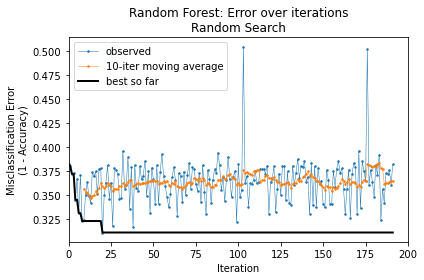

In [14]:
# convergence plot, RS
accs = np.array([x['mean_metric'] for x in rs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.close('all')
plt.figure()
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("Random Forest: Error over iterations\nRandom Search")
plt.xlim((0,200))
plt.legend()
plt.tight_layout()

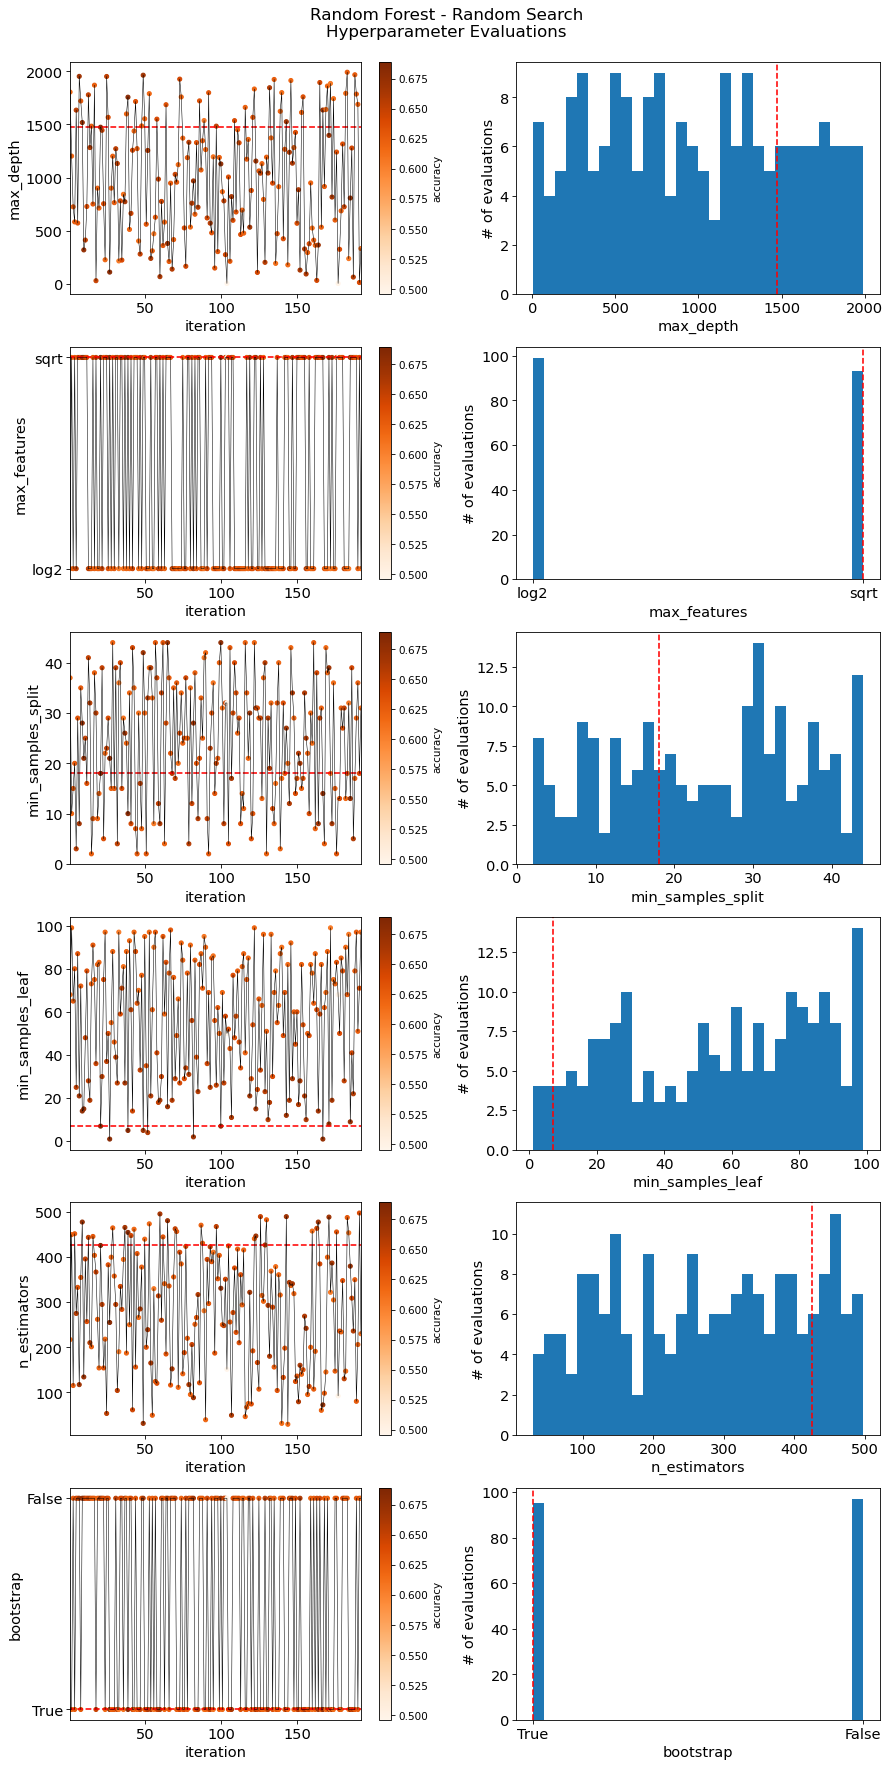

In [15]:
accs = np.array([x['mean_metric'] for x in rs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs


params = rs_hyperparameters.keys()
plt.figure(figsize=(12, 4*len(params)), dpi=75)

for i, param in enumerate(params):
    plt.subplot(len(params), 2, 2*i+1)
    param_vals = [x['params'][param] for x in rs_results]
    if type(param_vals[0]) == bool:
        param_vals = [str(x) for x in param_vals]
    best_val = rs.best_params_[param]

    plt.scatter(np.arange(1,len(param_vals)+1), param_vals, s=15, c=accs, cmap="Oranges", label="Accuracy")
    plt.plot(np.arange(1,len(param_vals)+1), param_vals, 'k', linewidth=0.5)
    plt.xlim(1, len(param_vals))
    plt.hlines(best_val, 0, len(param_vals), 'r', 'dashed')

    plt.ylabel(param, fontsize=14)
    plt.xlabel("iteration", fontsize=14)
    cb = plt.colorbar()
    cb.set_label("accuracy")
    plt.tick_params(labelsize=14)

    
    plt.subplot(len(params), 2, 2*i+2)
    plt.hist(param_vals, bins=30)
    plt.axvline(x=best_val, color='red', linestyle='--')
    plt.xlabel(param, fontsize=14)
    plt.ylabel('# of evaluations', fontsize=14)
    plt.tick_params(labelsize=14)
    
plt.suptitle("Random Forest - Random Search\nHyperparameter Evaluations", size=16)
plt.tight_layout(rect=[0, 0.0, 1, 0.98])

# Bayesian Search

In [5]:
bs_hyperparameters = {
    'max_depth': Integer(1, 2001),
    'max_features': Categorical(['sqrt', 'log2']),
    'min_samples_split': Integer(2, 45),
    'min_samples_leaf': Integer(1, 100),
    'n_estimators': Integer(25, 500),
    'bootstrap': Categorical([True, False])
}

N_EVALS = 192  # same as grid search above

In [6]:
def cb_print(result):
    ## to be called by BayesSearchCV fit() to print out each iteration
    
    # save progress at each iteration in case of error
    skopt.dump(result, 'tmp_bayes_result_{}.pkl'.format(datetime.now().strftime("%Y%m%d")))
    
    def stringify_params(params):
        # to take the list of hyperparameter values and get a dictionary back out
        params = point_asdict(bs_hyperparameters, params)
        return ', '.join([f'{k}={v}' if type(v) != str else f'{k}="{v}"' \
                          for k, v in params.items()])
    
    score = -(result.func_vals[-1])
    params = stringify_params(result.x_iters[-1])

    # argmin because the values are negative during search
    best_score_pos = np.argmin(result.func_vals)
    
    num_tried = len(result.func_vals)
    N = result.specs['args']['n_initial_points']

    the_time = datetime.now().strftime("%H:%M:%S")
    if best_score_pos == (num_tried - 1):
        print(f'***New best! [{the_time}] (Iter {num_tried}) Accuracy = {score} ({params})\n', flush=True)
    else:
        print(f'[{the_time}] (Iter {num_tried}) Accuracy = {score} ({params})', flush=True)
        best_params = stringify_params(result.x_iters[best_score_pos])
        print('    Best accuracy = {} ({})\n'.format(-result.func_vals[best_score_pos], best_params), flush=True)

In [7]:
clf = RandomForestClassifier(random_state=682, verbose=1, n_jobs=4)

print('\n--------------------------------------\nBeginning Bayes search at {}...'.format(datetime.now().strftime('%H:%M:%S')))

bayes = BayesSearchCV(
    estimator = clf,
    search_spaces = bs_hyperparameters,
    scoring = 'accuracy',
    cv = cv_folds,
    n_jobs = 1,
    n_iter = N_EVALS,
    refit = False,
    random_state = 682
)

early_stopper = DeltaYStopper(0.000001)
timercb = TimerCallback()
bayes_result = bayes.fit(x_train_4class, y_train_4class, callback=[timercb, cb_print, early_stopper])

# export both the results AND the fitted object
the_time = datetime.now().strftime("%Y%m%d_%H%M%S")
skopt.dump(bayes_result, 'randomforest_bayes_result_{}.pkl'.format(the_time))

with open(f'randomforest_bayes_timercb_{the_time}.pkl', 'wb') as f:
    pickle.dump(timercb, f)

print('Finished with Bayes search at {}\n\n\n'.format(datetime.now().strftime('%H:%M:%S')))

scores = bayes_result.cv_results_['mean_test_score']
param_keys = [x for x in bayes_result.cv_results_.keys() if 'param_' in x]
tmp = [bayes_result.cv_results_[x] for x in param_keys] + [scores]
tmp = list(map(list, zip(*tmp)))
tmp = [dict(zip(param_keys + ['mean_test_score'], x)) for x in tmp]
pd.DataFrame(tmp)


--------------------------------------
Beginning Bayes search at 14:26:20...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done  97 out of  97 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  97 out of  97 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  97 out of  97 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  97 out of  97 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  97

***New best! [14:26:43] (Iter 1) Accuracy = 0.6435 (bootstrap=False, max_depth=1731, max_features="log2", min_samples_leaf=33, min_samples_split=5, n_estimators=97)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 386 out of 393 | elapsed:    7.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 393 out of 393 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 393 out of 393 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 386 out of 393 | elapsed:    7.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 393 out of 393 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backen

[14:27:24] (Iter 2) Accuracy = 0.60705 (bootstrap=True, max_depth=171, max_features="log2", min_samples_leaf=92, min_samples_split=14, n_estimators=393)
    Best accuracy = 0.6435 (bootstrap=False, max_depth=1731, max_features="log2", min_samples_leaf=33, min_samples_split=5, n_estimators=97)



[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 393 out of 393 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 251 out of 251 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 251 out of 251 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 244 out of 251 | elapsed:    4.6s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 251 out of 251 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

[14:27:51] (Iter 3) Accuracy = 0.6102 (bootstrap=True, max_depth=1074, max_features="log2", min_samples_leaf=87, min_samples_split=37, n_estimators=251)
    Best accuracy = 0.6435 (bootstrap=False, max_depth=1731, max_features="log2", min_samples_leaf=33, min_samples_split=5, n_estimators=97)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 360 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 386 out of 386 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 386 out of 386 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 360 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 386 out of 386 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[14:28:34] (Iter 4) Accuracy = 0.6199 (bootstrap=True, max_depth=959, max_features="log2", min_samples_leaf=64, min_samples_split=31, n_estimators=386)
    Best accuracy = 0.6435 (bootstrap=False, max_depth=1731, max_features="log2", min_samples_leaf=33, min_samples_split=5, n_estimators=97)



[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 386 out of 386 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  

[14:28:43] (Iter 5) Accuracy = 0.618 (bootstrap=False, max_depth=214, max_features="log2", min_samples_leaf=75, min_samples_split=19, n_estimators=30)
    Best accuracy = 0.6435 (bootstrap=False, max_depth=1731, max_features="log2", min_samples_leaf=33, min_samples_split=5, n_estimators=97)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 407 out of 407 | elapsed:   33.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 407 out of 407 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.3s
[Parallel(n_jobs=4)]: Done 407 out of 407 | elapsed:   34.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[14:31:38] (Iter 6) Accuracy = 0.62655 (bootstrap=True, max_depth=1027, max_features="sqrt", min_samples_leaf=78, min_samples_split=30, n_estimators=407)
    Best accuracy = 0.6435 (bootstrap=False, max_depth=1731, max_features="log2", min_samples_leaf=33, min_samples_split=5, n_estimators=97)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   11.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:   11.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[14:32:39] (Iter 7) Accuracy = 0.626 (bootstrap=False, max_depth=1570, max_features="log2", min_samples_leaf=71, min_samples_split=10, n_estimators=334)
    Best accuracy = 0.6435 (bootstrap=False, max_depth=1731, max_features="log2", min_samples_leaf=33, min_samples_split=5, n_estimators=97)



[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   25.6s
[Parallel(n_jobs=4)]: Done 284 out of 284 | elapsed:   38.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 284 out of 284 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   25.7s
[Parallel(n_jobs=4)]: Done 284 out of 284 | elapsed:   38.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 con

[14:35:54] (Iter 8) Accuracy = 0.6304 (bootstrap=False, max_depth=161, max_features="sqrt", min_samples_leaf=96, min_samples_split=4, n_estimators=284)
    Best accuracy = 0.6435 (bootstrap=False, max_depth=1731, max_features="log2", min_samples_leaf=33, min_samples_split=5, n_estimators=97)



[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 284 out of 284 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 290 out of 290 | elapsed:   29.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 290 out of 290 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done 290 out of 290 | elapsed:   28.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 con

***New best! [14:38:20] (Iter 9) Accuracy = 0.644 (bootstrap=True, max_depth=1128, max_features="sqrt", min_samples_leaf=43, min_samples_split=34, n_estimators=290)



[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 290 out of 290 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 319 out of 326 | elapsed:    6.0s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 326 out of 326 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 326 out of 326 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 326 out of 326 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

[14:38:56] (Iter 10) Accuracy = 0.60395 (bootstrap=True, max_depth=1741, max_features="log2", min_samples_leaf=99, min_samples_split=15, n_estimators=326)
    Best accuracy = 0.644 (bootstrap=True, max_depth=1128, max_features="sqrt", min_samples_leaf=43, min_samples_split=34, n_estimators=290)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.6s
[Parallel(n_jobs=4)]: Done 416 out of 416 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 416 out of 416 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.5s
[Parallel(n_jobs=4)]: Done 416 out of 416 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

***New best! [14:48:16] (Iter 11) Accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 493 out of 500 | elapsed:    9.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    9.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    9.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend 

[14:49:11] (Iter 12) Accuracy = 0.384 (bootstrap=False, max_depth=1, max_features="sqrt", min_samples_leaf=1, min_samples_split=45, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[14:49:40] (Iter 13) Accuracy = 0.65095 (bootstrap=True, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=25)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done  52 out of  52 | elapsed:   13.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  52 out of  52 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done  52 out of  52 | elapsed:   14.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  52 out of  52 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done  52

[14:50:56] (Iter 14) Accuracy = 0.68455 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=52)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.2min finished
[Parallel(n

[14:57:17] (Iter 15) Accuracy = 0.67205 (bootstrap=True, max_depth=47, max_features="sqrt", min_samples_leaf=1, min_samples_split=45, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   49.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   49.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.1min finished
[Parallel(n

[15:08:08] (Iter 16) Accuracy = 0.69765 (bootstrap=False, max_depth=1076, max_features="sqrt", min_samples_leaf=1, min_samples_split=12, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Usi

[15:08:16] (Iter 17) Accuracy = 0.3772 (bootstrap=True, max_depth=1, max_features="sqrt", min_samples_leaf=1, min_samples_split=19, n_estimators=25)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   34.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   39.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   35.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   39.5s finished
[Parallel(n

[15:11:41] (Iter 18) Accuracy = 0.6209 (bootstrap=True, max_depth=1940, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   48.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   48.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.1min finished
[Parallel(n

[15:22:18] (Iter 19) Accuracy = 0.6931 (bootstrap=False, max_depth=1403, max_features="sqrt", min_samples_leaf=1, min_samples_split=19, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    6.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[15:22:58] (Iter 20) Accuracy = 0.66655 (bootstrap=False, max_depth=287, max_features="sqrt", min_samples_leaf=1, min_samples_split=26, n_estimators=25)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    9.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    9.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 

[15:23:52] (Iter 21) Accuracy = 0.384 (bootstrap=False, max_depth=1, max_features="sqrt", min_samples_leaf=1, min_samples_split=5, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done 189 out of 189 | elapsed:   45.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 189 out of 189 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=4)]: Done 189 out of 189 | elapsed:   45.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 189 out of 189 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done 189

[15:27:47] (Iter 22) Accuracy = 0.6854 (bootstrap=False, max_depth=766, max_features="sqrt", min_samples_leaf=1, min_samples_split=32, n_estimators=189)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   26.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   26.1s finished
[Parallel(n

[15:30:06] (Iter 23) Accuracy = 0.67475 (bootstrap=False, max_depth=2001, max_features="log2", min_samples_leaf=1, min_samples_split=34, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.7s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   49.8s
[Parallel(n_jobs=4)]: Done 266 out of 266 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[15:36:00] (Iter 24) Accuracy = 0.7004 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=6, n_estimators=266)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   49.1s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   48.3s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[15:43:07] (Iter 25) Accuracy = 0.6937 (bootstrap=False, max_depth=1205, max_features="sqrt", min_samples_leaf=1, min_samples_split=17, n_estimators=331)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.2min finished
[Parallel(n

[15:49:25] (Iter 26) Accuracy = 0.67085 (bootstrap=True, max_depth=1529, max_features="sqrt", min_samples_leaf=1, min_samples_split=44, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[15:50:06] (Iter 27) Accuracy = 0.66475 (bootstrap=False, max_depth=945, max_features="sqrt", min_samples_leaf=1, min_samples_split=18, n_estimators=25)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   25.1s
[Parallel(n_jobs=4)]: Done 342 out of 342 | elapsed:   44.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 342 out of 342 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   25.6s
[Parallel(n_jobs=4)]: Done 342 out of 342 | elapsed:   45.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[15:53:58] (Iter 28) Accuracy = 0.63055 (bootstrap=False, max_depth=792, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=342)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.0s
[Parallel(n_jobs=4)]: Done 362 out of 362 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 362 out of 362 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.1s
[Parallel(n_jobs=4)]: Done 362 out of 362 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[16:01:57] (Iter 29) Accuracy = 0.70165 (bootstrap=False, max_depth=1848, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=362)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.8s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:   49.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.9s
[Parallel(n_jobs=4)]: Done 341 out of 341 | elapsed:   50.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[16:06:17] (Iter 30) Accuracy = 0.67105 (bootstrap=True, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=45, n_estimators=341)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[16:06:42] (Iter 31) Accuracy = 0.6227 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=100, min_samples_split=33, n_estimators=25)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 314 out of 314 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 314 out of 314 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.1s
[Parallel(n_jobs=4)]: Done 314 out of 314 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[16:13:46] (Iter 32) Accuracy = 0.70165 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=314)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n

[16:20:49] (Iter 33) Accuracy = 0.68985 (bootstrap=True, max_depth=650, max_features="sqrt", min_samples_leaf=1, min_samples_split=14, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   25.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   58.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   25.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   59.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n

[16:26:30] (Iter 34) Accuracy = 0.63095 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:   24.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:   24.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 161 out of 161 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 161

[16:28:40] (Iter 35) Accuracy = 0.6702 (bootstrap=True, max_depth=1517, max_features="sqrt", min_samples_leaf=1, min_samples_split=45, n_estimators=161)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 412 out of 412 | elapsed:   25.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 412 out of 412 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 412 out of 412 | elapsed:   25.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[16:30:55] (Iter 36) Accuracy = 0.69435 (bootstrap=False, max_depth=1056, max_features="log2", min_samples_leaf=1, min_samples_split=2, n_estimators=412)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[16:31:13] (Iter 37) Accuracy = 0.612 (bootstrap=True, max_depth=2001, max_features="sqrt", min_samples_leaf=100, min_samples_split=45, n_estimators=25)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 175 out of 175 | elapsed:   46.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 175 out of 175 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 175 out of 175 | elapsed:   46.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 175 out of 175 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 175

[16:35:14] (Iter 38) Accuracy = 0.6982 (bootstrap=False, max_depth=302, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=175)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 127 out of 134 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 134 out of 134 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 134 out of 134 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 134 out of 134 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 134 out of 134 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n

[16:35:34] (Iter 39) Accuracy = 0.38245 (bootstrap=False, max_depth=1, max_features="sqrt", min_samples_leaf=1, min_samples_split=45, n_estimators=134)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Done 134 out of 134 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBacke

[16:35:46] (Iter 40) Accuracy = 0.60995 (bootstrap=False, max_depth=327, max_features="log2", min_samples_leaf=100, min_samples_split=25, n_estimators=25)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   38.2s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   39.0s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[16:41:18] (Iter 41) Accuracy = 0.67475 (bootstrap=False, max_depth=1822, max_features="sqrt", min_samples_leaf=9, min_samples_split=44, n_estimators=322)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  28 out of  28 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  28 out of  28 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  28 out of  28 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  28 out of  2

[16:41:29] (Iter 42) Accuracy = 0.6091 (bootstrap=True, max_depth=1848, max_features="log2", min_samples_leaf=71, min_samples_split=41, n_estimators=28)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 246 out of 246 | elapsed:    9.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 246 out of 246 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 246 out of 246 | elapsed:    9.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[16:42:26] (Iter 43) Accuracy = 0.6768 (bootstrap=True, max_depth=1069, max_features="log2", min_samples_leaf=1, min_samples_split=11, n_estimators=246)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   23.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   26.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   23.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   26.3s finished
[Parallel(n

[16:44:48] (Iter 44) Accuracy = 0.67475 (bootstrap=False, max_depth=1842, max_features="log2", min_samples_leaf=1, min_samples_split=34, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[16:45:28] (Iter 45) Accuracy = 0.67495 (bootstrap=False, max_depth=1855, max_features="sqrt", min_samples_leaf=5, min_samples_split=10, n_estimators=25)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[16:56:43] (Iter 46) Accuracy = 0.7034 (bootstrap=False, max_depth=462, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done 468 out of 468 | elapsed:   15.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 468 out of 468 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done 468 out of 468 | elapsed:   15.7s finished
[Parallel(n

[16:58:11] (Iter 47) Accuracy = 0.66145 (bootstrap=True, max_depth=478, max_features="log2", min_samples_leaf=1, min_samples_split=39, n_estimators=468)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.8s
[Parallel(n_jobs=4)]: Done 258 out of 258 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 258 out of 258 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.7s
[Parallel(n_jobs=4)]: Done 258 out of 258 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[17:04:04] (Iter 48) Accuracy = 0.70205 (bootstrap=False, max_depth=394, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=258)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   48.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 483 out of 483 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 483 out of 483 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   48.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 483 out of 483 | elapsed:  2.0min finished
[Parallel(n

[17:14:19] (Iter 49) Accuracy = 0.6911 (bootstrap=False, max_depth=451, max_features="sqrt", min_samples_leaf=1, min_samples_split=23, n_estimators=483)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.8s
[Parallel(n_jobs=4)]: Done 264 out of 264 | elapsed:   45.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 264 out of 264 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.4s
[Parallel(n_jobs=4)]: Done 264 out of 264 | elapsed:   45.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[17:18:15] (Iter 50) Accuracy = 0.69015 (bootstrap=True, max_depth=315, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=264)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   45.2s
[Parallel(n_jobs=4)]: Done 213 out of 213 | elapsed:   50.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 out of 213 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   45.6s
[Parallel(n_jobs=4)]: Done 213 out of 213 | elapsed:   50.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[17:22:37] (Iter 51) Accuracy = 0.6774 (bootstrap=False, max_depth=371, max_features="sqrt", min_samples_leaf=1, min_samples_split=43, n_estimators=213)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   41.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   41.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.8min finished
[Parallel(n

[17:31:46] (Iter 52) Accuracy = 0.6874 (bootstrap=False, max_depth=1060, max_features="sqrt", min_samples_leaf=7, min_samples_split=23, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   30.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   29.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.3min finished
[Parallel(n

[17:38:25] (Iter 53) Accuracy = 0.6772 (bootstrap=True, max_depth=67, max_features="sqrt", min_samples_leaf=1, min_samples_split=33, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[17:38:43] (Iter 54) Accuracy = 0.65815 (bootstrap=False, max_depth=402, max_features="log2", min_samples_leaf=1, min_samples_split=4, n_estimators=25)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n

[17:45:40] (Iter 55) Accuracy = 0.65435 (bootstrap=False, max_depth=461, max_features="sqrt", min_samples_leaf=40, min_samples_split=19, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   49.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 466 out of 466 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 466 out of 466 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   49.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 466 out of 466 | elapsed:  2.0min finished
[Parallel(n

[17:55:54] (Iter 56) Accuracy = 0.697 (bootstrap=False, max_depth=1435, max_features="sqrt", min_samples_leaf=1, min_samples_split=13, n_estimators=466)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  38 out of  38 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  38 out of  38 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  38 out of  38 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  38 out of  38 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  38 out of  38 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  38 out of  38 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  38 out of  3

[17:56:08] (Iter 57) Accuracy = 0.6255 (bootstrap=True, max_depth=1421, max_features="log2", min_samples_leaf=38, min_samples_split=23, n_estimators=38)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   41.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   41.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.8min finished
[Parallel(n

[18:05:19] (Iter 58) Accuracy = 0.6879 (bootstrap=False, max_depth=390, max_features="sqrt", min_samples_leaf=8, min_samples_split=7, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  46 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 out of  4

[18:05:37] (Iter 59) Accuracy = 0.6496 (bootstrap=True, max_depth=1233, max_features="log2", min_samples_leaf=1, min_samples_split=35, n_estimators=46)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   46.5s
[Parallel(n_jobs=4)]: Done 352 out of 352 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 352 out of 352 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   47.1s
[Parallel(n_jobs=4)]: Done 352 out of 352 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[18:12:55] (Iter 60) Accuracy = 0.6864 (bootstrap=False, max_depth=1174, max_features="sqrt", min_samples_leaf=1, min_samples_split=33, n_estimators=352)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n

[18:20:11] (Iter 61) Accuracy = 0.66165 (bootstrap=False, max_depth=1193, max_features="sqrt", min_samples_leaf=32, min_samples_split=13, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.2s
[Parallel(n_jobs=4)]: Done 421 out of 421 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 421 out of 421 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.6s
[Parallel(n_jobs=4)]: Done 421 out of 421 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[18:26:09] (Iter 62) Accuracy = 0.68725 (bootstrap=True, max_depth=681, max_features="sqrt", min_samples_leaf=1, min_samples_split=15, n_estimators=421)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 495 out of 495 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 495 out of 495 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 495 out of 495 | elapsed:  1.3min finished
[Parallel(n

[18:33:04] (Iter 63) Accuracy = 0.6566 (bootstrap=False, max_depth=664, max_features="sqrt", min_samples_leaf=38, min_samples_split=42, n_estimators=495)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   46.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   45.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.0min finished
[Parallel(n

[18:43:15] (Iter 64) Accuracy = 0.68555 (bootstrap=False, max_depth=1420, max_features="sqrt", min_samples_leaf=1, min_samples_split=35, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   30.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.3min finished
[Parallel(n

[18:50:05] (Iter 65) Accuracy = 0.6819 (bootstrap=True, max_depth=1470, max_features="sqrt", min_samples_leaf=1, min_samples_split=25, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n

[18:57:23] (Iter 66) Accuracy = 0.6938 (bootstrap=True, max_depth=293, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 433 out of 433 | elapsed:   16.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 433 out of 433 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 433 out of 433 | elapsed:   16.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[18:58:57] (Iter 67) Accuracy = 0.67755 (bootstrap=True, max_depth=727, max_features="log2", min_samples_leaf=1, min_samples_split=11, n_estimators=433)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[19:10:14] (Iter 68) Accuracy = 0.7034 (bootstrap=False, max_depth=795, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[19:10:47] (Iter 69) Accuracy = 0.65095 (bootstrap=True, max_depth=509, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=25)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[19:11:02] (Iter 70) Accuracy = 0.6437 (bootstrap=True, max_depth=797, max_features="log2", min_samples_leaf=1, min_samples_split=19, n_estimators=25)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   48.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 494 out of 494 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 494 out of 494 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   49.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 494 out of 494 | elapsed:  2.1min finished
[Parallel(n

[19:21:46] (Iter 71) Accuracy = 0.6942 (bootstrap=False, max_depth=1363, max_features="sqrt", min_samples_leaf=1, min_samples_split=21, n_estimators=494)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   39.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   39.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.7min finished
[Parallel(n

[19:30:26] (Iter 72) Accuracy = 0.6788 (bootstrap=False, max_depth=786, max_features="sqrt", min_samples_leaf=13, min_samples_split=4, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   53.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   54.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[19:35:05] (Iter 73) Accuracy = 0.6991 (bootstrap=False, max_depth=1389, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=200)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[19:46:26] (Iter 74) Accuracy = 0.7034 (bootstrap=False, max_depth=623, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[19:46:59] (Iter 75) Accuracy = 0.65455 (bootstrap=True, max_depth=622, max_features="sqrt", min_samples_leaf=1, min_samples_split=6, n_estimators=25)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n

[19:54:21] (Iter 76) Accuracy = 0.6938 (bootstrap=True, max_depth=1170, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[20:05:40] (Iter 77) Accuracy = 0.7034 (bootstrap=False, max_depth=1648, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n

[20:13:03] (Iter 78) Accuracy = 0.6938 (bootstrap=True, max_depth=947, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.3s
[Parallel(n_jobs=4)]: Done 293 out of 293 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 293 out of 293 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.2s
[Parallel(n_jobs=4)]: Done 293 out of 293 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[20:19:49] (Iter 79) Accuracy = 0.70125 (bootstrap=False, max_depth=1577, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=293)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   36.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   40.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   40.5s finished
[Parallel(n

[20:23:24] (Iter 80) Accuracy = 0.6209 (bootstrap=True, max_depth=543, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.7s
[Parallel(n_jobs=4)]: Done 357 out of 357 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 out of 357 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.8s
[Parallel(n_jobs=4)]: Done 357 out of 357 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[20:31:37] (Iter 81) Accuracy = 0.70165 (bootstrap=False, max_depth=935, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=357)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   44.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   45.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.0min finished
[Parallel(n

[20:41:42] (Iter 82) Accuracy = 0.6793 (bootstrap=False, max_depth=886, max_features="sqrt", min_samples_leaf=1, min_samples_split=45, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.0s
[Parallel(n_jobs=4)]: Done 351 out of 351 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 351 out of 351 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 351 out of 351 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[20:49:48] (Iter 83) Accuracy = 0.70165 (bootstrap=False, max_depth=648, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=351)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   29.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   29.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.3min finished
[Parallel(n

[20:56:18] (Iter 84) Accuracy = 0.67205 (bootstrap=True, max_depth=208, max_features="sqrt", min_samples_leaf=1, min_samples_split=45, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.0s
[Parallel(n_jobs=4)]: Done 344 out of 344 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 344 out of 344 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.9s
[Parallel(n_jobs=4)]: Done 344 out of 344 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[21:04:16] (Iter 85) Accuracy = 0.7021 (bootstrap=False, max_depth=374, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=344)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.4min finished
[Parallel(n

[21:11:40] (Iter 86) Accuracy = 0.6938 (bootstrap=True, max_depth=1790, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.2s
[Parallel(n_jobs=4)]: Done 299 out of 299 | elapsed:   51.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 299 out of 299 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.8s
[Parallel(n_jobs=4)]: Done 299 out of 299 | elapsed:   52.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[21:16:11] (Iter 87) Accuracy = 0.6906 (bootstrap=True, max_depth=1658, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=299)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.7s finished
[Parallel(n

[21:18:05] (Iter 88) Accuracy = 0.6865 (bootstrap=True, max_depth=2001, max_features="log2", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 451 out of 451 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 451 out of 451 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 451 out of 451 | elapsed:  2.0min finished
[Parallel(n

[21:28:24] (Iter 89) Accuracy = 0.70325 (bootstrap=False, max_depth=1898, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=451)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.1s
[Parallel(n_jobs=4)]: Done 342 out of 342 | elapsed:   59.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 342 out of 342 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.7s
[Parallel(n_jobs=4)]: Done 342 out of 342 | elapsed:   59.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[21:33:32] (Iter 90) Accuracy = 0.6915 (bootstrap=True, max_depth=462, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=342)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[21:34:20] (Iter 91) Accuracy = 0.66735 (bootstrap=False, max_depth=1496, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=25)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.3s
[Parallel(n_jobs=4)]: Done 339 out of 339 | elapsed:   58.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 339 out of 339 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.6s
[Parallel(n_jobs=4)]: Done 339 out of 339 | elapsed:   59.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[21:39:26] (Iter 92) Accuracy = 0.6915 (bootstrap=True, max_depth=1344, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=339)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.1s
[Parallel(n_jobs=4)]: Done 365 out of 365 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 365 out of 365 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 365 out of 365 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[21:47:50] (Iter 93) Accuracy = 0.70165 (bootstrap=False, max_depth=1346, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=365)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[21:48:39] (Iter 94) Accuracy = 0.66735 (bootstrap=False, max_depth=1217, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=25)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[21:49:14] (Iter 95) Accuracy = 0.65095 (bootstrap=True, max_depth=1041, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=25)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 365 out of 365 | elapsed:   14.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 365 out of 365 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 365 out of 365 | elapsed:   14.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[21:50:41] (Iter 96) Accuracy = 0.68625 (bootstrap=True, max_depth=1838, max_features="log2", min_samples_leaf=1, min_samples_split=2, n_estimators=365)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[22:02:07] (Iter 97) Accuracy = 0.7034 (bootstrap=False, max_depth=1544, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.8s
[Parallel(n_jobs=4)]: Done 330 out of 330 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 out of 330 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 330 out of 330 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[22:09:44] (Iter 98) Accuracy = 0.70235 (bootstrap=False, max_depth=359, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=330)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.9s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.0s
[Parallel(n_jobs=4)]: Done 334 out of 334 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[22:17:25] (Iter 99) Accuracy = 0.7021 (bootstrap=False, max_depth=361, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=334)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   35.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   40.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   36.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   40.8s finished
[Parallel(n

[22:21:01] (Iter 100) Accuracy = 0.6209 (bootstrap=True, max_depth=1344, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.8s
[Parallel(n_jobs=4)]: Done 403 out of 403 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 403 out of 403 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 403 out of 403 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[22:30:18] (Iter 101) Accuracy = 0.7033 (bootstrap=False, max_depth=373, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=403)
    Best accuracy = 0.70355 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=416)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.3s
[Parallel(n_jobs=4)]: Done 398 out of 398 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 398 out of 398 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 398 out of 398 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

***New best! [22:39:22] (Iter 102) Accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   17.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   19.7s finished
[Parallel(n

[22:41:14] (Iter 103) Accuracy = 0.6865 (bootstrap=True, max_depth=137, max_features="log2", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.9s
[Parallel(n_jobs=4)]: Done 376 out of 376 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 376 out of 376 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.2s
[Parallel(n_jobs=4)]: Done 376 out of 376 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[22:49:52] (Iter 104) Accuracy = 0.702 (bootstrap=False, max_depth=1480, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=376)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.3s finished
[Parallel(n

[22:51:47] (Iter 105) Accuracy = 0.6865 (bootstrap=True, max_depth=1670, max_features="log2", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.1s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[22:59:13] (Iter 106) Accuracy = 0.7021 (bootstrap=False, max_depth=1056, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=322)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.6s
[Parallel(n_jobs=4)]: Done 326 out of 326 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 326 out of 326 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 326 out of 326 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[23:06:44] (Iter 107) Accuracy = 0.702 (bootstrap=False, max_depth=793, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=326)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 

[23:07:31] (Iter 108) Accuracy = 0.38655 (bootstrap=True, max_depth=1, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:   31.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.4s
[Parallel(n_jobs=4)]: Done 331 out of 331 | elapsed:   31.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[23:10:23] (Iter 109) Accuracy = 0.6392 (bootstrap=True, max_depth=341, max_features="sqrt", min_samples_leaf=48, min_samples_split=2, n_estimators=331)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 out of  65 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  65 out of  65 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  65 out of  65 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 out of  65 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  65 out of  65 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  65 out of  65 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 out of  65 | elapsed: 

[23:10:43] (Iter 110) Accuracy = 0.6009 (bootstrap=True, max_depth=377, max_features="log2", min_samples_leaf=100, min_samples_split=2, n_estimators=65)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   34.6s
[Parallel(n_jobs=4)]: Done 393 out of 393 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 393 out of 393 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   34.3s
[Parallel(n_jobs=4)]: Done 393 out of 393 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[23:16:47] (Iter 111) Accuracy = 0.6644 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=27, min_samples_split=2, n_estimators=393)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[23:17:18] (Iter 112) Accuracy = 0.6227 (bootstrap=False, max_depth=1272, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=25)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   59.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n

[23:23:13] (Iter 113) Accuracy = 0.63095 (bootstrap=False, max_depth=522, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   60.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n

[23:29:04] (Iter 114) Accuracy = 0.63095 (bootstrap=False, max_depth=1140, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   45.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   51.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   45.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   51.5s finished
[Parallel(n

[23:33:37] (Iter 115) Accuracy = 0.64955 (bootstrap=True, max_depth=2001, max_features="sqrt", min_samples_leaf=33, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[23:33:56] (Iter 116) Accuracy = 0.64095 (bootstrap=True, max_depth=1696, max_features="log2", min_samples_leaf=1, min_samples_split=2, n_estimators=25)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[23:34:28] (Iter 117) Accuracy = 0.6227 (bootstrap=False, max_depth=1703, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=25)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   20.3s finished
[Parallel(n

[23:36:25] (Iter 118) Accuracy = 0.6865 (bootstrap=True, max_depth=1305, max_features="log2", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   29.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   29.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.3min finished
[Parallel(n

[23:42:56] (Iter 119) Accuracy = 0.67205 (bootstrap=True, max_depth=1049, max_features="sqrt", min_samples_leaf=1, min_samples_split=45, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   45.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   51.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   45.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   51.5s finished
[Parallel(n

[23:47:30] (Iter 120) Accuracy = 0.6495 (bootstrap=True, max_depth=1542, max_features="sqrt", min_samples_leaf=34, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 360 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    9.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 360 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    9.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 

[23:48:32] (Iter 121) Accuracy = 0.60455 (bootstrap=True, max_depth=322, max_features="log2", min_samples_leaf=100, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[23:48:57] (Iter 122) Accuracy = 0.612 (bootstrap=True, max_depth=761, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=25)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   30.6s
[Parallel(n_jobs=4)]: Done 241 out of 241 | elapsed:   38.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 241 out of 241 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   30.3s
[Parallel(n_jobs=4)]: Done 241 out of 241 | elapsed:   38.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[23:52:22] (Iter 123) Accuracy = 0.64845 (bootstrap=False, max_depth=287, max_features="sqrt", min_samples_leaf=51, min_samples_split=2, n_estimators=241)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[23:52:54] (Iter 124) Accuracy = 0.6227 (bootstrap=False, max_depth=985, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=25)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[23:53:44] (Iter 125) Accuracy = 0.66735 (bootstrap=False, max_depth=696, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=25)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   59.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n

[23:59:37] (Iter 126) Accuracy = 0.63095 (bootstrap=False, max_depth=1750, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   36.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   40.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   40.4s finished
[Parallel(n

[00:03:11] (Iter 127) Accuracy = 0.6209 (bootstrap=True, max_depth=799, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:   12.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 322 out of 322 | elapsed:   13.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[00:04:31] (Iter 128) Accuracy = 0.68585 (bootstrap=True, max_depth=1494, max_features="log2", min_samples_leaf=1, min_samples_split=2, n_estimators=322)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.5s
[Parallel(n_jobs=4)]: Done 329 out of 329 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 329 out of 329 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.5s
[Parallel(n_jobs=4)]: Done 329 out of 329 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[00:12:07] (Iter 129) Accuracy = 0.70245 (bootstrap=False, max_depth=1937, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=329)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.6s
[Parallel(n_jobs=4)]: Done 329 out of 329 | elapsed:   56.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 329 out of 329 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.7s
[Parallel(n_jobs=4)]: Done 329 out of 329 | elapsed:   56.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[00:17:05] (Iter 130) Accuracy = 0.69165 (bootstrap=True, max_depth=869, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=329)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[00:28:27] (Iter 131) Accuracy = 0.7034 (bootstrap=False, max_depth=1236, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 166 out of 166 | elapsed:   27.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 166 out of 166 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 166 out of 166 | elapsed:   27.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 166 out of 166 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 166

[00:30:59] (Iter 132) Accuracy = 0.65085 (bootstrap=False, max_depth=1032, max_features="sqrt", min_samples_leaf=41, min_samples_split=2, n_estimators=166)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   27.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   30.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   27.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   31.2s finished
[Parallel(n

[00:33:51] (Iter 133) Accuracy = 0.695 (bootstrap=False, max_depth=702, max_features="log2", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[00:34:17] (Iter 134) Accuracy = 0.612 (bootstrap=True, max_depth=1468, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=25)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   59.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   60.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n

[00:40:11] (Iter 135) Accuracy = 0.63095 (bootstrap=False, max_depth=1413, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   46.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   52.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   46.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   52.3s finished
[Parallel(n

[00:44:49] (Iter 136) Accuracy = 0.65295 (bootstrap=True, max_depth=690, max_features="sqrt", min_samples_leaf=31, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   25.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   58.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n

[00:50:43] (Iter 137) Accuracy = 0.63095 (bootstrap=False, max_depth=269, max_features="sqrt", min_samples_leaf=100, min_samples_split=45, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[00:51:17] (Iter 138) Accuracy = 0.6227 (bootstrap=False, max_depth=682, max_features="sqrt", min_samples_leaf=100, min_samples_split=45, n_estimators=25)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.1s
[Parallel(n_jobs=4)]: Done 426 out of 426 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 426 out of 426 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.7s
[Parallel(n_jobs=4)]: Done 426 out of 426 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[00:57:42] (Iter 139) Accuracy = 0.69335 (bootstrap=True, max_depth=1931, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=426)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   16.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   16.8s finished
[Parallel(n

[00:59:23] (Iter 140) Accuracy = 0.65675 (bootstrap=True, max_depth=1904, max_features="log2", min_samples_leaf=1, min_samples_split=45, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[01:10:50] (Iter 141) Accuracy = 0.7034 (bootstrap=False, max_depth=2001, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.9s
[Parallel(n_jobs=4)]: Done 409 out of 409 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 409 out of 409 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.5s
[Parallel(n_jobs=4)]: Done 409 out of 409 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[01:20:17] (Iter 142) Accuracy = 0.70365 (bootstrap=False, max_depth=1615, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=409)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   36.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n

[01:28:12] (Iter 143) Accuracy = 0.66995 (bootstrap=False, max_depth=1597, max_features="sqrt", min_samples_leaf=22, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   28.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.2min finished
[Parallel(n

[01:34:41] (Iter 144) Accuracy = 0.67205 (bootstrap=True, max_depth=103, max_features="sqrt", min_samples_leaf=1, min_samples_split=45, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed:   21.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed:   21.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 135

[01:36:43] (Iter 145) Accuracy = 0.64745 (bootstrap=False, max_depth=633, max_features="sqrt", min_samples_leaf=49, min_samples_split=2, n_estimators=135)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[01:37:02] (Iter 146) Accuracy = 0.3773 (bootstrap=False, max_depth=1, max_features="sqrt", min_samples_leaf=100, min_samples_split=2, n_estimators=25)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.6s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[01:46:03] (Iter 147) Accuracy = 0.7035 (bootstrap=False, max_depth=522, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=395)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[01:57:26] (Iter 148) Accuracy = 0.7034 (bootstrap=False, max_depth=994, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 459 out of 459 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 459 out of 459 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 459 out of 459 | elapsed:  2.0min finished
[Parallel(n

[02:07:51] (Iter 149) Accuracy = 0.70315 (bootstrap=False, max_depth=716, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=459)
    Best accuracy = 0.70375 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=398)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 412 out of 412 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 412 out of 412 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.7s
[Parallel(n_jobs=4)]: Done 412 out of 412 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

***New best! [02:17:19] (Iter 150) Accuracy = 0.70415 (bootstrap=False, max_depth=1017, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=412)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 255 out of 255 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 255 out of 255 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.7s
[Parallel(n_jobs=4)]: Done 255 out of 255 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[02:23:17] (Iter 151) Accuracy = 0.70135 (bootstrap=False, max_depth=1717, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=255)
    Best accuracy = 0.70415 (bootstrap=False, max_depth=1017, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=412)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.5s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.7s
[Parallel(n_jobs=4)]: Done 395 out of 395 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[02:29:12] (Iter 152) Accuracy = 0.69155 (bootstrap=True, max_depth=588, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=395)
    Best accuracy = 0.70415 (bootstrap=False, max_depth=1017, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=412)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[02:40:39] (Iter 153) Accuracy = 0.7034 (bootstrap=False, max_depth=1775, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70415 (bootstrap=False, max_depth=1017, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=412)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.9s
[Parallel(n_jobs=4)]: Done 248 out of 248 | elapsed:   34.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 248 out of 248 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.1s
[Parallel(n_jobs=4)]: Done 248 out of 248 | elapsed:   35.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[02:43:52] (Iter 154) Accuracy = 0.6361 (bootstrap=False, max_depth=377, max_features="sqrt", min_samples_leaf=82, min_samples_split=2, n_estimators=248)
    Best accuracy = 0.70415 (bootstrap=False, max_depth=1017, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=412)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 167 out of 167 | elapsed:   27.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 167 out of 167 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 167 out of 167 | elapsed:   27.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 167 out of 167 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 167

[02:46:27] (Iter 155) Accuracy = 0.6526 (bootstrap=False, max_depth=1381, max_features="sqrt", min_samples_leaf=40, min_samples_split=7, n_estimators=167)
    Best accuracy = 0.70415 (bootstrap=False, max_depth=1017, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=412)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.2s
[Parallel(n_jobs=4)]: Done 365 out of 365 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 365 out of 365 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.2s
[Parallel(n_jobs=4)]: Done 365 out of 365 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[02:54:47] (Iter 156) Accuracy = 0.70165 (bootstrap=False, max_depth=1665, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=365)
    Best accuracy = 0.70415 (bootstrap=False, max_depth=1017, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=412)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.1s
[Parallel(n_jobs=4)]: Done 313 out of 313 | elapsed:   51.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 313 out of 313 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.7s
[Parallel(n_jobs=4)]: Done 313 out of 313 | elapsed:   51.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[02:59:25] (Iter 157) Accuracy = 0.68745 (bootstrap=True, max_depth=1176, max_features="sqrt", min_samples_leaf=1, min_samples_split=14, n_estimators=313)
    Best accuracy = 0.70415 (bootstrap=False, max_depth=1017, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=412)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[03:10:51] (Iter 158) Accuracy = 0.7034 (bootstrap=False, max_depth=1299, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.70415 (bootstrap=False, max_depth=1017, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=412)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.9s
[Parallel(n_jobs=4)]: Done 427 out of 427 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 427 out of 427 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.6s
[Parallel(n_jobs=4)]: Done 427 out of 427 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

***New best! [03:20:44] (Iter 159) Accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.6s
[Parallel(n_jobs=4)]: Done 393 out of 393 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 393 out of 393 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 393 out of 393 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[03:29:49] (Iter 160) Accuracy = 0.70335 (bootstrap=False, max_depth=444, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=393)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[03:30:15] (Iter 161) Accuracy = 0.6504 (bootstrap=False, max_depth=921, max_features="log2", min_samples_leaf=1, min_samples_split=45, n_estimators=25)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done 313 out of 313 | elapsed:   25.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 313 out of 313 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done 313 out of 313 | elapsed:   25.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[03:32:39] (Iter 162) Accuracy = 0.619 (bootstrap=True, max_depth=652, max_features="sqrt", min_samples_leaf=100, min_samples_split=45, n_estimators=313)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[03:44:09] (Iter 163) Accuracy = 0.7034 (bootstrap=False, max_depth=545, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  2

[03:44:51] (Iter 164) Accuracy = 0.65095 (bootstrap=True, max_depth=1426, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=25)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done 259 out of 259 | elapsed:   35.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 259 out of 259 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done 259 out of 259 | elapsed:   35.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[03:48:06] (Iter 165) Accuracy = 0.6302 (bootstrap=False, max_depth=1253, max_features="sqrt", min_samples_leaf=99, min_samples_split=45, n_estimators=259)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 433 out of 433 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 433 out of 433 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 433 out of 433 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[03:58:07] (Iter 166) Accuracy = 0.7036 (bootstrap=False, max_depth=1054, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=433)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[04:09:32] (Iter 167) Accuracy = 0.7034 (bootstrap=False, max_depth=1156, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.4s
[Parallel(n_jobs=4)]: Done 365 out of 365 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 365 out of 365 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.6s
[Parallel(n_jobs=4)]: Done 365 out of 365 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[04:17:56] (Iter 168) Accuracy = 0.70165 (bootstrap=False, max_depth=1766, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=365)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[04:29:27] (Iter 169) Accuracy = 0.7034 (bootstrap=False, max_depth=1941, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done 214 out of 214 | elapsed:   19.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 214 out of 214 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.9s
[Parallel(n_jobs=4)]: Done 214 out of 214 | elapsed:   19.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[04:31:27] (Iter 170) Accuracy = 0.63605 (bootstrap=True, max_depth=1989, max_features="sqrt", min_samples_leaf=57, min_samples_split=6, n_estimators=214)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done  58 out of  58 | elapsed:    8.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  58 out of  58 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done  58 out of  58 | elapsed:    8.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  58 out of  58 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done  58

[04:32:28] (Iter 171) Accuracy = 0.63045 (bootstrap=False, max_depth=1520, max_features="sqrt", min_samples_leaf=91, min_samples_split=45, n_estimators=58)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[04:43:57] (Iter 172) Accuracy = 0.7034 (bootstrap=False, max_depth=689, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   43.3s
[Parallel(n_jobs=4)]: Done 480 out of 480 | elapsed:   47.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 480 out of 480 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   43.9s
[Parallel(n_jobs=4)]: Done 480 out of 480 | elapsed:   47.5s finished
[Parallel(n

[04:48:15] (Iter 173) Accuracy = 0.64455 (bootstrap=True, max_depth=1294, max_features="sqrt", min_samples_leaf=42, min_samples_split=4, n_estimators=480)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done 247 out of 247 | elapsed:   33.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 247 out of 247 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.6s
[Parallel(n_jobs=4)]: Done 247 out of 247 | elapsed:   34.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[04:51:24] (Iter 174) Accuracy = 0.63125 (bootstrap=False, max_depth=1850, max_features="sqrt", min_samples_leaf=93, min_samples_split=44, n_estimators=247)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[05:02:50] (Iter 175) Accuracy = 0.7034 (bootstrap=False, max_depth=1049, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 437 out of 437 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 437 out of 437 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.1s
[Parallel(n_jobs=4)]: Done 437 out of 437 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[05:12:59] (Iter 176) Accuracy = 0.7035 (bootstrap=False, max_depth=583, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=437)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.7s
[Parallel(n_jobs=4)]: Done 498 out of 498 | elapsed:   50.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 498 out of 498 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.7s
[Parallel(n_jobs=4)]: Done 498 out of 498 | elapsed:   50.7s finished
[Parallel(n

[05:17:35] (Iter 177) Accuracy = 0.649 (bootstrap=True, max_depth=130, max_features="sqrt", min_samples_leaf=36, min_samples_split=6, n_estimators=498)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.7s
[Parallel(n_jobs=4)]: Done 421 out of 421 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 421 out of 421 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 421 out of 421 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[05:27:16] (Iter 178) Accuracy = 0.70365 (bootstrap=False, max_depth=1150, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=421)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[05:38:42] (Iter 179) Accuracy = 0.7034 (bootstrap=False, max_depth=1855, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[05:50:04] (Iter 180) Accuracy = 0.7034 (bootstrap=False, max_depth=1714, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.1s
[Parallel(n_jobs=4)]: Done 423 out of 423 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 423 out of 423 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.9s
[Parallel(n_jobs=4)]: Done 423 out of 423 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[05:59:52] (Iter 181) Accuracy = 0.70385 (bootstrap=False, max_depth=1090, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=423)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.2s
[Parallel(n_jobs=4)]: Done 410 out of 410 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 410 out of 410 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.3s
[Parallel(n_jobs=4)]: Done 410 out of 410 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[06:09:17] (Iter 182) Accuracy = 0.7033 (bootstrap=False, max_depth=1052, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=410)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:   12.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.7s
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:   12.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done  54

[06:10:39] (Iter 183) Accuracy = 0.6736 (bootstrap=False, max_depth=1640, max_features="sqrt", min_samples_leaf=4, min_samples_split=41, n_estimators=54)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.4s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.0s
[Parallel(n_jobs=4)]: Done 361 out of 361 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[06:16:08] (Iter 184) Accuracy = 0.69155 (bootstrap=True, max_depth=163, max_features="sqrt", min_samples_leaf=1, min_samples_split=4, n_estimators=361)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   25.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   58.5s
[Parallel(n_jobs=4)]: Done 455 out of 455 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 455 out of 455 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   25.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   59.3s
[Parallel(n_jobs=4)]: Done 455 out of 455 | elapsed:  1.0min finished
[Parallel(n

[06:21:38] (Iter 185) Accuracy = 0.632 (bootstrap=False, max_depth=932, max_features="sqrt", min_samples_leaf=96, min_samples_split=45, n_estimators=455)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done  87 out of  87 | elapsed:   14.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  87 out of  87 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done  87 out of  87 | elapsed:   14.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  87 out of  87 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done  87

[06:23:12] (Iter 186) Accuracy = 0.6475 (bootstrap=False, max_depth=1991, max_features="sqrt", min_samples_leaf=43, min_samples_split=21, n_estimators=87)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.2s
[Parallel(n_jobs=4)]: Done 425 out of 425 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 425 out of 425 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.1s
[Parallel(n_jobs=4)]: Done 425 out of 425 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[06:33:04] (Iter 187) Accuracy = 0.7044 (bootstrap=False, max_depth=1563, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=425)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 463 out of 463 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 463 out of 463 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 463 out of 463 | elapsed:  2.1min finished
[Parallel(n

[06:43:48] (Iter 188) Accuracy = 0.7031 (bootstrap=False, max_depth=1587, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=463)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.2s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.9s
[Parallel(n_jobs=4)]: Done 441 out of 441 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[06:54:00] (Iter 189) Accuracy = 0.70375 (bootstrap=False, max_depth=1257, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=441)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:  2.0min finished
[Parallel(n

[07:04:24] (Iter 190) Accuracy = 0.70325 (bootstrap=False, max_depth=491, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=450)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n

[07:15:57] (Iter 191) Accuracy = 0.7034 (bootstrap=False, max_depth=905, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.1s
[Parallel(n_jobs=4)]: Done 428 out of 428 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 428 out of 428 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   52.0s
[Parallel(n_jobs=4)]: Done 428 out of 428 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 

[07:25:55] (Iter 192) Accuracy = 0.70435 (bootstrap=False, max_depth=1542, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=428)
    Best accuracy = 0.7044 (bootstrap=False, max_depth=1113, max_features="sqrt", min_samples_leaf=1, min_samples_split=2, n_estimators=427)

Finished with Bayes search at 07:25:55





param_bootstrap  param_max_depth param_max_features  \
0              False             1731               log2   
1               True              171               log2   
2               True             1074               log2   
3               True              959               log2   
4              False              214               log2   
..               ...              ...                ...   
187            False             1587               sqrt   
188            False             1257               sqrt   
189            False              491               sqrt   
190            False              905               sqrt   
191            False             1542               sqrt   

     param_min_samples_leaf  param_min_samples_split  param_n_estimators  \
0                        33                        5                  97   
1                        92                       14                 393   
2                        87                       37                 251   
3                        64                       31                 386   
4                        75                       19                  30   
..                      ...                      ...                 ...   
187                       1                        2                 463   
188                       1                        2                 441   
189                       1                        2                 450   
190                       1                        2                 500   
191                       1                        2                 428   

     mean_test_score  
0            0.64350  
1            0.60705  
2            0.61020  
3            0.61990  
4            0.61800  
..               ...  
187          0.70310  
188          0.70375  
189          0.70325  
190          0.70340  
191          0.70435  

[192 rows x 7 columns]

## Bayesian Plots

In [8]:
bayes_result.best_params_

OrderedDict([('bootstrap', False),
             ('max_depth', 1113),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 1),
             ('min_samples_split', 2),
             ('n_estimators', 427)])

In [9]:
bayes_result.best_score_

0.7044

In [10]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

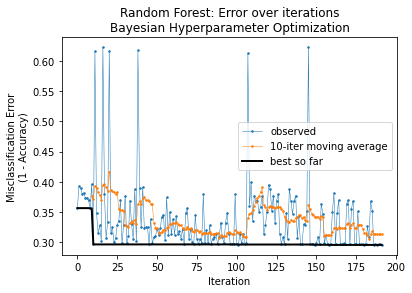

In [11]:
# convergence plot
accs = np.array(bayes_result.cv_results_['mean_test_score'])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.close('all')
plt.figure()
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("Random Forest: Error over iterations\nBayesian Hyperparameter Optimization")
plt.legend()

Text(0.5, 1.0, 'Random Forest Runtime\nModel vs. Bayesian Search Contribution')

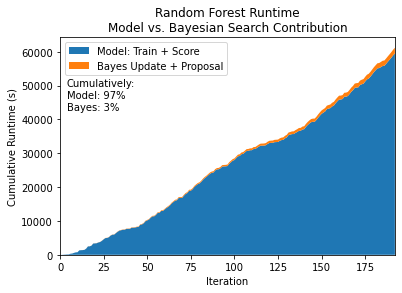

In [12]:
#### runtime plot: model vs. bayesian

plt.close('all')
model_times = np.array(bayes_result.cv_results_['mean_fit_time'])*5 + \
              np.array(bayes_result.cv_results_['mean_score_time'])*5 
total_times = np.array(timercb.iter_time)
bayes_times = total_times - model_times

cumul_totaltime = total_times.cumsum()
cumul_modeltime = model_times.cumsum()
cumul_bayestime = bayes_times.cumsum()

bayes_frac = cumul_bayestime[-1]/cumul_totaltime[-1]
model_frac = cumul_modeltime[-1]/cumul_totaltime[-1]

plt.stackplot(range(0, len(model_times) + 1), [0, *cumul_modeltime], [0, *cumul_bayestime], 
              labels=['Model: Train + Score', 'Bayes Update + Proposal'])
plt.legend(loc='upper left')
plt.xlim((0, len(model_times)))
plt.xlabel('Iteration')
plt.ylabel('Cumulative Runtime (s)')
plt.annotate('Cumulatively:\nModel: {}%\nBayes: {}%'.format(round(model_frac * 100), round(bayes_frac * 100)), 
             (0.02*len(model_times), 0.7*cumul_totaltime[-1]))
plt.title('Random Forest Runtime\nModel vs. Bayesian Search Contribution')

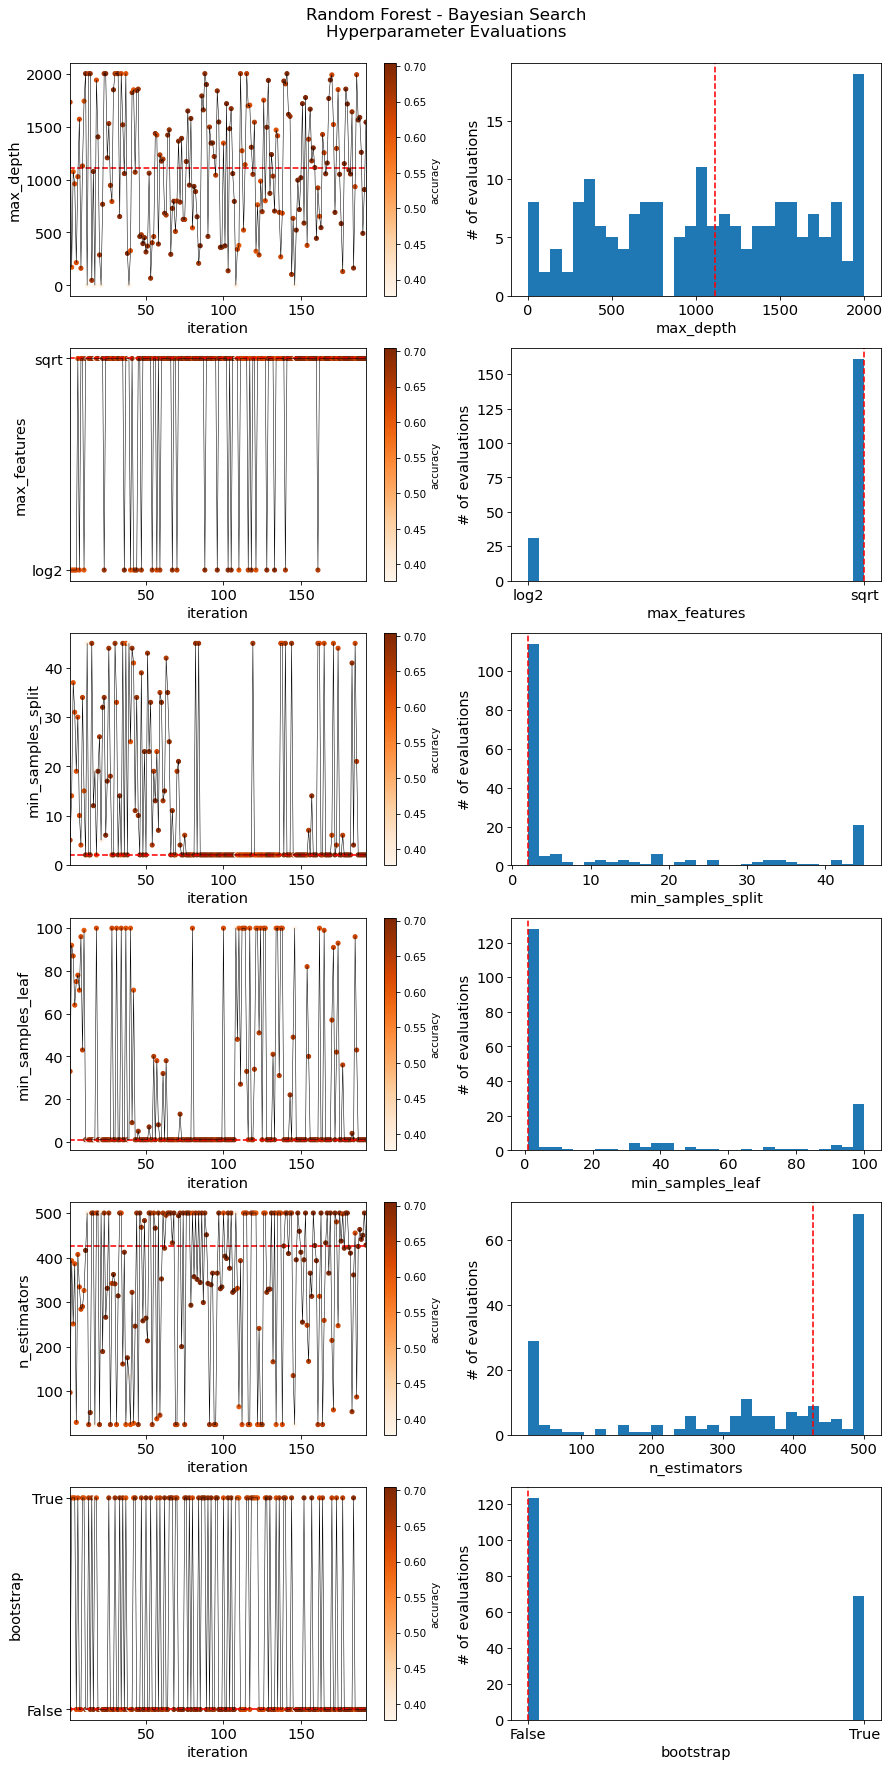

In [13]:
accs = np.array(bayes_result.cv_results_['mean_test_score'])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs


params = bayes_result.search_spaces.keys()
plt.figure(figsize=(12, 4*len(params)), dpi=75)

for i, param in enumerate(params):
    plt.subplot(len(params), 2, 2*i+1)
    param_vals = bayes_result.cv_results_[f'param_{param}']
    if type(param_vals[0]) == bool:
        param_vals = [str(x) for x in param_vals]
    best_val = bayes_result.best_params_[param]

    plt.scatter(np.arange(1,len(param_vals)+1), param_vals, s=15, c=accs, cmap="Oranges", label="Accuracy")
    plt.plot(np.arange(1,len(param_vals)+1), param_vals, 'k', linewidth=0.5)
    plt.xlim(1, len(param_vals))
    plt.hlines(best_val, 0, len(param_vals), 'r', 'dashed')

    plt.ylabel(param, fontsize=14)
    plt.xlabel("iteration", fontsize=14)
    cb = plt.colorbar()
    cb.set_label("accuracy")
    plt.tick_params(labelsize=14)

    
    plt.subplot(len(params), 2, 2*i+2)
    plt.hist(param_vals, bins=30)
    plt.axvline(x=best_val, color='red', linestyle='--')
    plt.xlabel(param, fontsize=14)
    plt.ylabel('# of evaluations', fontsize=14)
    plt.tick_params(labelsize=14)
    
plt.suptitle("Random Forest - Bayesian Search\nHyperparameter Evaluations", size=16)
plt.tight_layout(rect=[0, 0.0, 1, 0.98])


# Combined Plots

In [25]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

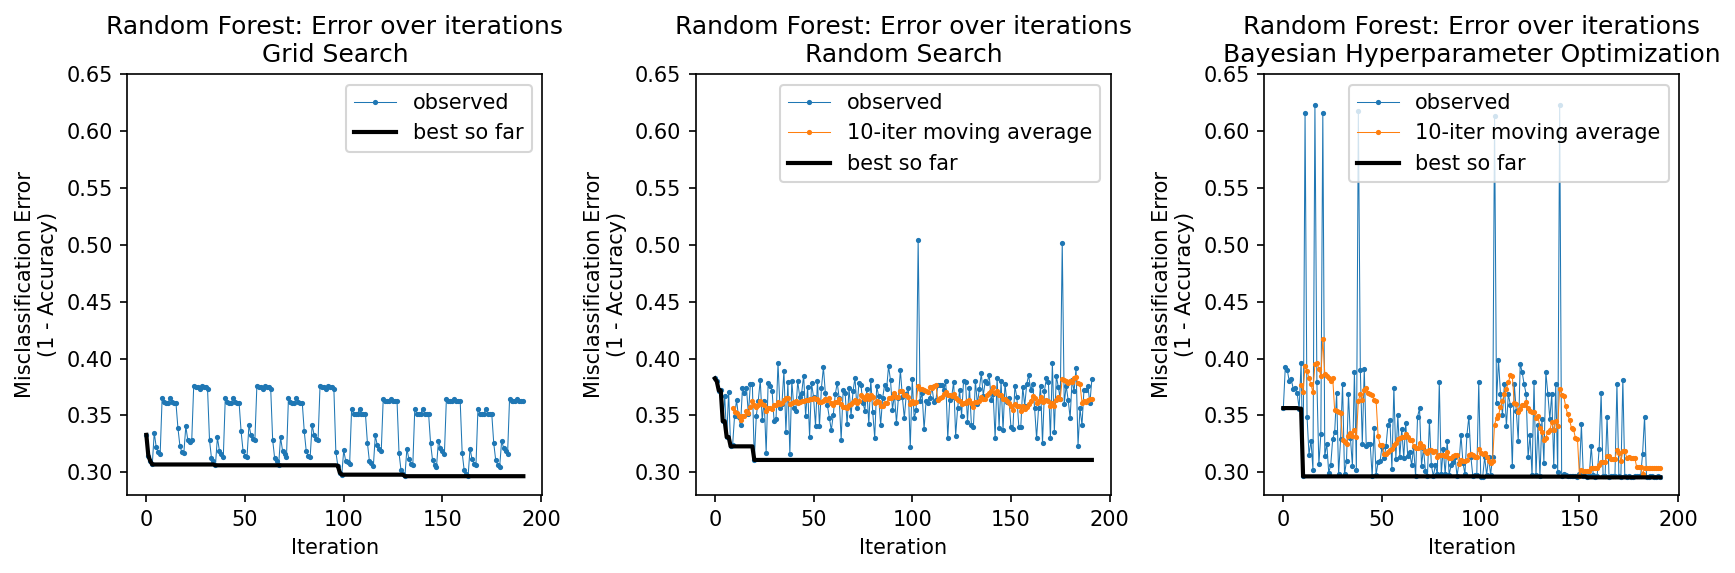

In [57]:
plt.close('all')
plt.figure(figsize=(12, 4), dpi=150)


####### convergence plot, GS
plt.subplot(1, 3, 1)

accs = np.array([x['mean_metric'] for x in gs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("Random Forest: Error over iterations\nGrid Search")
plt.legend()
plt.ylim((.28, .65))


####### convergence plot, RS
plt.subplot(1, 3, 2)

accs = np.array([x['mean_metric'] for x in rs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("Random Forest: Error over iterations\nRandom Search")
plt.legend()
plt.ylim((.28, .65))


####### convergence plot, Bayesian
plt.subplot(1, 3, 3)

accs = np.array(bayes_result.cv_results_['mean_test_score'])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("Random Forest: Error over iterations\nBayesian Hyperparameter Optimization")
plt.legend(loc='upper right')
plt.ylim((.28, .65))


plt.tight_layout(rect=[0, 0.0, .96, 0.98])

# Get CSVs + best model summaries

In [27]:
############################ 
# Only uncomment the below if you are making these summaries in a different
# session from when you ran the above.
############################ 

#bayes_result = skopt.load('randomforest_bayes_result_20201107-181030.pkl')

#with open('randomforest_gs_results_201107_235607.pkl', 'rb') as f:
#    gs_results = pickle.load(f)
#gs = gs_results['gs']
#gs_results = gs_results['gs_results']

#with open('randomforest_rs_results_201108_041248.pkl', 'rb') as f:
#    rs_results = pickle.load(f)
#rs = rs_results['rs']
#rs_results = rs_results['rs_results']

In [28]:
print('\nGrid search best model:')
best = max(gs_results, key=lambda item: item['mean_metric'])
print('    Score = {}'.format(best['mean_metric']))

for param in sorted(best['params'].keys()):
    print('    {} = {}'.format(param, best['params'][param]))


Grid search best model:
    Score = 0.7034
    bootstrap = False
    max_depth = 100
    max_features = sqrt
    min_samples_leaf = 1
    min_samples_split = 2
    n_estimators = 500


In [29]:
print('\nRandom search best model:')
best = max(rs_results, key=lambda item: item['mean_metric'])
print('    Score = {}'.format(best['mean_metric']))

for param in sorted(best['params'].keys()):
    print('    {} = {}'.format(param, best['params'][param]))


Random search best model:
    Score = 0.6890999999999999
    bootstrap = False
    max_depth = 1474
    max_features = sqrt
    min_samples_leaf = 7
    min_samples_split = 18
    n_estimators = 426


In [30]:
print('\nBayes search best model:')
print('    Score = {}'.format(bayes_result.best_score_))
for param in sorted(bayes_result.best_params_.keys()):
    print('    {} = {}'.format(param, bayes_result.best_params_[param]))


Bayes search best model:
    Score = 0.7044
    bootstrap = False
    max_depth = 1573
    max_features = sqrt
    min_samples_leaf = 1
    min_samples_split = 2
    n_estimators = 427


In [31]:
df_results = pd.DataFrame()
for res in gs_results:
    row = {'search_type': 'grid', 'accuracy': res['mean_metric'], **res['params']}
    df_results = df_results.append(row, ignore_index=True)

In [32]:
for res in rs_results:
    row = {'search_type': 'random', 'accuracy': res['mean_metric'], **res['params']}
    df_results = df_results.append(row, ignore_index=True)

In [33]:
for i, cv_score in enumerate(bayes_result.cv_results_['mean_test_score']):
    row = {'search_type': 'bayes', 'accuracy': cv_score}
    for param in bayes_result.search_spaces.keys():
        row[param] = bayes_result.cv_results_['param_' + param][i]
    df_results = df_results.append(row, ignore_index=True)

In [34]:
df_results.to_csv('randomforest_results_{}.csv'.format(datetime.now().strftime('%Y%m%d-%H%M%S')), index=False)